In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 136]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/axial/t1c", t2f_dir="PED_Sliced/axial/t2f", seg_dir="PED_Sliced/axial/seg", transforms=data_transforms)

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



4324
181
Data shape: torch.Size([24, 2, 240, 240])
Labels shape: torch.Size([24, 240, 240])
Data shape: torch.Size([24, 2, 240, 240])
Labels shape: torch.Size([24, 240, 240])


In [6]:
# import torch
# import torch.nn as  nn
# import torch.nn.functional as F


# class Bottleneck(nn.Module):
#     expansion = 4
#     def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
#         super(Bottleneck, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
#         self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#         self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
#         self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
#         self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
#         self.i_downsample = i_downsample
#         self.stride = stride
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         identity = x.clone()
#         x = self.relu(self.batch_norm1(self.conv1(x)))
        
#         x = self.relu(self.batch_norm2(self.conv2(x)))
        
#         x = self.conv3(x)
#         x = self.batch_norm3(x)
        
#         #downsample if needed
#         if self.i_downsample is not None:
#             identity = self.i_downsample(identity)
#         #add identity
#         x+=identity
#         x=self.relu(x)
        
#         return x

# class Block(nn.Module):
#     expansion = 1
#     def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
#         super(Block, self).__init__()
       

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.batch_norm1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.batch_norm2 = nn.BatchNorm2d(out_channels)

#         self.i_downsample = i_downsample
#         self.stride = stride
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         identity = x.clone()

#         x = self.relu(self.batch_norm2(self.conv1(x)))
#         x = self.batch_norm2(self.conv2(x))

#         if self.i_downsample is not None:
#             identity = self.i_downsample(identity)
#         print(x.shape)
#         print(identity.shape)
#         x += identity
#         x = self.relu(x)
#         return x


        
        
# class ResNet50(nn.Module):
#     def __init__(self, ResBlock, layer_list, num_classes, num_channels=2, image_size=(240, 240)):
#         super(ResNet, self).__init__()
#         self.in_channels = 64
#         self.image_size = image_size

#         self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=1, padding=3, bias=False)
#         self.batch_norm1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU()

#         self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
#         self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128)
#         self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256)
#         self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512)

#         self.conv_final = nn.Conv2d(512 * ResBlock.expansion, num_classes, kernel_size=1)

#     def forward(self, x):
#         x = self.relu(self.batch_norm1(self.conv1(x)))

#         x = self.layer1(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer2(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer3(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer4(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.conv_final(x)
#         x = F.interpolate(x, size=self.image_size, mode='bilinear', align_corners=False)

#         return x

        
#     def _make_layer(self, ResBlock, blocks, planes, stride=1):
#         ii_downsample = None
#         layers = []
        
#         if stride != 1 or self.in_channels != planes*ResBlock.expansion:
#             ii_downsample = nn.Sequential(
#                 nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
#                 nn.BatchNorm2d(planes*ResBlock.expansion)
#             )
            
#         layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
#         self.in_channels = planes*ResBlock.expansion
        
#         for i in range(blocks-1):
#             layers.append(ResBlock(self.in_channels, planes))
            
#         return nn.Sequential(*layers)

        
        
# # def ResNet50(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
# # def ResNet101(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

# # def ResNet152(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)


In [7]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.conv(x)

    
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi

class ResUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResUNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Attention blocks
        self.attention_block1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.attention_block2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.attention_block3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.attention_block4 = AttentionBlock(F_g=64, F_l=64, F_int=32)

        # Residual blocks
        self.residual_block1 = ResidualBlock(1024)
        self.residual_block2 = ResidualBlock(512)
        self.residual_block3 = ResidualBlock(256)
        self.residual_block4 = ResidualBlock(128)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)
        c5 = self.residual_block1(c5)

        # Upsample path
        up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
        attention_map1 = self.attention_block1(up6, c4)
        merge6 = torch.cat([up6, attention_map1], dim=1)
        c6 = self.conv6(merge6)
        c6 = self.residual_block2(c6)

        up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
        attention_map2 = self.attention_block2(up7, c3)
        merge7 = torch.cat([up7, attention_map2], dim=1)
        c7 = self.conv7(merge7)
        c7 = self.residual_block3(c7)

        up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
        attention_map3 = self.attention_block3(up8, c2)
        merge8 = torch.cat([up8, attention_map3], dim=1)
        c8 = self.conv8(merge8)
        c8 = self.residual_block4(c8)

        up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
        attention_map4 = self.attention_block4(up9, c1)
        merge9 = torch.cat([up9, attention_map4], dim=1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out

    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [8]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [9]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [10]:
from tqdm import tqdm

def train_model(num_epochs):
    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    model_path = "resUnet_PED_axial.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = ResUNet(2,4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = ResUNet(2,4).to(device)
        print("New model initialized.")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")
        running_loss = 0.0
        num_batches = 0
        running_train_dsc = []
        running_train_assd = []

        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.long()

            outputs = model(images)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
                plot_preds_and_masks(preds, masks[:2])

            running_loss += loss.item()
            num_batches += 1

            # Computing DSC score and other metrics
            _, preds = torch.max(outputs, 1)
            preds_one_hot = F.one_hot(preds, num_classes = 4)
            preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)
            masks_one_hot = F.one_hot(masks, num_classes = 4)
            masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)
            train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
            running_train_dsc.append(train_dsc)
            running_train_assd.append(train_assd)

        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")
        print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        model.eval()  
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device).long()

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                running_val_loss += val_loss.item()
                num_val_batches += 1

                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    plot_preds_and_masks(preds, val_masks[:2])

                # Computing DSC score and other metrics for validation set
                _, val_preds = torch.max(val_outputs, 1)
                val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)
                val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                running_val_dsc.append(val_dsc)
                running_val_assd.append(val_assd)

        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")
        print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        torch.save(model.state_dict(), "resUnet_PED_axial.pth")

    return model


In [11]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


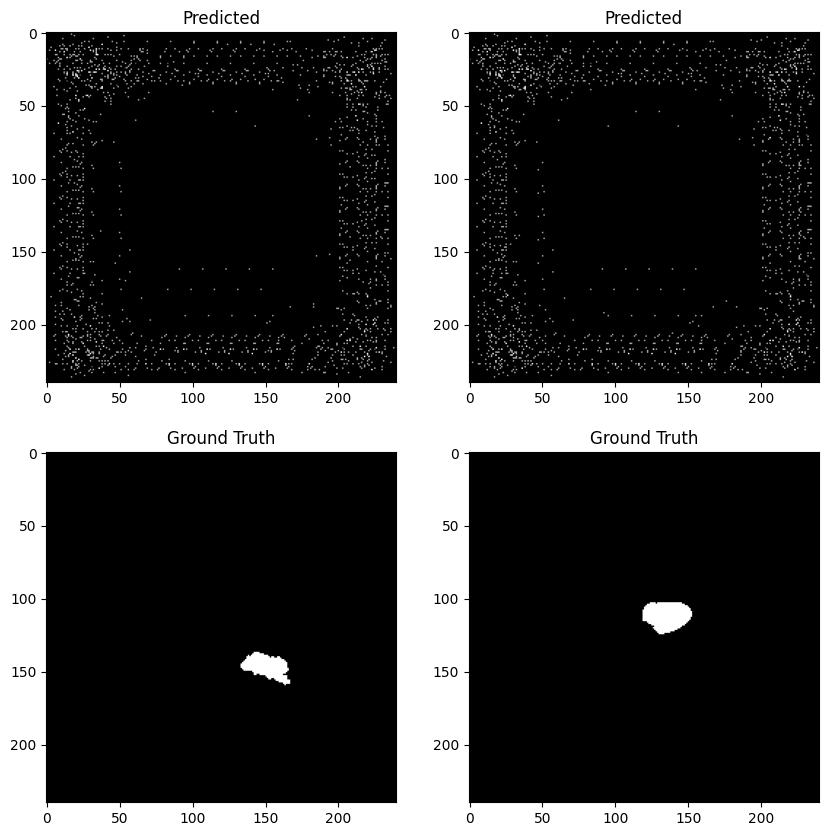

100%|██████████| 181/181 [07:54<00:00,  2.62s/it]



Average Training Loss: 0.22503468097902793

Average Training DSC: [0.98987841 0.46754144 0.73457804 0.        ]
Average Training ASSD: [  5.16110637 190.4796463   94.36786386 357.62371247]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


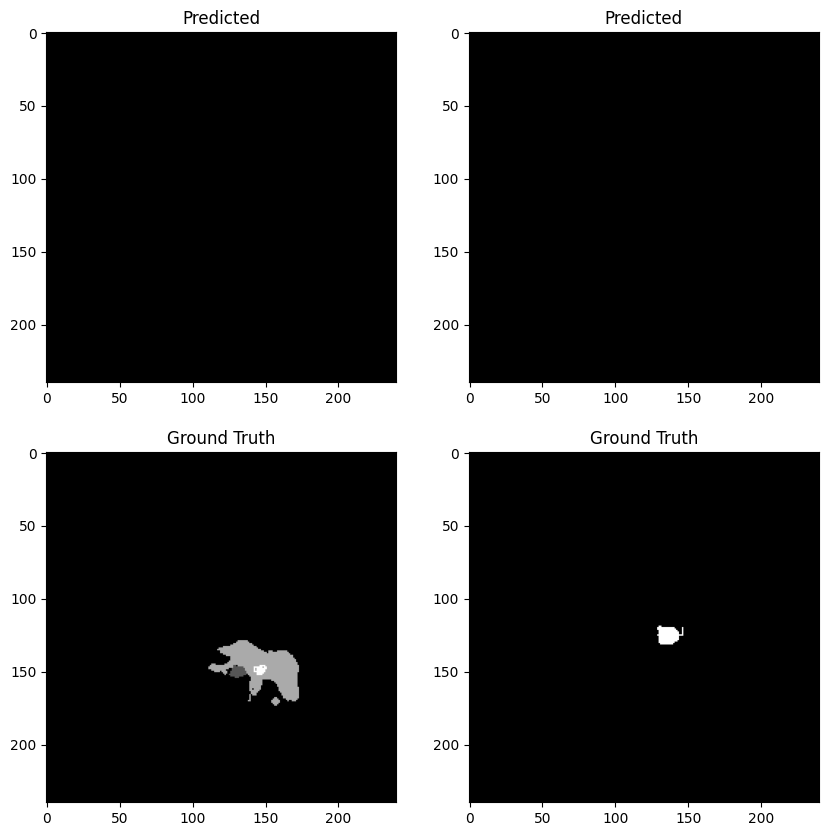

100%|██████████| 46/46 [01:15<00:00,  1.65s/it]


Average Validation Loss: 0.10156859611363514

Average Validation DSC: [0.99023275 0.45833333 0.76177536 0.        ]
Average Validation ASSD: [  5.02835445 196.08333333  86.23731884 362.        ]
Epoch 2/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


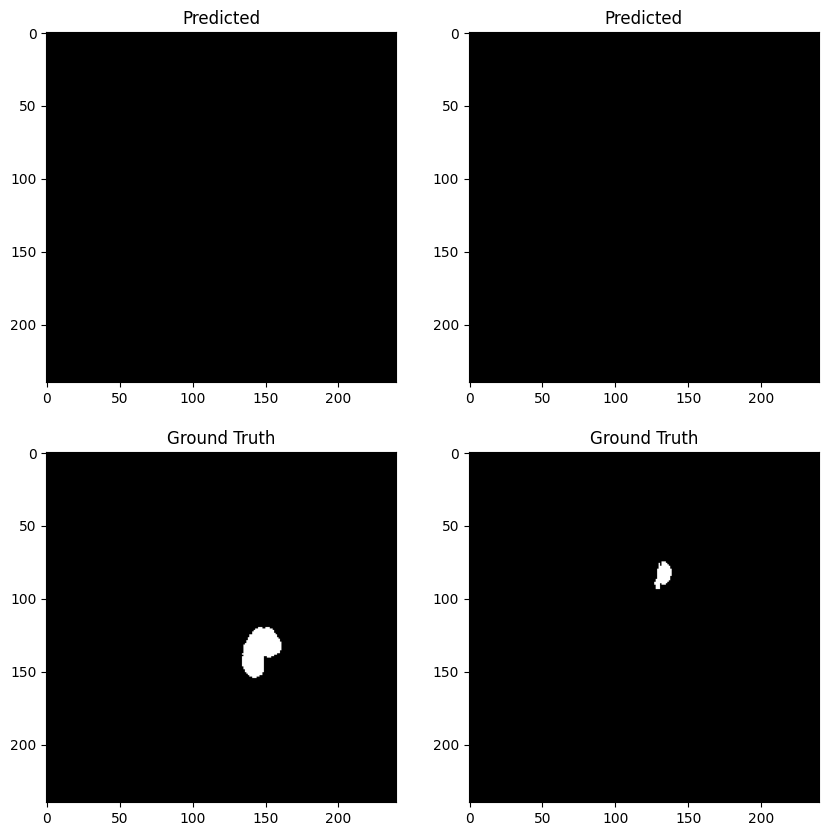

100%|██████████| 181/181 [09:03<00:00,  3.00s/it]



Average Training Loss: 0.04792909863410075

Average Training DSC: [0.99445555 0.3095713  0.75299263 0.24084759]
Average Training ASSD: [  1.36224708 146.11258296  89.41666667 110.93227084]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


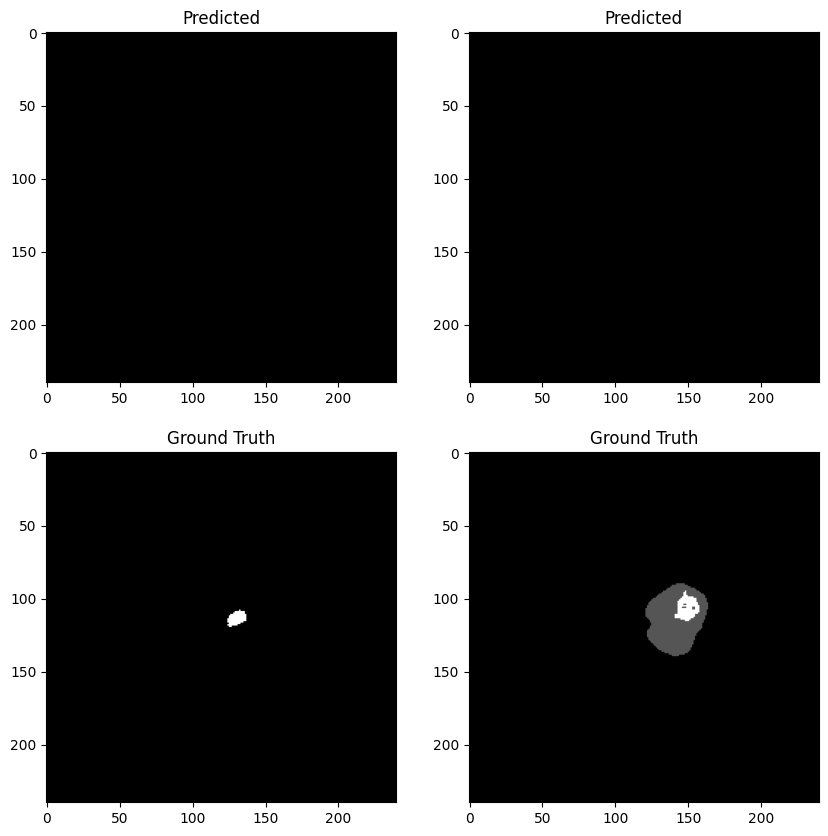

100%|██████████| 46/46 [01:13<00:00,  1.60s/it]


Average Validation Loss: 0.1707139358572338

Average Validation DSC: [0.99021724 0.47826087 0.76177536 0.        ]
Average Validation ASSD: [  5.06845556 188.86956522  86.23731884 362.        ]
Epoch 3/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


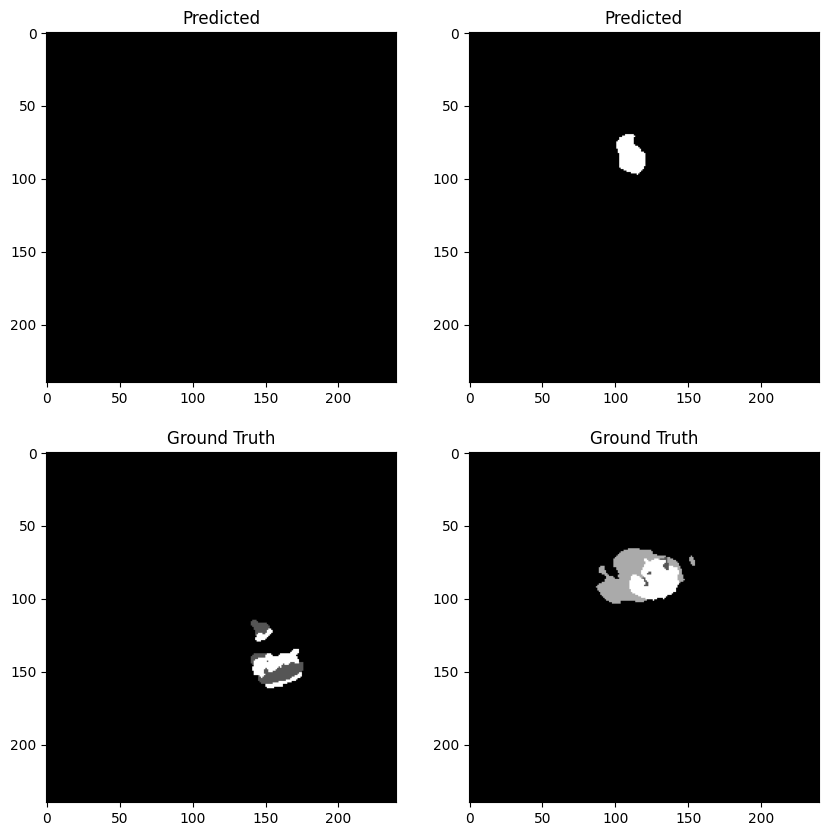

100%|██████████| 181/181 [08:45<00:00,  2.90s/it]



Average Training Loss: 0.04346230008654831

Average Training DSC: [0.99538395 0.3451491  0.75184162 0.28467967]
Average Training ASSD: [  0.92337759 145.05720321  89.83333333  60.33428198]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


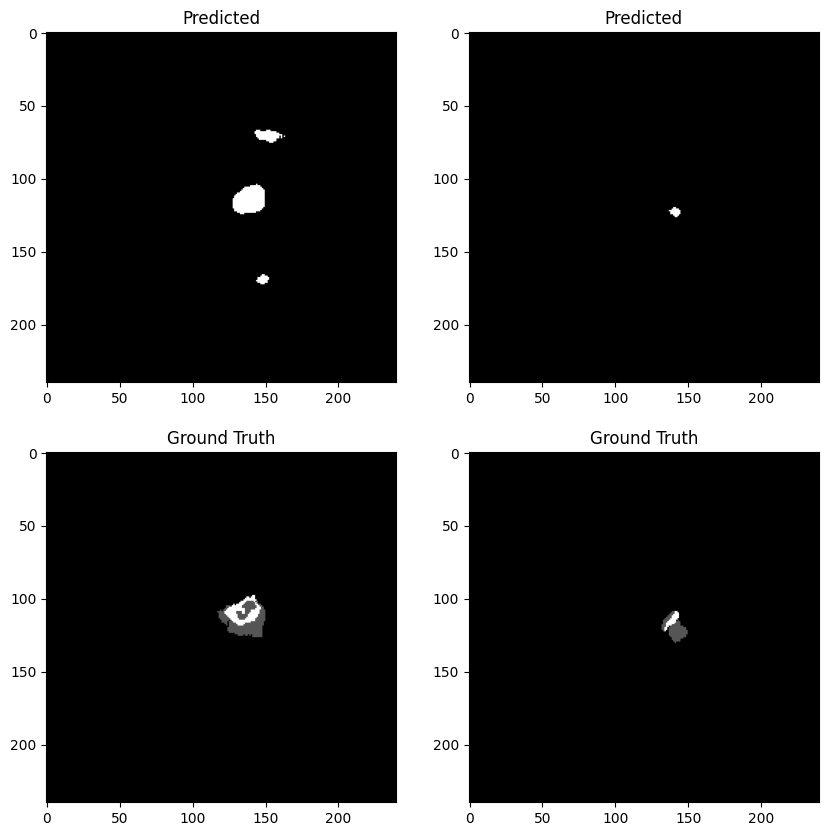

100%|██████████| 46/46 [01:20<00:00,  1.75s/it]


Average Validation Loss: 0.05583478073063104

Average Validation DSC: [0.99357642 0.47826087 0.76177536 0.32477207]
Average Validation ASSD: [  1.19400686 188.86956522  86.23731884  62.75949379]
Epoch 4/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


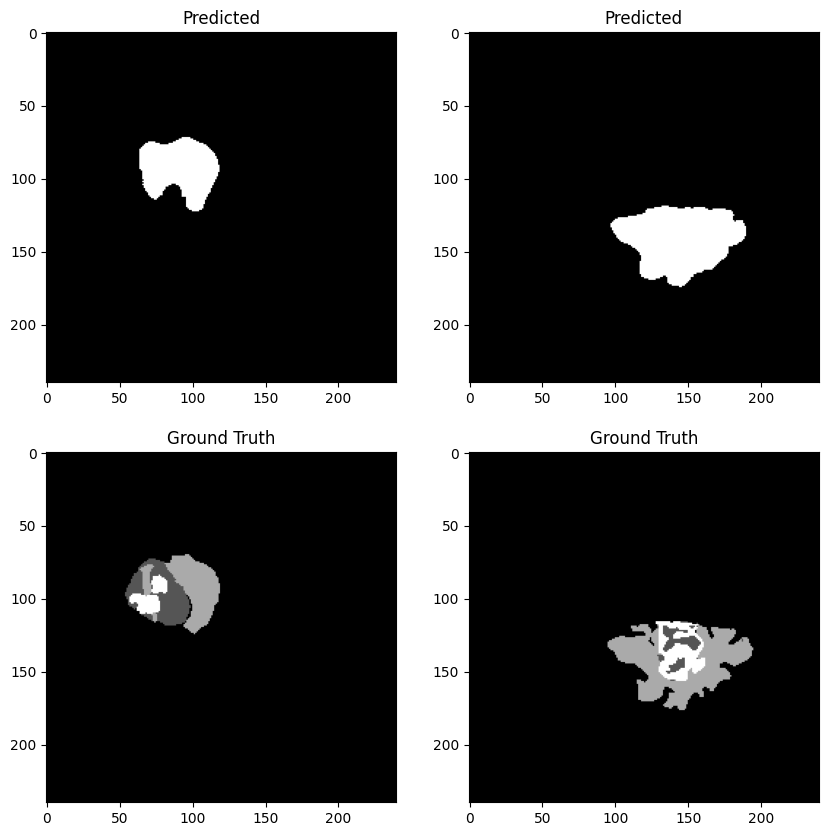

100%|██████████| 181/181 [08:43<00:00,  2.89s/it]



Average Training Loss: 0.040542103761796795

Average Training DSC: [0.99586803 0.34684095 0.75184162 0.30183306]
Average Training ASSD: [  0.78424261 143.49578483  89.83333333  51.79870931]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


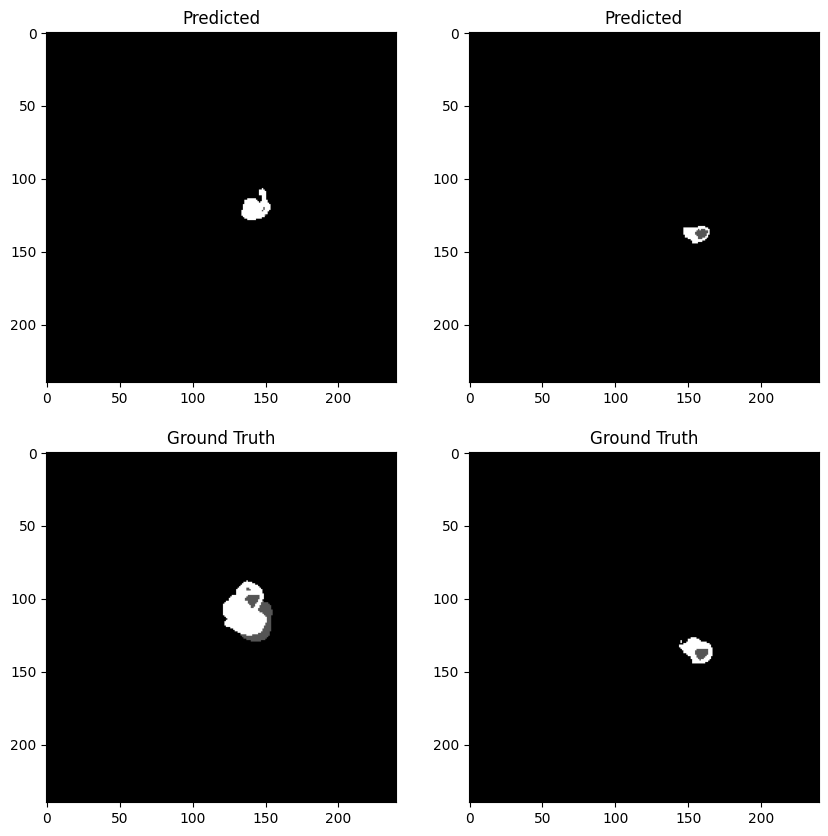

100%|██████████| 46/46 [01:22<00:00,  1.78s/it]


Average Validation Loss: 0.04152820490138686

Average Validation DSC: [0.99478086 0.32935886 0.76177536 0.28342672]
Average Validation ASSD: [  1.10171597 141.17023199  86.23731884  82.42952131]
Epoch 5/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


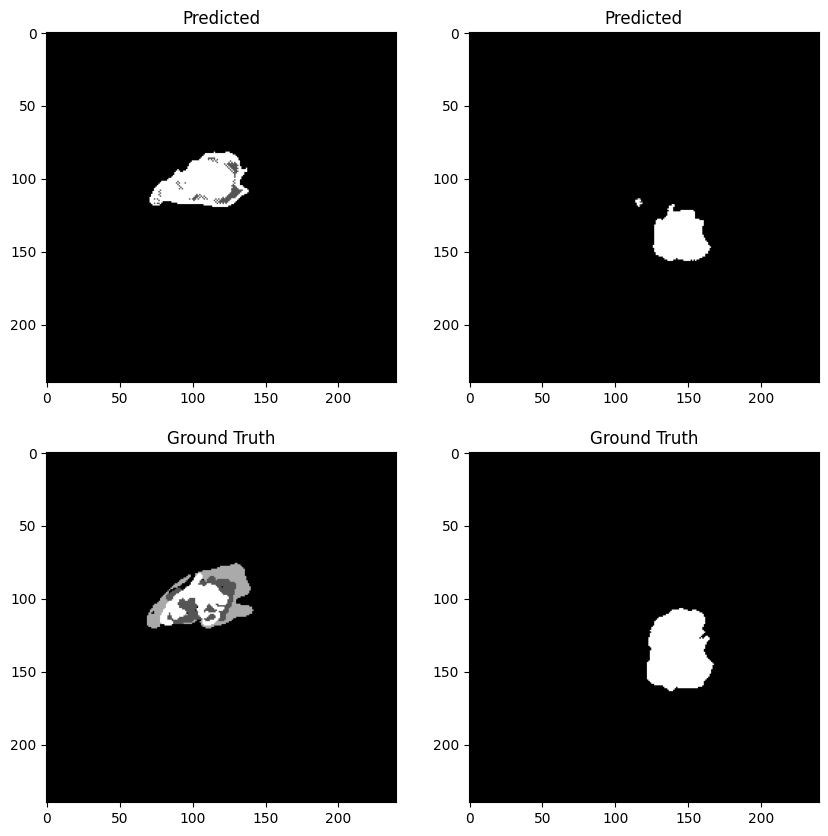

100%|██████████| 181/181 [08:39<00:00,  2.87s/it]



Average Training Loss: 0.038037810958304455

Average Training DSC: [0.99625328 0.325427   0.75184162 0.30853257]
Average Training ASSD: [  0.70545253 140.10747305  89.83333333  57.12455666]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


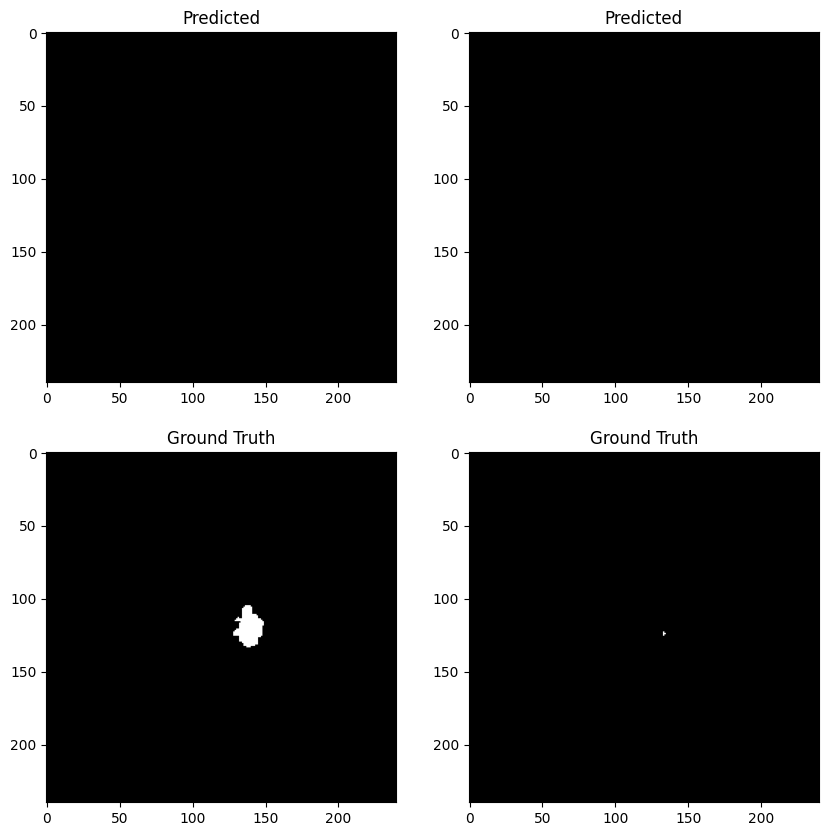

100%|██████████| 46/46 [01:14<00:00,  1.63s/it]


Average Validation Loss: 0.08706171413802583

Average Validation DSC: [0.99094931 0.45730556 0.76177536 0.02110959]
Average Validation ASSD: [  4.02004256 161.45377747  86.23731884 296.63515259]
Epoch 6/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


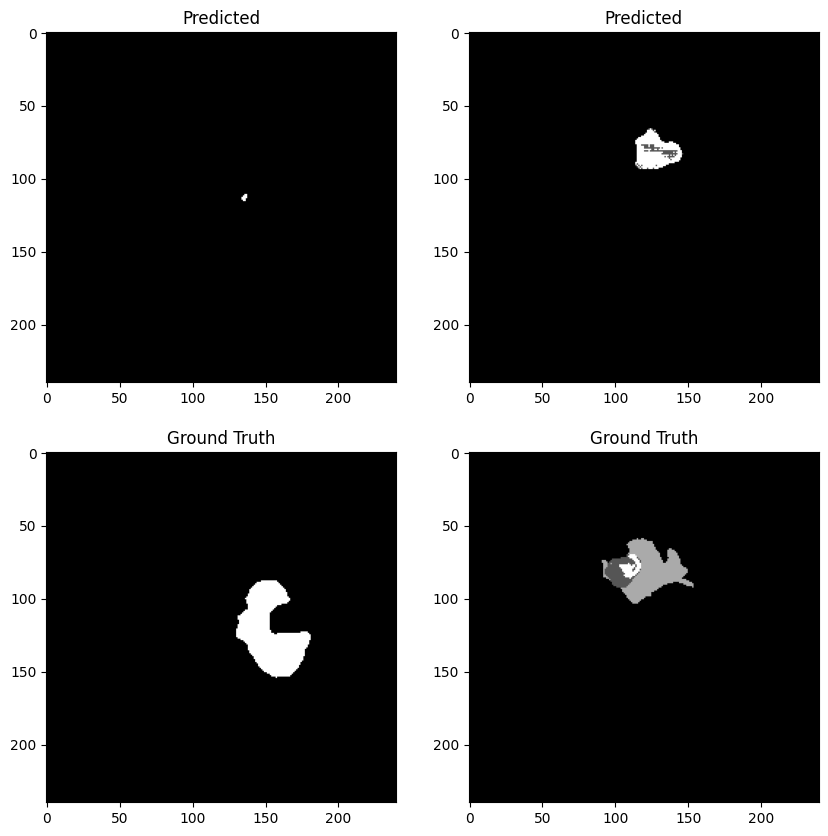

100%|██████████| 181/181 [08:38<00:00,  2.87s/it]



Average Training Loss: 0.03509837165680709

Average Training DSC: [0.99678936 0.33445399 0.75299263 0.31624142]
Average Training ASSD: [  0.59012161 137.33497328  89.41666667  53.84036559]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


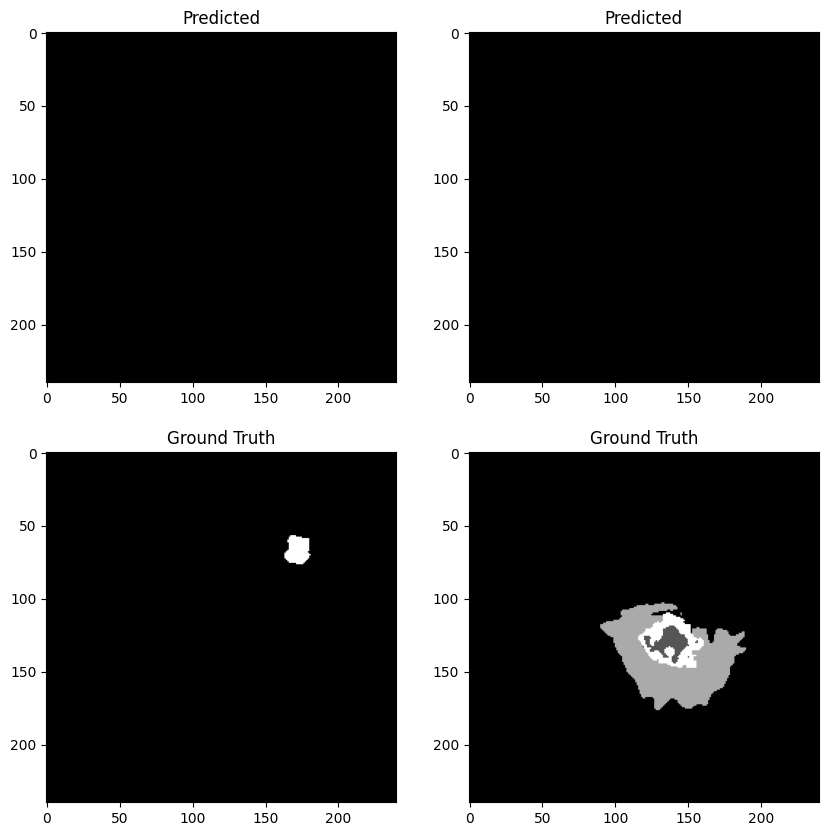

100%|██████████| 46/46 [01:15<00:00,  1.65s/it]


Average Validation Loss: 0.13393205647235332

Average Validation DSC: [0.99036723 0.46820367 0.76177536 0.01409579]
Average Validation ASSD: [  4.43182941 173.50540635  86.23731884 319.8205078 ]
Epoch 7/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


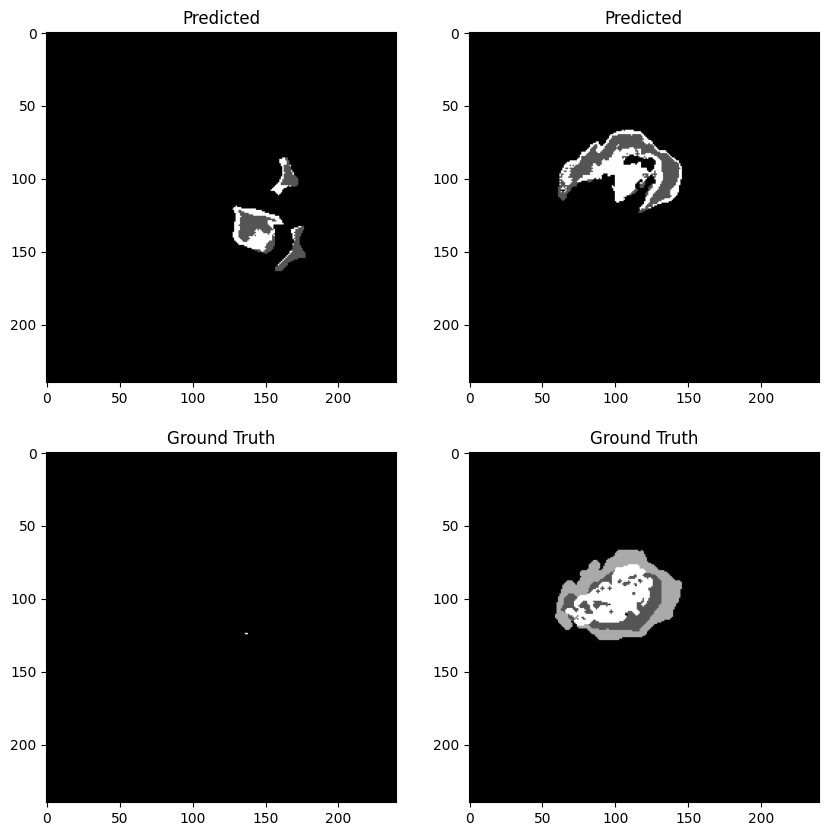

100%|██████████| 181/181 [08:39<00:00,  2.87s/it]



Average Training Loss: 0.034367893621819454

Average Training DSC: [0.99687477 0.32120986 0.74359596 0.31660341]
Average Training ASSD: [  0.56367702 137.95466941  91.37901527  58.52928386]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


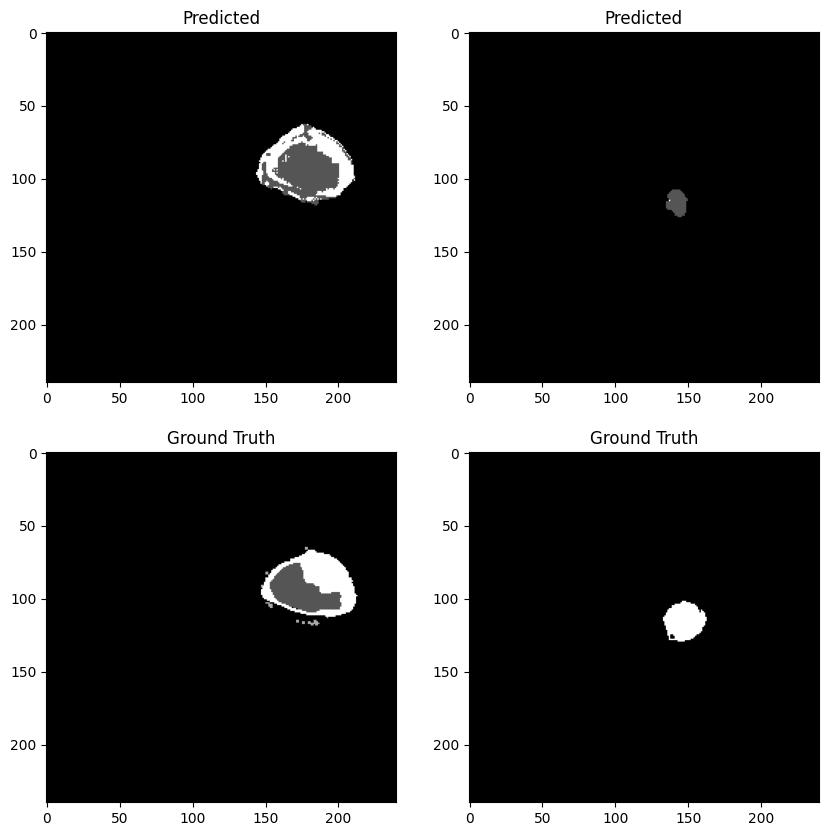

100%|██████████| 46/46 [01:22<00:00,  1.80s/it]


Average Validation Loss: 0.03272523552827213

Average Validation DSC: [0.99741498 0.38375413 0.75181159 0.19090116]
Average Validation ASSD: [  0.48569441 140.80615238  89.8442029   78.60379162]
Epoch 8/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


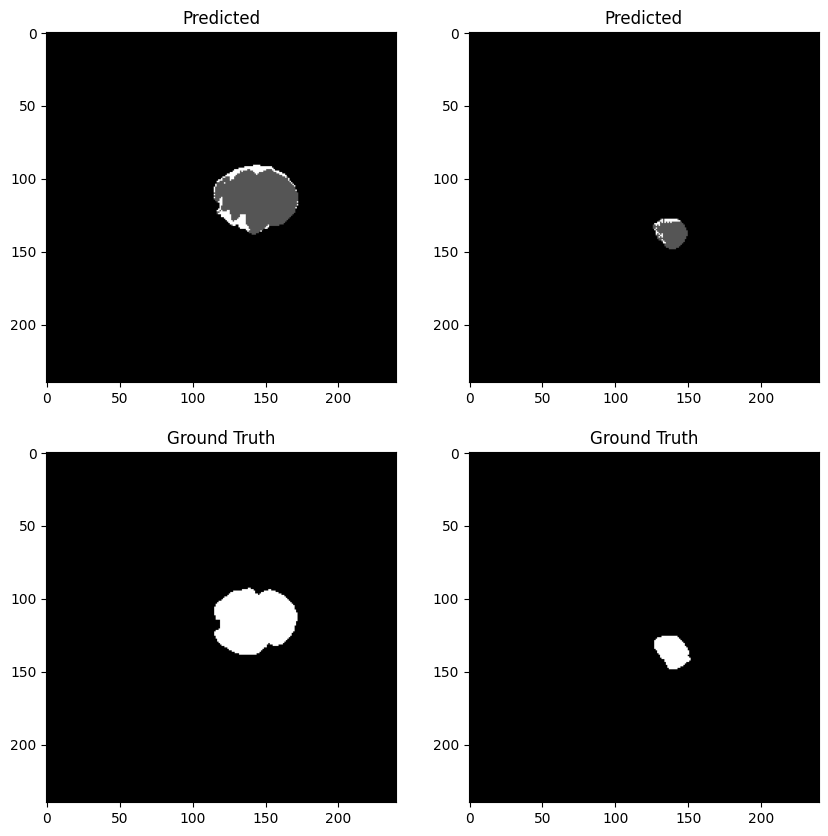

100%|██████████| 181/181 [08:41<00:00,  2.88s/it]



Average Training Loss: 0.03281274022153728

Average Training DSC: [0.99714638 0.31201988 0.73058305 0.33534491]
Average Training ASSD: [  0.49343103 143.41938245  93.46538736  52.39621442]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


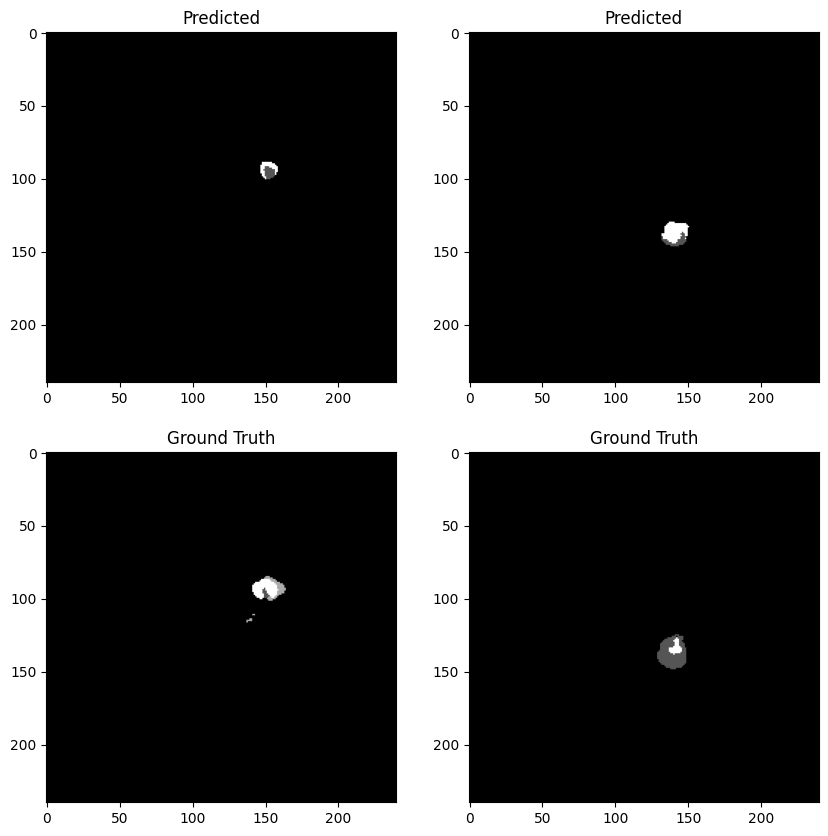

100%|██████████| 46/46 [01:21<00:00,  1.76s/it]


Average Validation Loss: 0.05102220070345894

Average Validation DSC: [0.99433768 0.41483311 0.71812951 0.18397597]
Average Validation ASSD: [  1.80711743 116.37093136  94.77064427 174.87097663]
Epoch 9/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


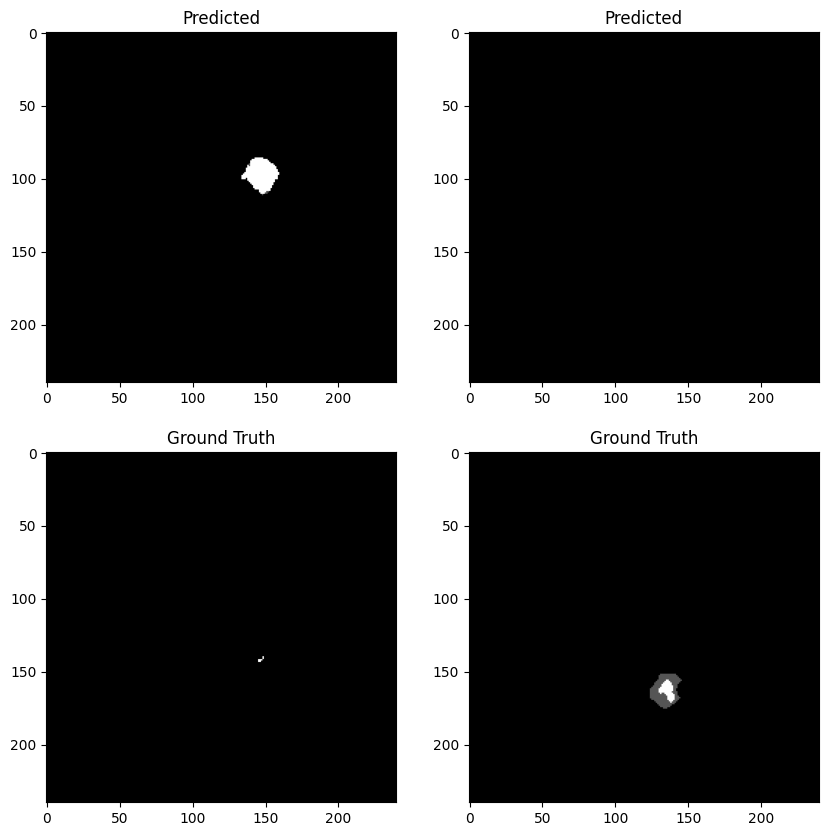

100%|██████████| 181/181 [08:43<00:00,  2.89s/it]



Average Training Loss: 0.0319388460223846

Average Training DSC: [0.99729486 0.31593219 0.68385854 0.33412566]
Average Training ASSD: [  0.4530693  144.08204595 101.69864813  51.57445893]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


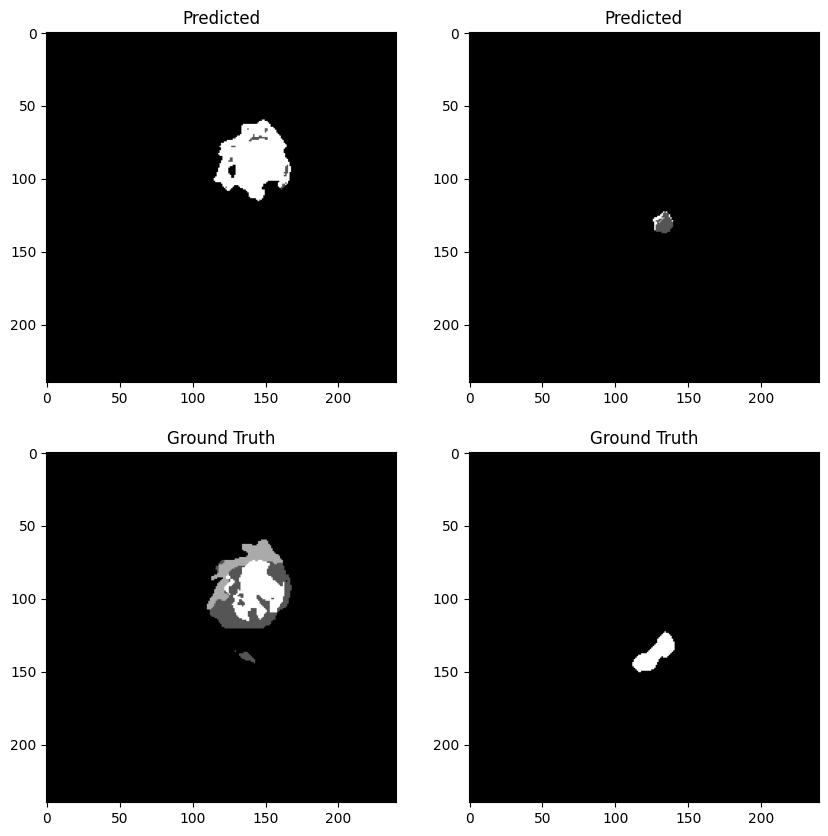

100%|██████████| 46/46 [01:23<00:00,  1.80s/it]


Average Validation Loss: 0.04842769727110863

Average Validation DSC: [0.99485546 0.31142941 0.70981781 0.32717909]
Average Validation ASSD: [  0.93143192 138.8781016   98.91856425  49.65807441]
Epoch 10/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


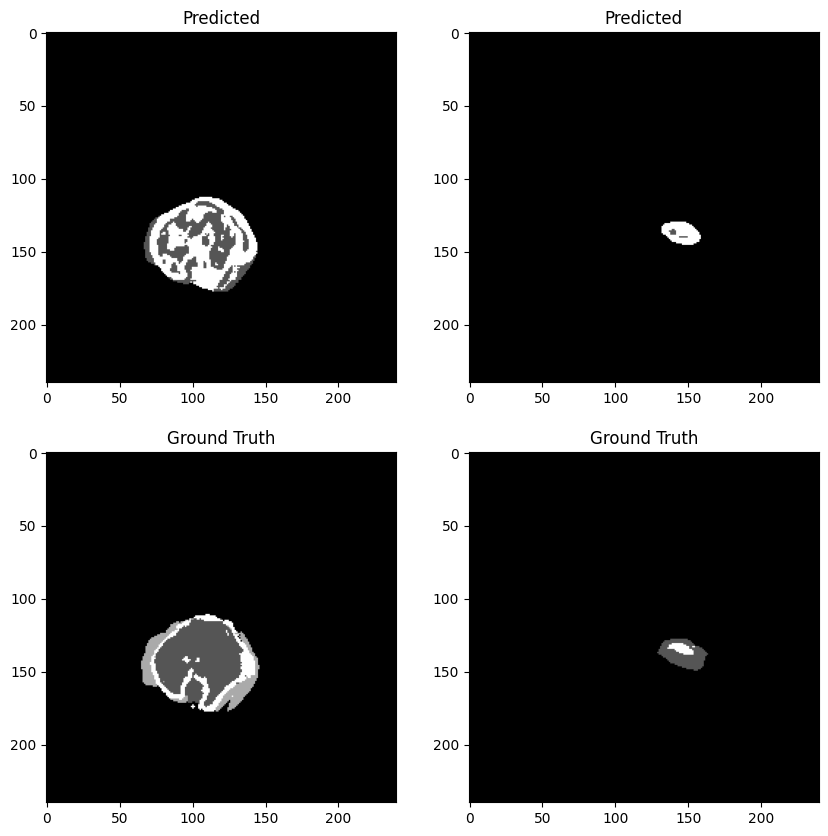

100%|██████████| 181/181 [08:42<00:00,  2.89s/it]



Average Training Loss: 0.03123074663977926

Average Training DSC: [0.99740926 0.32501498 0.65834905 0.35009724]
Average Training ASSD: [  0.4583962  141.94199814 107.46501287  51.95779811]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


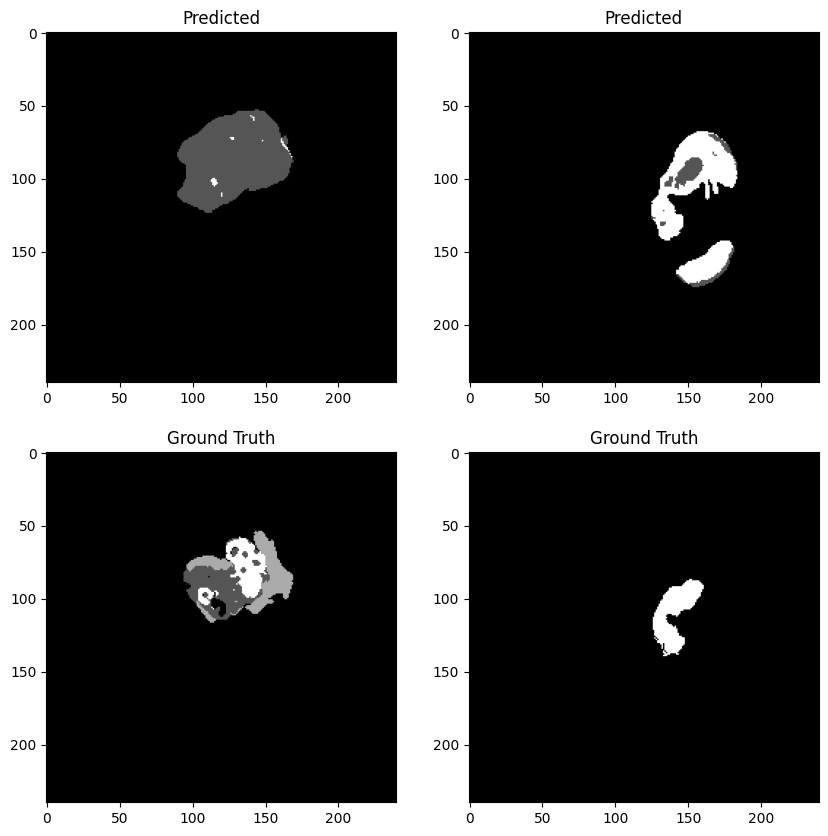

100%|██████████| 46/46 [01:27<00:00,  1.90s/it]


Average Validation Loss: 0.11209997648130292

Average Validation DSC: [0.98459441 0.22303684 0.56485503 0.12766934]
Average Validation ASSD: [  3.28412432 172.02338973 139.47964295  38.67522826]
Epoch 11/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


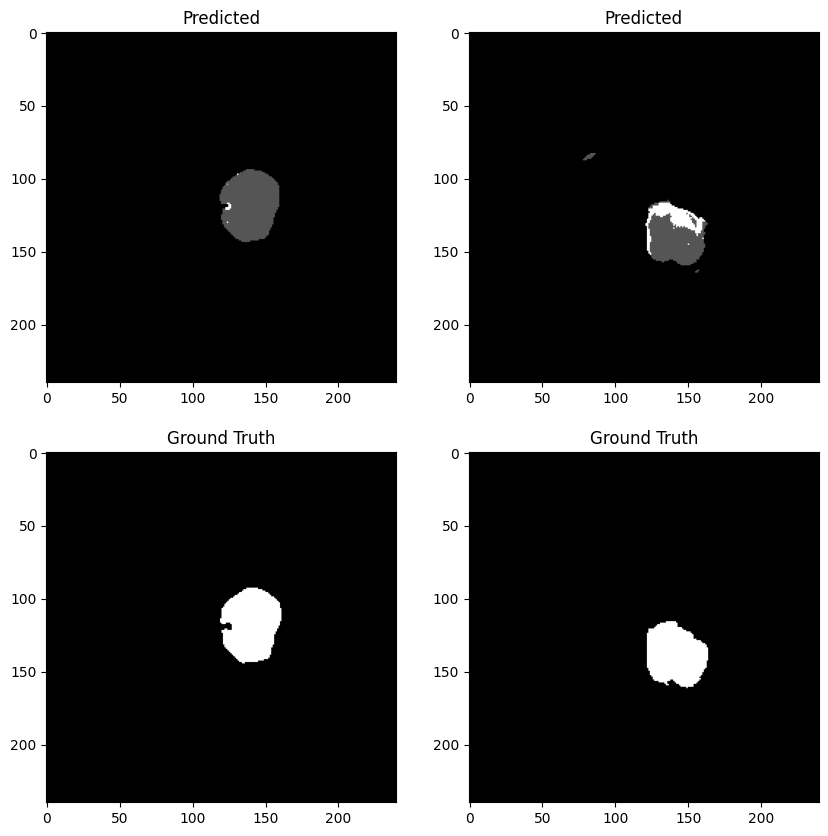

100%|██████████| 181/181 [08:44<00:00,  2.90s/it]



Average Training Loss: 0.03016307028988119

Average Training DSC: [0.99760744 0.32656536 0.58783855 0.35594199]
Average Training ASSD: [  0.41667894 143.87275965 121.5058927   51.23987547]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


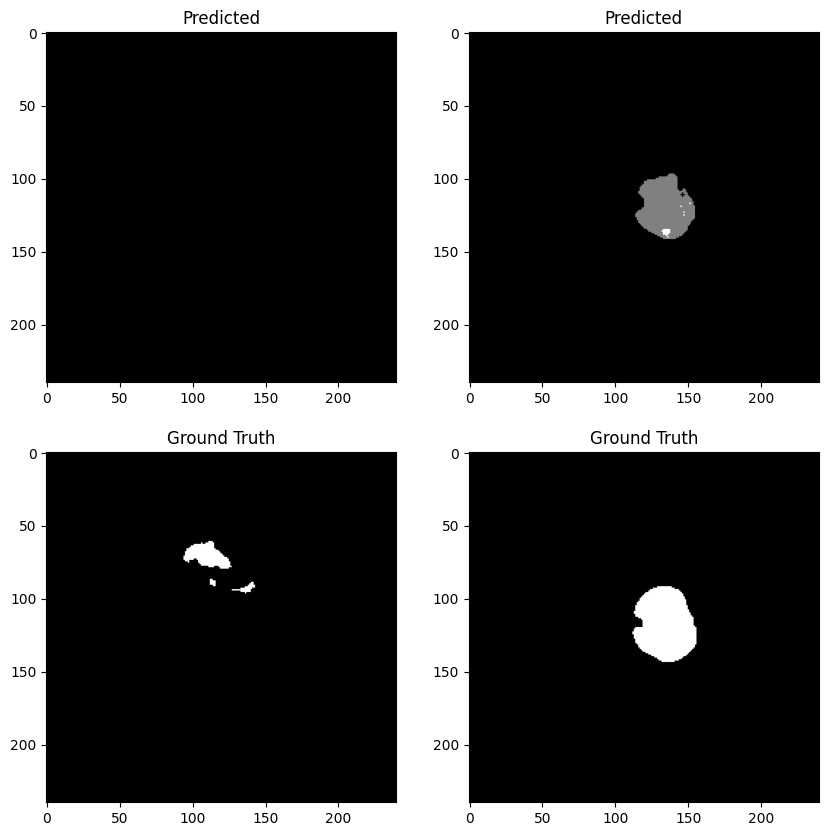

100%|██████████| 46/46 [01:22<00:00,  1.79s/it]


Average Validation Loss: 0.04443435257543688

Average Validation DSC: [0.99352095 0.32312269 0.66790722 0.17308483]
Average Validation ASSD: [  1.3061235  127.0757888  108.00321743 136.80129224]
Epoch 12/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


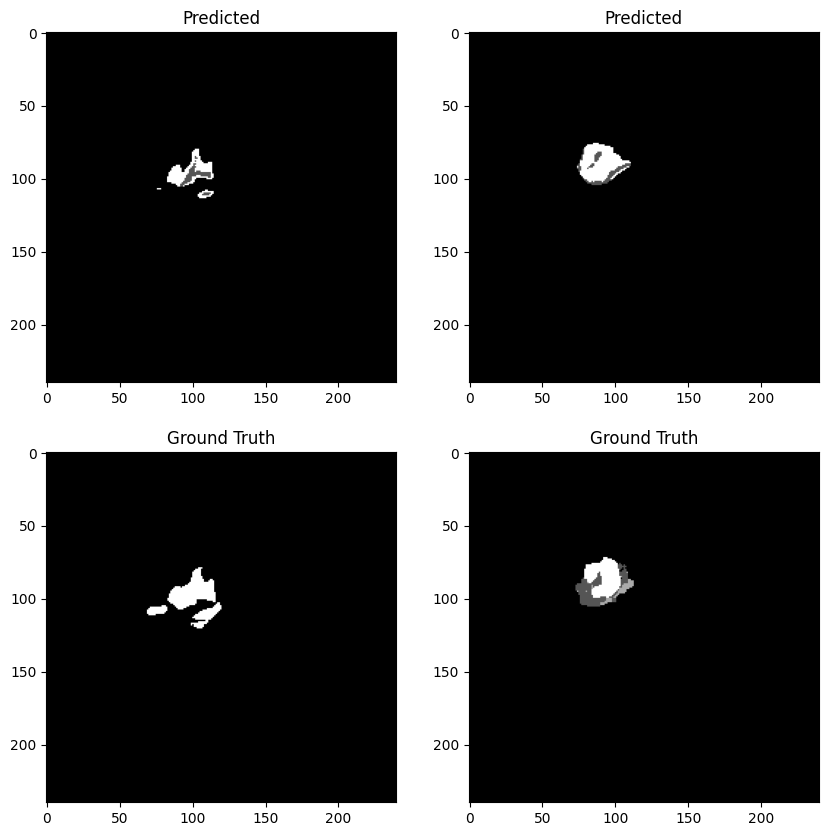

100%|██████████| 181/181 [08:47<00:00,  2.91s/it]



Average Training Loss: 0.028469129769100668

Average Training DSC: [0.9978533  0.3417002  0.47461579 0.38912951]
Average Training ASSD: [  0.36107847 138.04340987 145.23511657  42.61162992]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


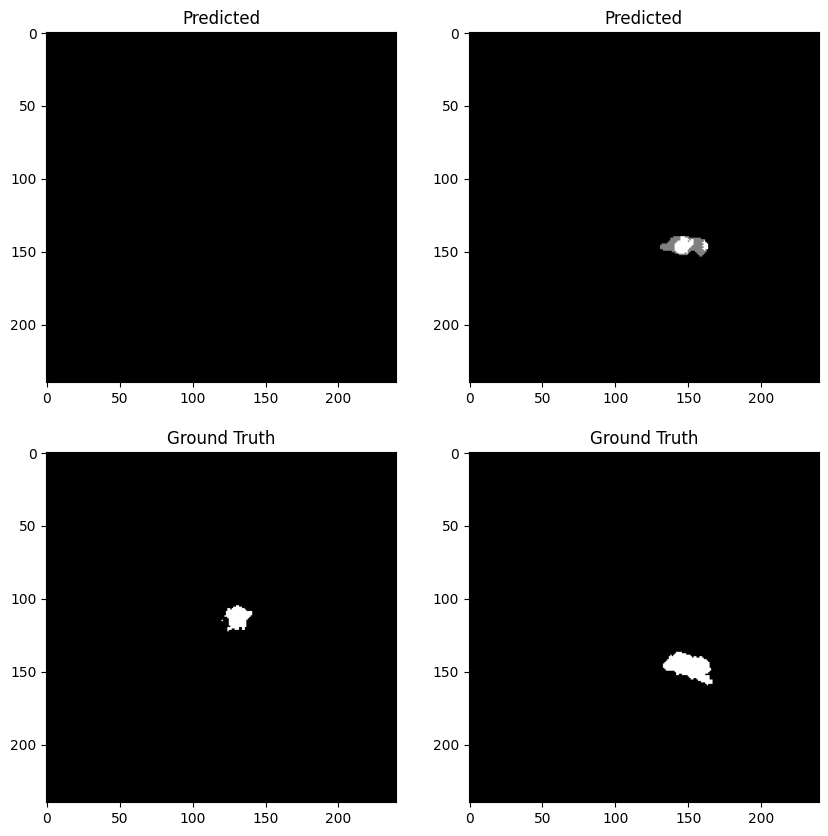

100%|██████████| 46/46 [01:23<00:00,  1.83s/it]


Average Validation Loss: 0.03417872912857844

Average Validation DSC: [0.99626604 0.40415615 0.31789993 0.24924292]
Average Validation ASSD: [  0.82923592 119.43725751 183.03261857 126.6062802 ]
Epoch 13/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


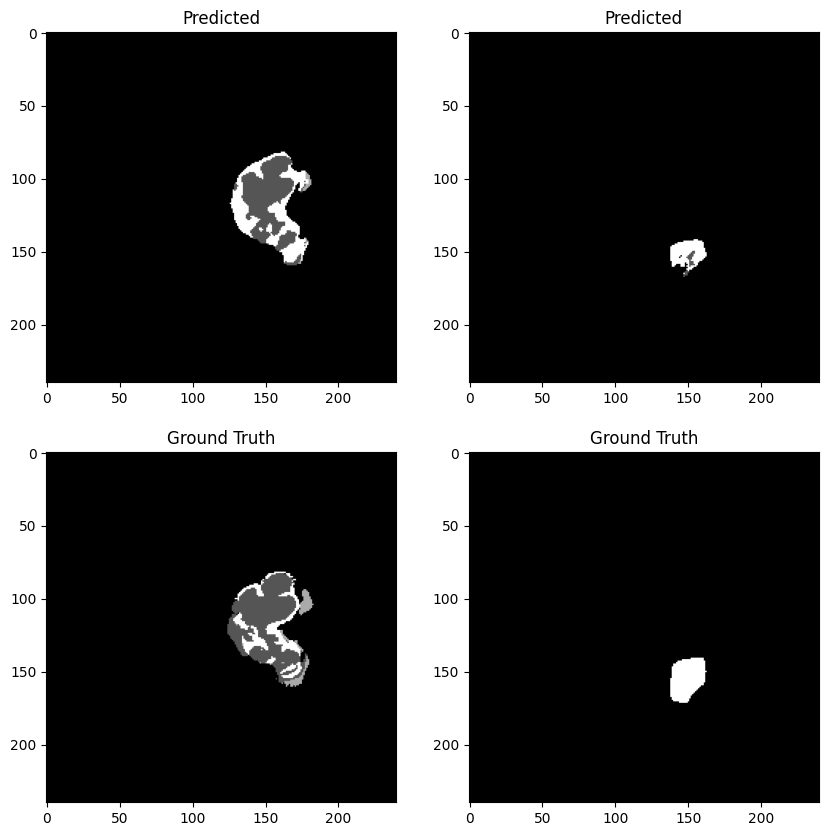

100%|██████████| 181/181 [08:47<00:00,  2.92s/it]



Average Training Loss: 0.026991412794804045

Average Training DSC: [0.99793406 0.39992867 0.33297632 0.40892768]
Average Training ASSD: [  0.33749644 124.84221887 187.36290483  42.18362613]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


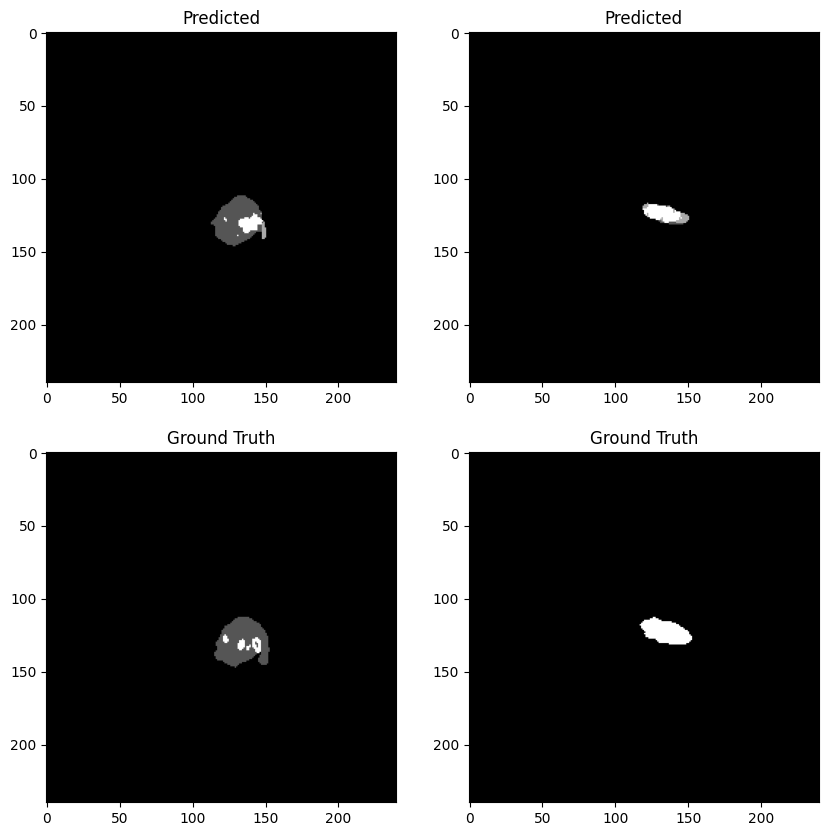

100%|██████████| 46/46 [01:24<00:00,  1.85s/it]


Average Validation Loss: 0.03327575973842455

Average Validation DSC: [0.99650553 0.45956505 0.29051578 0.32663573]
Average Validation ASSD: [  0.60962718 107.95502006 205.25964847  88.72914083]
Epoch 14/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


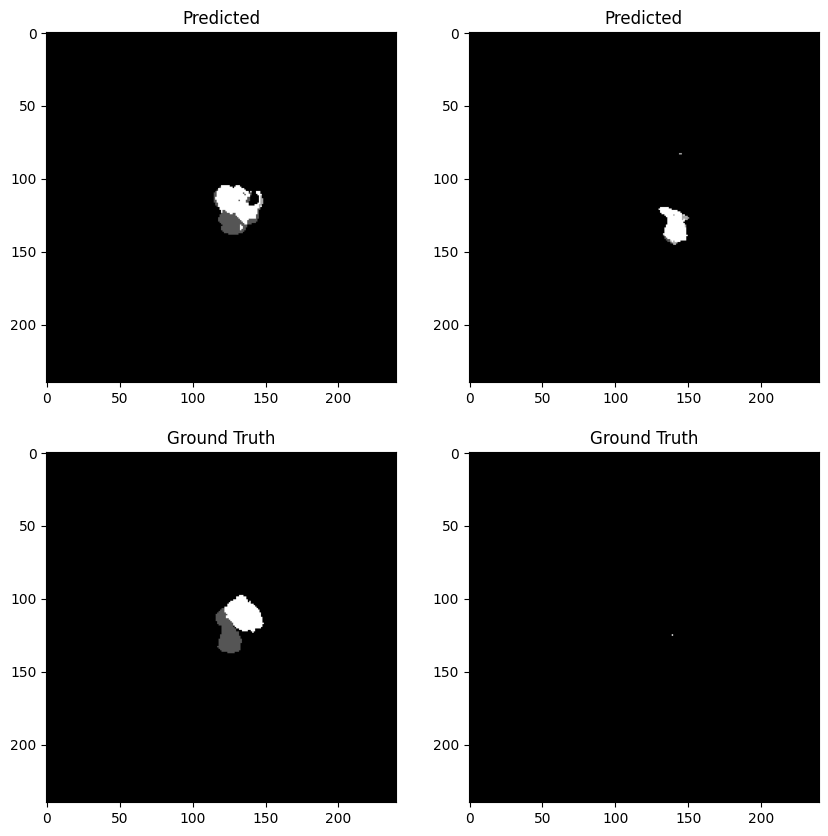

100%|██████████| 181/181 [08:46<00:00,  2.91s/it]



Average Training Loss: 0.024838345547242718

Average Training DSC: [0.99795892 0.43215188 0.49418348 0.42340257]
Average Training ASSD: [  0.32485047 124.17316902 142.19992192  43.70436093]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


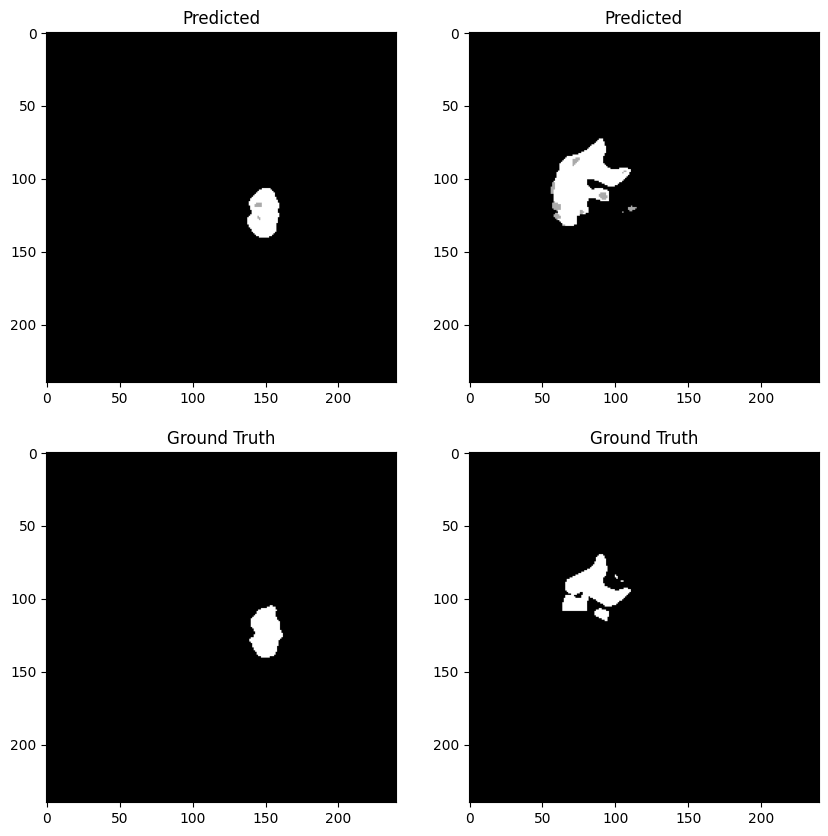

100%|██████████| 46/46 [01:27<00:00,  1.91s/it]


Average Validation Loss: 0.0492260264556693

Average Validation DSC: [0.99425686 0.37584799 0.2335828  0.37193842]
Average Validation ASSD: [  1.35112108 141.6758686  223.96913385  21.41513824]
Epoch 15/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


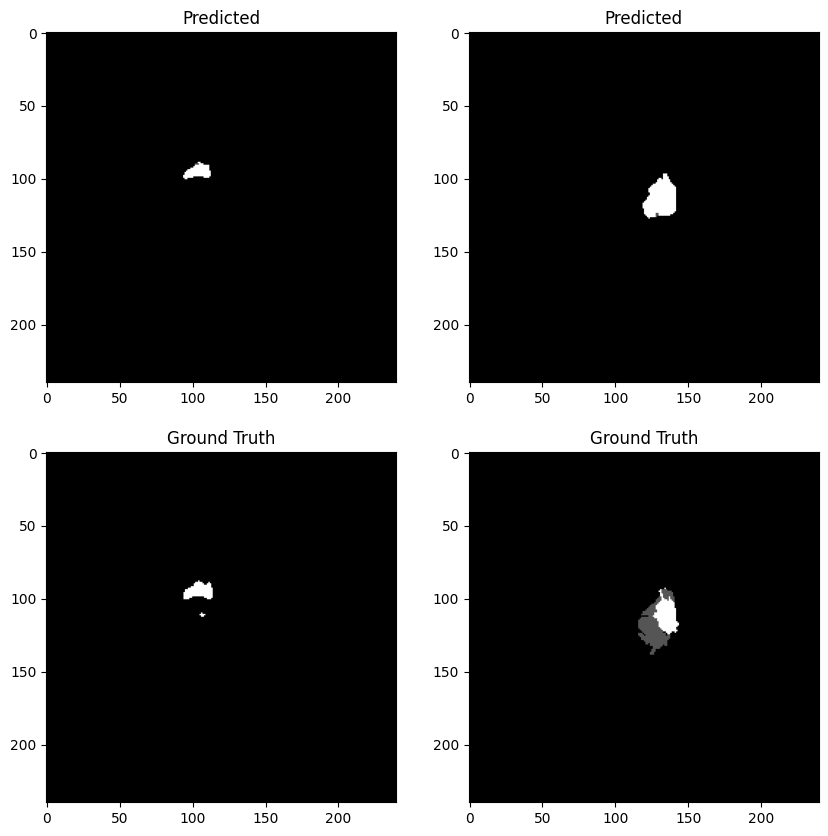

100%|██████████| 181/181 [08:46<00:00,  2.91s/it]



Average Training Loss: 0.022828690203431562

Average Training DSC: [0.99802625 0.42196114 0.65949569 0.45983666]
Average Training ASSD: [  0.31546498 132.45388447  91.40951394  39.01510208]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


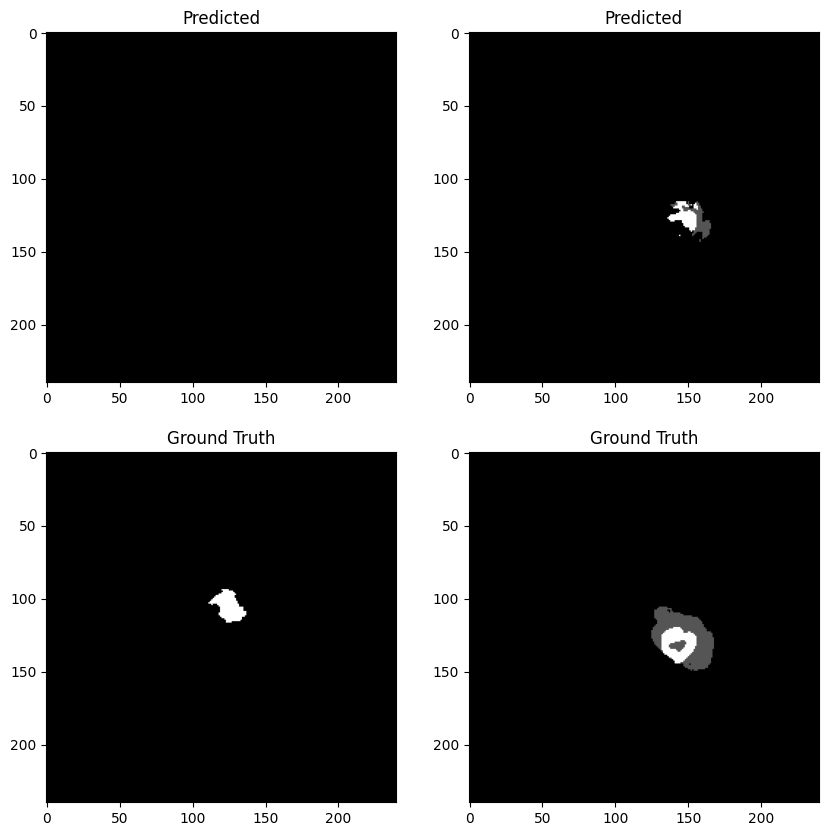

100%|██████████| 46/46 [01:23<00:00,  1.81s/it]


Average Validation Loss: 0.07312890429697606

Average Validation DSC: [0.9921235  0.49481406 0.76437097 0.08519884]
Average Validation ASSD: [  2.72989455 111.72356358  56.15438202 232.80364144]
Epoch 16/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


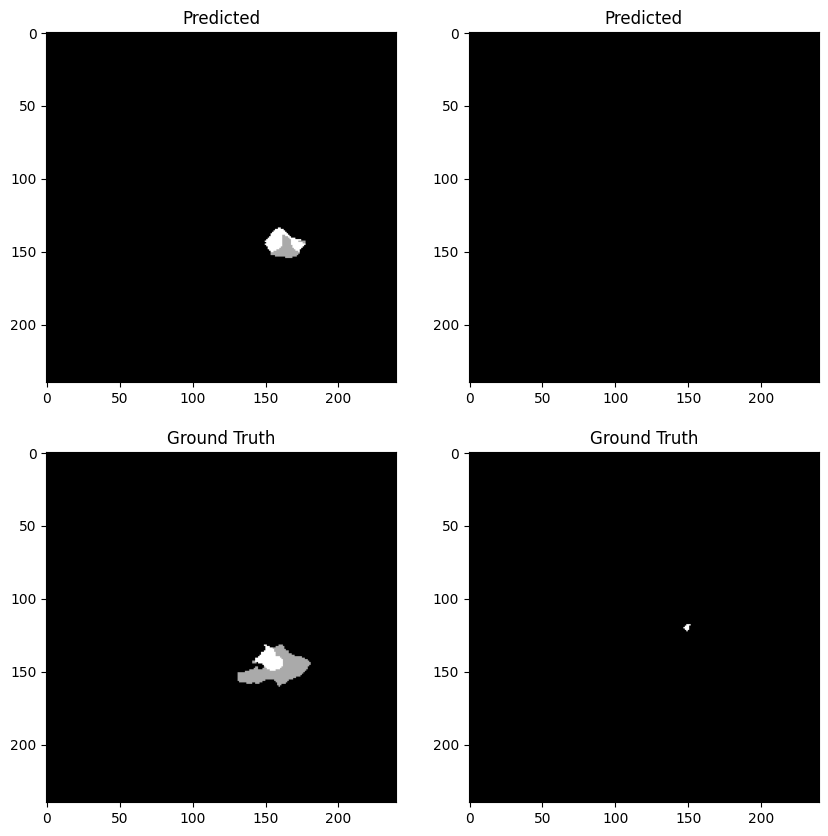

100%|██████████| 181/181 [08:46<00:00,  2.91s/it]



Average Training Loss: 0.019710340820129405

Average Training DSC: [0.99829416 0.45648491 0.72255338 0.50472142]
Average Training ASSD: [  0.27543102 126.66031667  73.71066204  33.4356186 ]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


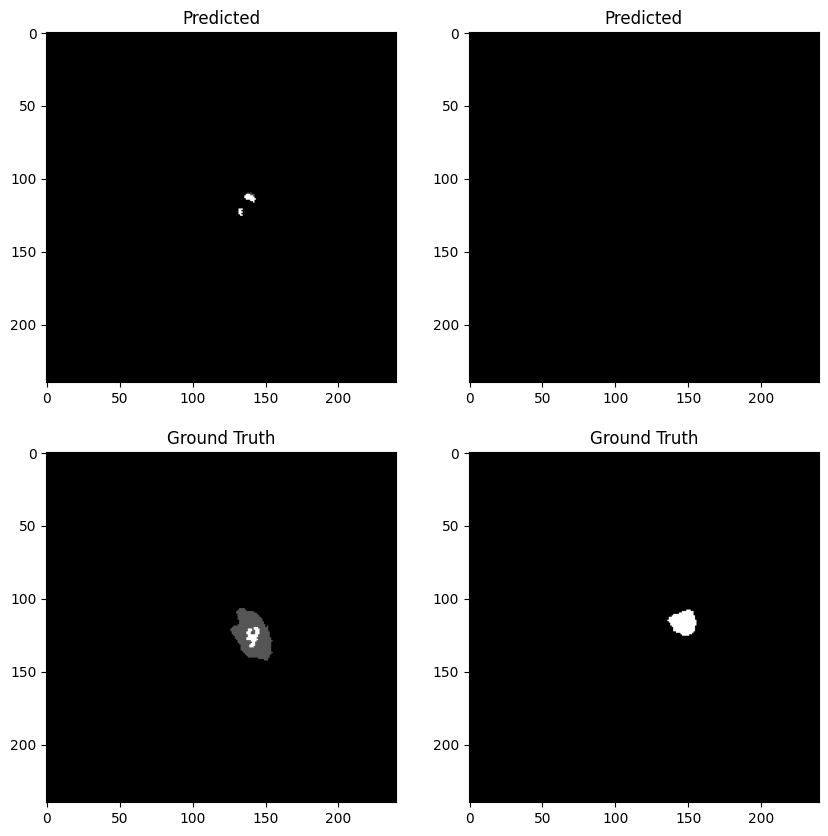

100%|██████████| 46/46 [01:22<00:00,  1.79s/it]


Average Validation Loss: 0.05510546639561653

Average Validation DSC: [0.99375376 0.52957438 0.78685125 0.15155348]
Average Validation ASSD: [  1.93839909  96.8828256   44.34054148 185.87012245]
Epoch 17/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


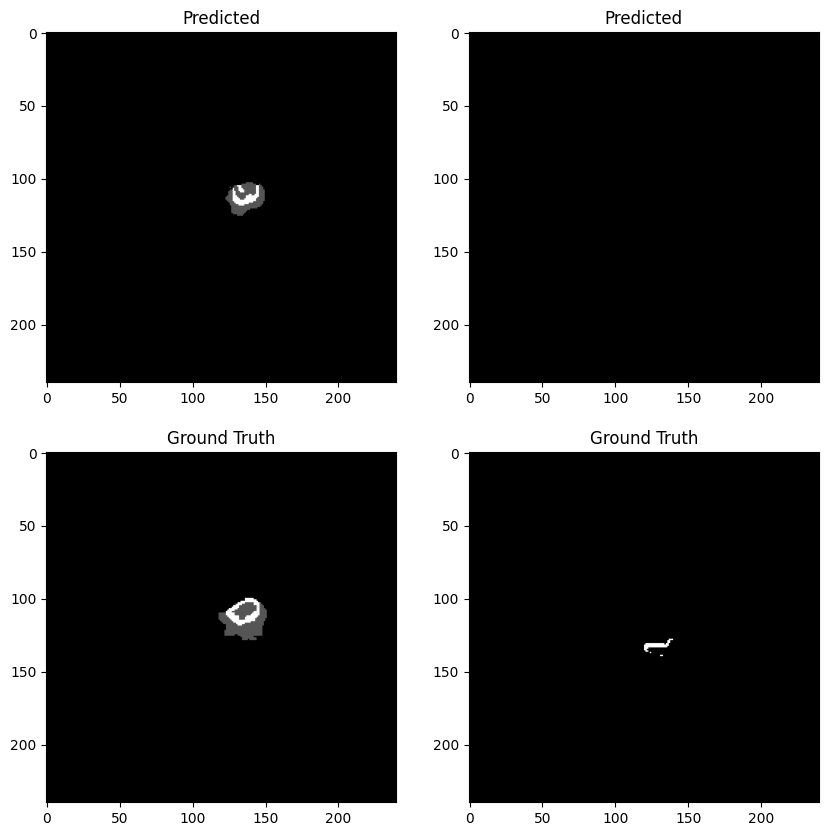

100%|██████████| 181/181 [08:45<00:00,  2.90s/it]



Average Training Loss: 0.01832262730709591

Average Training DSC: [0.99835786 0.50027852 0.74566266 0.54372824]
Average Training ASSD: [  0.26222903 118.76087972  67.93724704  30.98434912]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


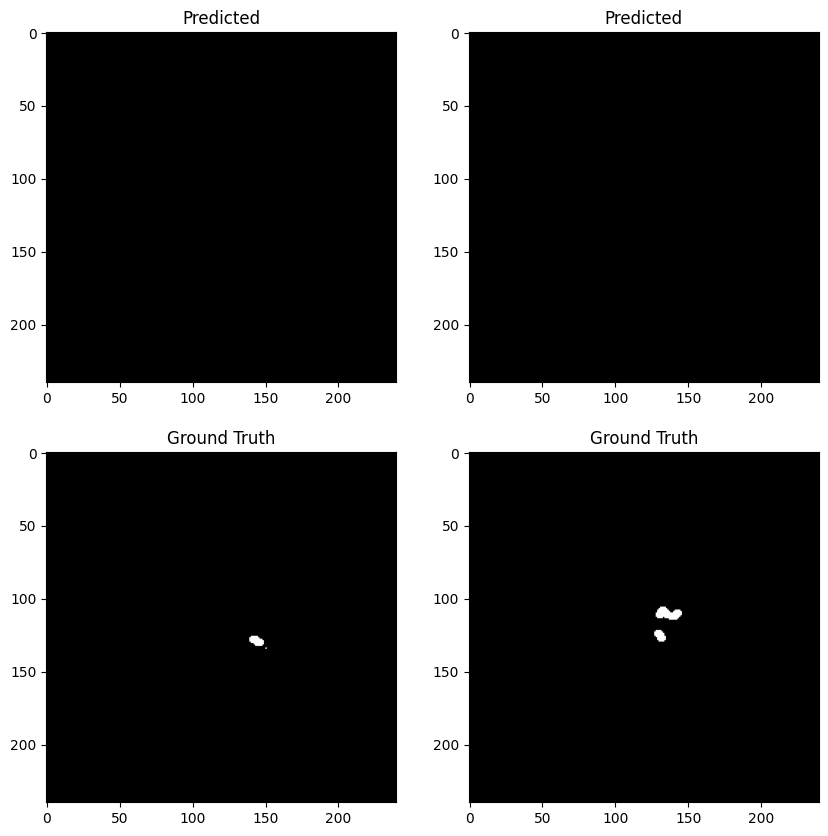

100%|██████████| 46/46 [01:23<00:00,  1.81s/it]


Average Validation Loss: 0.07915067599843377

Average Validation DSC: [0.99251723 0.45573038 0.73219153 0.18104891]
Average Validation ASSD: [  2.19371947 127.60809839  65.17747705 166.60853236]
Epoch 18/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


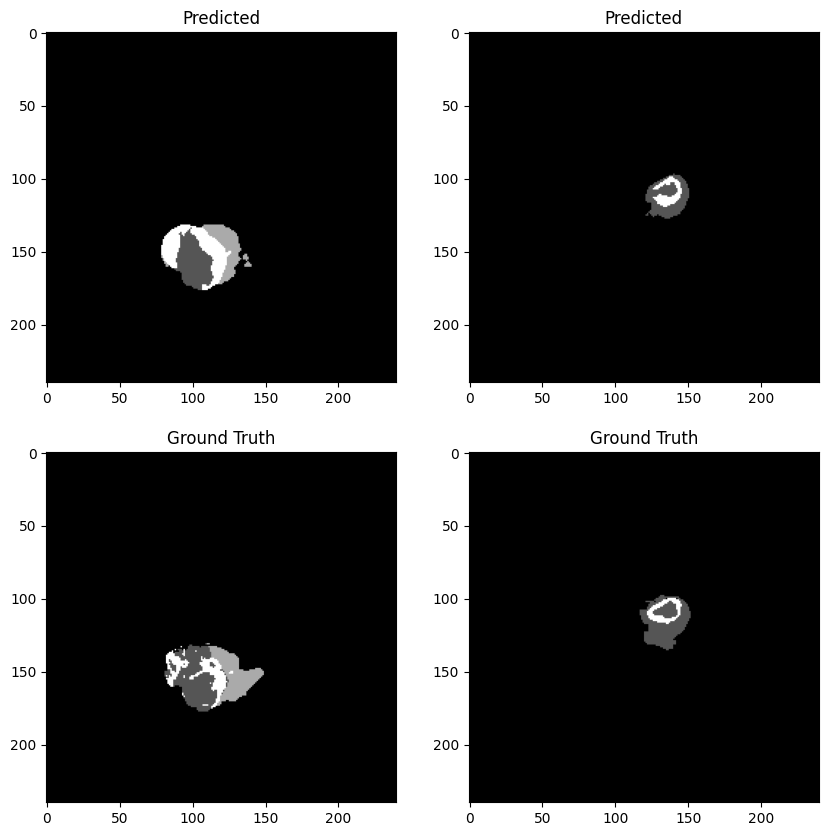

100%|██████████| 181/181 [09:13<00:00,  3.06s/it]



Average Training Loss: 0.015551057404925975

Average Training DSC: [0.99856655 0.58454067 0.80837323 0.58910652]
Average Training ASSD: [ 0.21089137 98.08332809 48.06544684 26.52876806]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


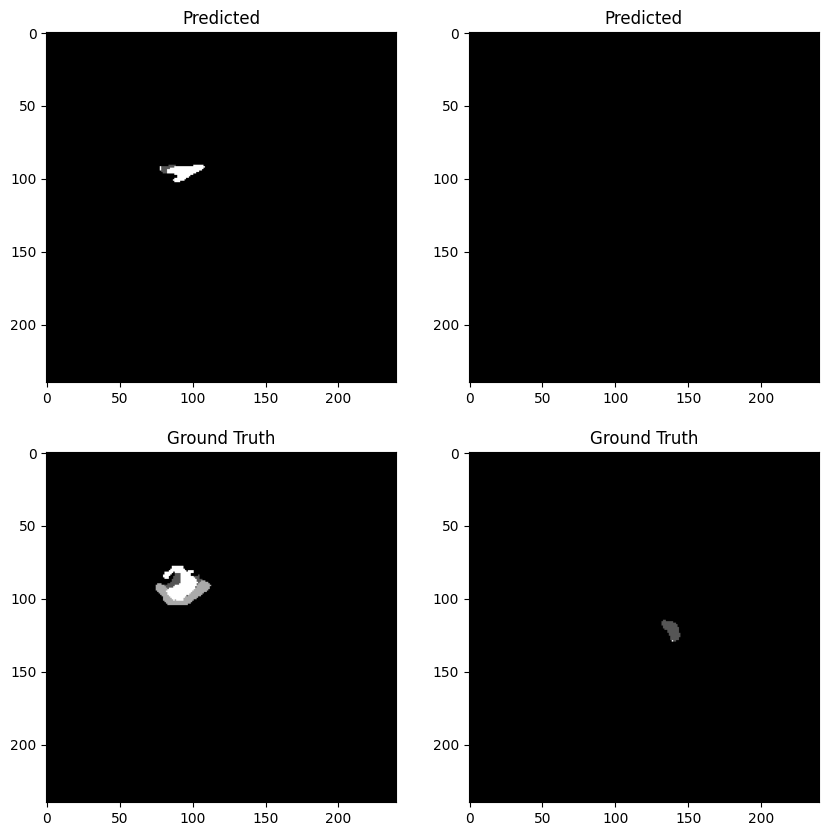

100%|██████████| 46/46 [01:33<00:00,  2.02s/it]


Average Validation Loss: 0.035395457854737404

Average Validation DSC: [0.99645169 0.44815071 0.81737928 0.22127737]
Average Validation ASSD: [  0.63236319 138.9962893   30.9036444  130.47302024]
Epoch 19/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


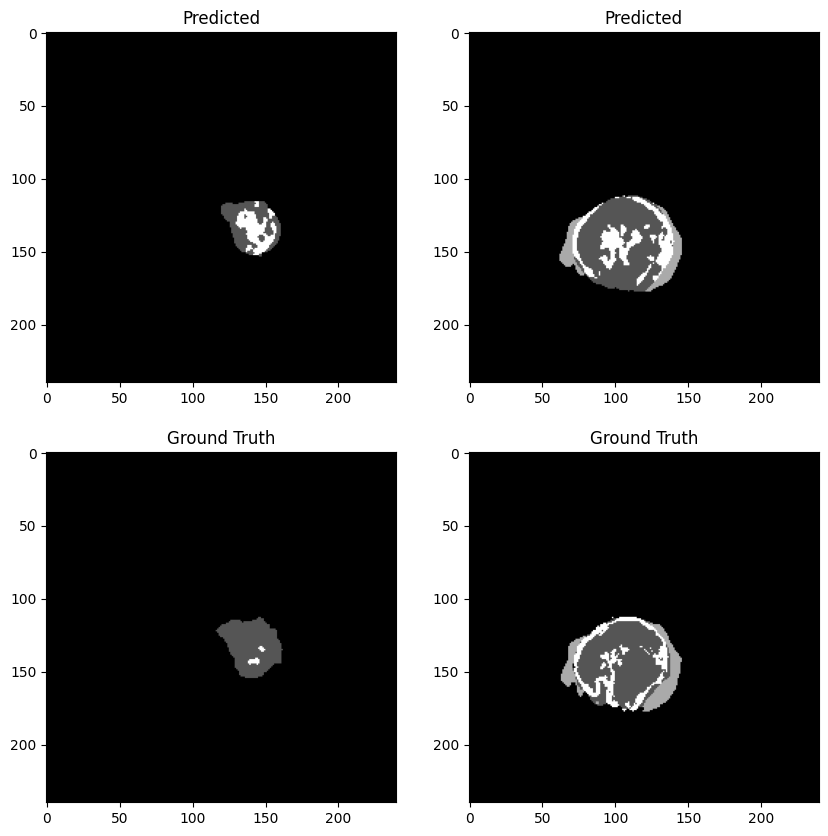

100%|██████████| 181/181 [09:31<00:00,  3.16s/it]



Average Training Loss: 0.01419546054830538

Average Training DSC: [0.99866258 0.6441045  0.83047171 0.61161951]
Average Training ASSD: [ 0.19690537 80.22361349 41.32844633 25.95329767]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


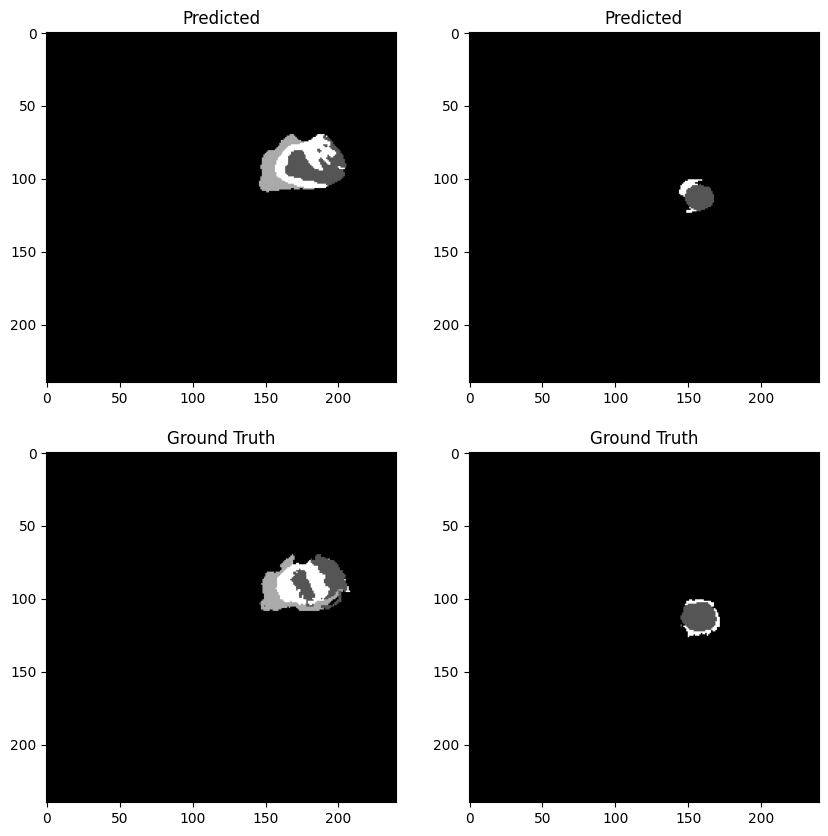

100%|██████████| 46/46 [01:33<00:00,  2.03s/it]


Average Validation Loss: 0.013631855335046092

Average Validation DSC: [0.99857972 0.67536009 0.86427711 0.59899238]
Average Validation ASSD: [ 0.2408048  72.68836572 31.63275758 37.14383736]
Epoch 20/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


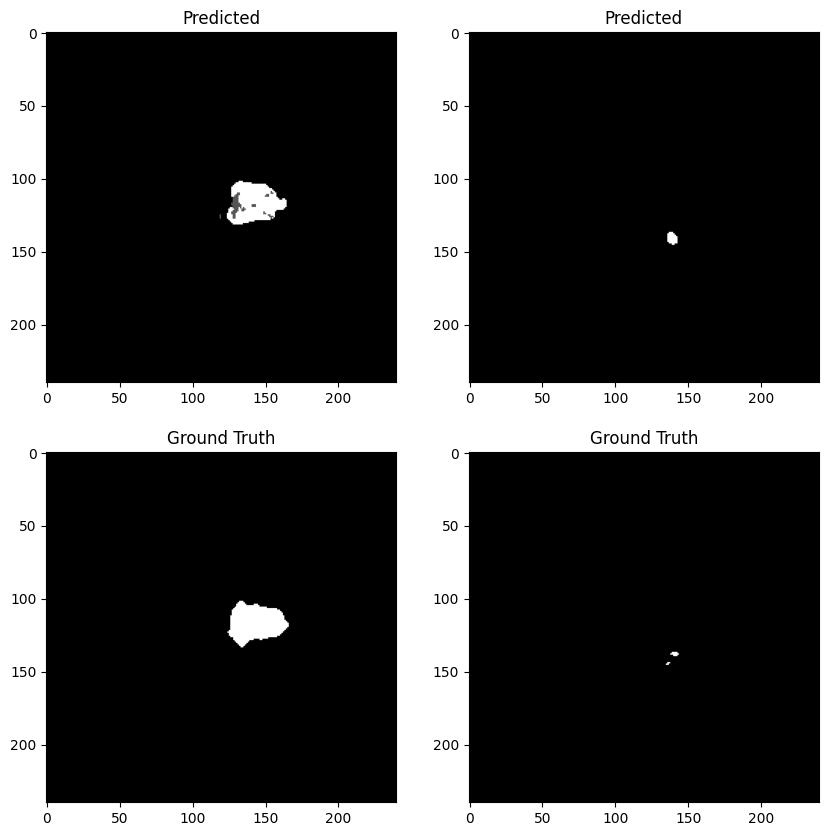

100%|██████████| 181/181 [09:12<00:00,  3.05s/it]



Average Training Loss: 0.01292485662463291

Average Training DSC: [0.99868896 0.69893894 0.84425937 0.64506861]
Average Training ASSD: [ 0.19046894 66.17743182 37.91375872 24.11736114]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


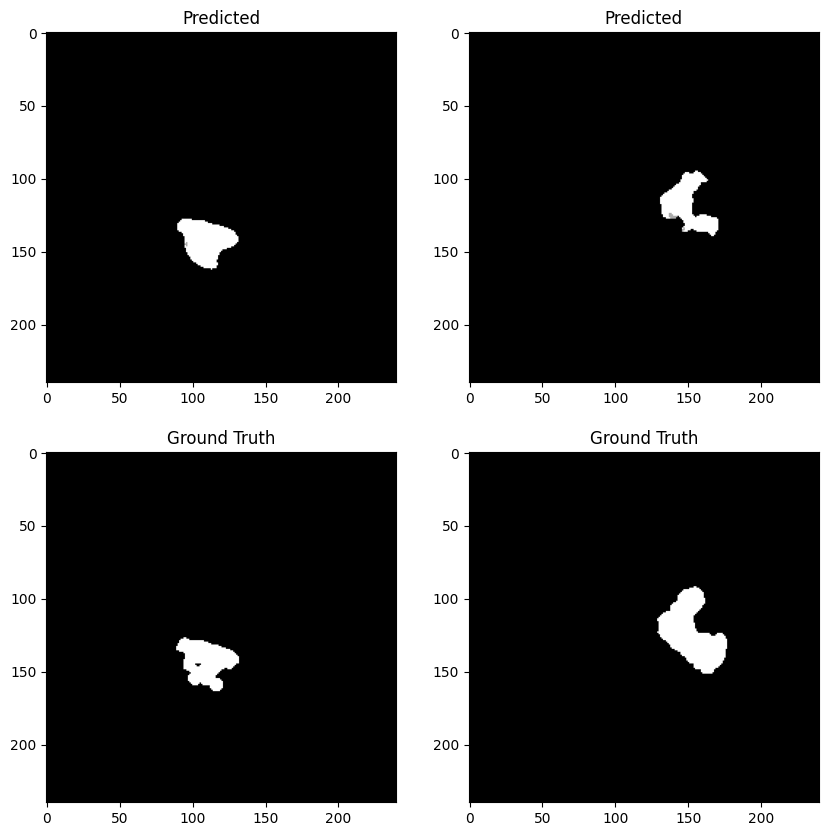

100%|██████████| 46/46 [01:37<00:00,  2.12s/it]


Average Validation Loss: 0.01406970077558704

Average Validation DSC: [0.9986131  0.7334991  0.746056   0.63692651]
Average Validation ASSD: [ 0.22649803 46.85694197 70.90350412 23.39959912]
Epoch 21/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


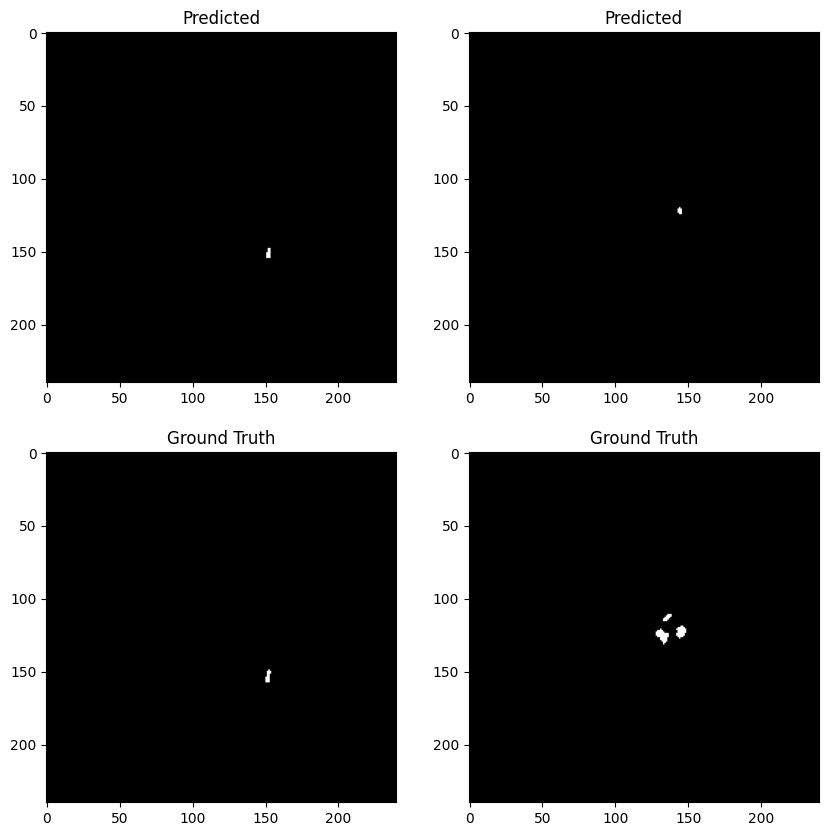

100%|██████████| 181/181 [09:07<00:00,  3.03s/it]



Average Training Loss: 0.012218542240086675

Average Training DSC: [0.99876095 0.74529729 0.86787983 0.65831488]
Average Training ASSD: [ 0.17981422 52.54613381 29.39355267 24.65907798]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


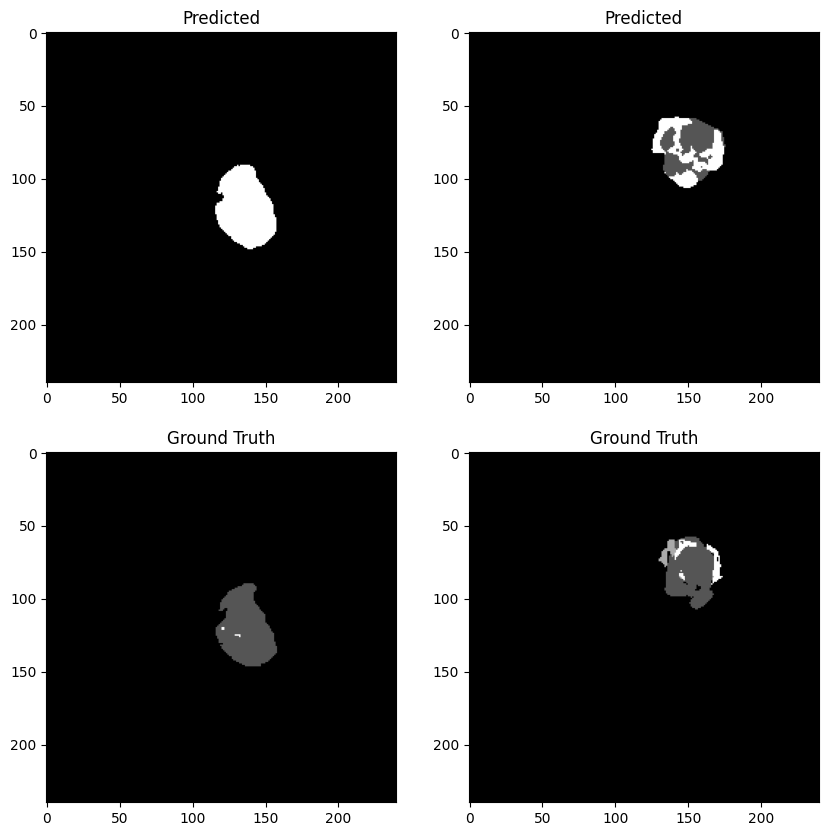

100%|██████████| 46/46 [01:34<00:00,  2.05s/it]


Average Validation Loss: 0.017107628346623285

Average Validation DSC: [0.99797447 0.68044508 0.75635003 0.62936346]
Average Validation ASSD: [ 0.41817294 73.32748839 65.16821435  8.31822318]
Epoch 22/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


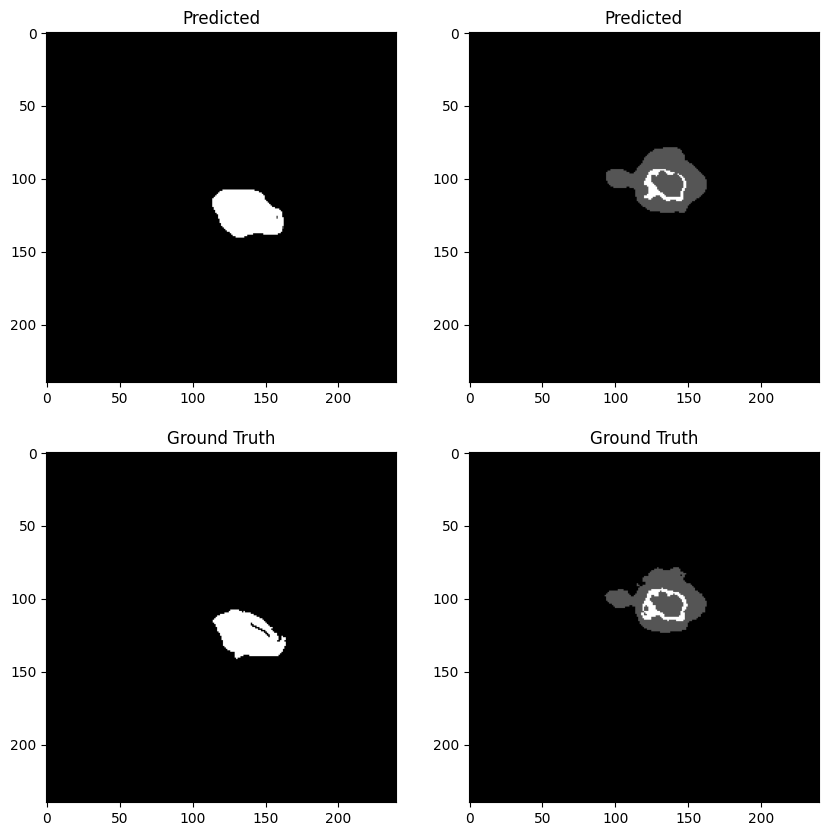

100%|██████████| 181/181 [09:10<00:00,  3.04s/it]



Average Training Loss: 0.011374137384909623

Average Training DSC: [0.99882559 0.7591149  0.88118966 0.67427736]
Average Training ASSD: [ 0.16089293 48.82006572 25.85165046 22.28362463]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


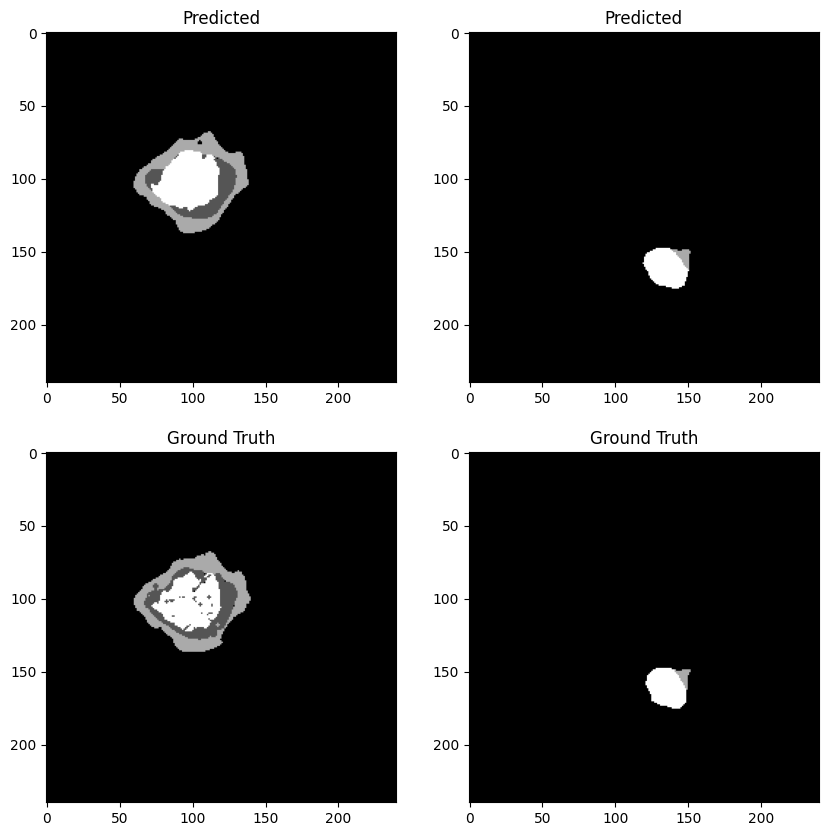

100%|██████████| 46/46 [01:26<00:00,  1.89s/it]


Average Validation Loss: 0.01599649497834237

Average Validation DSC: [0.99850489 0.74424718 0.88006915 0.60742423]
Average Validation ASSD: [ 0.28364052 36.16816635 24.99766141 36.93697176]
Epoch 23/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


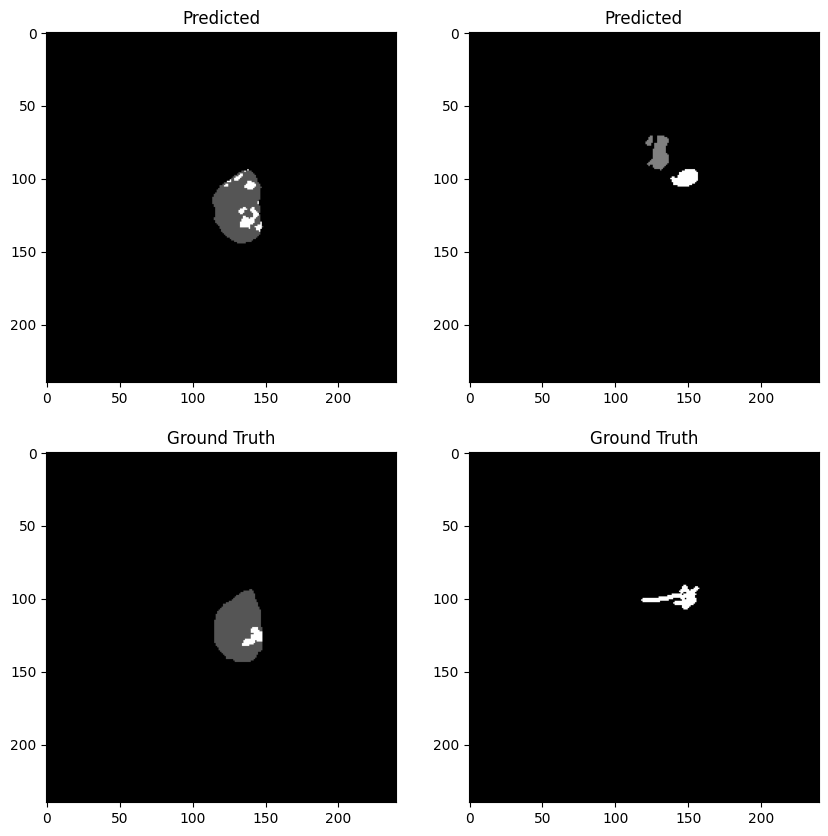

100%|██████████| 181/181 [08:59<00:00,  2.98s/it]



Average Training Loss: 0.010908894047902599

Average Training DSC: [0.99886739 0.77981637 0.88671445 0.68716354]
Average Training ASSD: [ 0.15990489 44.02292939 23.66116648 22.64789497]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


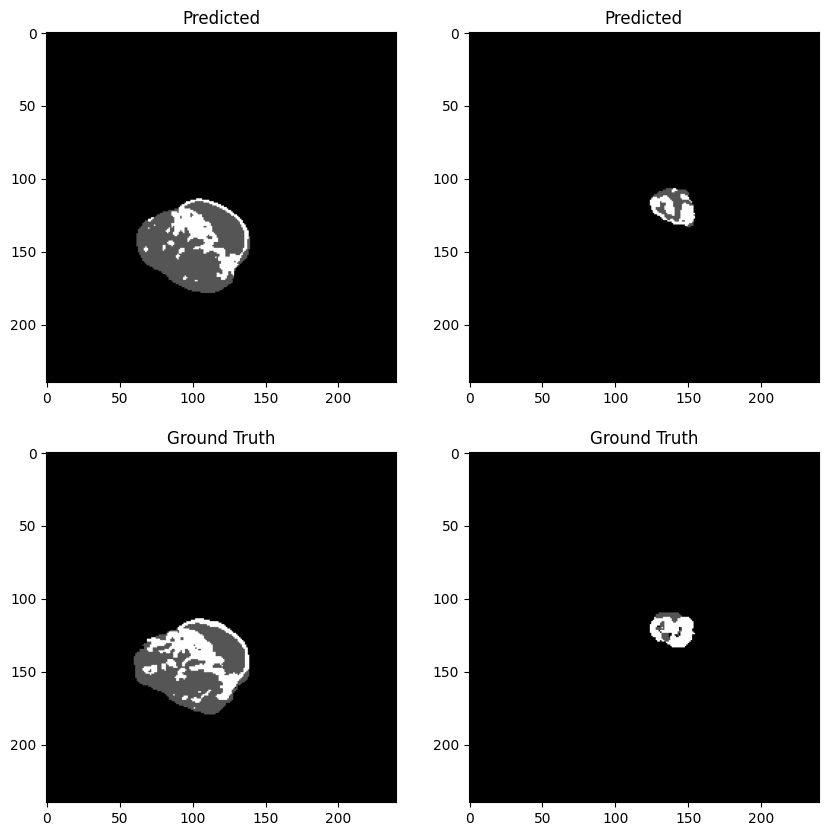

100%|██████████| 46/46 [01:27<00:00,  1.89s/it]


Average Validation Loss: 0.015400326304623613

Average Validation DSC: [0.99843372 0.66347788 0.84937023 0.60683778]
Average Validation ASSD: [ 0.35695091 75.15944006 32.94872849 22.1325025 ]
Epoch 24/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


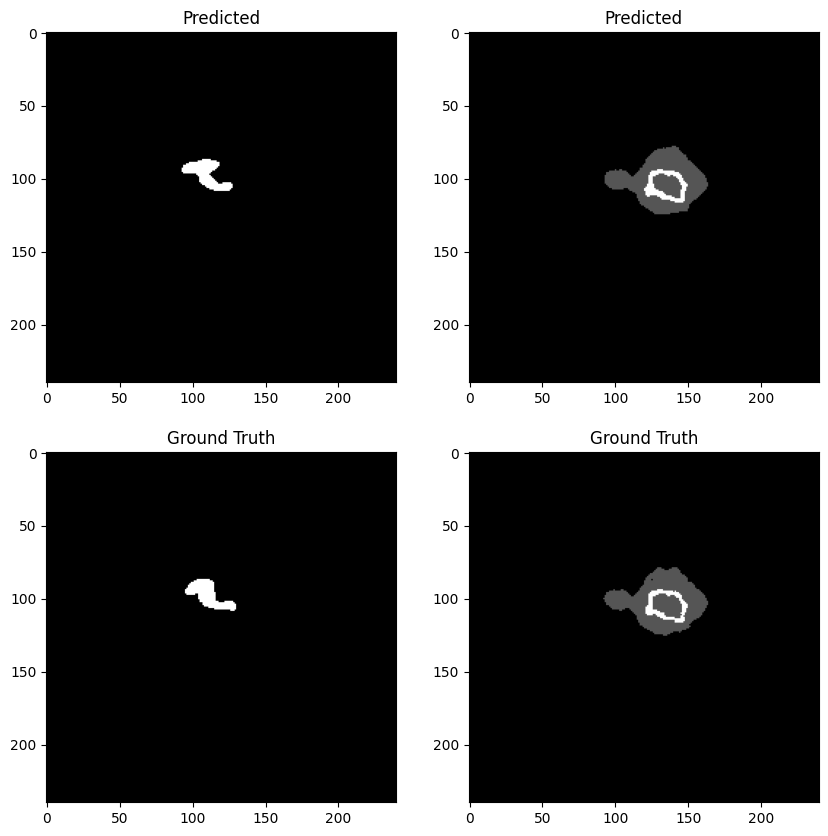

100%|██████████| 181/181 [09:06<00:00,  3.02s/it]



Average Training Loss: 0.010674971467120707

Average Training DSC: [0.99888318 0.79237134 0.88273535 0.69491647]
Average Training ASSD: [ 0.15469842 39.34805053 24.75206158 21.58836414]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


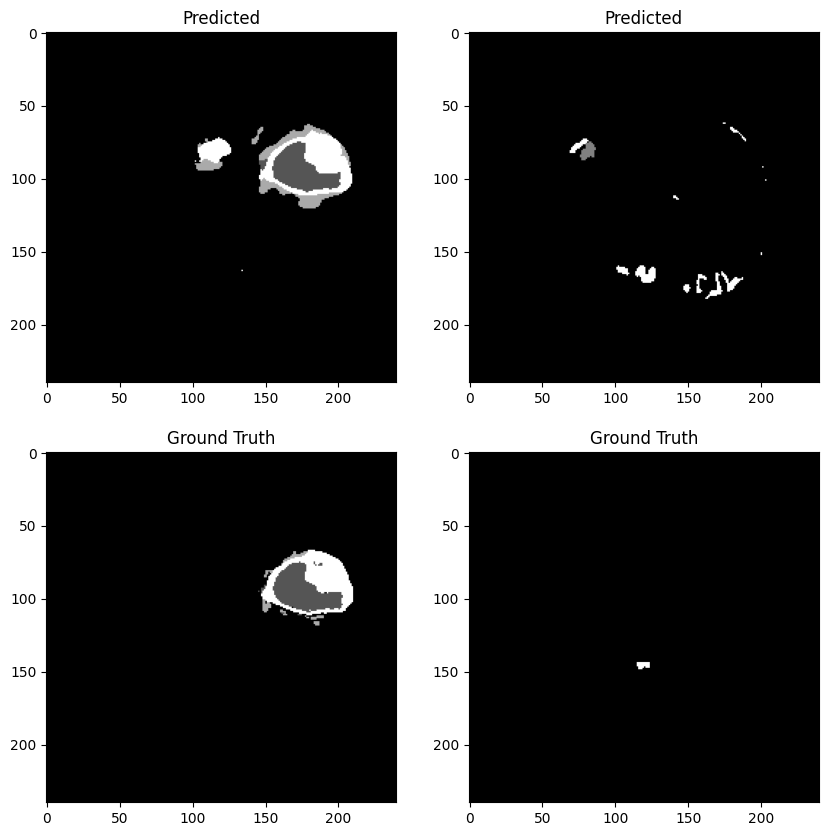

100%|██████████| 46/46 [01:38<00:00,  2.13s/it]


Average Validation Loss: 0.06100769762111747

Average Validation DSC: [0.99025772 0.48444477 0.14181482 0.50711325]
Average Validation ASSD: [  2.94606638 123.71591199 272.17450113  10.48659419]
Epoch 25/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


100%|██████████| 181/181 [09:05<00:00,  3.01s/it]



Average Training Loss: 0.009629975142502818

Average Training DSC: [0.998947   0.8157545  0.90528311 0.71290313]
Average Training ASSD: [ 0.14284082 33.2110909  17.78924709 22.54205178]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


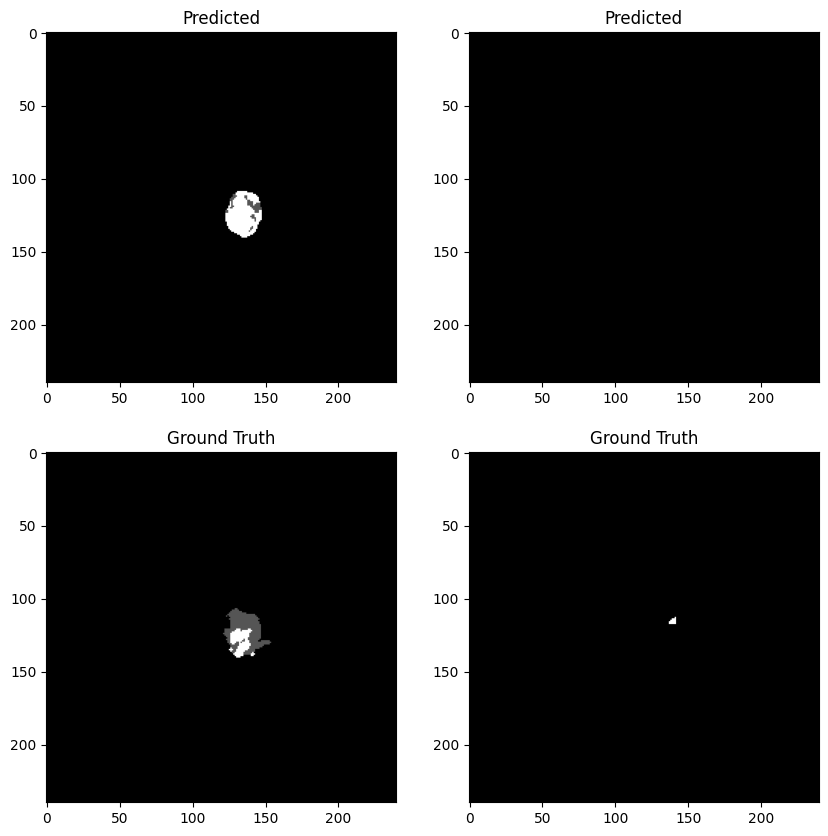

100%|██████████| 46/46 [01:29<00:00,  1.93s/it]


Average Validation Loss: 0.010964681900551786

Average Validation DSC: [0.99892135 0.82022505 0.90502593 0.71348492]
Average Validation ASSD: [ 0.15233421 23.66973108 15.82412102 19.78211308]
Epoch 26/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


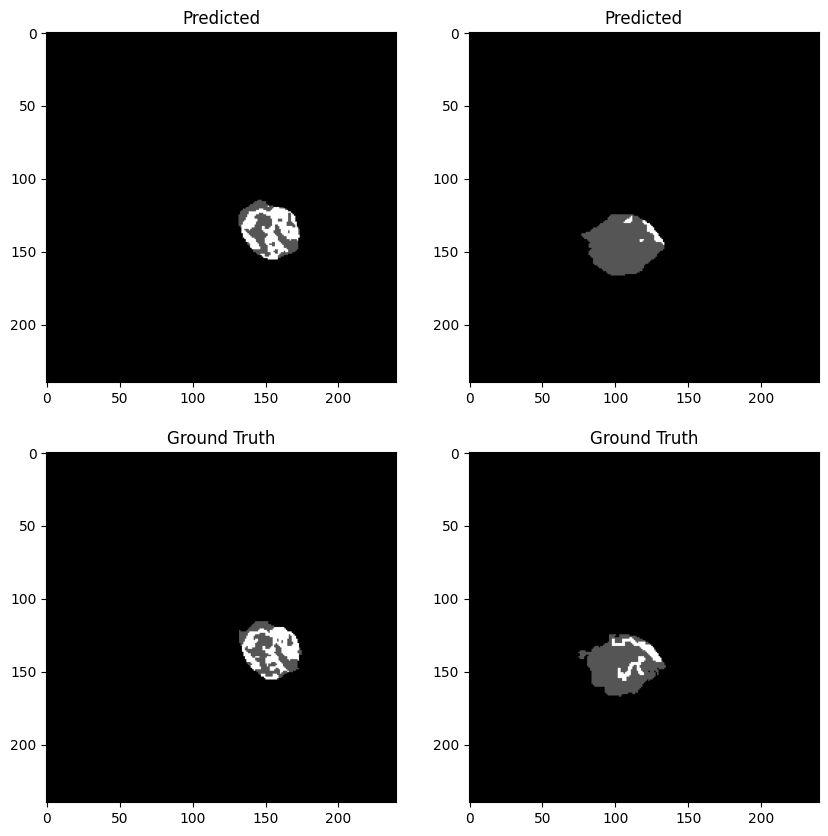

100%|██████████| 181/181 [09:00<00:00,  2.98s/it]



Average Training Loss: 0.009035283406342262

Average Training DSC: [0.99902745 0.83252074 0.91179815 0.72113306]
Average Training ASSD: [ 0.13103702 28.27722393 16.20135337 21.35392844]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


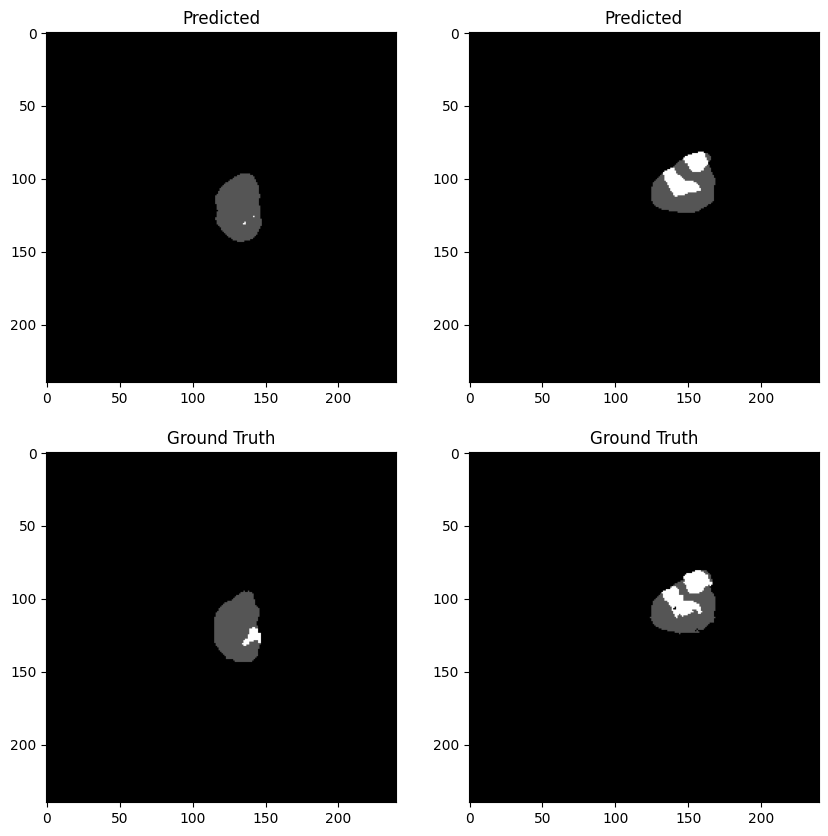

100%|██████████| 46/46 [01:28<00:00,  1.91s/it]


Average Validation Loss: 0.018566388515350613

Average Validation DSC: [0.99799843 0.69670257 0.88919465 0.46871208]
Average Validation ASSD: [ 0.34628527 64.80675337 17.86362964 68.9895186 ]
Epoch 27/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


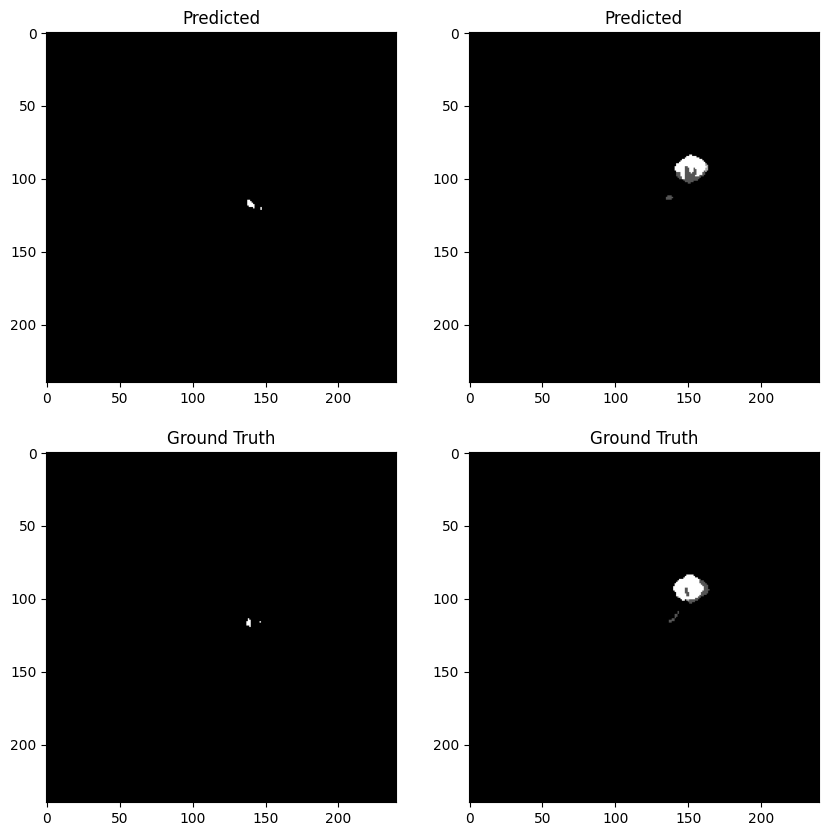

100%|██████████| 181/181 [09:01<00:00,  2.99s/it]



Average Training Loss: 0.008683788312280047

Average Training DSC: [0.99904181 0.84364846 0.91585879 0.73443175]
Average Training ASSD: [ 0.12936894 26.55801358 15.4186345  21.35082501]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


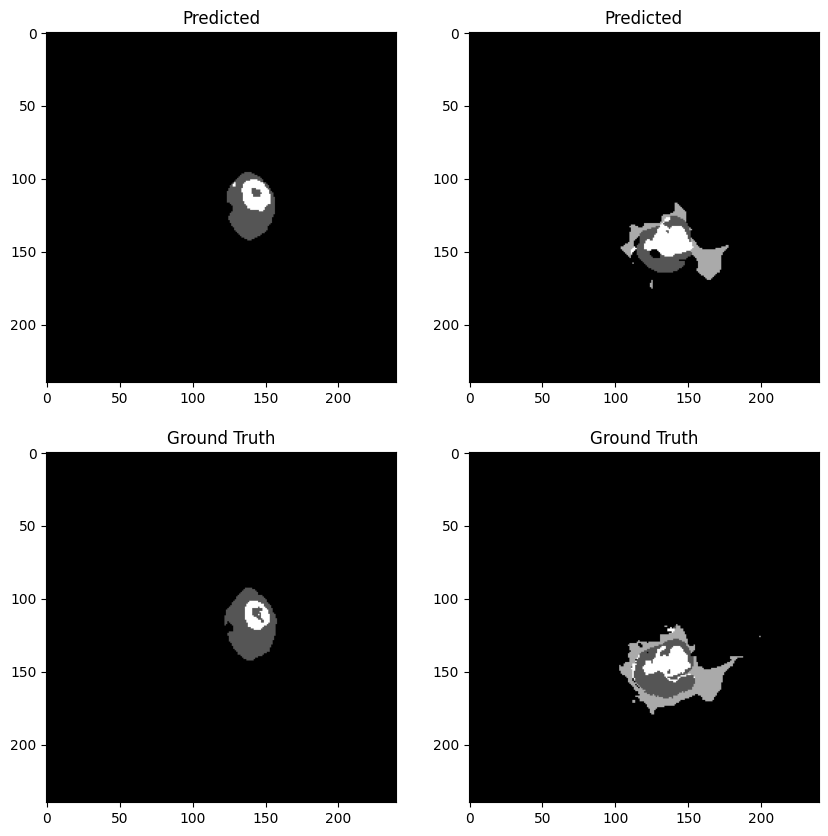

100%|██████████| 46/46 [01:27<00:00,  1.91s/it]


Average Validation Loss: 0.01283466585142457

Average Validation DSC: [0.99861226 0.80619796 0.91114088 0.66365947]
Average Validation ASSD: [ 0.21585042 25.39023872 11.02669108 31.17453447]
Epoch 28/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


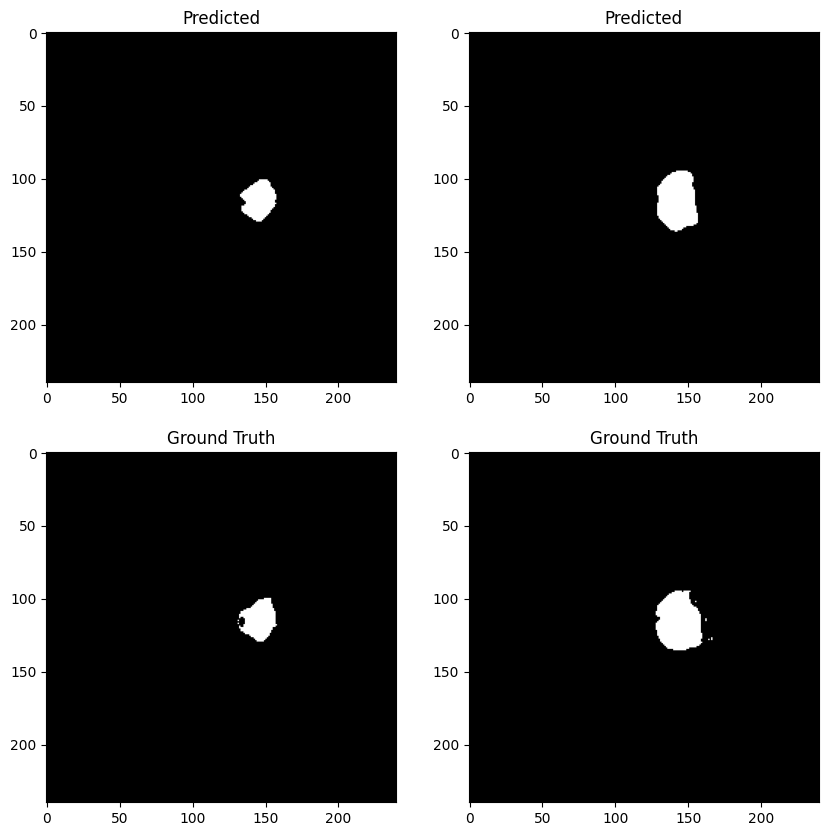

100%|██████████| 181/181 [08:53<00:00,  2.95s/it]



Average Training Loss: 0.008208707137064217

Average Training DSC: [0.99909109 0.8514626  0.92246669 0.74534192]
Average Training ASSD: [ 0.12121023 24.71409989 13.82057767 20.16944793]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


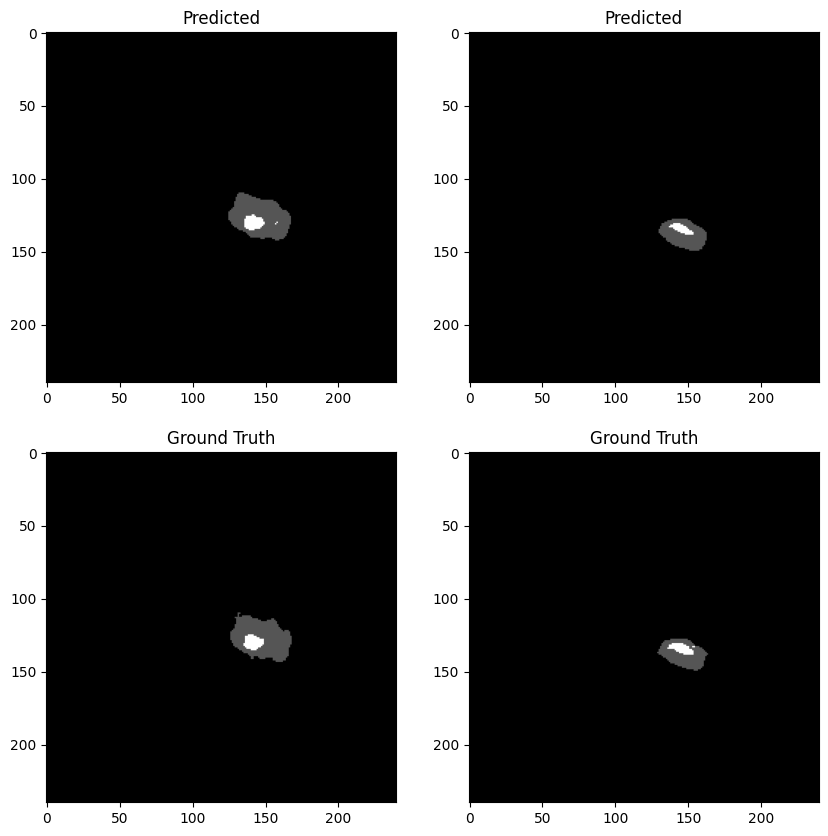

100%|██████████| 46/46 [01:26<00:00,  1.89s/it]


Average Validation Loss: 0.010916146692698416

Average Validation DSC: [0.99884006 0.82020685 0.91700951 0.70313093]
Average Validation ASSD: [ 0.15682335 32.74478631 11.89481511 21.57288046]
Epoch 29/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


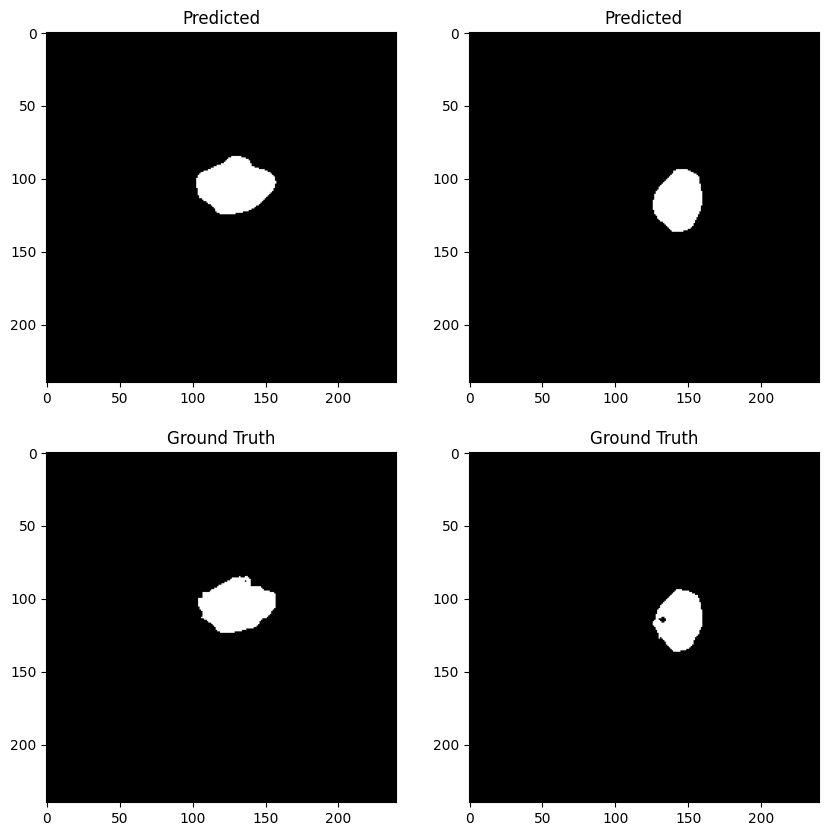

100%|██████████| 181/181 [08:54<00:00,  2.95s/it]



Average Training Loss: 0.008276455151946258

Average Training DSC: [0.99909954 0.8481271  0.91701501 0.74693118]
Average Training ASSD: [ 0.11891792 25.47004276 15.9701769  19.55735358]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


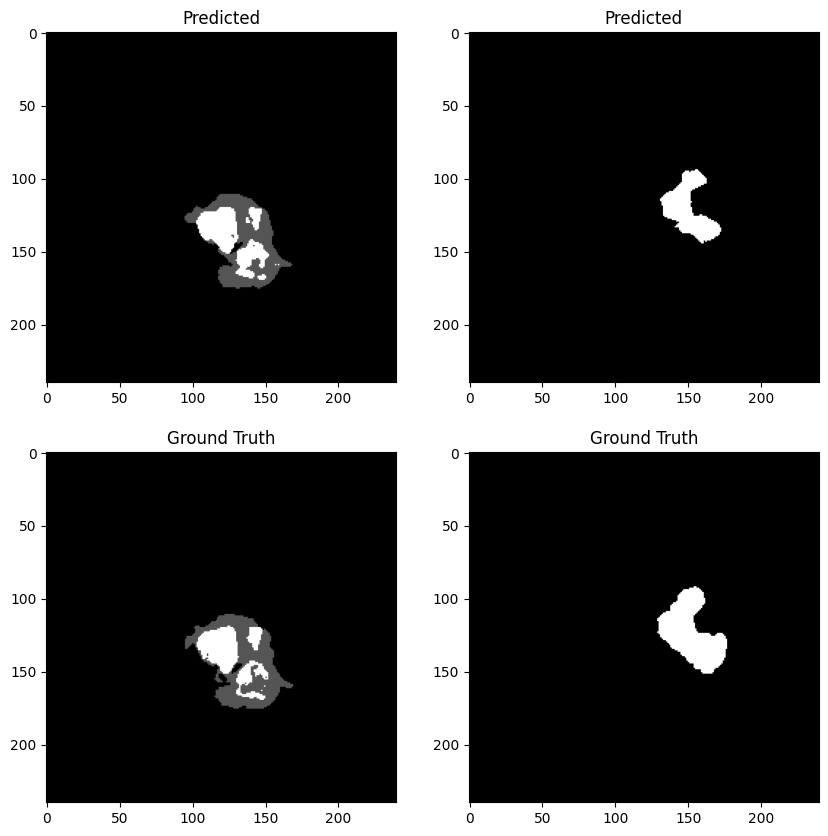

100%|██████████| 46/46 [01:29<00:00,  1.95s/it]


Average Validation Loss: 0.018008559517076483

Average Validation DSC: [0.99803153 0.78001714 0.89388141 0.6146279 ]
Average Validation ASSD: [ 0.35477005 34.97190587 15.95065104 29.79269741]
Epoch 30/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


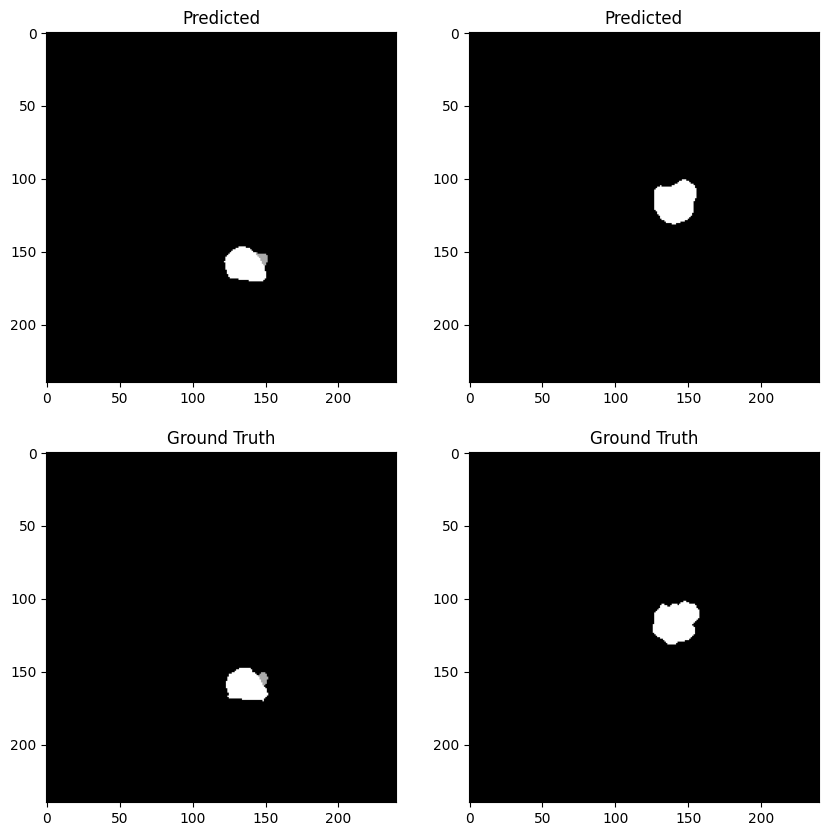

100%|██████████| 181/181 [08:51<00:00,  2.94s/it]



Average Training Loss: 0.007818136058068572

Average Training DSC: [0.99912398 0.86749651 0.91886392 0.75665852]
Average Training ASSD: [ 0.11877145 20.026857   14.80916312 20.25831938]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [01:29<00:00,  1.94s/it]


Average Validation Loss: 0.03323567136312309

Average Validation DSC: [0.99539269 0.51048147 0.2936426  0.55573287]
Average Validation ASSD: [  1.9291804  119.16302358 220.25304171  10.44453252]
Epoch 31/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


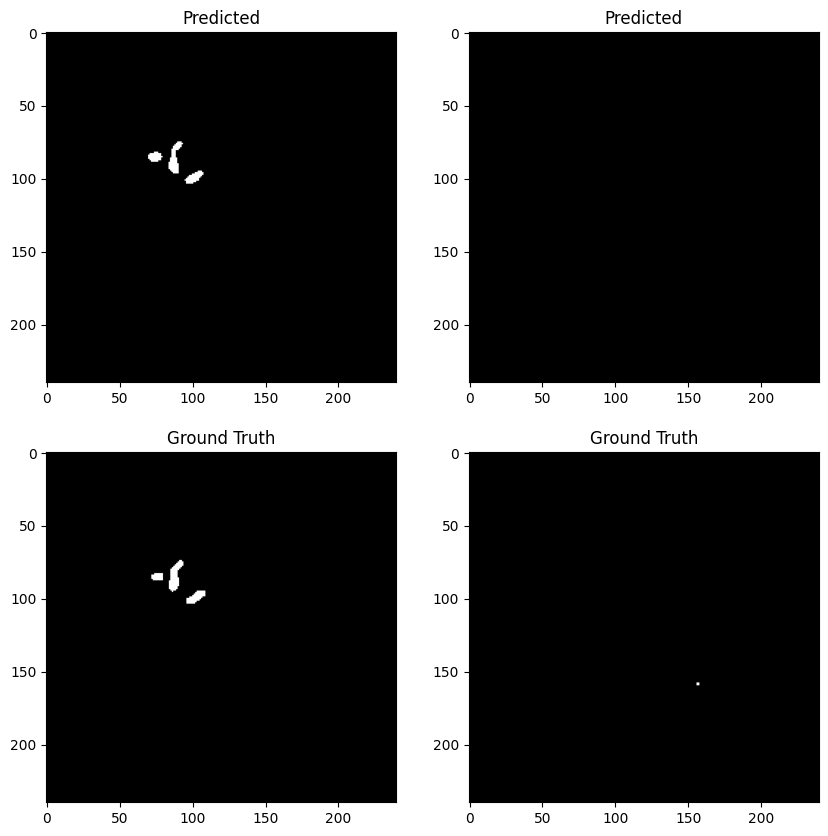

100%|██████████| 181/181 [08:48<00:00,  2.92s/it]



Average Training Loss: 0.00803357137891963

Average Training DSC: [0.9990924  0.8625296  0.91710084 0.75580766]
Average Training ASSD: [ 0.12076311 21.60070311 15.38801084 18.79281243]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


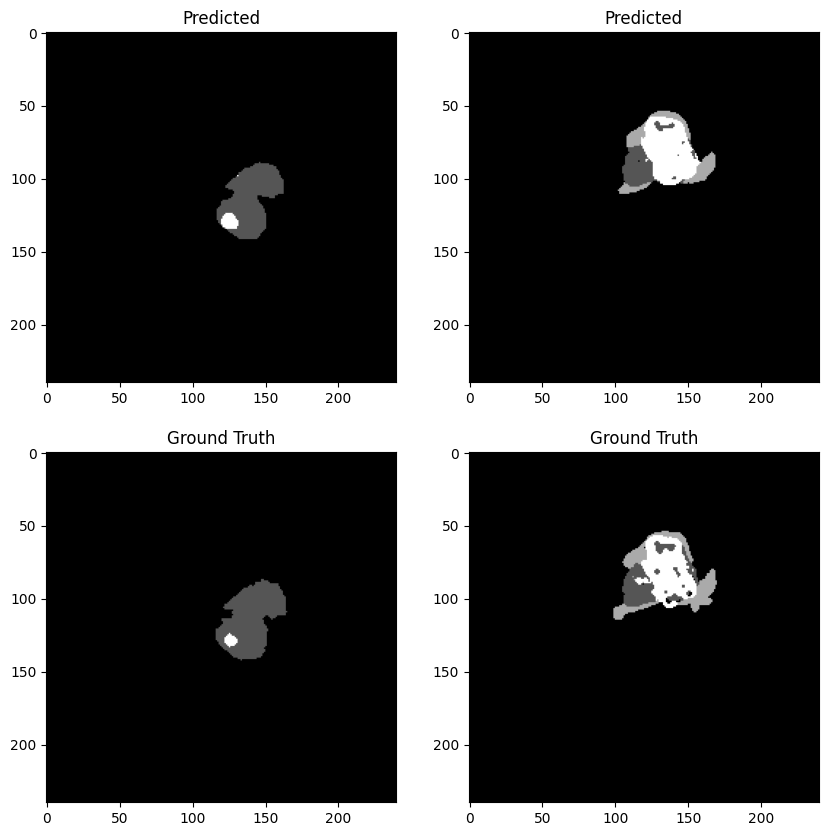

100%|██████████| 46/46 [01:29<00:00,  1.94s/it]


Average Validation Loss: 0.010435392290515743

Average Validation DSC: [0.99894708 0.83058121 0.91745878 0.72773485]
Average Validation ASSD: [ 0.15039359 27.20272991 11.49625043 16.66053427]
Epoch 32/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


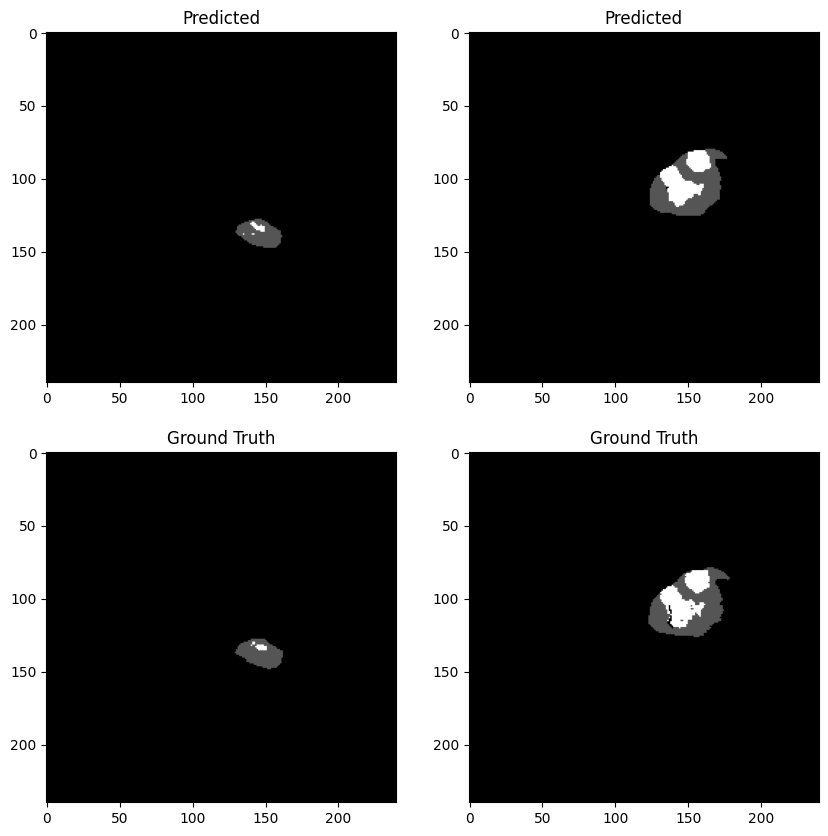

100%|██████████| 181/181 [08:48<00:00,  2.92s/it]



Average Training Loss: 0.007698911810756882

Average Training DSC: [0.99915811 0.86853977 0.91980304 0.76175001]
Average Training ASSD: [ 0.111653   20.25800175 15.37060761 18.33437732]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


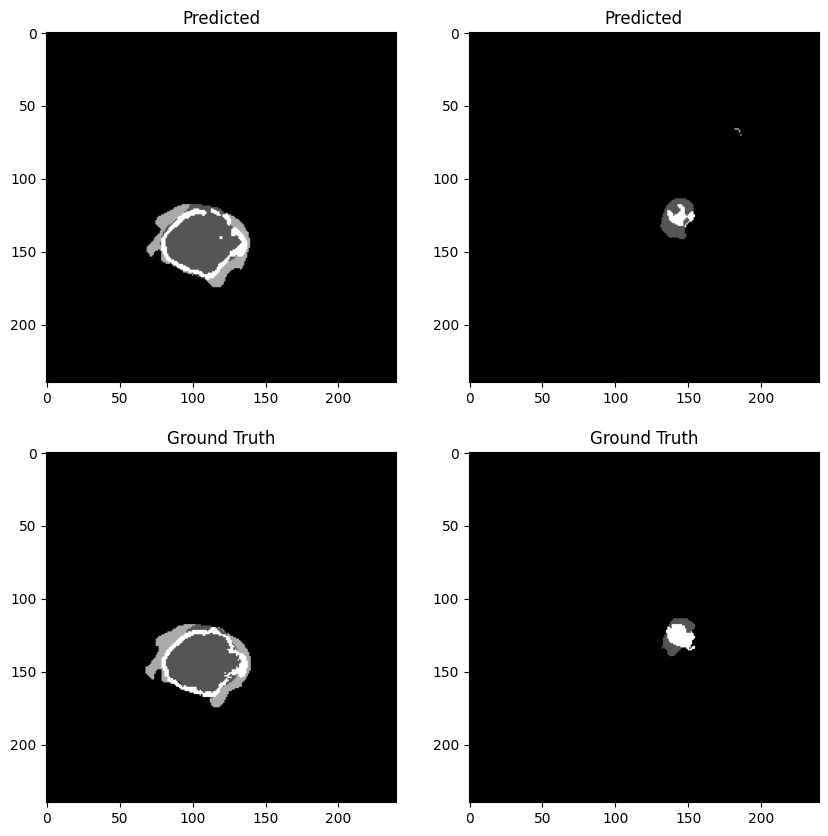

100%|██████████| 46/46 [01:29<00:00,  1.94s/it]


Average Validation Loss: 0.013184585001157679

Average Validation DSC: [0.99847681 0.64502353 0.77372708 0.68387702]
Average Validation ASSD: [ 0.44651877 91.89303892 61.46373734 14.89749217]
Epoch 33/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


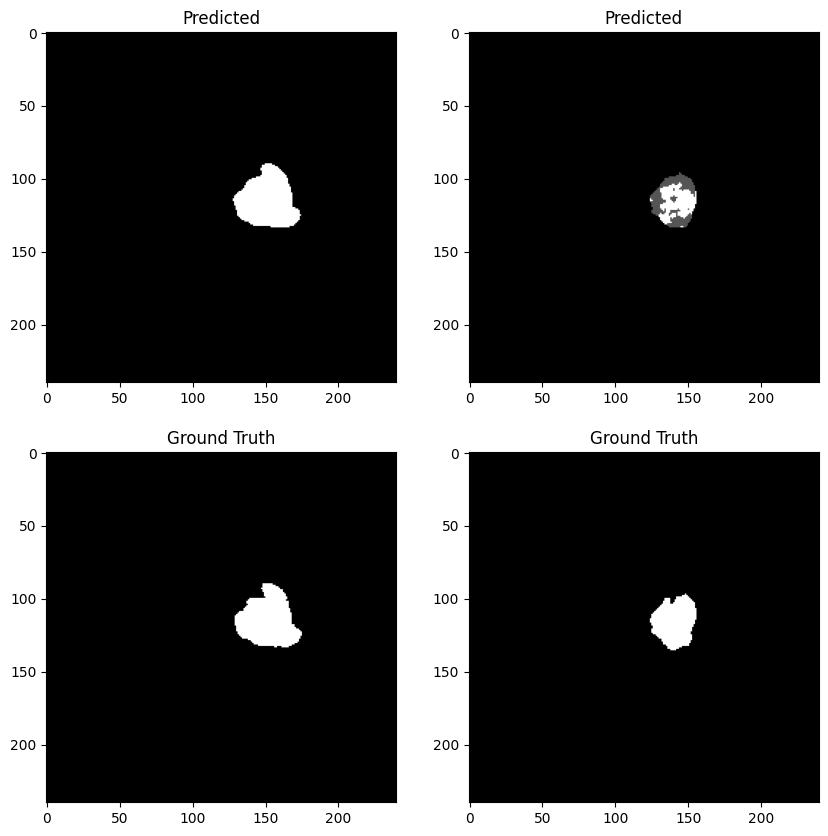

100%|██████████| 181/181 [08:49<00:00,  2.92s/it]



Average Training Loss: 0.007377647601829543

Average Training DSC: [0.9991894  0.86901997 0.92451704 0.76421902]
Average Training ASSD: [ 0.11018378 20.24827366 14.03175328 18.34443264]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


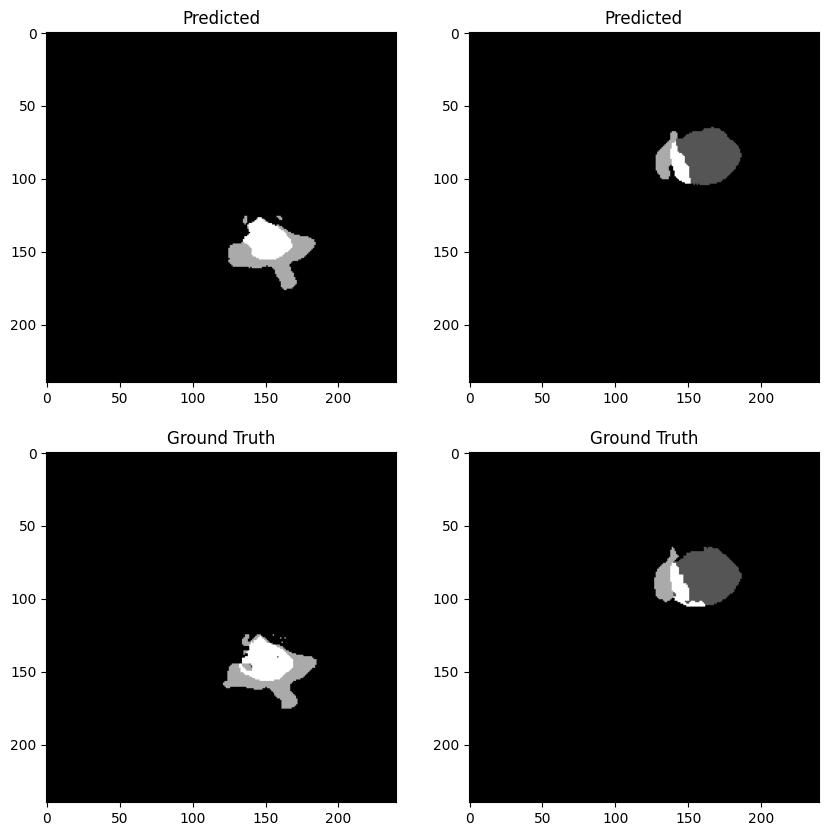

100%|██████████| 46/46 [01:28<00:00,  1.93s/it]


Average Validation Loss: 0.011076940709482069

Average Validation DSC: [0.99887218 0.83033939 0.90014493 0.71959394]
Average Validation ASSD: [ 0.16887775 29.43531027 19.37203538 25.63734007]
Epoch 34/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


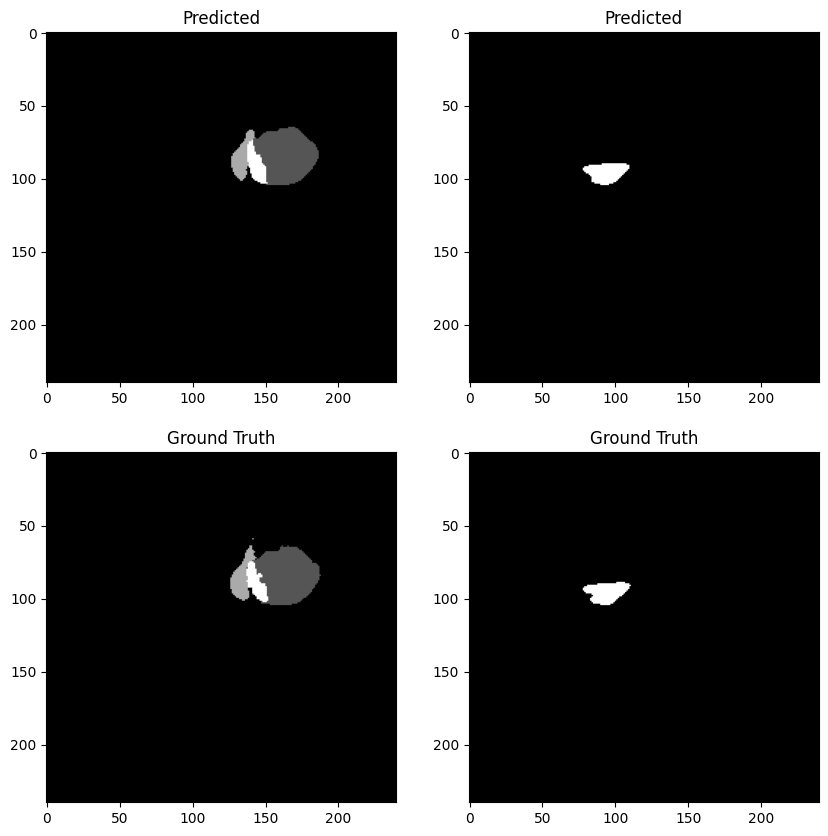

100%|██████████| 181/181 [08:51<00:00,  2.93s/it]



Average Training Loss: 0.007073810513167338

Average Training DSC: [0.99922189 0.88001823 0.93196256 0.77781035]
Average Training ASSD: [ 0.10395295 17.56059851 11.09899529 17.6921396 ]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


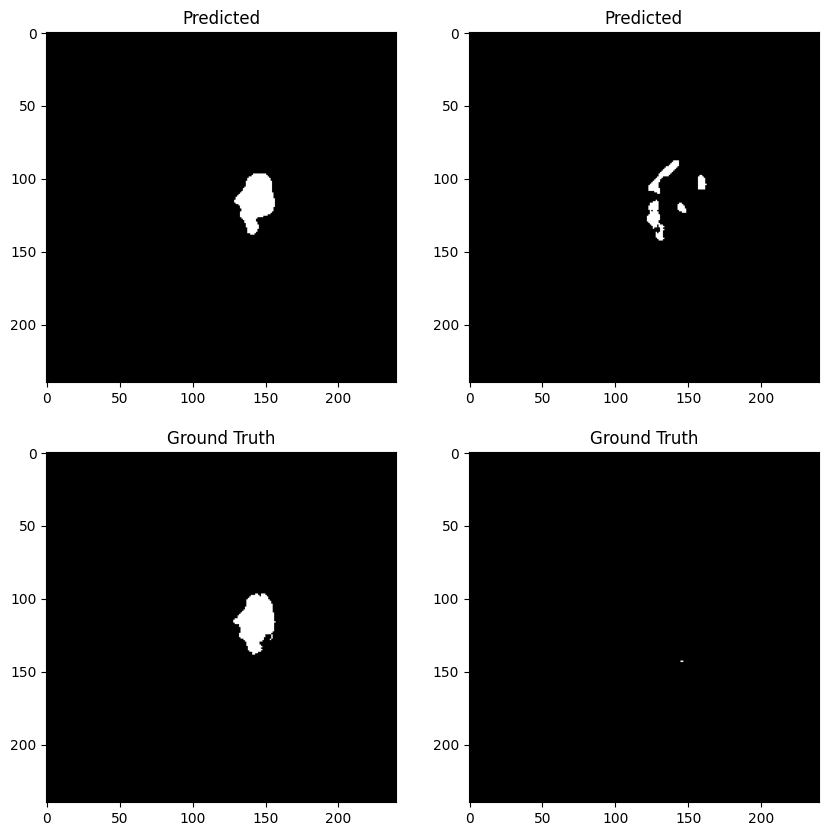

100%|██████████| 46/46 [01:27<00:00,  1.90s/it]


Average Validation Loss: 0.011802778316094824

Average Validation DSC: [0.9989296  0.79307268 0.91400701 0.70385506]
Average Validation ASSD: [ 0.14415835 29.96149736 13.43686276 16.88648863]
Epoch 35/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


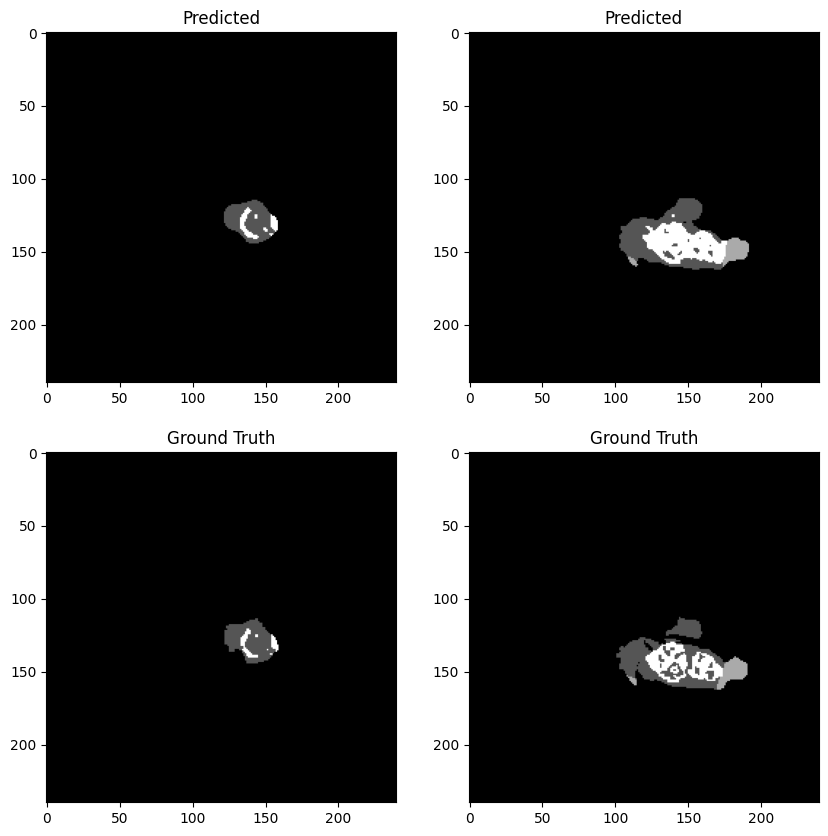

100%|██████████| 181/181 [08:45<00:00,  2.91s/it]



Average Training Loss: 0.006732847946773165

Average Training DSC: [0.99924365 0.88814157 0.93744213 0.78264589]
Average Training ASSD: [ 0.1008007  15.54076844  9.91886182 18.00611966]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


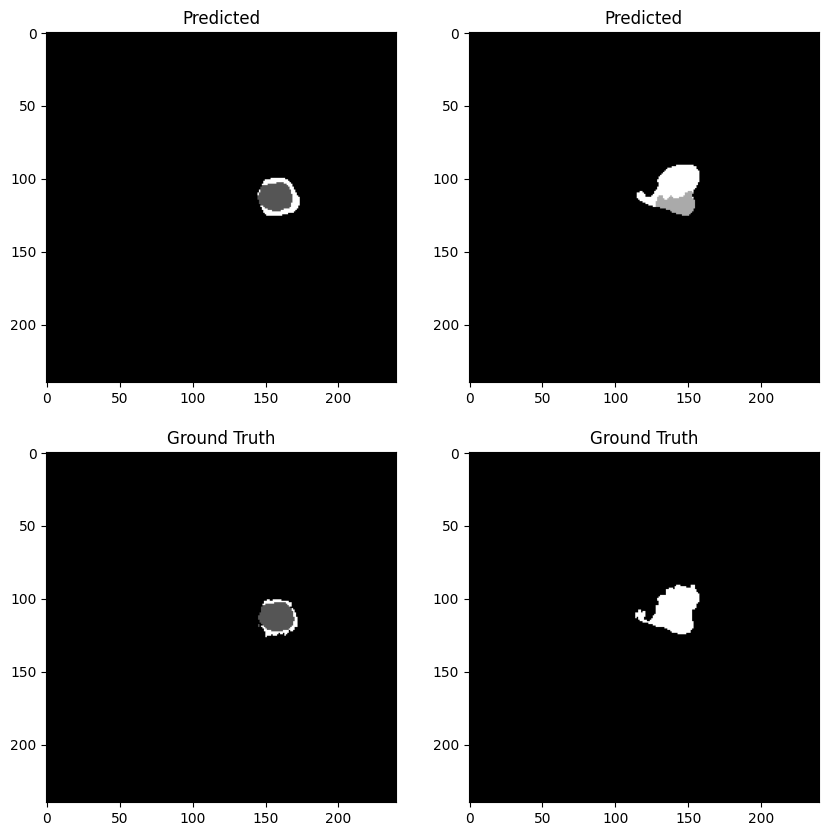

100%|██████████| 46/46 [01:26<00:00,  1.88s/it]


Average Validation Loss: 0.01013811846749614

Average Validation DSC: [0.99899603 0.84711325 0.83029403 0.73817946]
Average Validation ASSD: [ 0.12361933 24.53032437 44.00552501  9.96165208]
Epoch 36/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


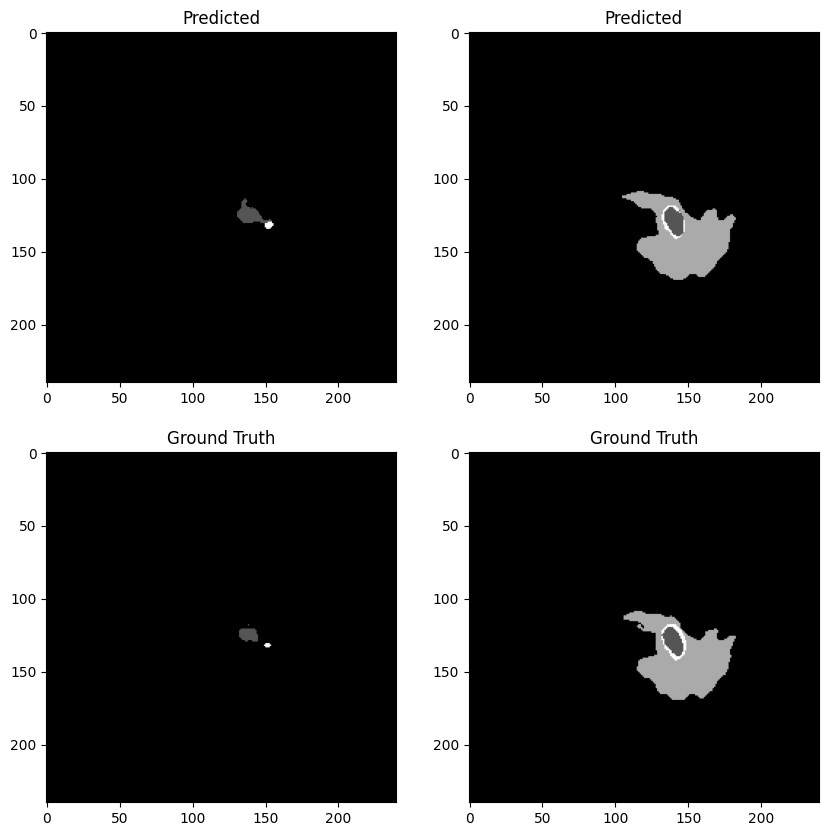

100%|██████████| 181/181 [08:48<00:00,  2.92s/it]



Average Training Loss: 0.00686953360605882

Average Training DSC: [0.99923516 0.88467542 0.93525796 0.78110766]
Average Training ASSD: [ 0.10389264 15.81171285 10.83195225 17.27364924]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


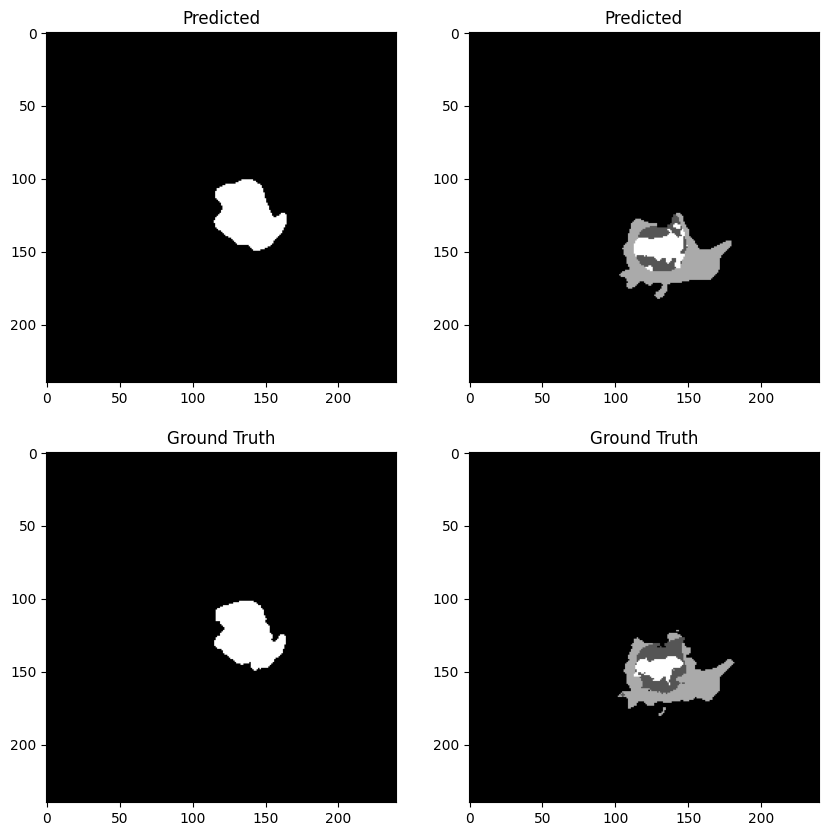

100%|██████████| 46/46 [01:25<00:00,  1.87s/it]


Average Validation Loss: 0.010745126075799699

Average Validation DSC: [0.9990074  0.84831295 0.89777303 0.74844118]
Average Validation ASSD: [ 0.14787492 19.31607878 21.64253367  9.44664035]
Epoch 37/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


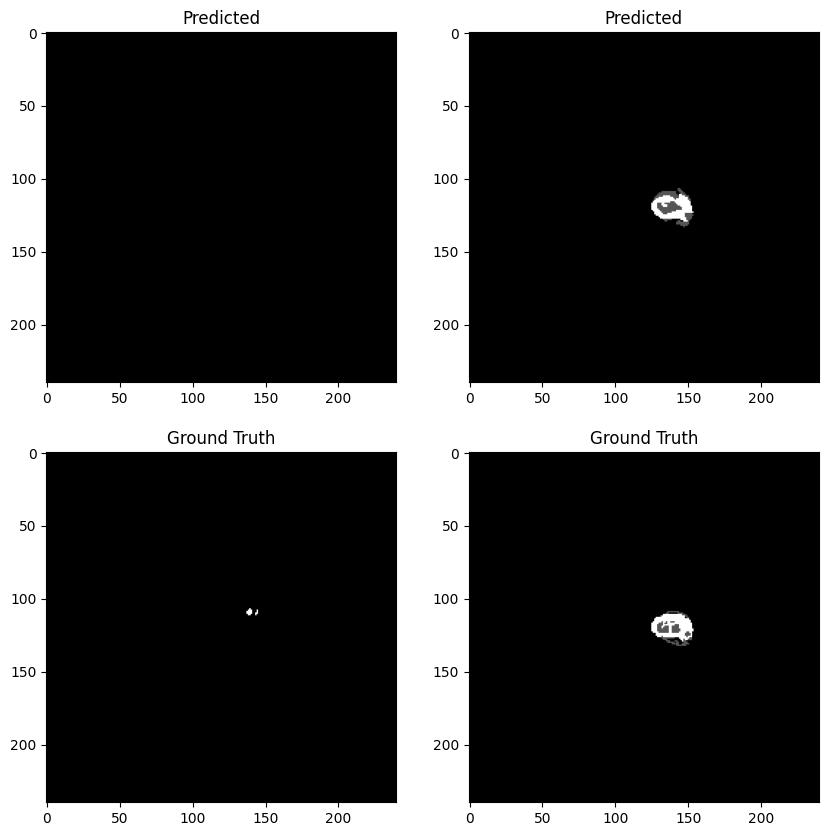

100%|██████████| 181/181 [08:48<00:00,  2.92s/it]



Average Training Loss: 0.006623561981581769

Average Training DSC: [0.99926886 0.89059075 0.93559903 0.78717729]
Average Training ASSD: [ 0.10440704 15.02721672 11.14608315 17.52149071]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


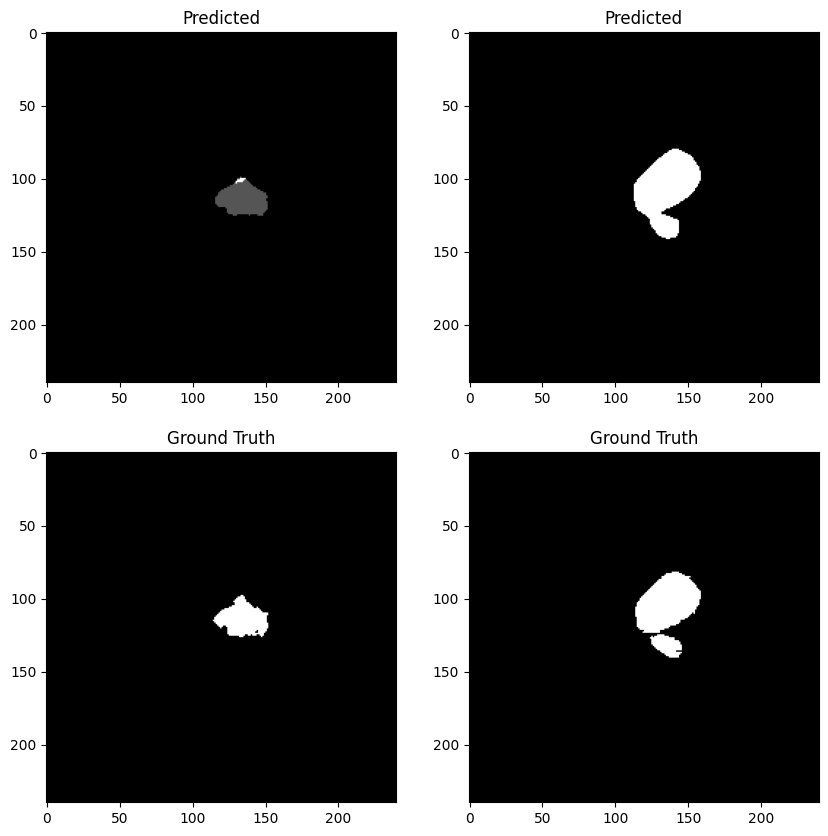

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.009253339740731146

Average Validation DSC: [0.99905411 0.85434553 0.92934878 0.73397208]
Average Validation ASSD: [ 0.12832121 25.07983488 11.77577114 18.99310052]
Epoch 38/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


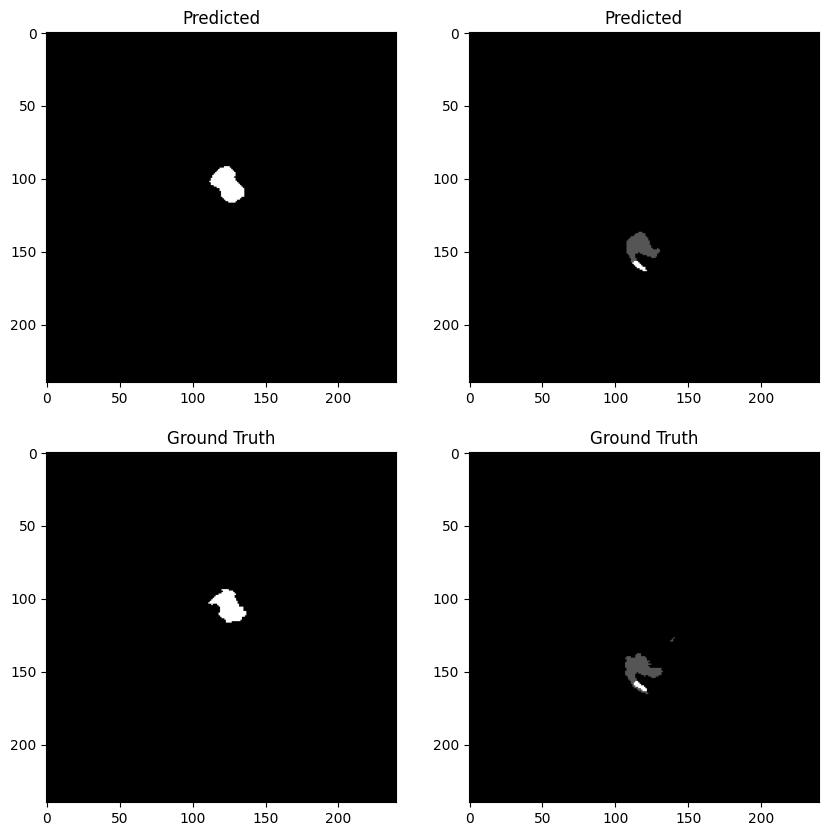

100%|██████████| 181/181 [08:48<00:00,  2.92s/it]



Average Training Loss: 0.006414967236618475

Average Training DSC: [0.99930183 0.88297765 0.93926181 0.79165647]
Average Training ASSD: [ 0.09310613 18.52263073 10.15614894 15.44526652]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


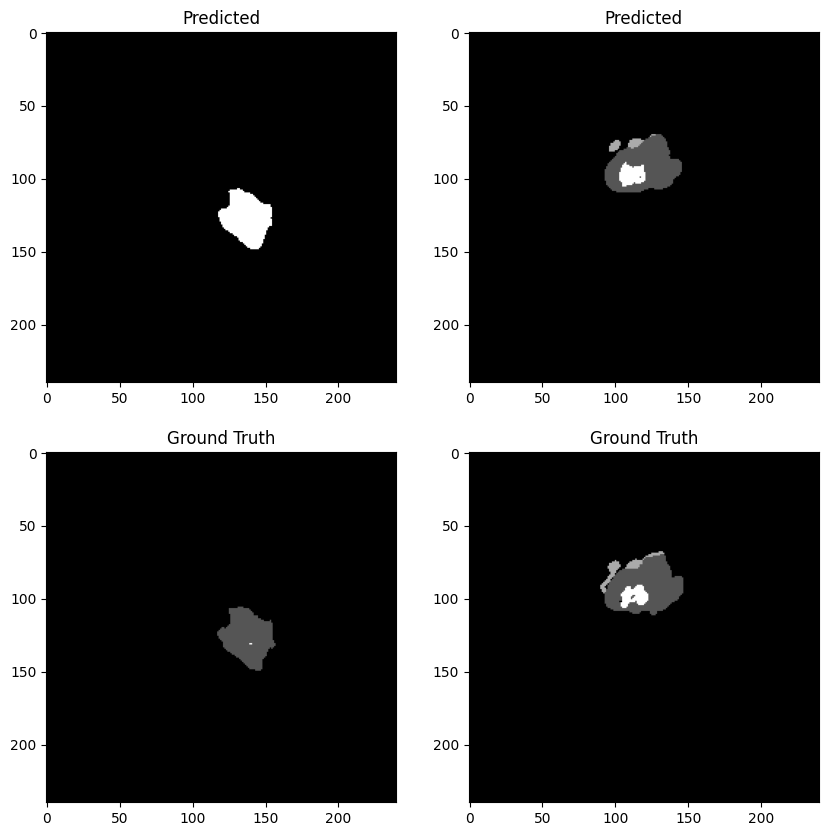

100%|██████████| 46/46 [01:30<00:00,  1.96s/it]


Average Validation Loss: 0.010286887105473357

Average Validation DSC: [0.99891058 0.85901321 0.93496891 0.71636658]
Average Validation ASSD: [ 0.18146743 20.22262708  8.15904176 27.53699819]
Epoch 39/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


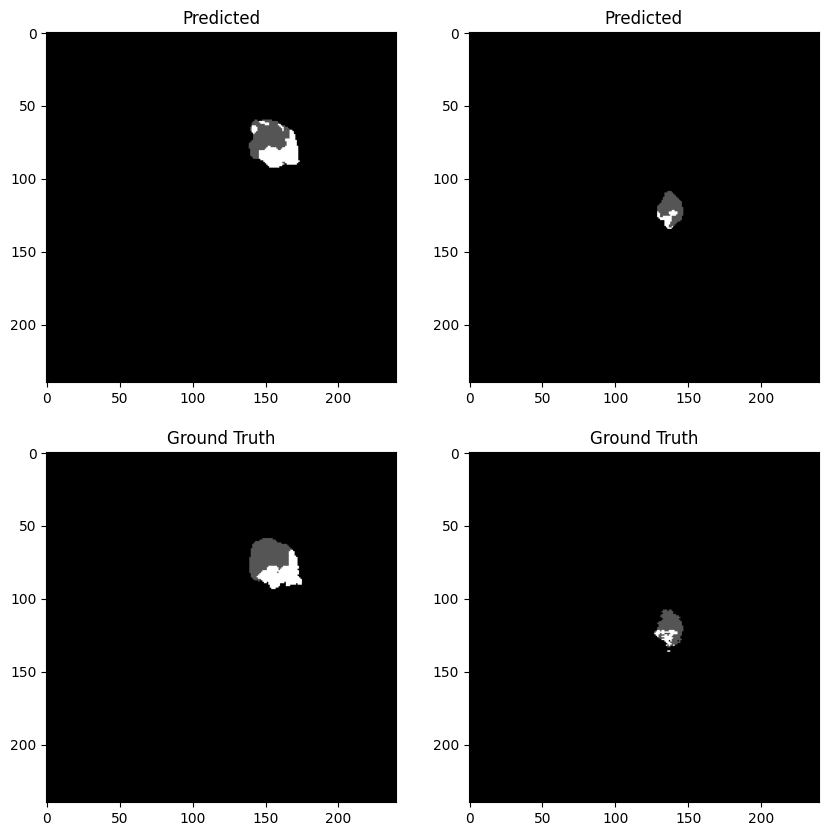

100%|██████████| 181/181 [08:46<00:00,  2.91s/it]



Average Training Loss: 0.006265764239177273

Average Training DSC: [0.99930178 0.89333115 0.9428579  0.79678316]
Average Training ASSD: [ 0.09354241 15.17725229  8.88838686 15.73579663]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


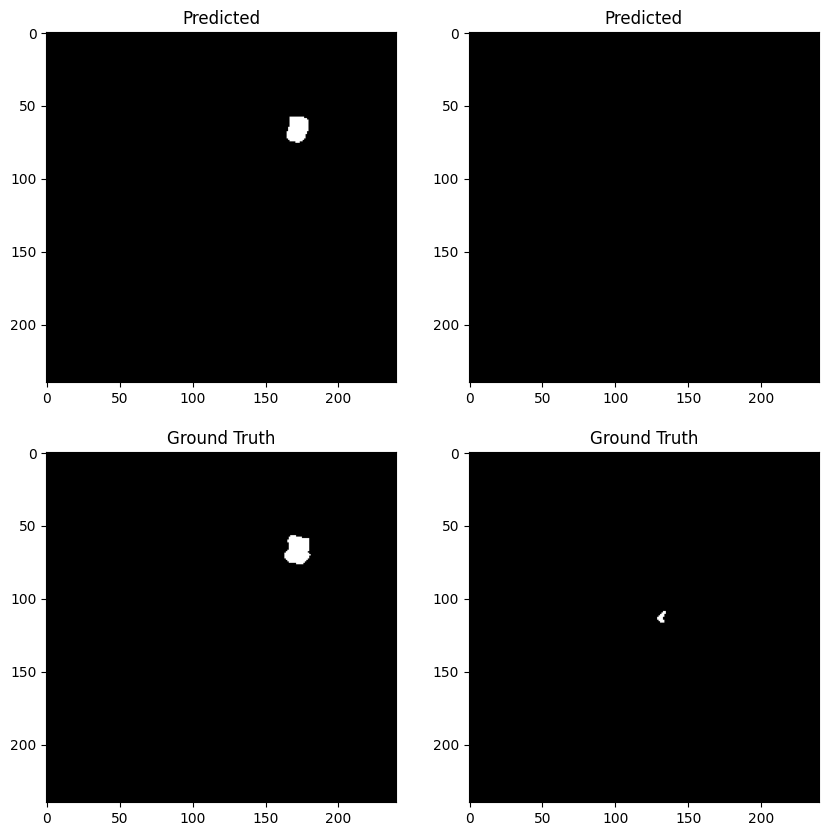

100%|██████████| 46/46 [01:26<00:00,  1.87s/it]


Average Validation Loss: 0.010540236111568369

Average Validation DSC: [0.99890602 0.85082241 0.92427641 0.6764907 ]
Average Validation ASSD: [ 0.17916686 24.82485271 12.50168412 34.38235067]
Epoch 40/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


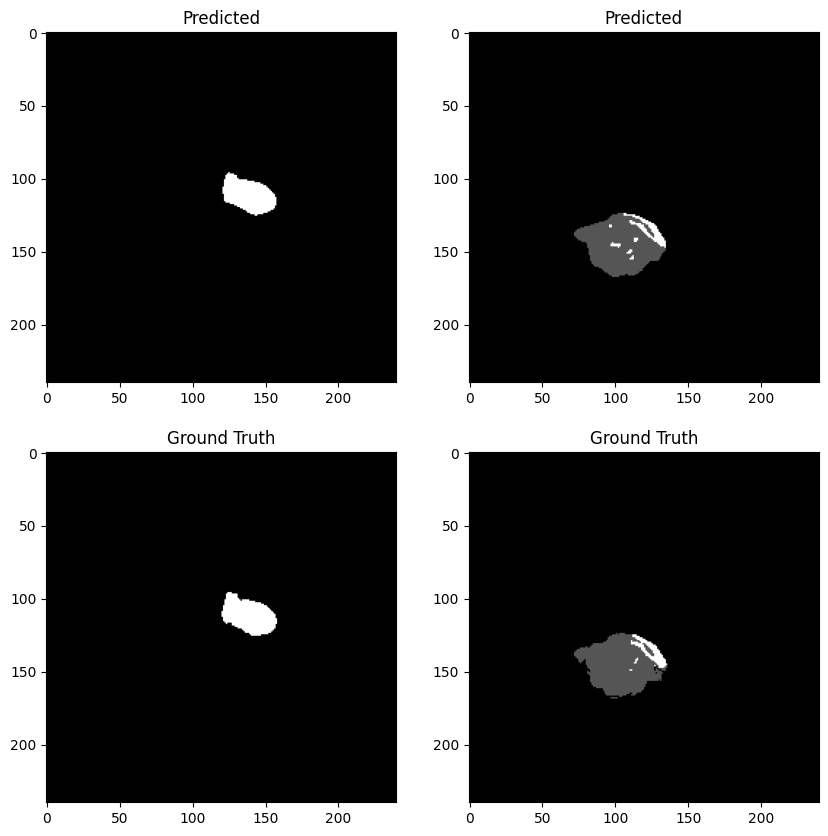

100%|██████████| 181/181 [08:46<00:00,  2.91s/it]



Average Training Loss: 0.006030854417875574

Average Training DSC: [0.99932361 0.89772978 0.94171705 0.79879815]
Average Training ASSD: [ 0.09085211 12.93258792  9.48683518 16.71528744]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


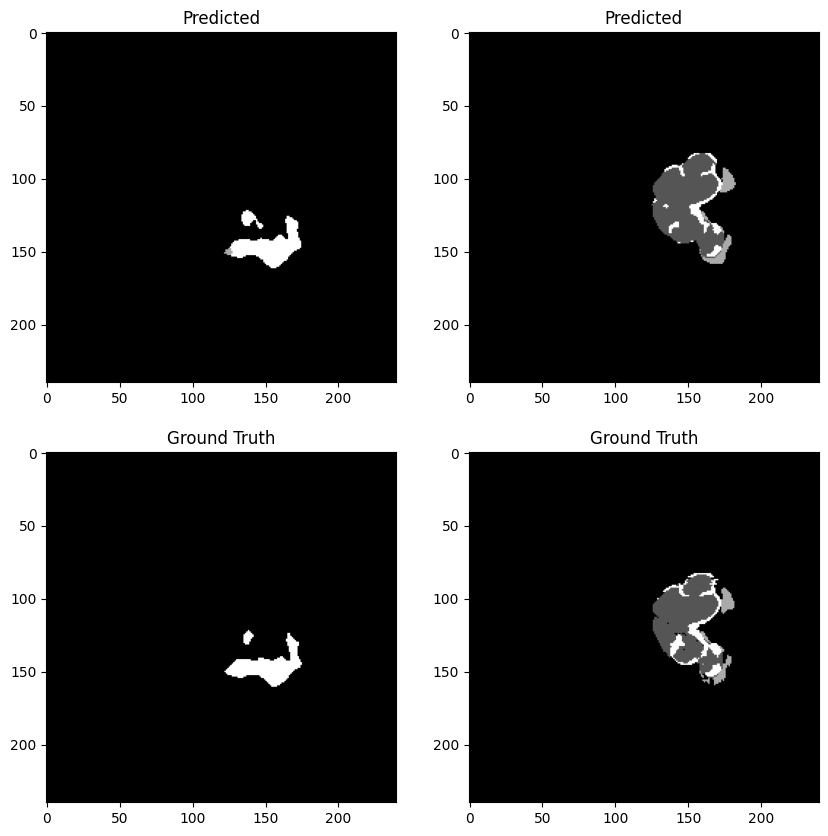

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.00963765702655782

Average Validation DSC: [0.99905244 0.83246565 0.90071822 0.7358528 ]
Average Validation ASSD: [ 0.14325016 31.6962712  20.39771046 16.54398255]
Epoch 41/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


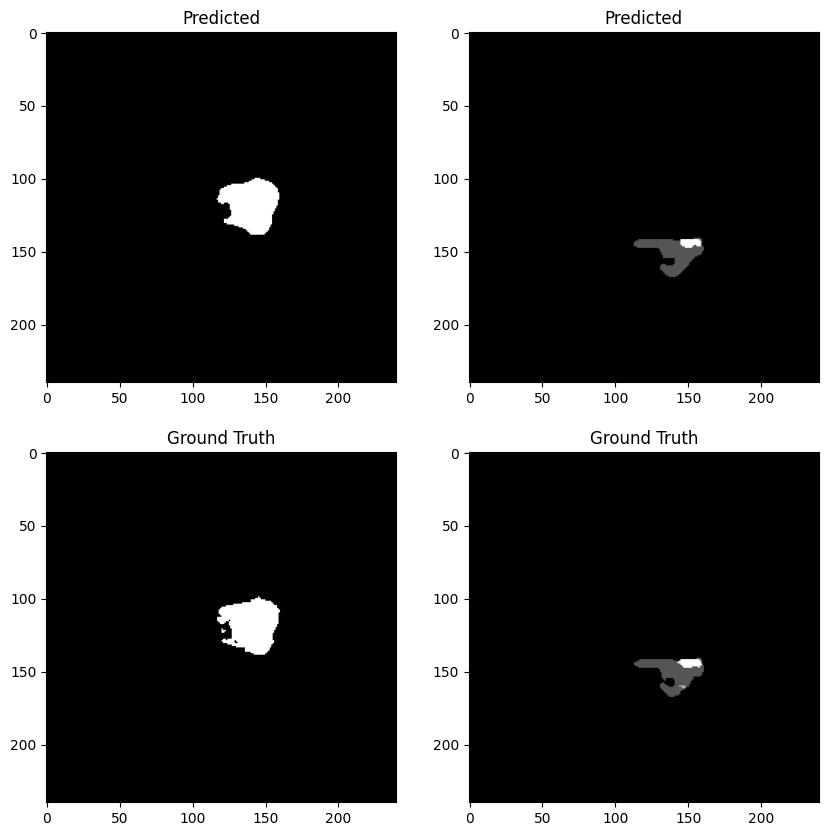

100%|██████████| 181/181 [08:45<00:00,  2.90s/it]



Average Training Loss: 0.0062566783397525385

Average Training DSC: [0.99930126 0.89301582 0.93547671 0.79752968]
Average Training ASSD: [ 0.09727426 15.11045278 10.72939742 16.24590316]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


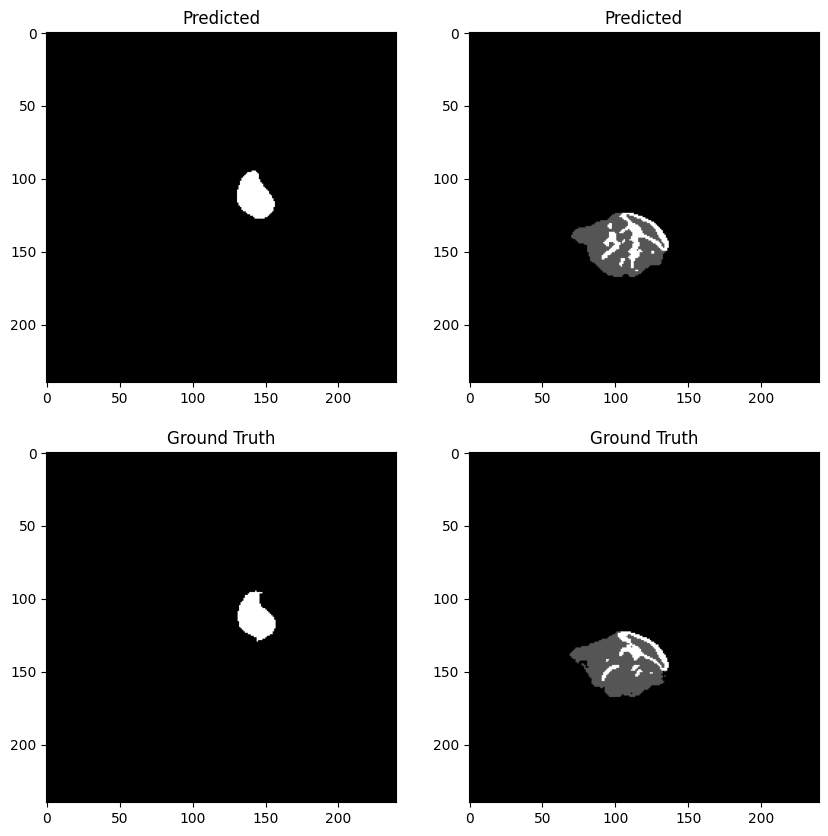

100%|██████████| 46/46 [01:23<00:00,  1.82s/it]


Average Validation Loss: 0.0101209899066421

Average Validation DSC: [0.99908049 0.84098574 0.90921557 0.74258515]
Average Validation ASSD: [ 0.13415318 21.28852822 18.66140743 17.21089437]
Epoch 42/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


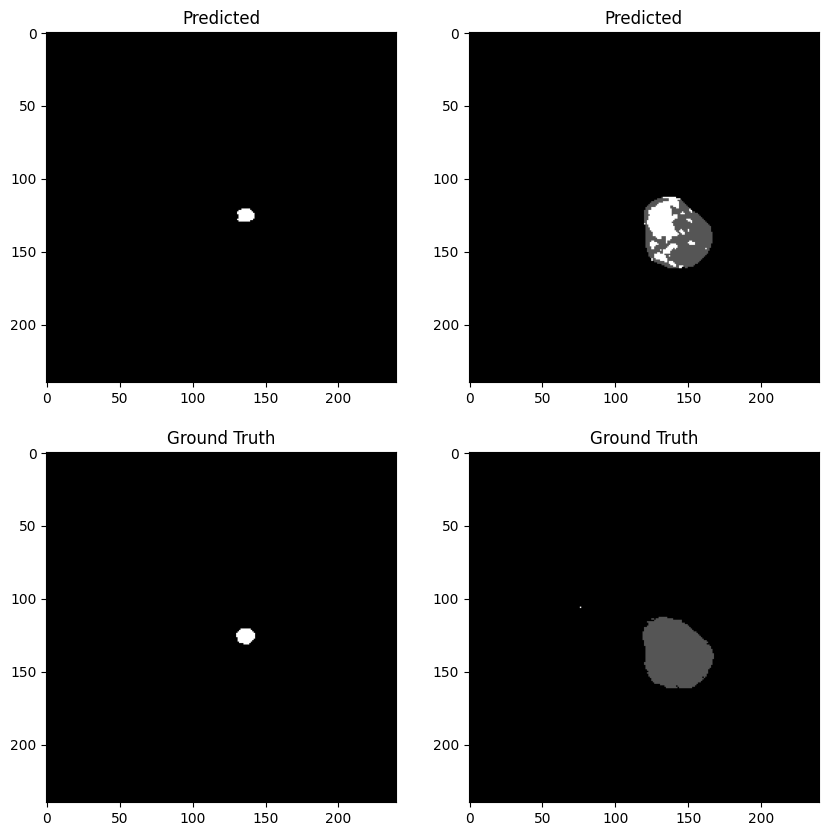

100%|██████████| 181/181 [08:49<00:00,  2.93s/it]



Average Training Loss: 0.00619295733795599

Average Training DSC: [0.99931048 0.89022269 0.9411575  0.79922282]
Average Training ASSD: [ 0.09200748 16.01105397  9.30824878 15.79275845]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


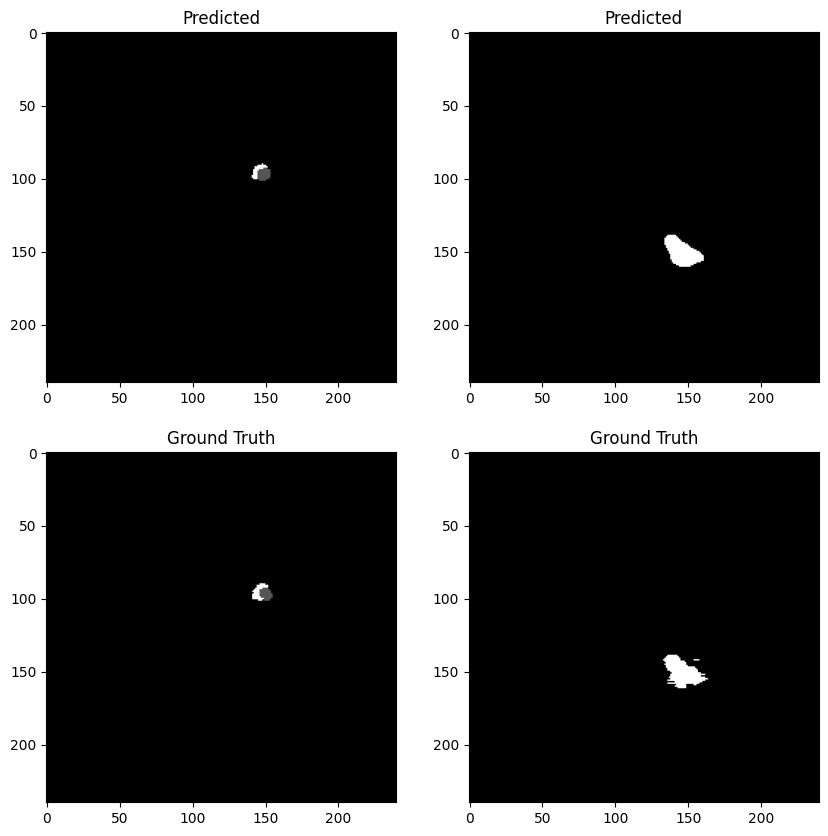

100%|██████████| 46/46 [01:27<00:00,  1.90s/it]


Average Validation Loss: 0.009250660320622441

Average Validation DSC: [0.99912606 0.85819346 0.93592062 0.72631402]
Average Validation ASSD: [ 0.12836134 22.8286688   9.12890695 22.24094203]
Epoch 43/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


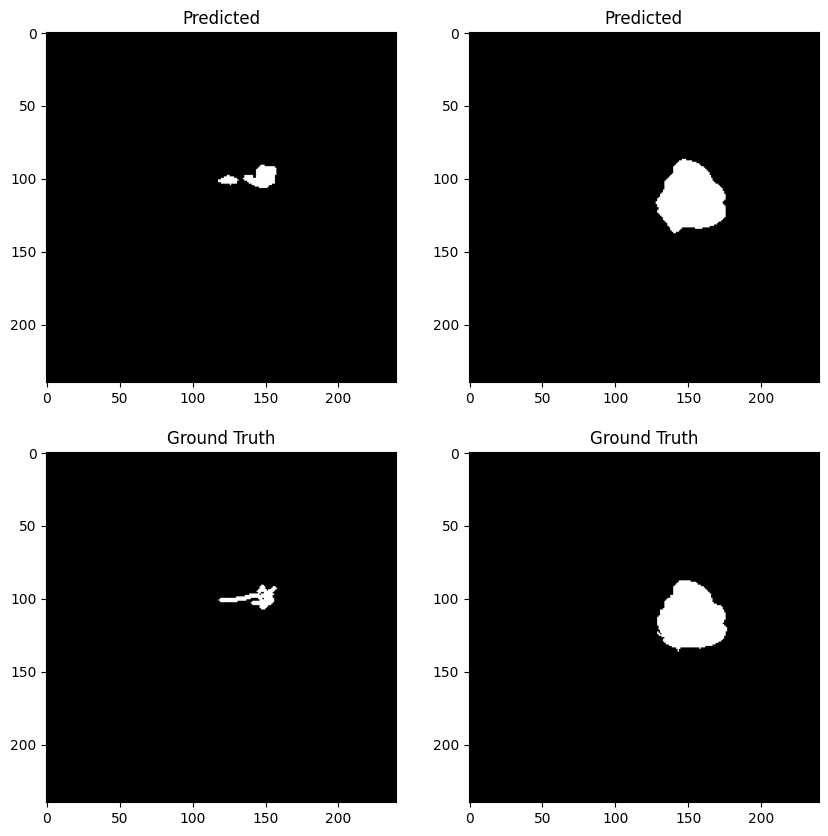

100%|██████████| 181/181 [08:49<00:00,  2.92s/it]



Average Training Loss: 0.006126726182558425

Average Training DSC: [0.9993268  0.89984624 0.92923428 0.80321252]
Average Training ASSD: [ 0.09051891 13.41463883 13.00157806 16.23526263]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


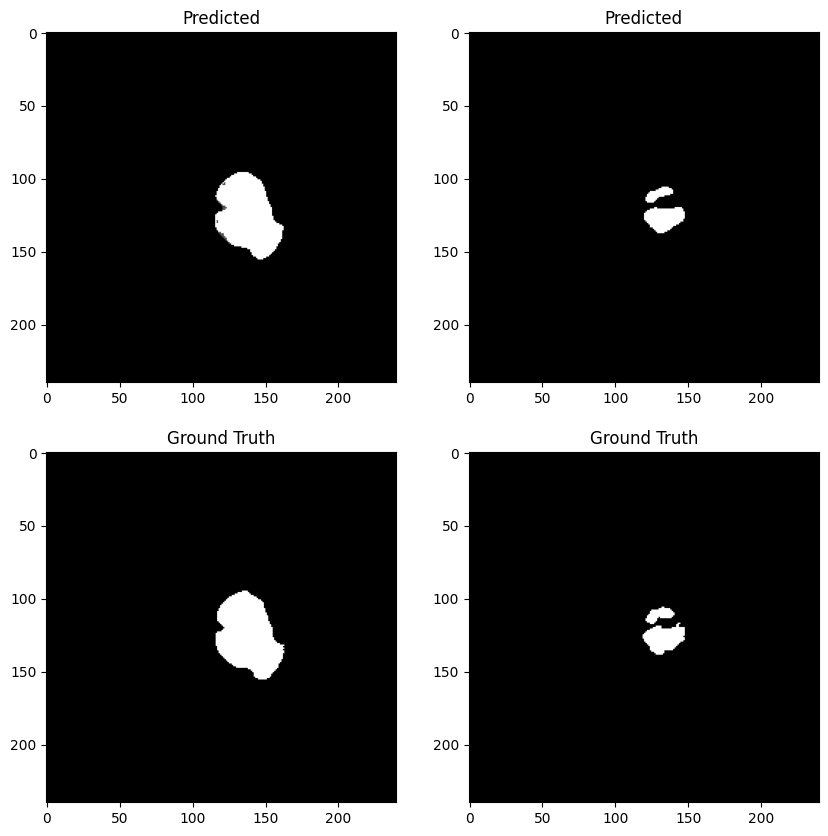

100%|██████████| 46/46 [01:25<00:00,  1.85s/it]


Average Validation Loss: 0.009029552644199652

Average Validation DSC: [0.99909968 0.87722774 0.9264852  0.74467927]
Average Validation ASSD: [ 0.14850819 17.86320629 12.74596298 21.90163356]
Epoch 44/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


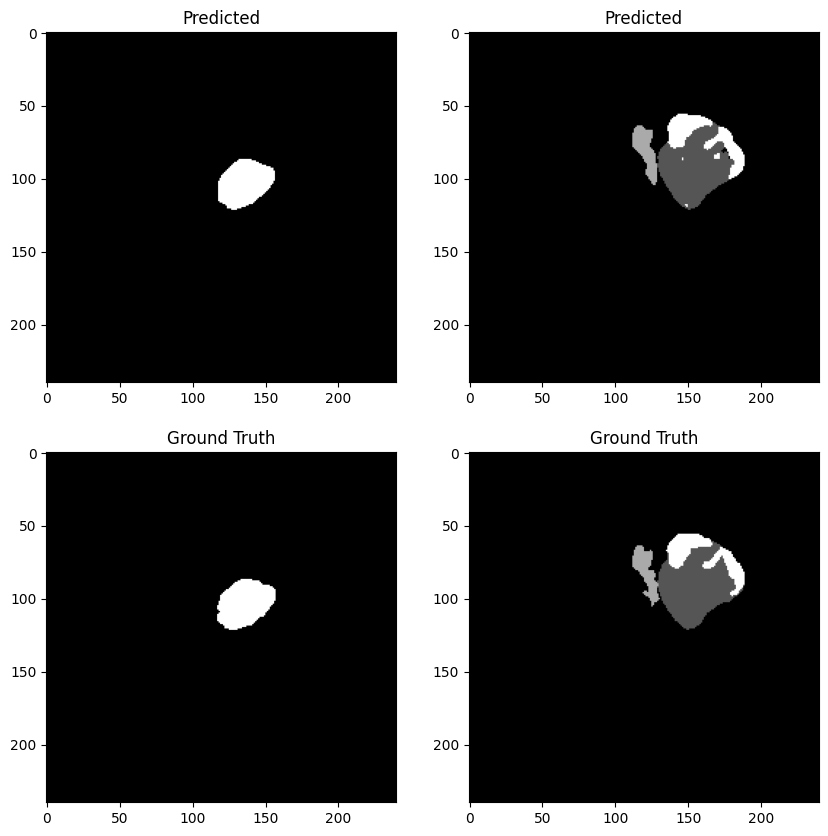

100%|██████████| 181/181 [08:47<00:00,  2.91s/it]



Average Training Loss: 0.00538140825428151

Average Training DSC: [0.99940323 0.91154405 0.9426761  0.81803452]
Average Training ASSD: [ 0.07763153 10.71282897  9.86427159 15.86783999]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


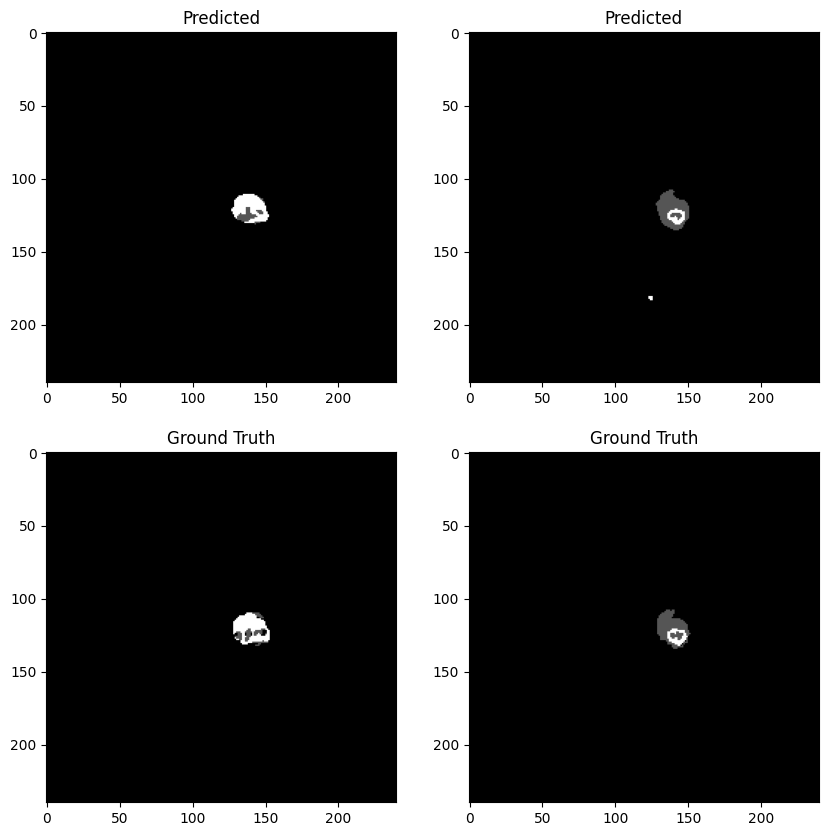

100%|██████████| 46/46 [01:25<00:00,  1.85s/it]


Average Validation Loss: 0.009538358239376026

Average Validation DSC: [0.99901288 0.85558775 0.8238009  0.75455393]
Average Validation ASSD: [ 0.18112593 24.77192431 49.25970689 11.83557751]
Epoch 45/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


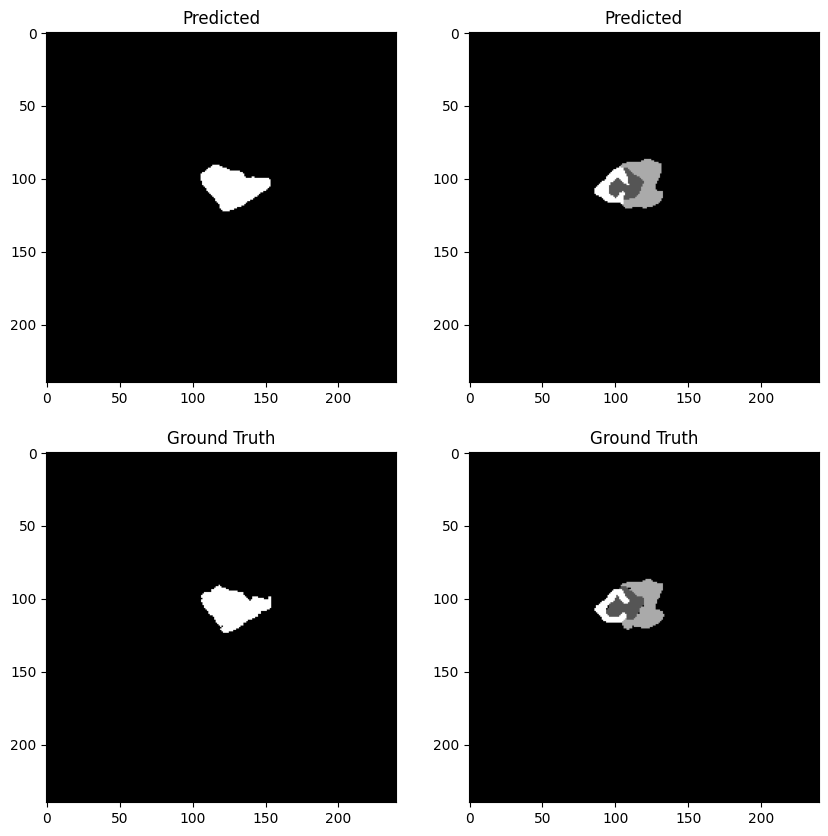

100%|██████████| 181/181 [08:53<00:00,  2.95s/it]



Average Training Loss: 0.005206910181965535

Average Training DSC: [0.9994121  0.91691375 0.94352296 0.8242601 ]
Average Training ASSD: [ 0.08098578  9.77778205  9.5395962  16.17273571]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


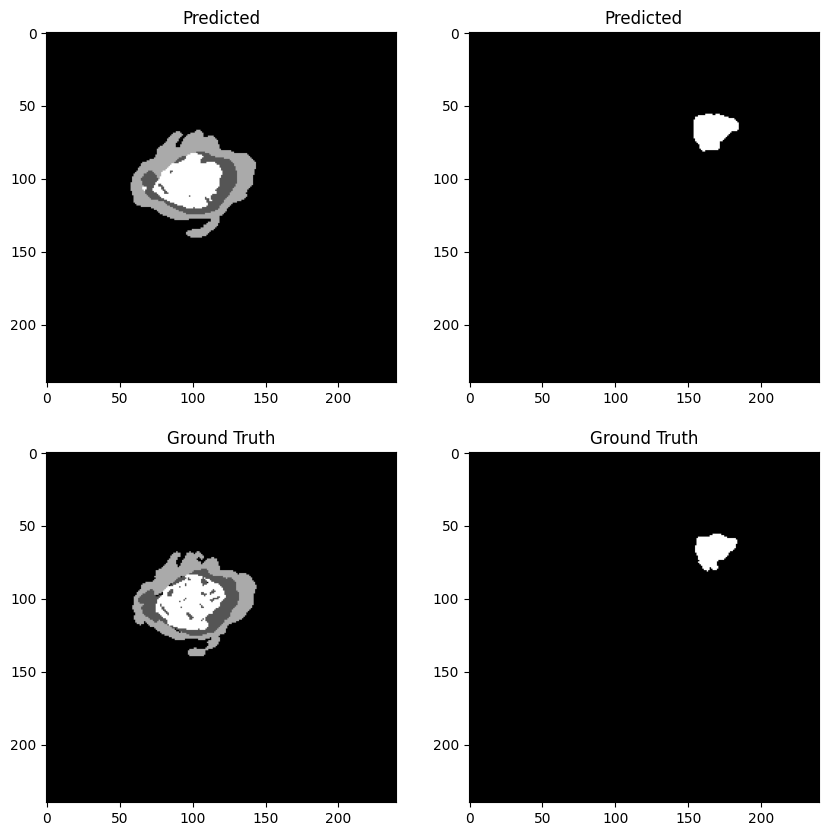

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.013538160224688118

Average Validation DSC: [0.99858314 0.81317353 0.71576916 0.71735738]
Average Validation ASSD: [ 0.41835359 31.27547453 85.16979954  6.32371227]
Epoch 46/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


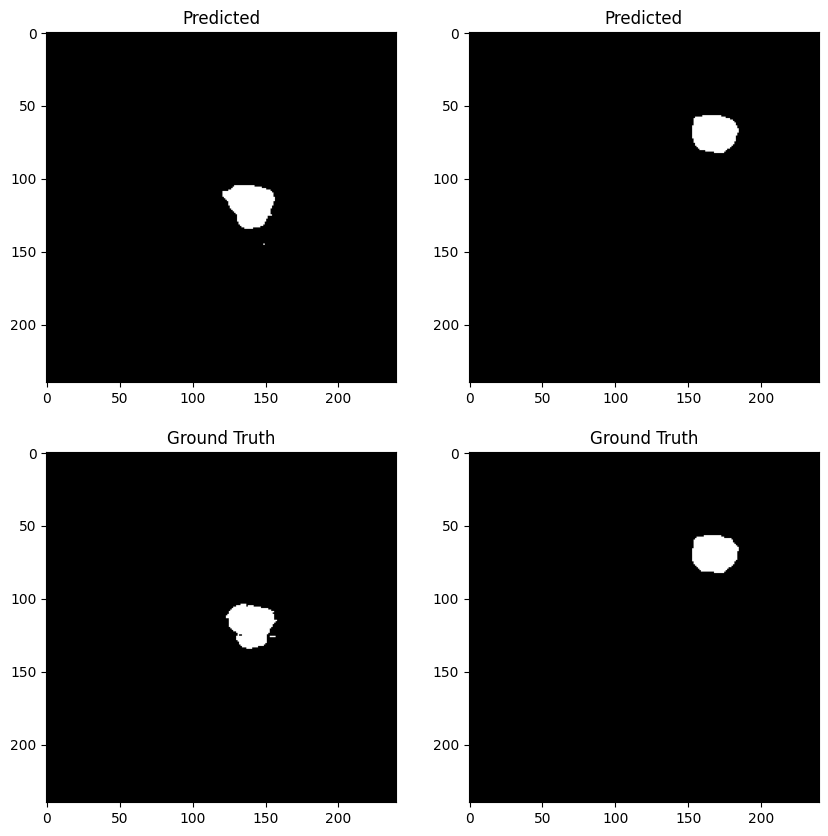

100%|██████████| 181/181 [08:51<00:00,  2.94s/it]



Average Training Loss: 0.005524304849790275

Average Training DSC: [0.99937913 0.90385879 0.94468532 0.81639101]
Average Training ASSD: [ 0.0815984  13.13348394  9.03158821 14.12314337]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


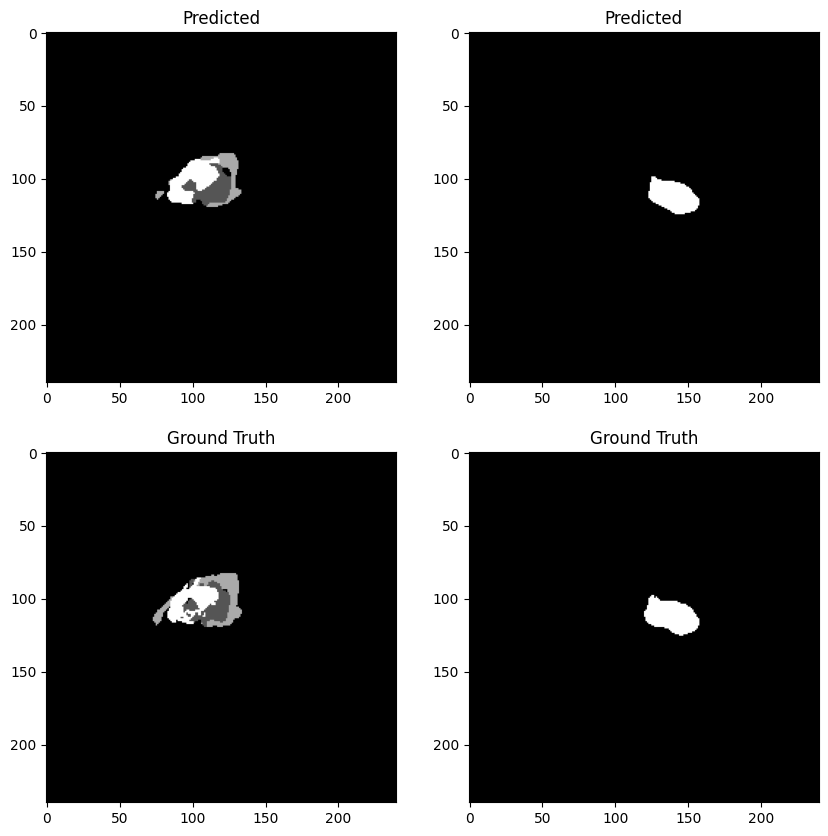

100%|██████████| 46/46 [01:25<00:00,  1.86s/it]


Average Validation Loss: 0.009622982470318675

Average Validation DSC: [0.99897995 0.85933758 0.93270118 0.74388376]
Average Validation ASSD: [ 0.16129672 20.49968791  9.13887575 23.46918588]
Epoch 47/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


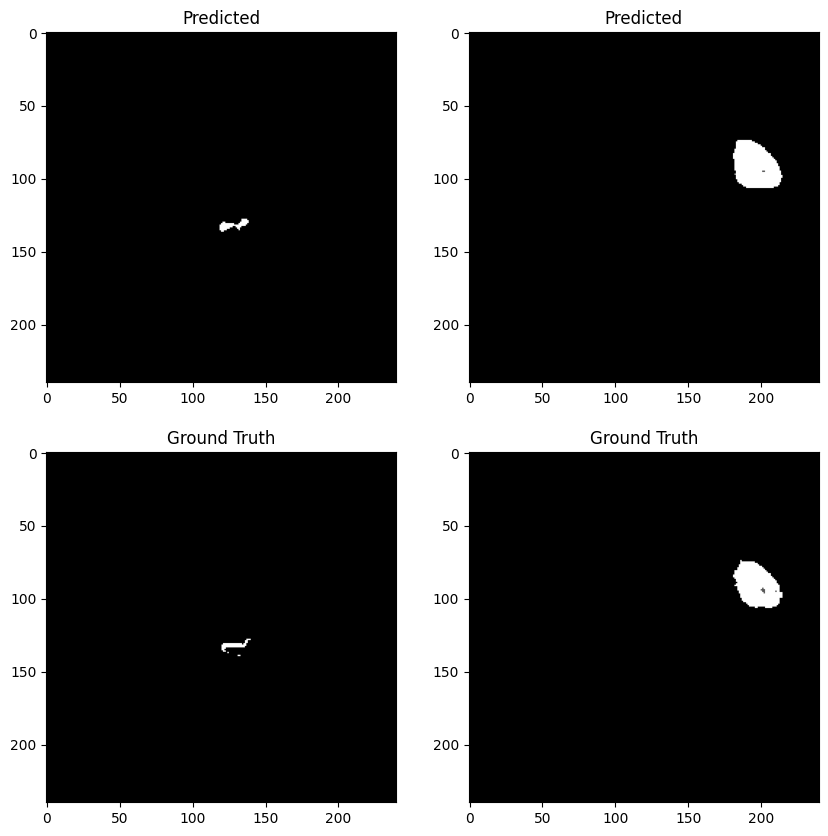

100%|██████████| 181/181 [08:48<00:00,  2.92s/it]



Average Training Loss: 0.005830036940629393

Average Training DSC: [0.99933963 0.90360668 0.93316304 0.810655  ]
Average Training ASSD: [ 0.08991787 13.05475788 12.46569047 14.96839203]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


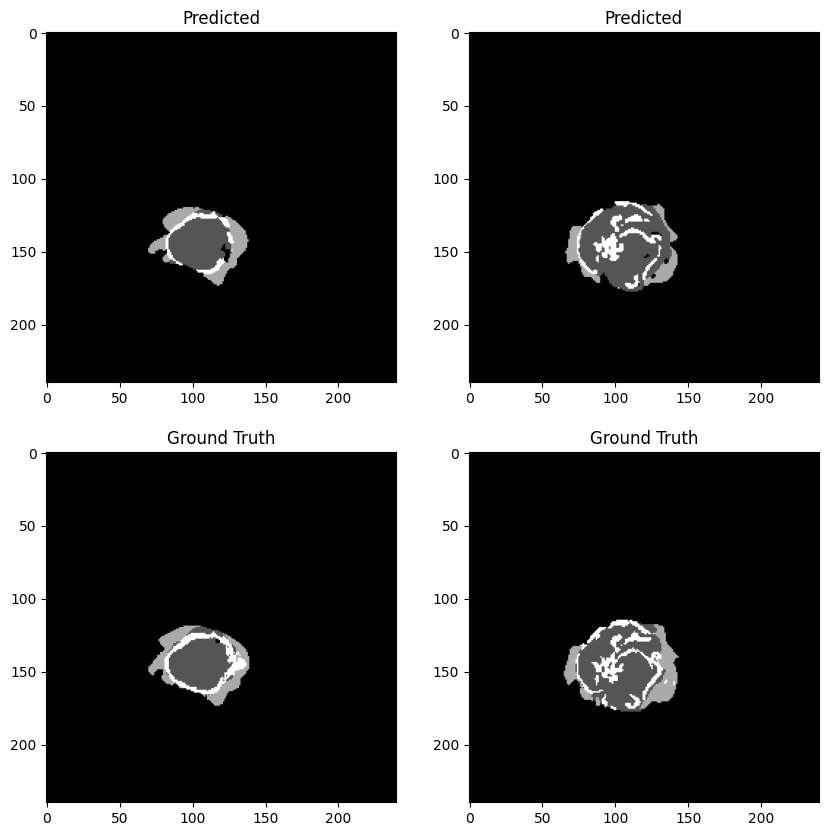

100%|██████████| 46/46 [01:25<00:00,  1.86s/it]


Average Validation Loss: 0.02286467772058171

Average Validation DSC: [0.99726172 0.77941043 0.86187414 0.53441888]
Average Validation ASSD: [ 0.50980952 31.47204568 23.23854038 58.60202952]
Epoch 48/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


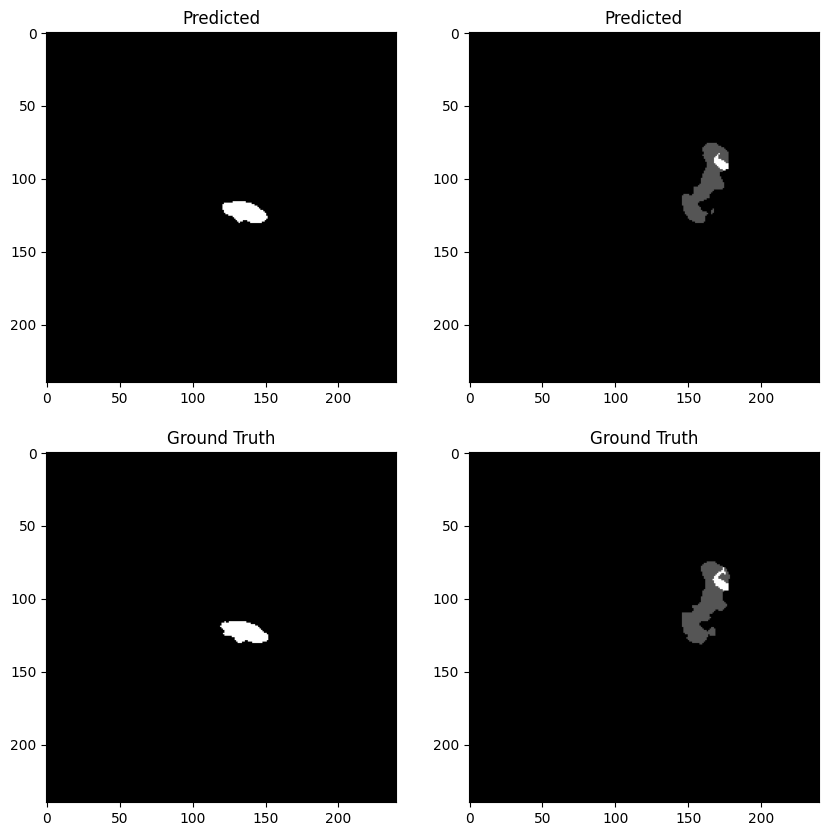

100%|██████████| 181/181 [08:52<00:00,  2.94s/it]



Average Training Loss: 0.005624565493974073

Average Training DSC: [0.99937278 0.90354762 0.94276021 0.81446444]
Average Training ASSD: [ 0.08327665 13.13841871  9.20198988 15.6591825 ]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


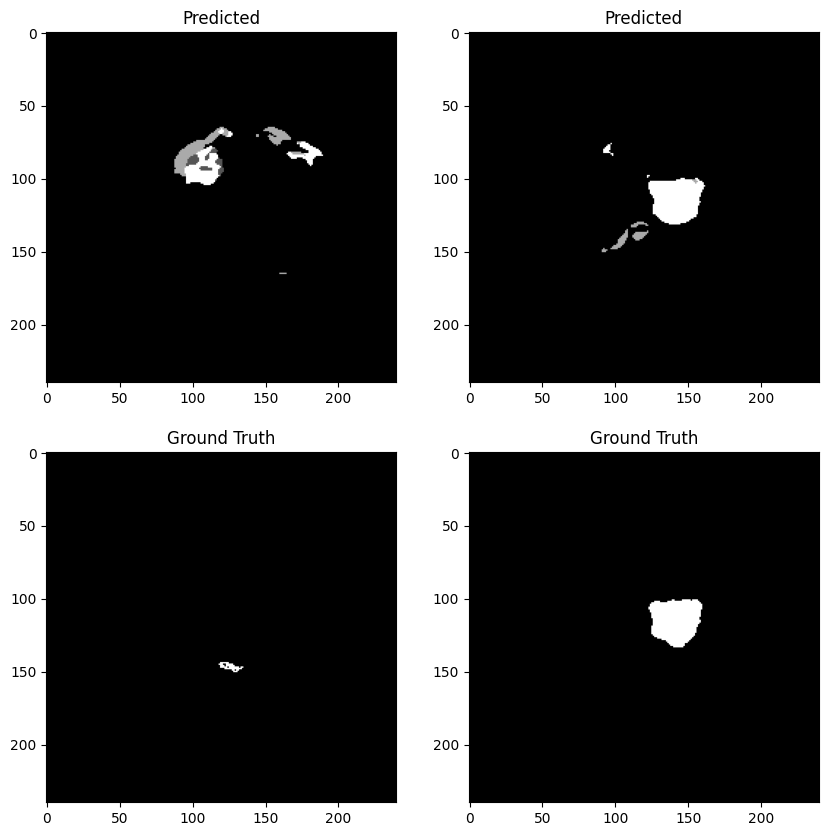

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.03624798819098784

Average Validation DSC: [0.99491862 0.54811929 0.19987516 0.59472065]
Average Validation ASSD: [  2.28971658 120.92971181 259.49859509  10.44776893]
Epoch 49/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


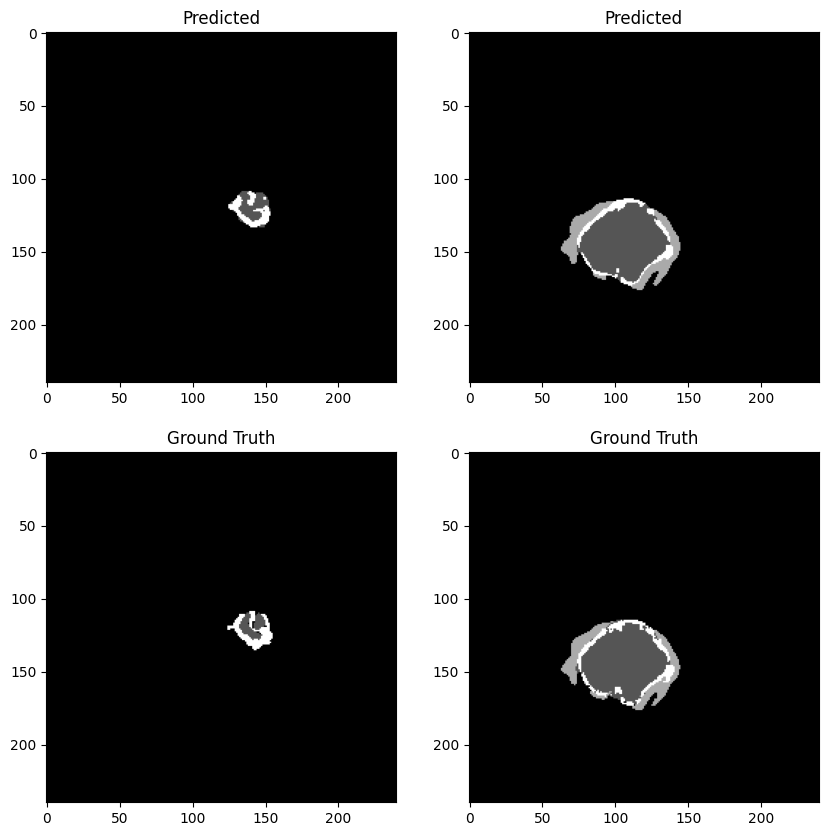

100%|██████████| 181/181 [08:52<00:00,  2.94s/it]



Average Training Loss: 0.00544307189762016

Average Training DSC: [0.99940571 0.90089296 0.94421574 0.81680511]
Average Training ASSD: [ 0.07997942 13.83069172  9.29423978 14.74564089]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


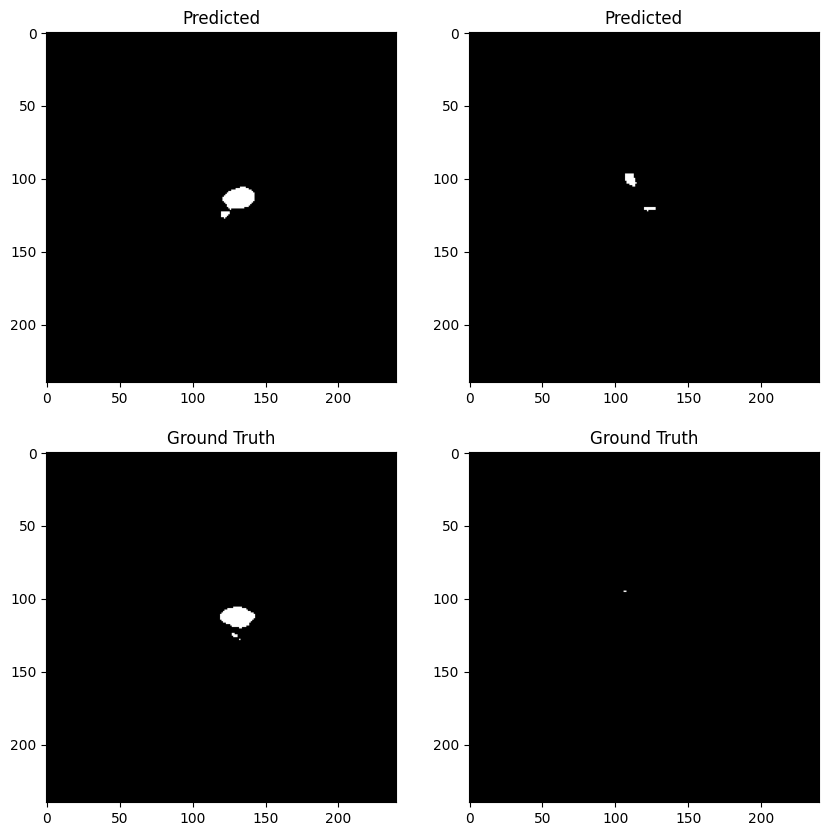

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.008648306870347133

Average Validation DSC: [0.99919109 0.87885857 0.94127858 0.77988691]
Average Validation ASSD: [ 0.11613676 19.78146666  8.79140778 14.75980224]
Epoch 50/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


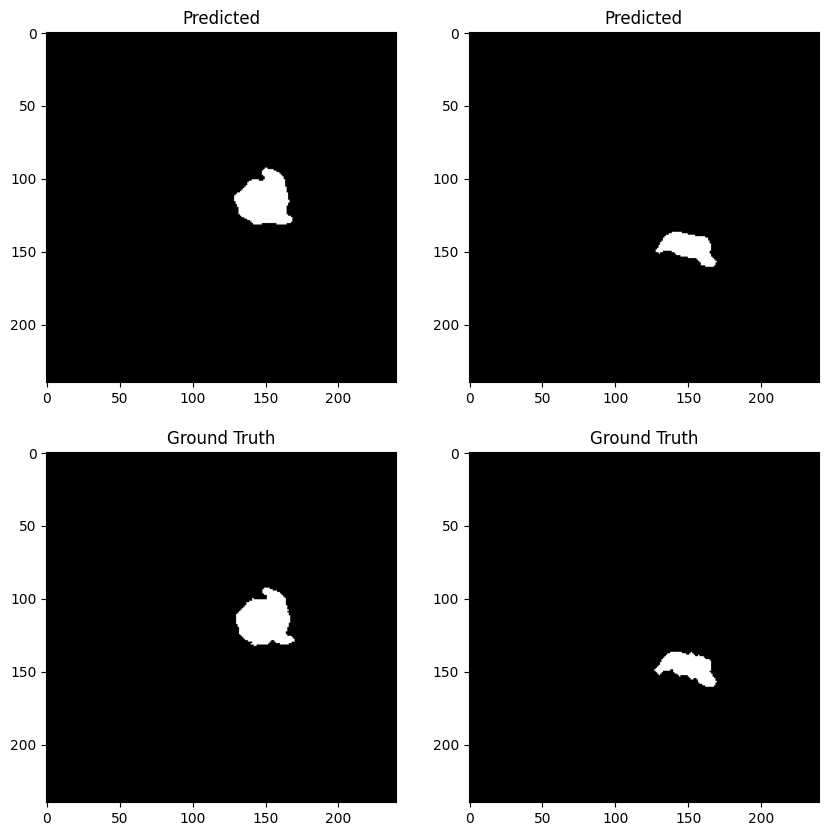

100%|██████████| 181/181 [08:52<00:00,  2.94s/it]



Average Training Loss: 0.005033664229114988

Average Training DSC: [0.99943095 0.91313662 0.94859519 0.82714546]
Average Training ASSD: [ 0.07533214 11.76886159  8.42470327 13.77684639]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


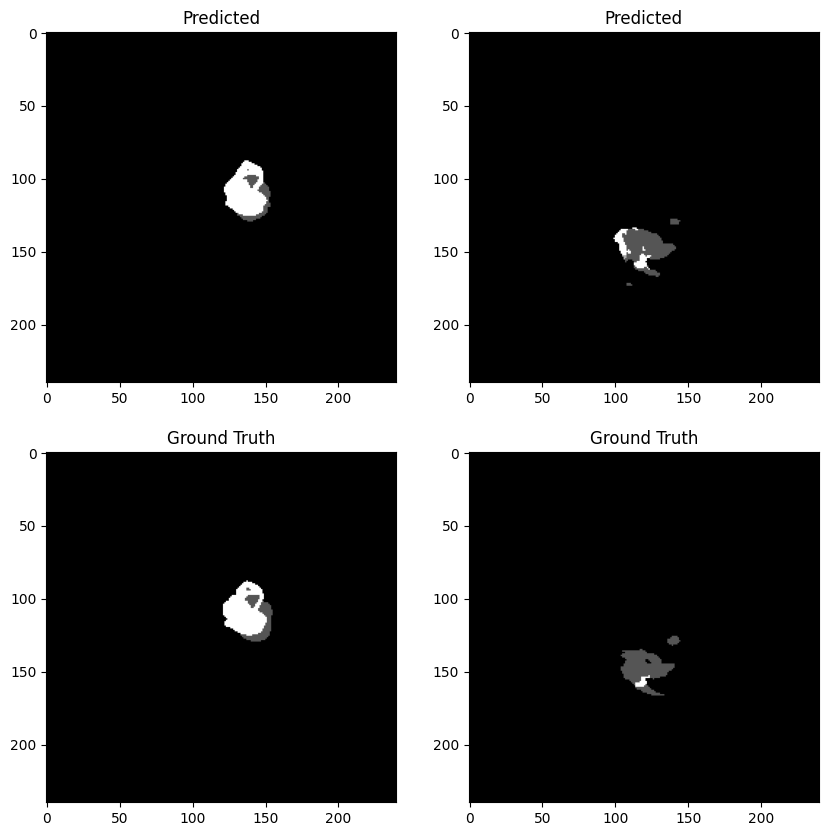

100%|██████████| 46/46 [01:25<00:00,  1.86s/it]


Average Validation Loss: 0.010057882810740368

Average Validation DSC: [0.99905135 0.84347499 0.89313995 0.74431914]
Average Validation ASSD: [ 0.19401999 27.82439106 24.61469452 15.06736377]
Epoch 51/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


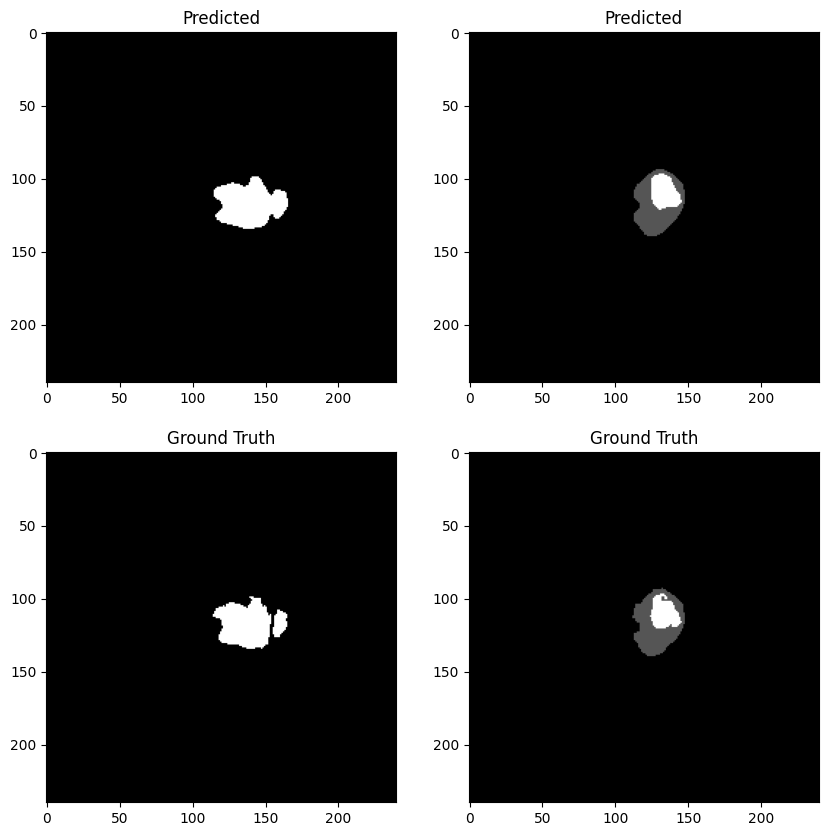

100%|██████████| 181/181 [08:55<00:00,  2.96s/it]



Average Training Loss: 0.0048794114668930764

Average Training DSC: [0.9994509  0.91854513 0.9544607  0.83418131]
Average Training ASSD: [ 0.0736478  10.34061304  6.65755249 13.71095096]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


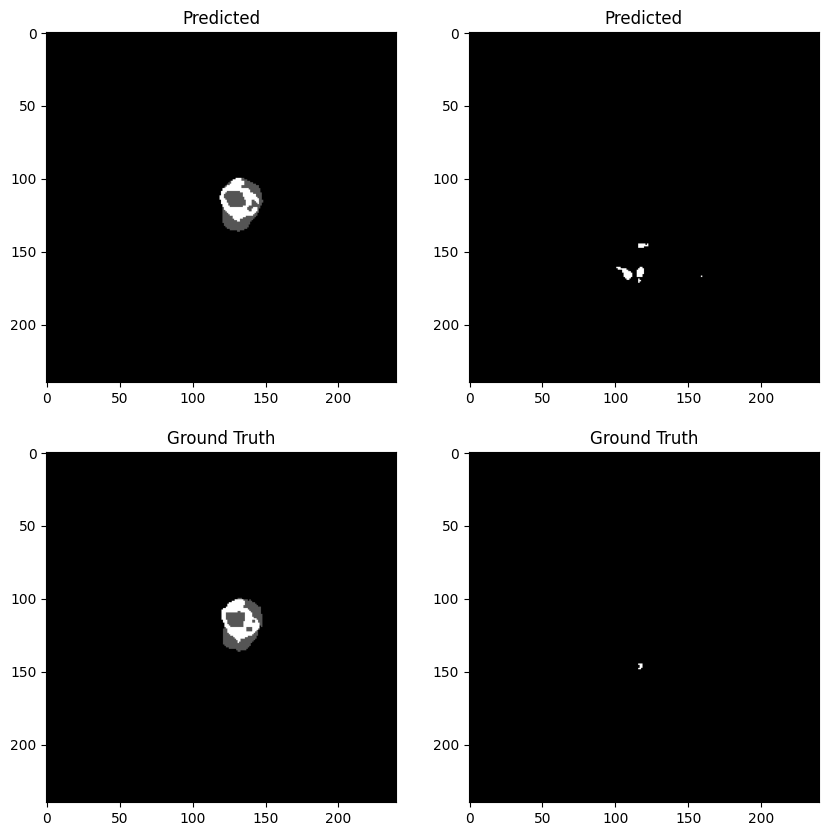

100%|██████████| 46/46 [01:27<00:00,  1.90s/it]


Average Validation Loss: 0.011130239976489025

Average Validation DSC: [0.99873959 0.82878437 0.8897949  0.73283866]
Average Validation ASSD: [ 0.3753073  37.17876343 25.88073092  8.59409443]
Epoch 52/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


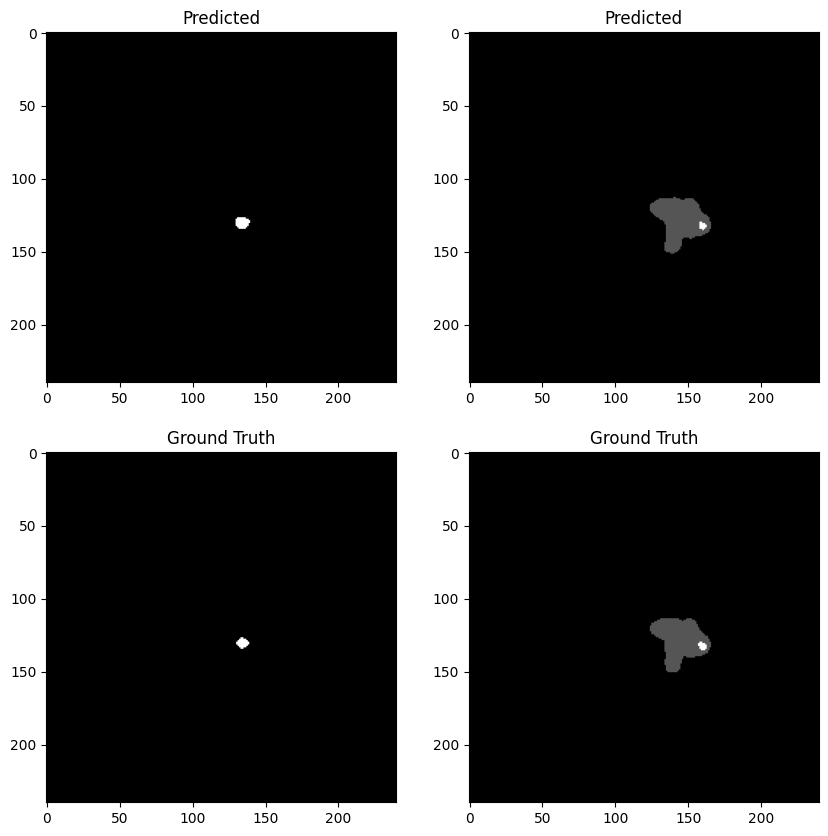

100%|██████████| 181/181 [08:53<00:00,  2.95s/it]



Average Training Loss: 0.004730741261859625

Average Training DSC: [0.99946406 0.92369747 0.95442011 0.83752688]
Average Training ASSD: [ 0.07275034  9.07364938  6.74872327 14.02467329]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


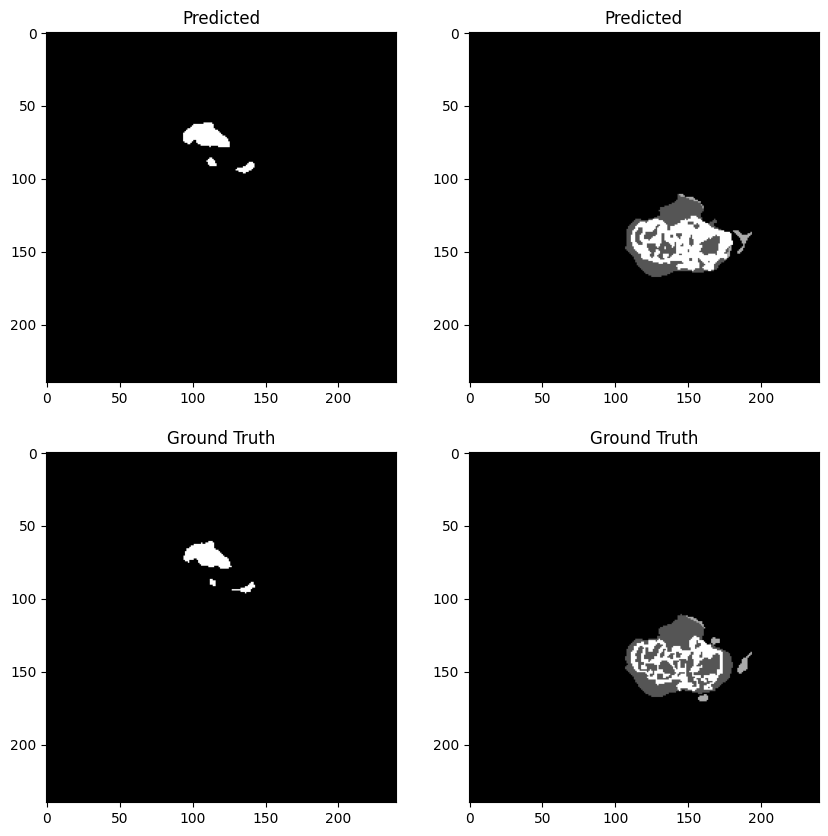

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.008969416538172442

Average Validation DSC: [0.9992115  0.88324525 0.93973033 0.78030467]
Average Validation ASSD: [ 0.11678982 16.84032132  8.47552193 17.14673044]
Epoch 53/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


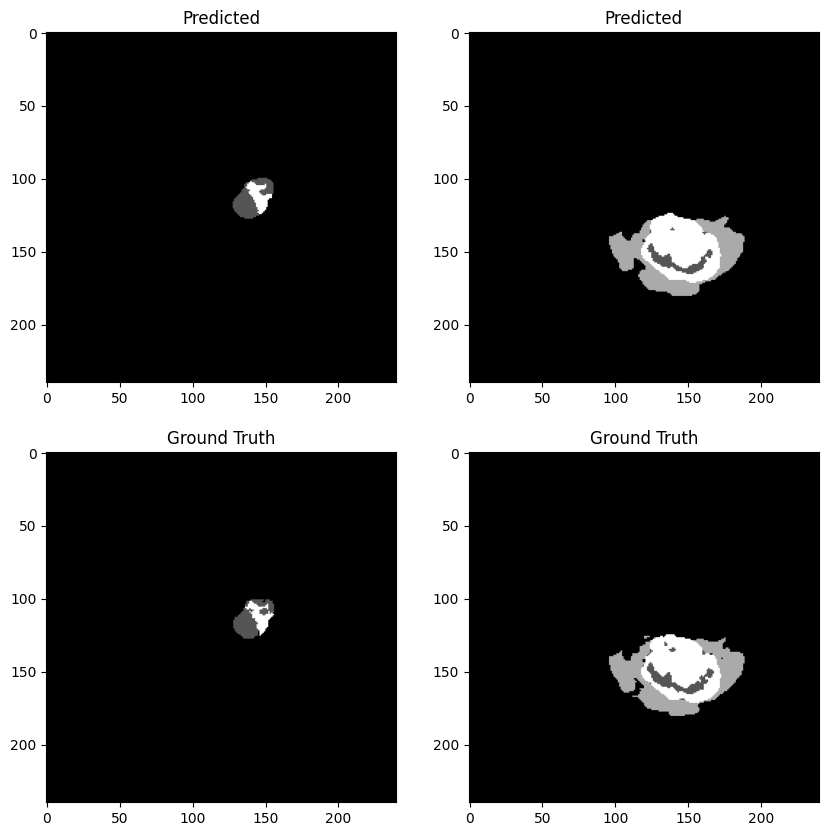

100%|██████████| 181/181 [08:52<00:00,  2.94s/it]



Average Training Loss: 0.004342383433658197

Average Training DSC: [0.99951609 0.92921096 0.95784708 0.84478605]
Average Training ASSD: [ 0.06529554  7.73475973  6.15507513 14.16629312]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


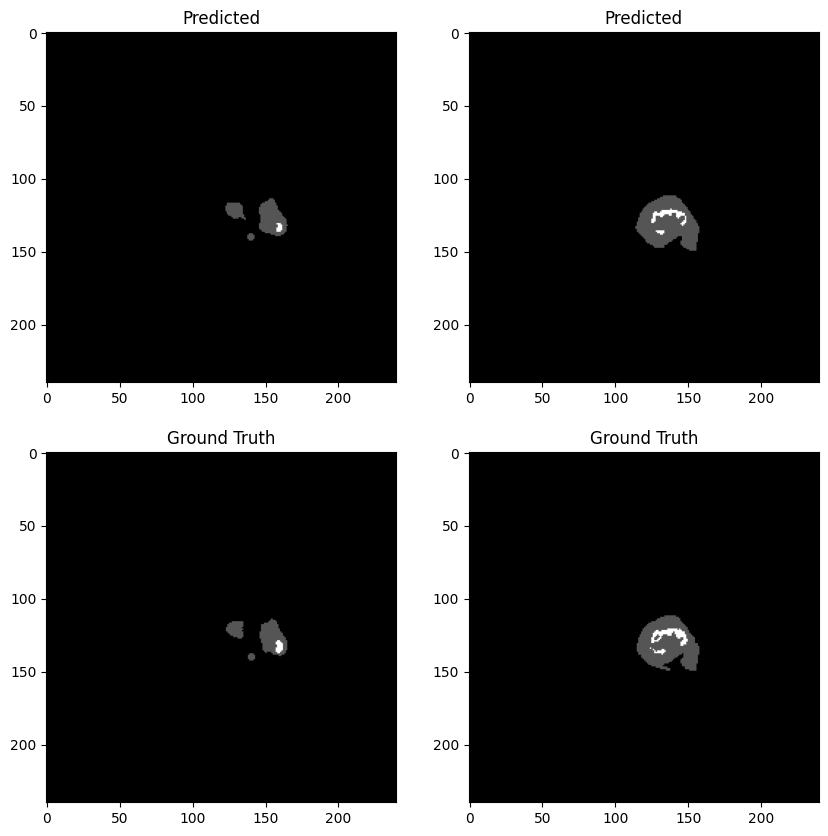

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.008505214552354553

Average Validation DSC: [0.99924735 0.87773167 0.93640795 0.76558937]
Average Validation ASSD: [ 0.11771705 22.99273619  9.81617784 18.18265184]
Epoch 54/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


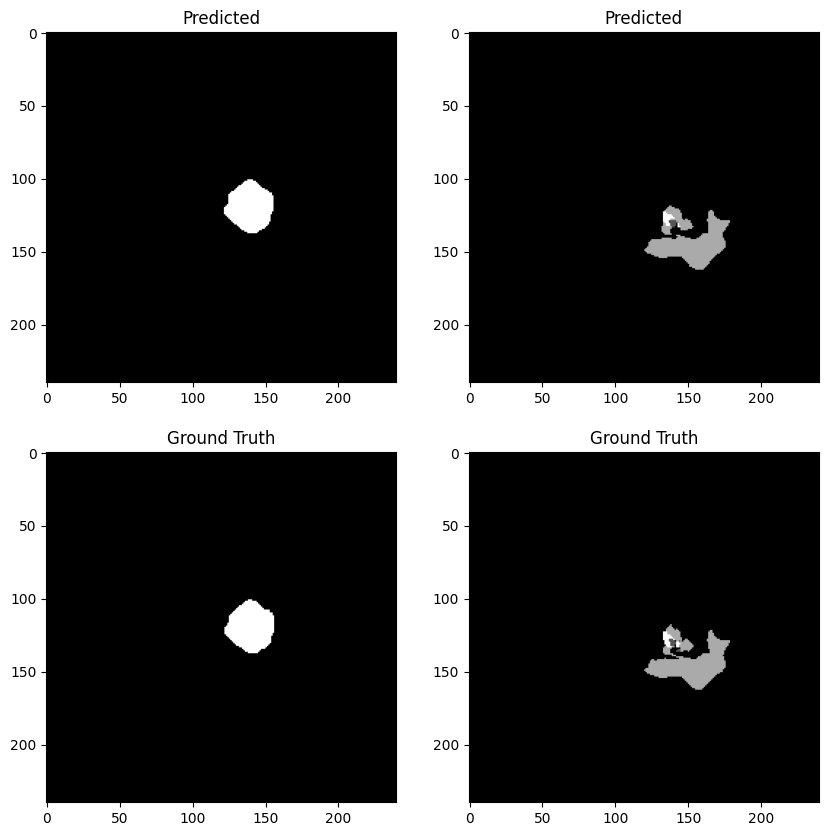

100%|██████████| 181/181 [08:49<00:00,  2.93s/it]



Average Training Loss: 0.004071815451349836

Average Training DSC: [0.99953323 0.9341192  0.95972927 0.85222563]
Average Training ASSD: [ 0.06196704  6.96777988  5.07587072 14.03812098]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


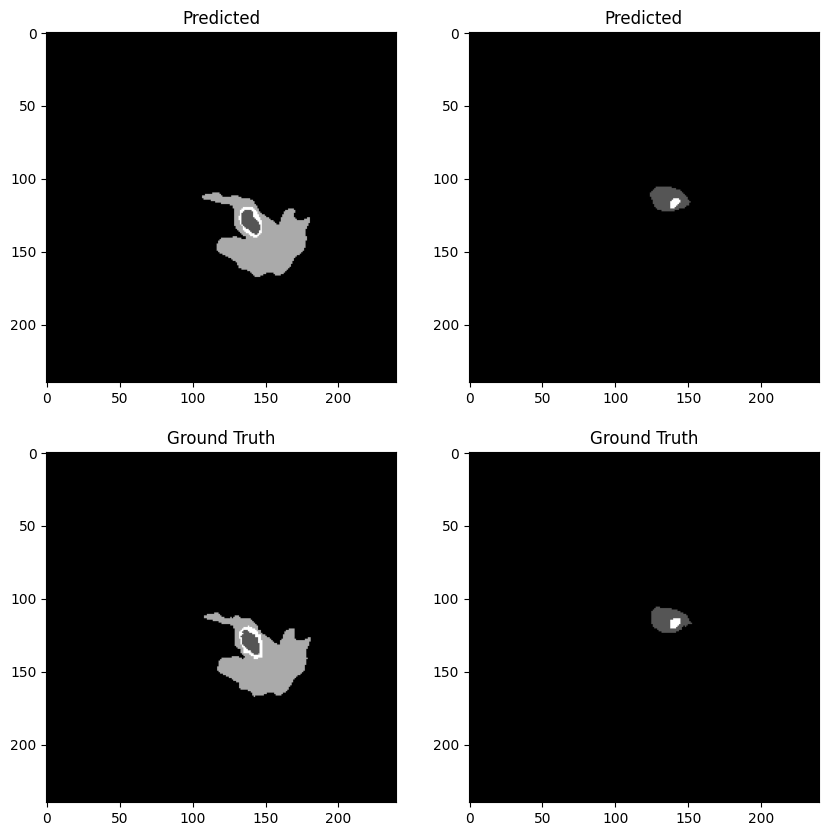

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.008834212790648251

Average Validation DSC: [0.99926732 0.88385336 0.94261841 0.76142054]
Average Validation ASSD: [ 0.10395915 18.45498754  8.81105748 18.80049955]
Epoch 55/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


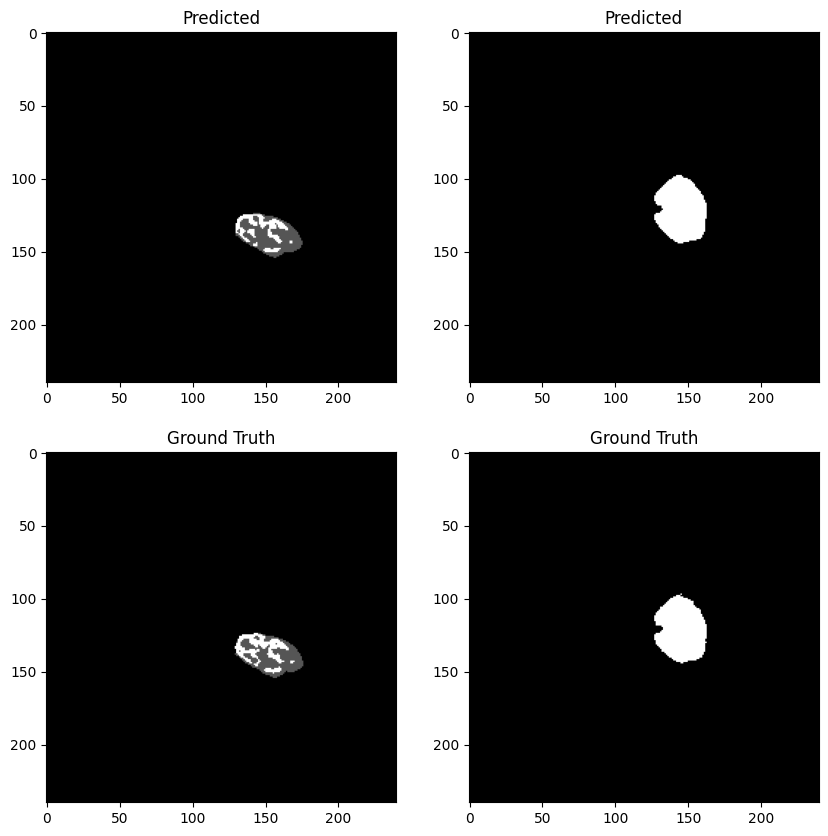

100%|██████████| 181/181 [08:47<00:00,  2.92s/it]



Average Training Loss: 0.004525831232917655

Average Training DSC: [0.99947751 0.92344001 0.95438239 0.84090486]
Average Training ASSD: [ 0.07111055 10.22560852  6.82811159 14.08951225]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


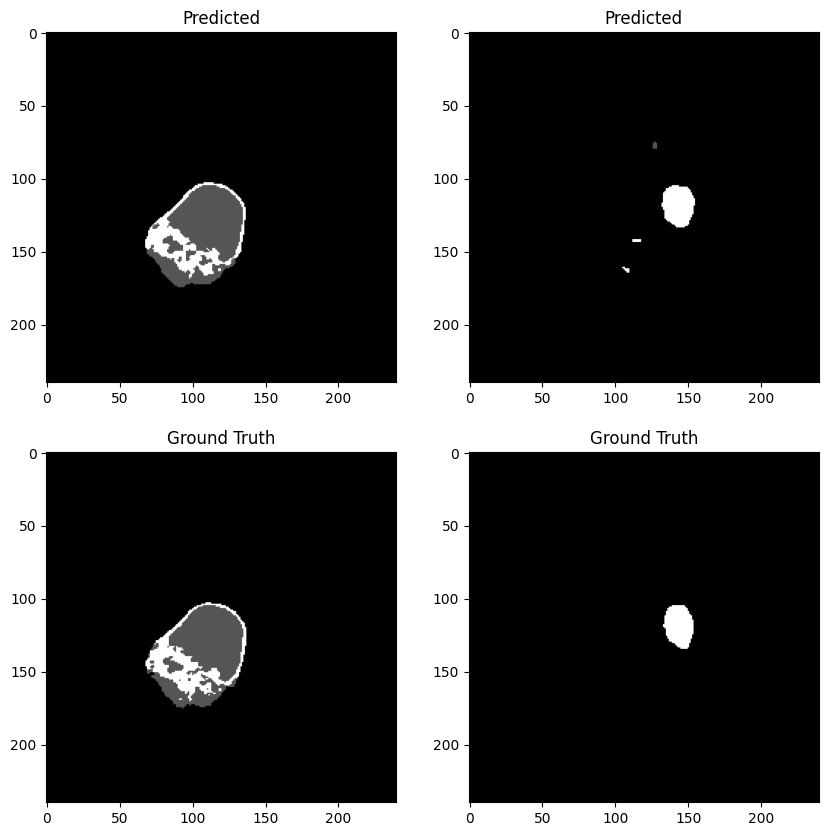

100%|██████████| 46/46 [01:28<00:00,  1.92s/it]


Average Validation Loss: 0.009771729642322854

Average Validation DSC: [0.99902202 0.8635818  0.87995126 0.77094995]
Average Validation ASSD: [ 0.19900023 25.04096733 29.5082817   7.41463835]
Epoch 56/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


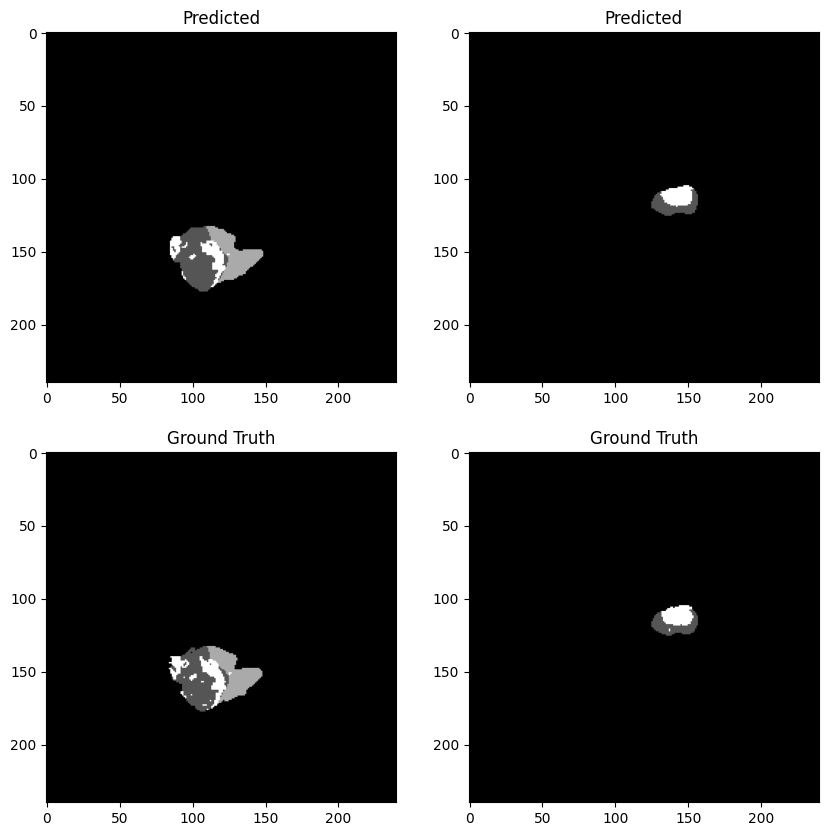

100%|██████████| 181/181 [08:49<00:00,  2.92s/it]



Average Training Loss: 0.004438981186156032

Average Training DSC: [0.99949601 0.93111625 0.95613535 0.84402669]
Average Training ASSD: [ 0.0697477   7.13820914  6.72903295 13.42064756]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


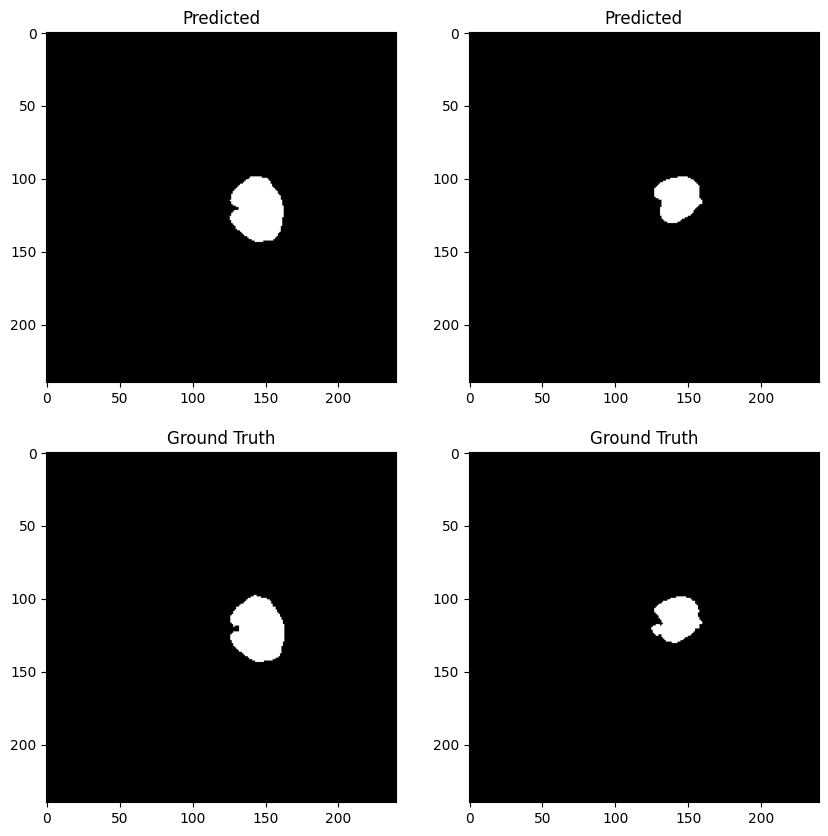

100%|██████████| 46/46 [01:25<00:00,  1.86s/it]


Average Validation Loss: 0.008451942101363902

Average Validation DSC: [0.99923407 0.87500748 0.92540969 0.78629883]
Average Validation ASSD: [ 0.12174012 20.77213758 13.7095783  14.06427809]
Epoch 57/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


100%|██████████| 181/181 [08:54<00:00,  2.96s/it]



Average Training Loss: 0.00404747243255418

Average Training DSC: [0.99954076 0.93514672 0.95541988 0.85267561]
Average Training ASSD: [ 0.06143247  6.70498154  6.90523302 13.36018546]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


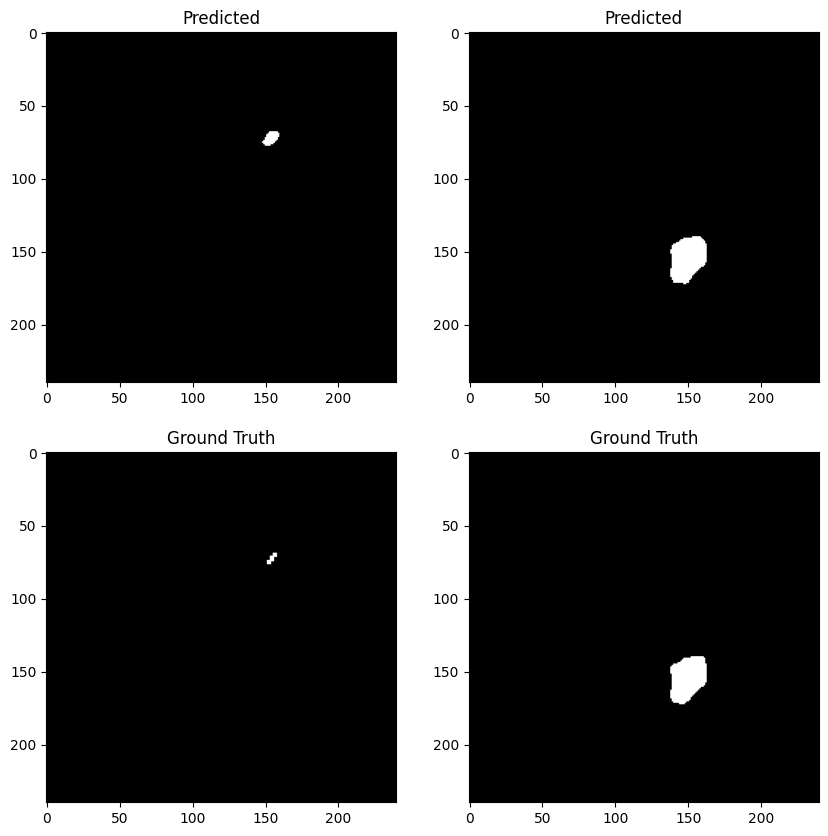

100%|██████████| 46/46 [01:25<00:00,  1.85s/it]


Average Validation Loss: 0.00920627419533127

Average Validation DSC: [0.99927493 0.88250082 0.90894738 0.78399249]
Average Validation ASSD: [ 0.11213925 16.84430156 20.5985662  13.31894742]
Epoch 58/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


100%|██████████| 181/181 [08:50<00:00,  2.93s/it]



Average Training Loss: 0.0044161218002397385

Average Training DSC: [0.99952914 0.92045868 0.95821716 0.84833026]
Average Training ASSD: [ 0.06310265 10.56175508  6.22787639 13.93291413]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


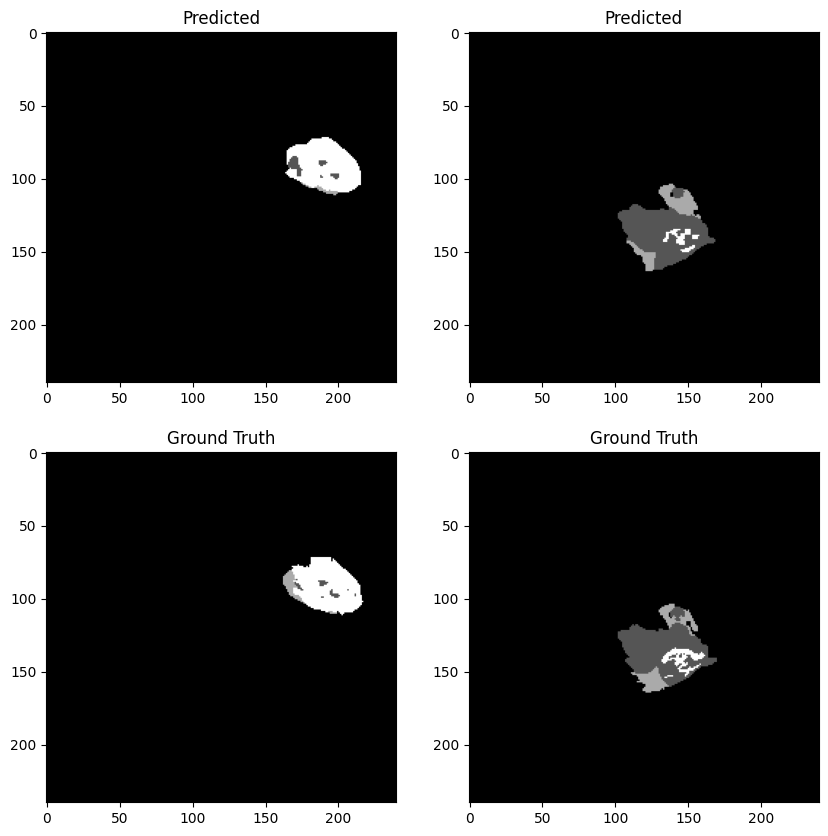

100%|██████████| 46/46 [01:25<00:00,  1.86s/it]


Average Validation Loss: 0.010835271794348955

Average Validation DSC: [0.99884928 0.80970772 0.93422738 0.68495507]
Average Validation ASSD: [ 0.19894661 40.84925277  8.57626164 35.08089744]
Epoch 59/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


100%|██████████| 181/181 [08:51<00:00,  2.94s/it]



Average Training Loss: 0.004532133342276291

Average Training DSC: [0.9995016  0.92272499 0.94762568 0.83884535]
Average Training ASSD: [ 0.06790867  9.73451005  9.41132342 13.66831234]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [01:28<00:00,  1.93s/it]


Average Validation Loss: 0.011146200345019284

Average Validation DSC: [0.9989674  0.86721687 0.93566012 0.72513324]
Average Validation ASSD: [ 0.17647854 20.17747311  8.52186369 27.80792904]
Epoch 60/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


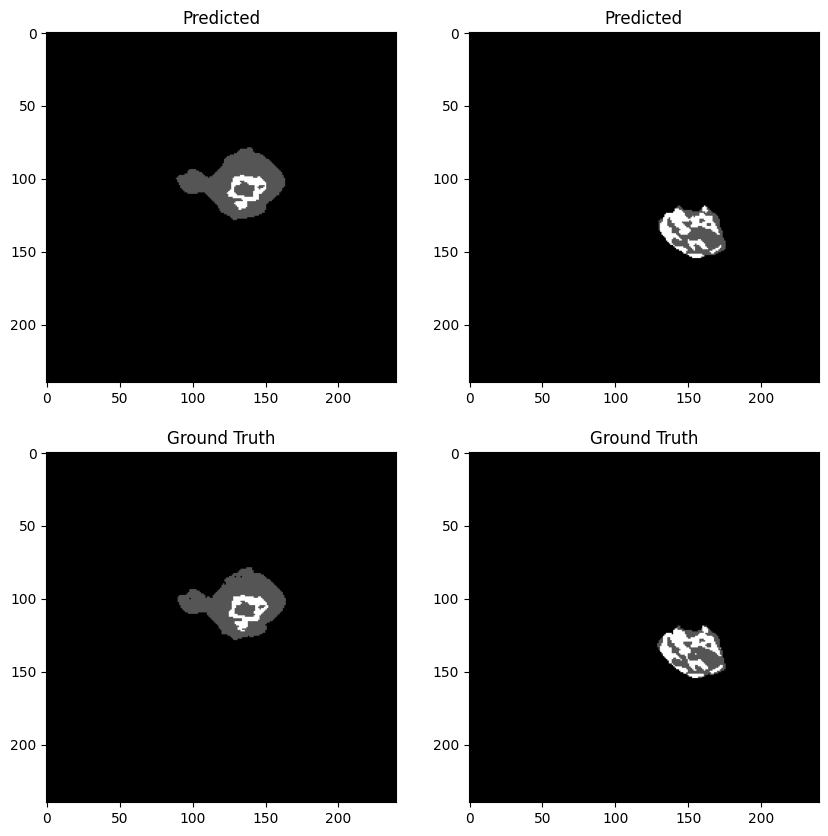

100%|██████████| 181/181 [08:53<00:00,  2.94s/it]



Average Training Loss: 0.004032610091046322

Average Training DSC: [0.99954588 0.9333945  0.95946918 0.85384749]
Average Training ASSD: [ 0.05938863  7.04193109  5.89514841 13.12518972]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


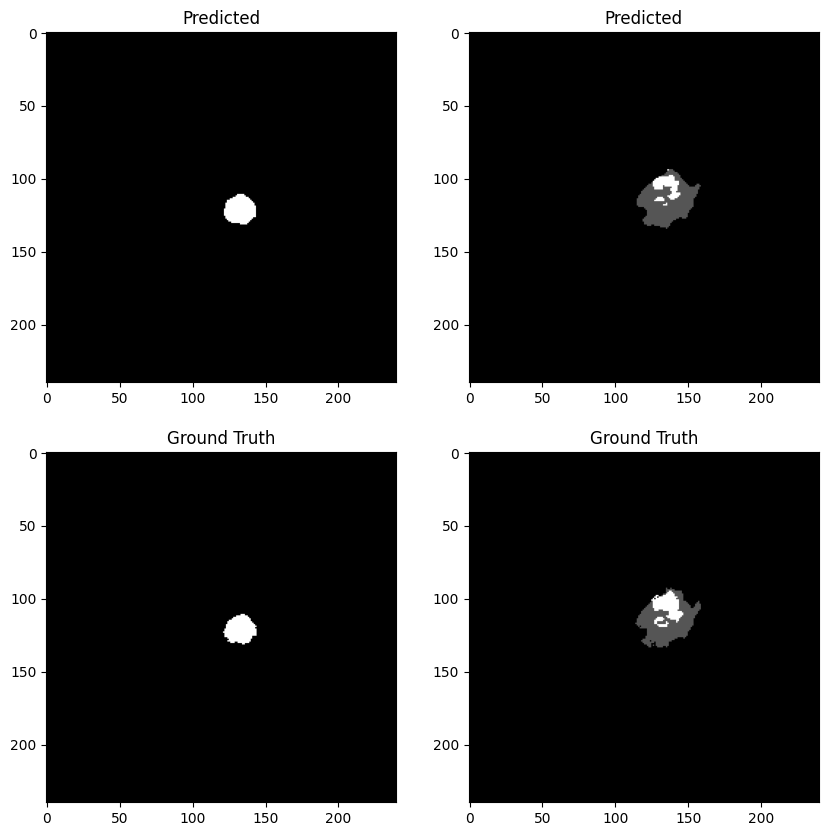

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.008826397359371185

Average Validation DSC: [0.99923786 0.8861534  0.91445777 0.78253707]
Average Validation ASSD: [ 0.11711284 19.07416985 18.29443549 15.84209964]
Epoch 61/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


100%|██████████| 181/181 [08:48<00:00,  2.92s/it]



Average Training Loss: 0.0037709561315524645

Average Training DSC: [0.99956505 0.94017877 0.96346859 0.86051539]
Average Training ASSD: [ 0.05762693  6.01800849  4.95873768 12.35712797]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [01:23<00:00,  1.81s/it]


Average Validation Loss: 0.012054744571366387

Average Validation DSC: [0.99886922 0.88177739 0.93583572 0.74275624]
Average Validation ASSD: [ 0.17917291 17.18532165  6.89391403 23.38117289]
Epoch 62/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


100%|██████████| 181/181 [08:50<00:00,  2.93s/it]



Average Training Loss: 0.0038201829433976288

Average Training DSC: [0.99957977 0.93688392 0.9622333  0.86013726]
Average Training ASSD: [ 0.0555367   7.10633321  5.37784656 13.08736191]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


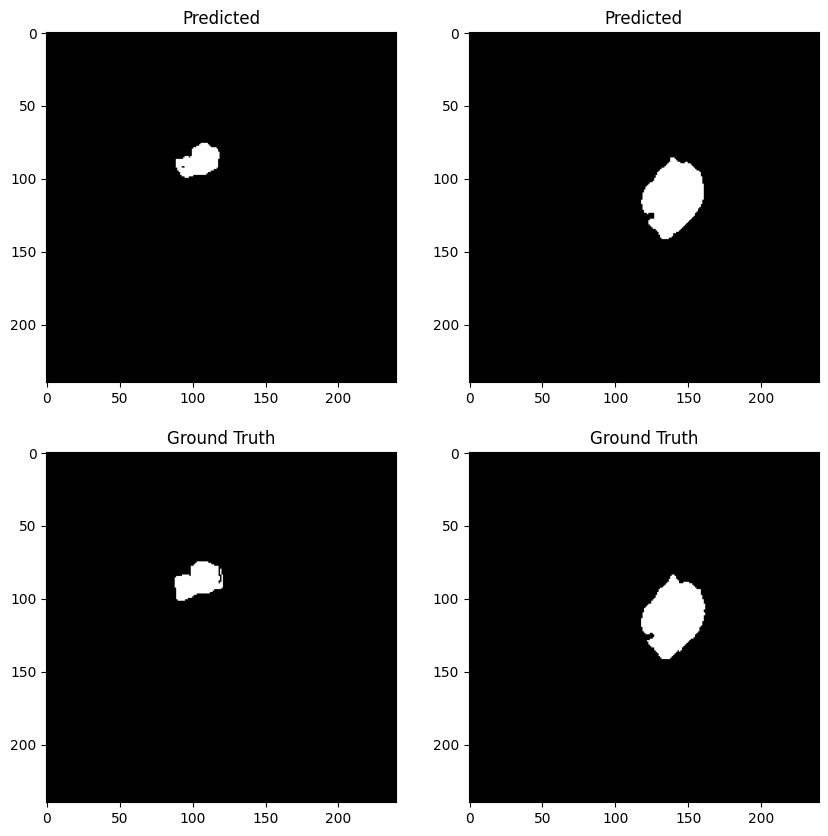

100%|██████████| 46/46 [01:24<00:00,  1.85s/it]


Average Validation Loss: 0.008431458288965665

Average Validation DSC: [0.99922203 0.8900329  0.94358802 0.77301683]
Average Validation ASSD: [ 0.1170654  17.77736829  8.77073621 20.26660107]
Epoch 63/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


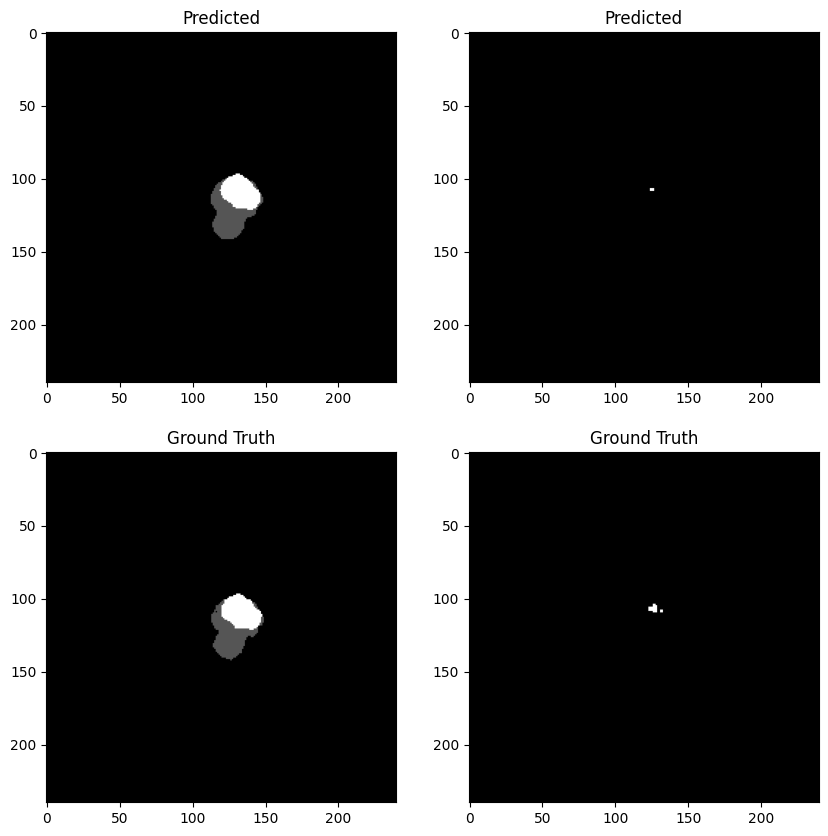

100%|██████████| 181/181 [08:49<00:00,  2.92s/it]



Average Training Loss: 0.0037299145858230593

Average Training DSC: [0.99958045 0.93706249 0.96369203 0.86308722]
Average Training ASSD: [ 0.05455138  7.1813334   4.71387766 12.56391075]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


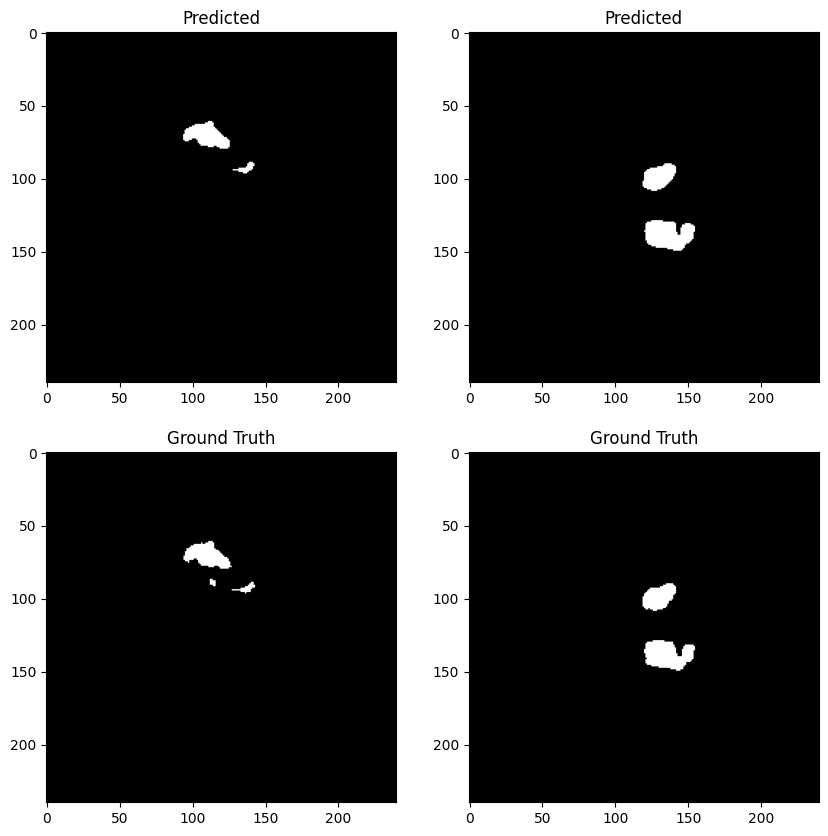

100%|██████████| 46/46 [01:25<00:00,  1.85s/it]


Average Validation Loss: 0.00811109137620129

Average Validation DSC: [0.99930924 0.89281094 0.93795559 0.80198622]
Average Validation ASSD: [ 0.0979572  18.38702619 10.7252078  12.11299928]
Epoch 64/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


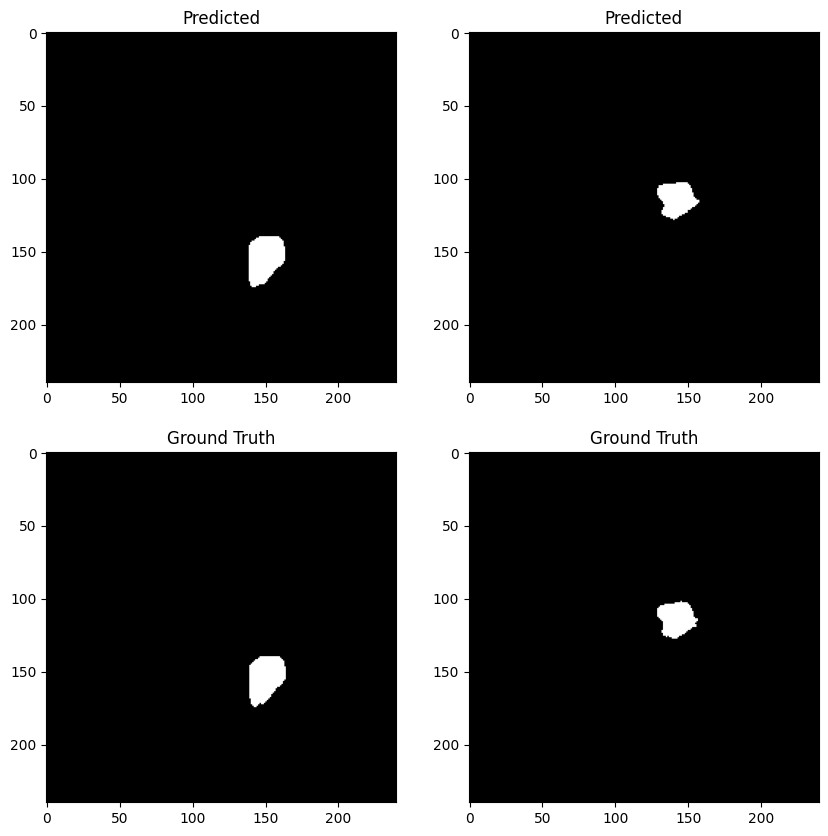

100%|██████████| 181/181 [08:47<00:00,  2.91s/it]



Average Training Loss: 0.0037672713370633555

Average Training DSC: [0.99958828 0.93600742 0.95760131 0.86089841]
Average Training ASSD: [ 0.05677583  7.36122641  6.88342271 13.36423578]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [01:27<00:00,  1.91s/it]


Average Validation Loss: 0.014161074210120283

Average Validation DSC: [0.99817554 0.74972447 0.78092136 0.69055346]
Average Validation ASSD: [ 0.81400066 58.96167996 63.741593    8.63895337]
Epoch 65/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


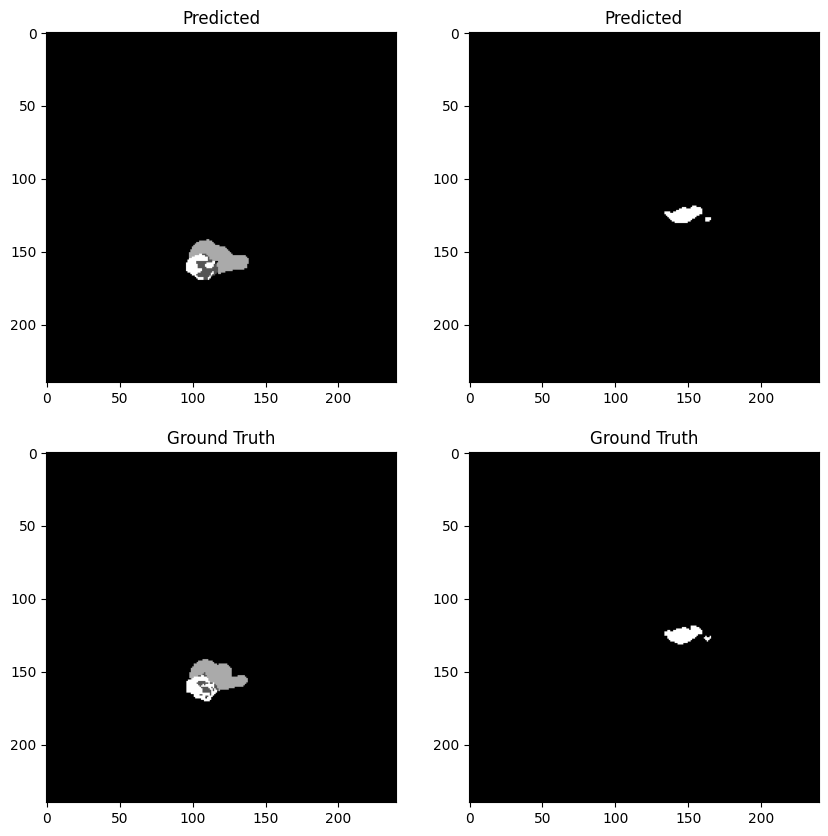

100%|██████████| 181/181 [08:48<00:00,  2.92s/it]



Average Training Loss: 0.00410023416798994

Average Training DSC: [0.99956062 0.92307458 0.95246046 0.8531506 ]
Average Training ASSD: [ 0.05825199 10.95705623  8.47289759 12.108005  ]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [01:25<00:00,  1.86s/it]


Average Validation Loss: 0.024787779796220686

Average Validation DSC: [0.99773335 0.77304749 0.87532376 0.64385163]
Average Validation ASSD: [ 0.30922277 30.12212329 21.89449855 24.8117103 ]
Epoch 66/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


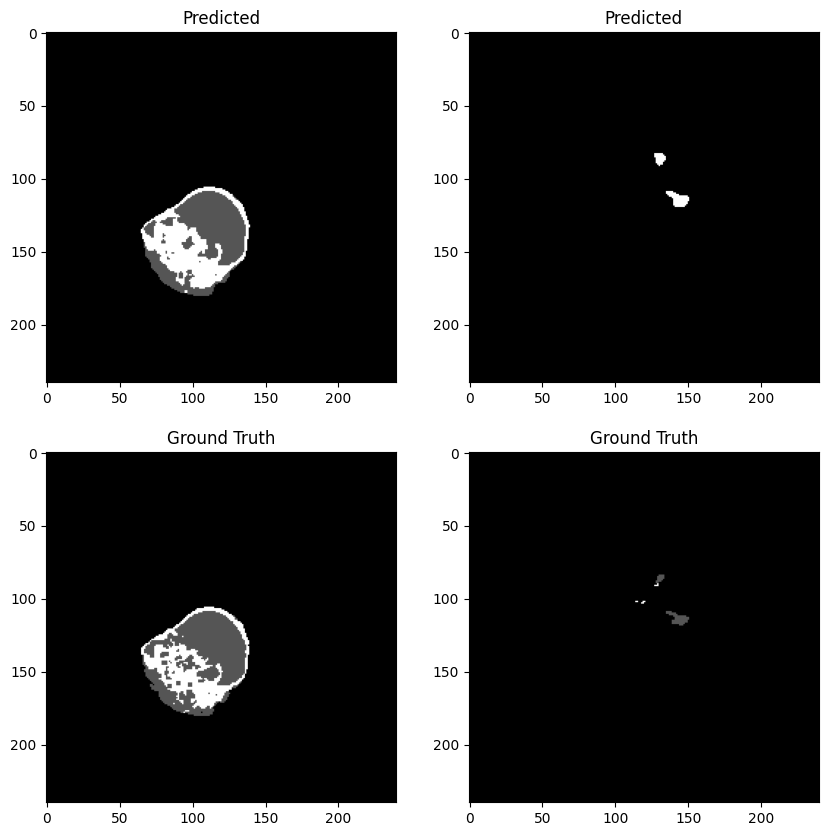

100%|██████████| 181/181 [08:51<00:00,  2.94s/it]



Average Training Loss: 0.004519609513162578

Average Training DSC: [0.99951115 0.9172621  0.94867203 0.84486156]
Average Training ASSD: [ 0.06727171 12.30370373  8.5865894  12.44538828]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [01:25<00:00,  1.86s/it]


Average Validation Loss: 0.013988267265908096

Average Validation DSC: [0.99857526 0.80816847 0.66452234 0.68404783]
Average Validation ASSD: [  0.75549913  34.08080965 101.16211449   8.57984061]
Epoch 67/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


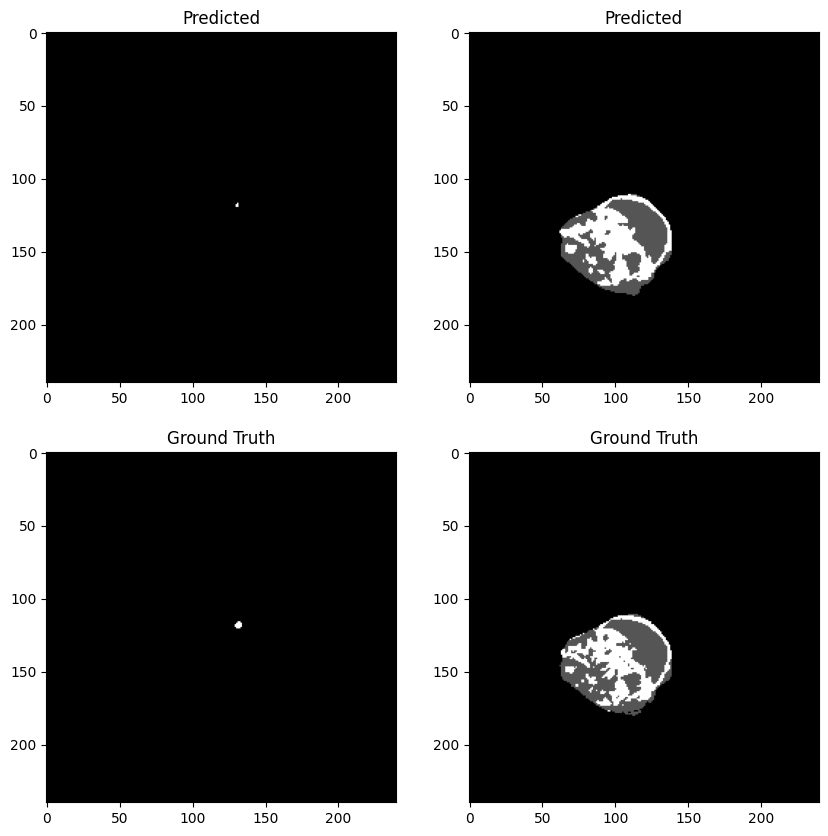

100%|██████████| 181/181 [08:51<00:00,  2.94s/it]



Average Training Loss: 0.004124418036106624

Average Training DSC: [0.99954771 0.93553616 0.95555694 0.85553099]
Average Training ASSD: [ 0.06082421  6.94812998  7.05639015 11.93250915]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [01:25<00:00,  1.85s/it]


Average Validation Loss: 0.009962867525325197

Average Validation DSC: [0.99918616 0.87596295 0.92253102 0.77612301]
Average Validation ASSD: [ 0.11006725 17.86050355  9.87152194 16.60130382]
Epoch 68/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


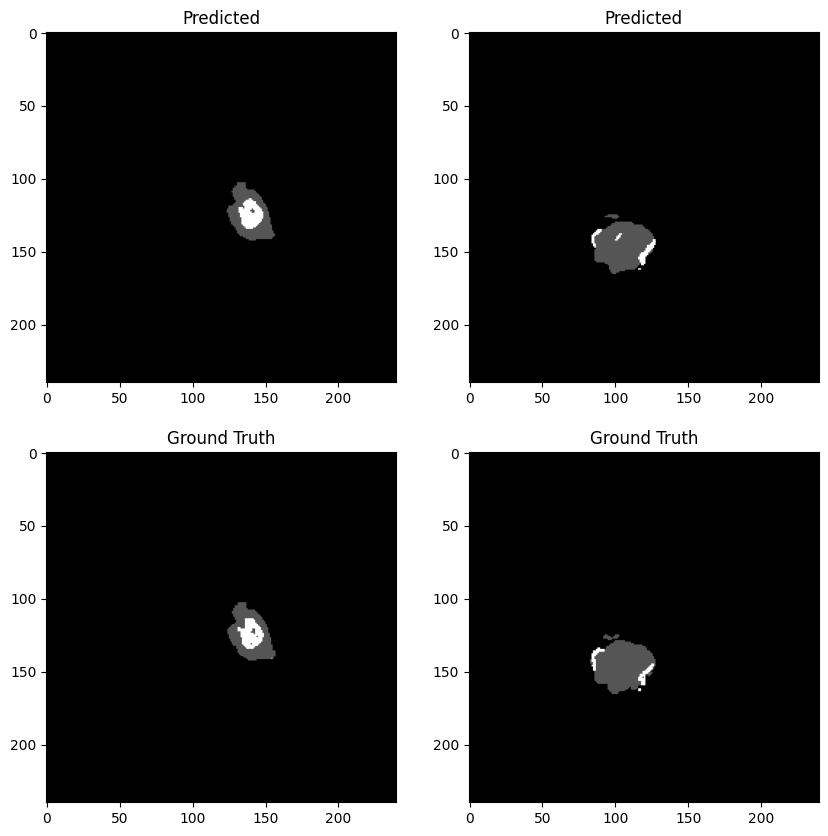

100%|██████████| 181/181 [08:47<00:00,  2.91s/it]



Average Training Loss: 0.003624552465944412

Average Training DSC: [0.99960995 0.93921395 0.95837912 0.8657816 ]
Average Training ASSD: [ 0.0520475   6.59761851  6.97385272 12.81759005]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


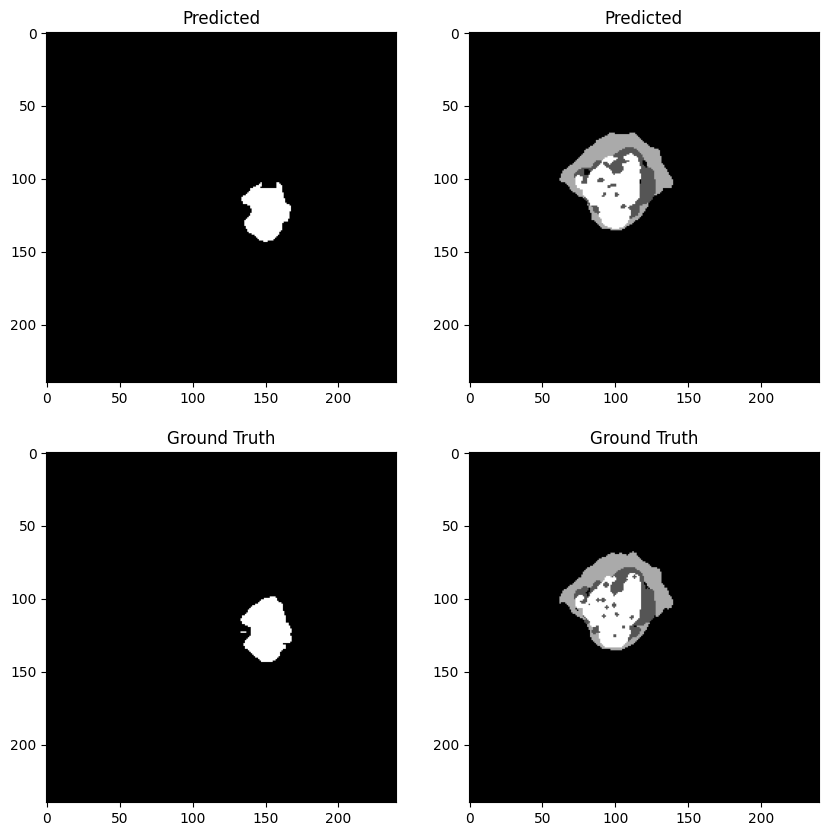

100%|██████████| 46/46 [01:27<00:00,  1.90s/it]


Average Validation Loss: 0.008981319316460387

Average Validation DSC: [0.99927737 0.88226884 0.94220832 0.76558462]
Average Validation ASSD: [ 0.11827765 21.99855167  8.46310426 24.83358338]
Epoch 69/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


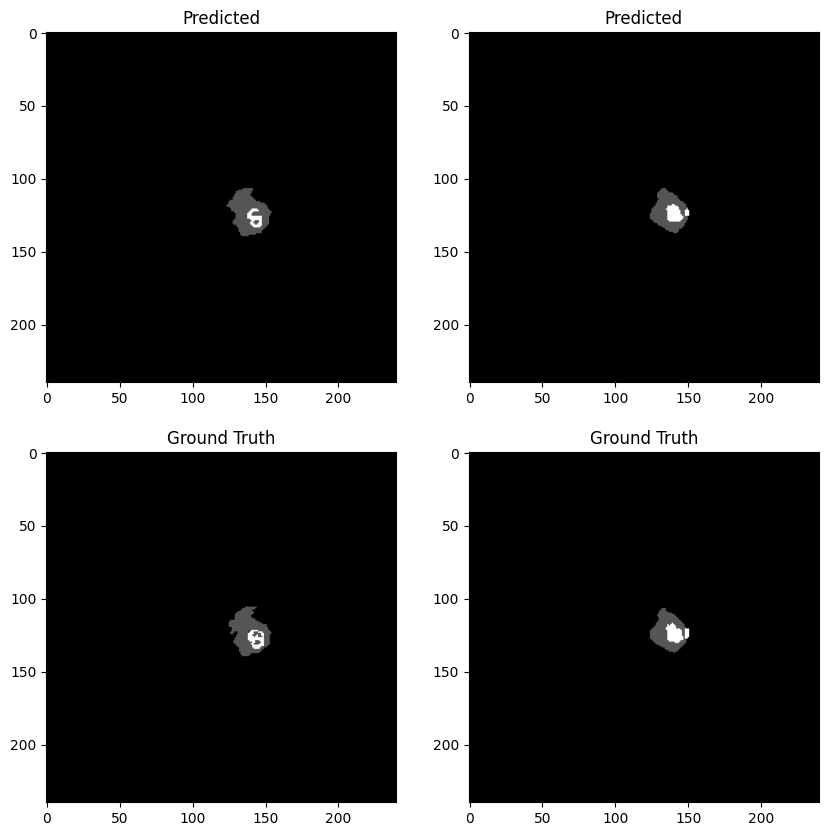

100%|██████████| 181/181 [08:54<00:00,  2.95s/it]



Average Training Loss: 0.00304555575021167

Average Training DSC: [0.99966954 0.95096016 0.96684758 0.87818202]
Average Training ASSD: [ 0.0456294   4.47727879  5.02540977 13.08437034]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


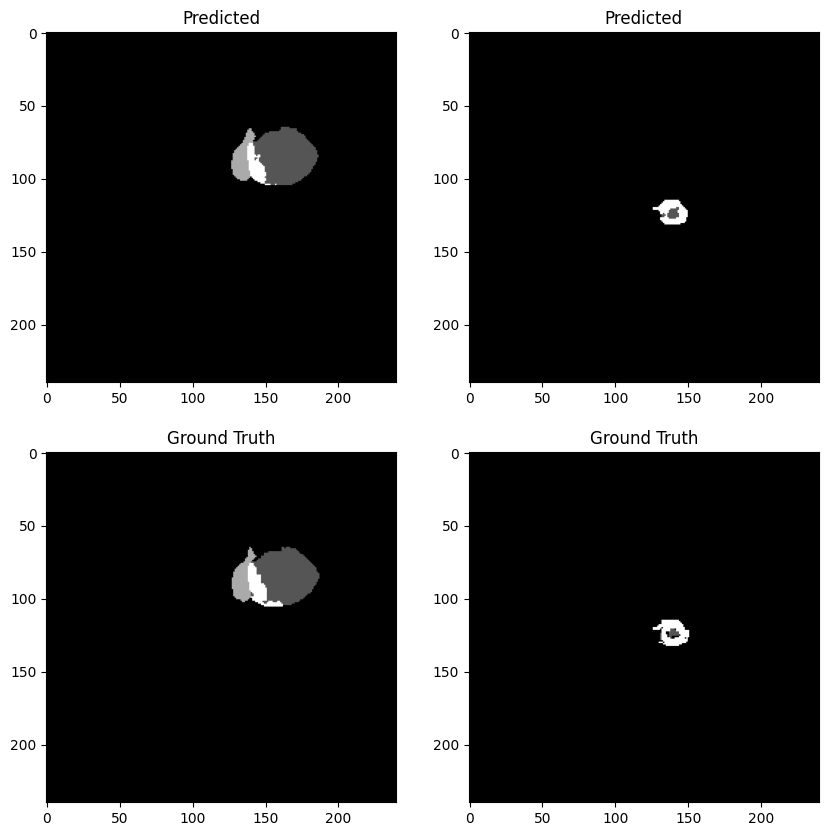

100%|██████████| 46/46 [01:24<00:00,  1.83s/it]


Average Validation Loss: 0.008508893028509034

Average Validation DSC: [0.99932141 0.89065429 0.94753315 0.77390517]
Average Validation ASSD: [ 0.10667967 16.45623985  8.07653583 21.2266385 ]
Epoch 70/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


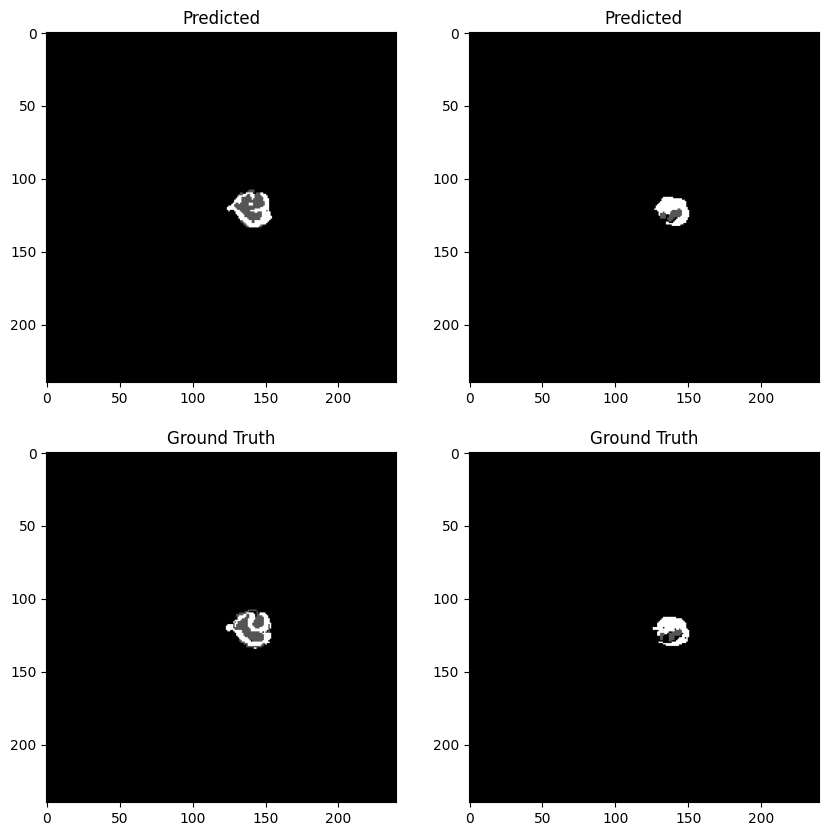

100%|██████████| 181/181 [08:53<00:00,  2.95s/it]



Average Training Loss: 0.003150590743679162

Average Training DSC: [0.99965547 0.94826976 0.96693991 0.87946789]
Average Training ASSD: [ 0.04524683  4.9027519   4.44256062 11.66154227]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


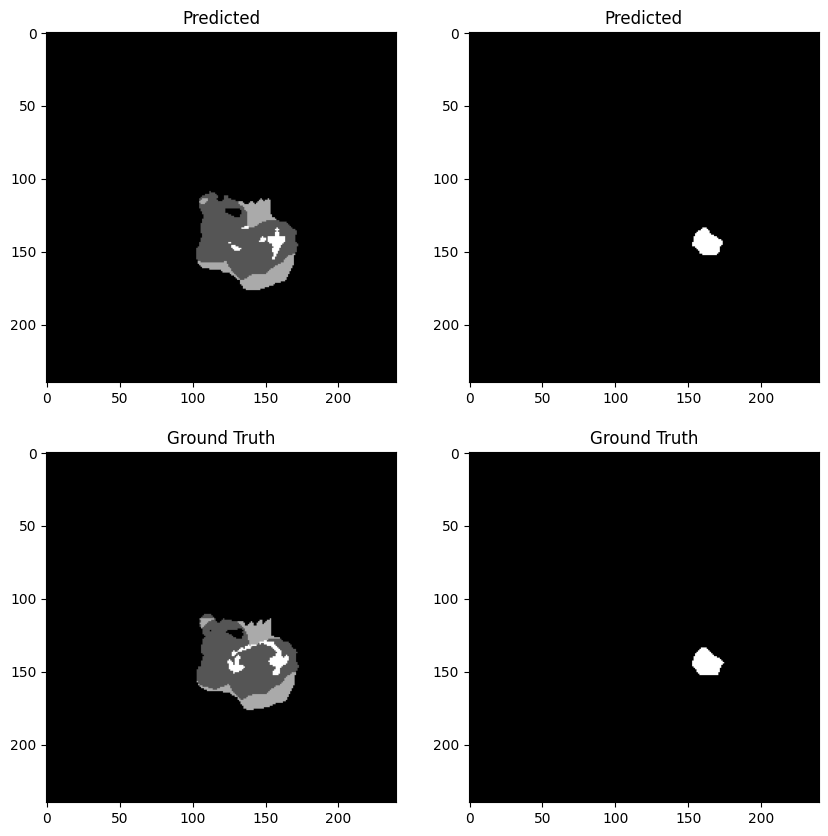

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.008438464264263925

Average Validation DSC: [0.99930278 0.88904428 0.94193263 0.79030109]
Average Validation ASSD: [ 0.09937515 18.73418068  8.13690548 12.43709296]
Epoch 71/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


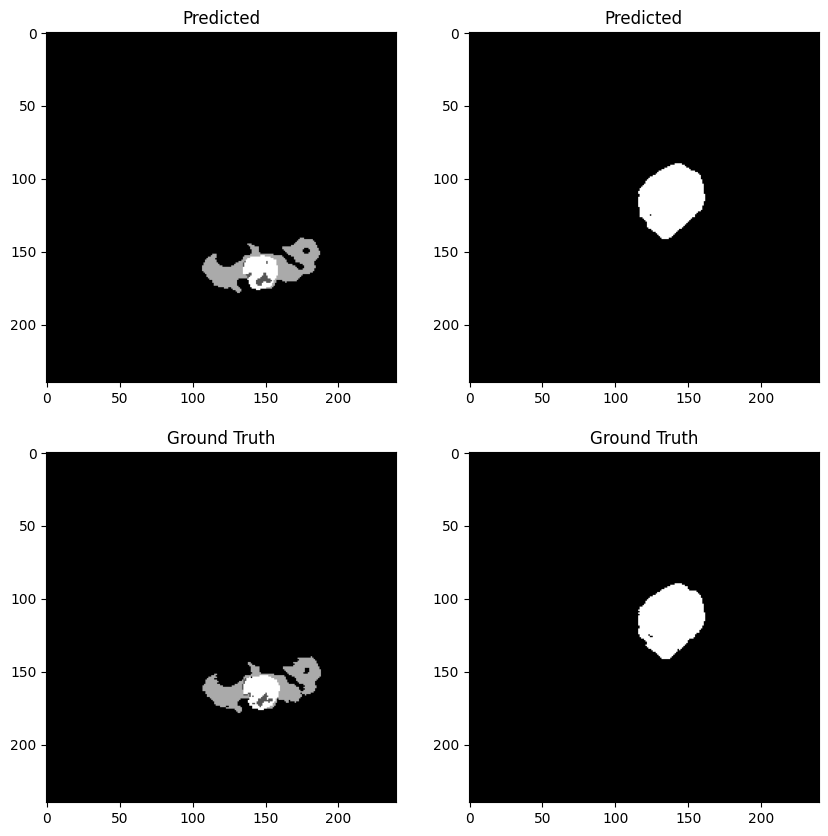

100%|██████████| 181/181 [08:53<00:00,  2.95s/it]



Average Training Loss: 0.0030339467699397665

Average Training DSC: [0.999665   0.94713924 0.96902088 0.88191416]
Average Training ASSD: [ 0.04402498  5.72452515  4.02411626 11.61401874]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


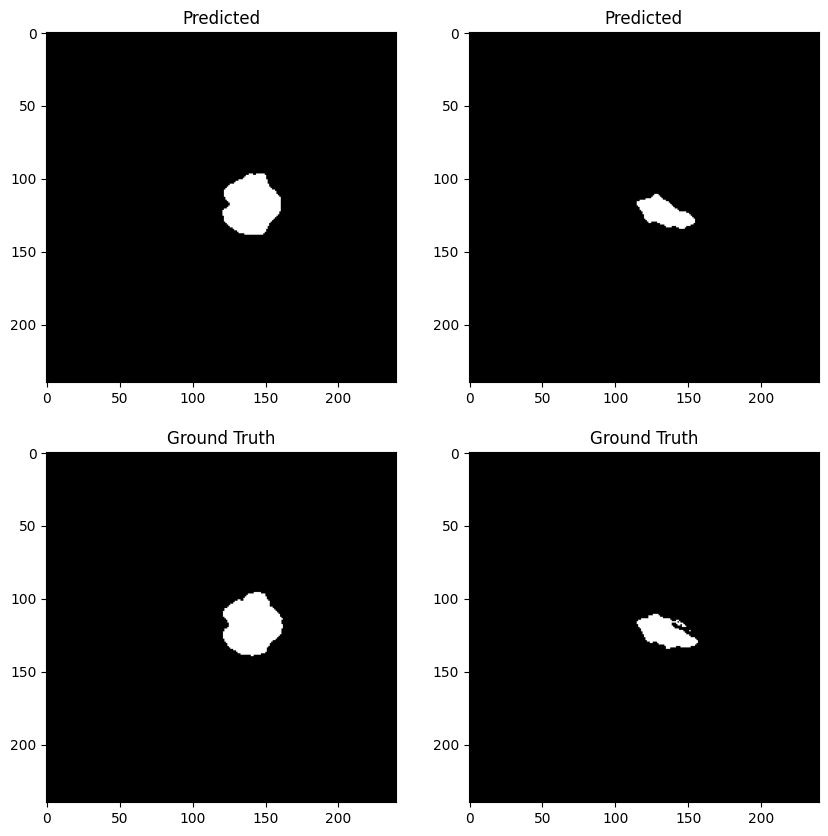

100%|██████████| 46/46 [01:24<00:00,  1.83s/it]


Average Validation Loss: 0.028820554179179926

Average Validation DSC: [0.99782785 0.77364088 0.87416057 0.64582097]
Average Validation ASSD: [ 0.29958198 28.2854044  22.60974891 25.92940977]
Epoch 72/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


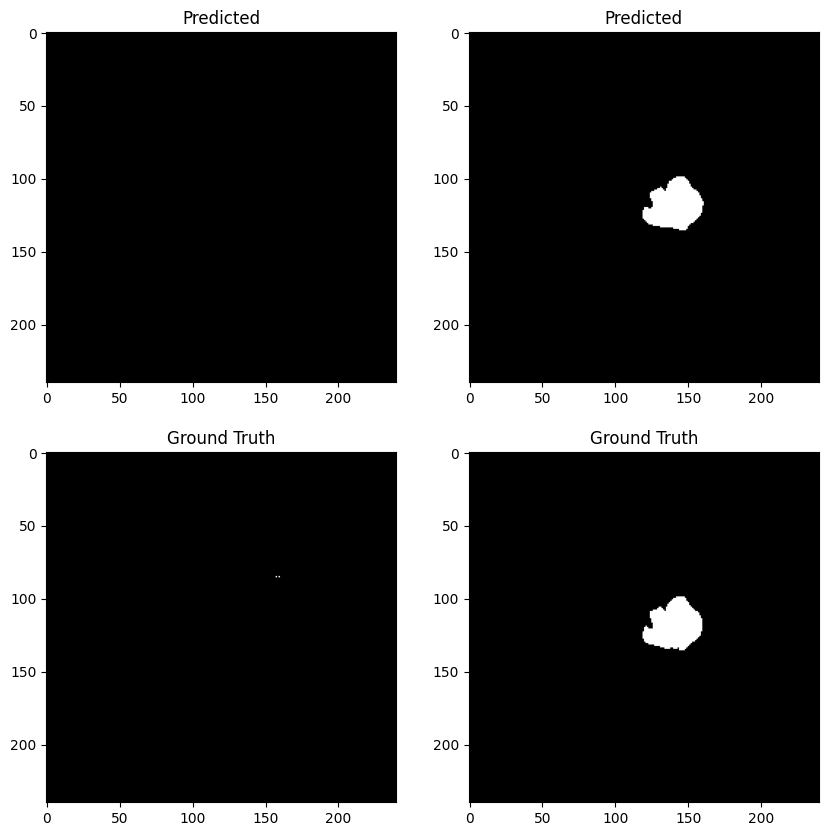

100%|██████████| 181/181 [08:52<00:00,  2.94s/it]



Average Training Loss: 0.0029764707921875527

Average Training DSC: [0.99966714 0.95114587 0.97005735 0.88262931]
Average Training ASSD: [ 0.04400116  4.5563786   3.68831157 12.38163985]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


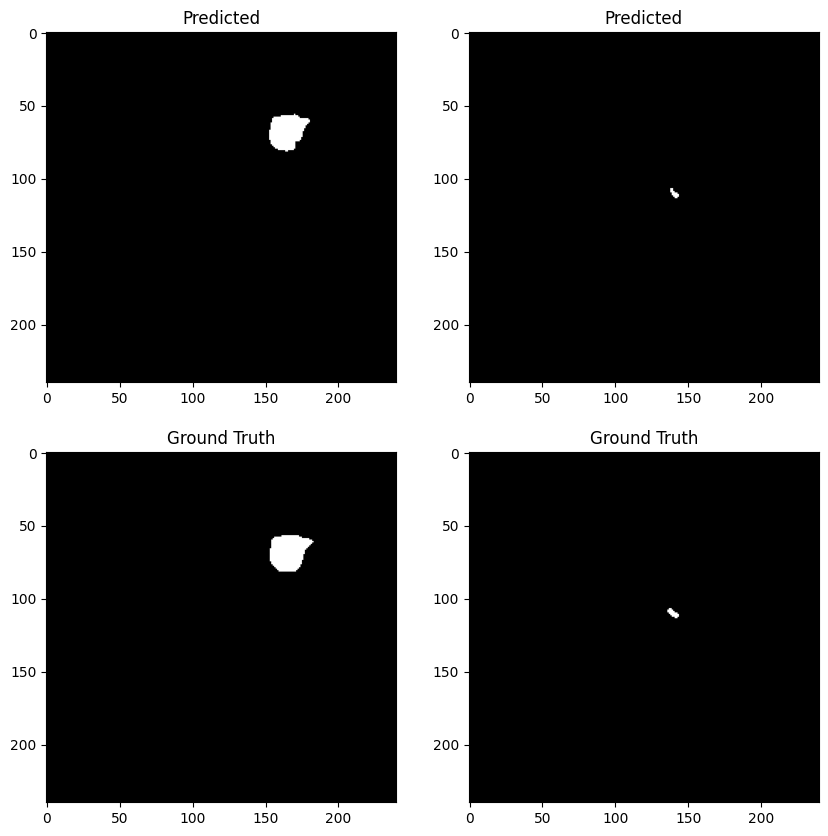

100%|██████████| 46/46 [01:26<00:00,  1.88s/it]


Average Validation Loss: 0.008840875097793405

Average Validation DSC: [0.99927644 0.89737108 0.94912314 0.80333198]
Average Validation ASSD: [ 0.1058385  16.09108167  5.83243441 14.29356887]
Epoch 73/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


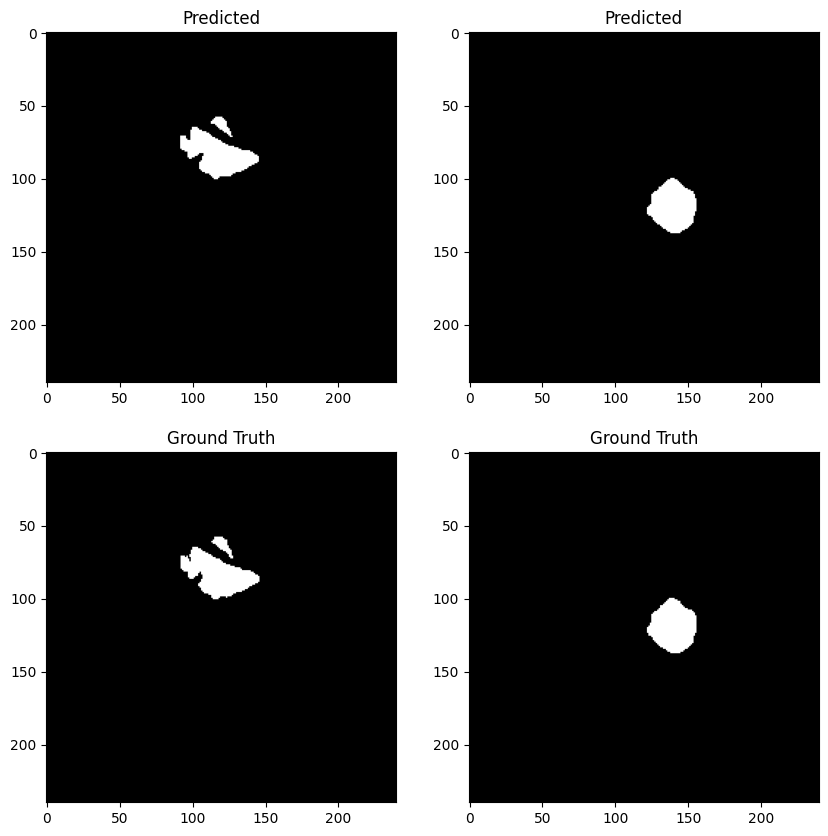

100%|██████████| 181/181 [08:50<00:00,  2.93s/it]



Average Training Loss: 0.002933817785053169

Average Training DSC: [0.99967184 0.95285443 0.97007148 0.88627352]
Average Training ASSD: [ 0.04329761  4.05519268  3.76854916 11.36199243]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


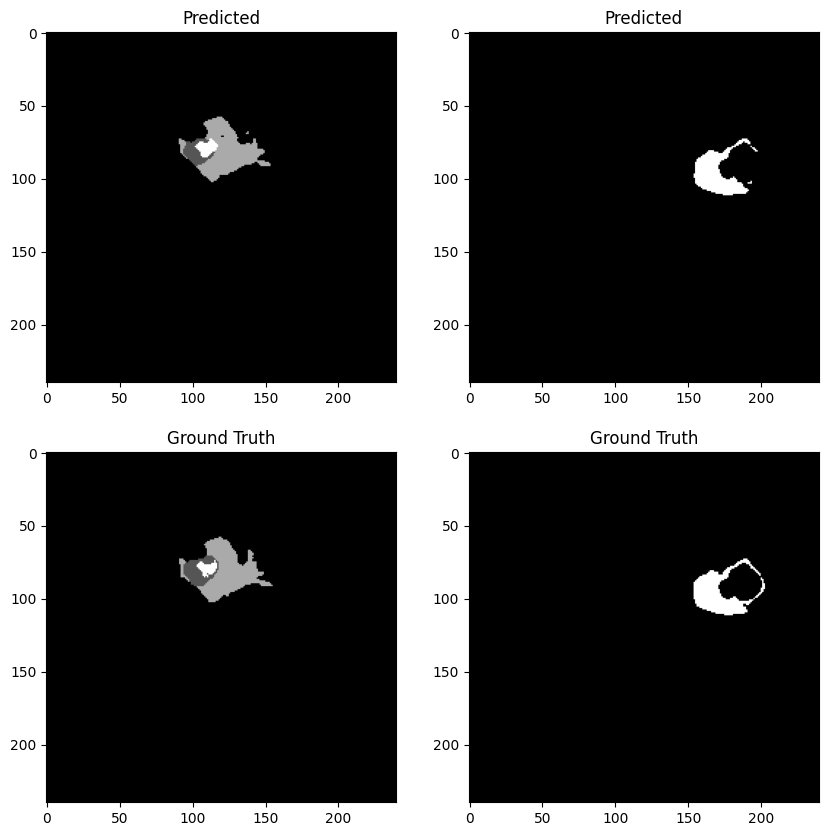

100%|██████████| 46/46 [01:28<00:00,  1.93s/it]


Average Validation Loss: 0.009335309580859283

Average Validation DSC: [0.9992132  0.867039   0.87593709 0.79086234]
Average Validation ASSD: [ 0.18255914 23.05872871 33.6619201   6.82570817]
Epoch 74/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


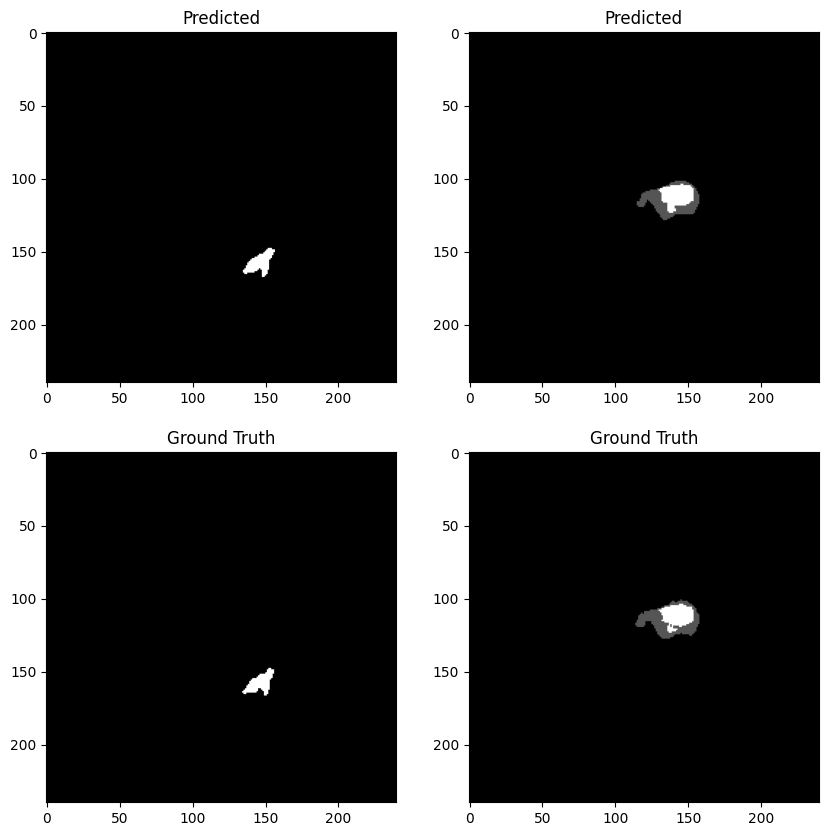

100%|██████████| 181/181 [08:54<00:00,  2.95s/it]



Average Training Loss: 0.0028510233445237106

Average Training DSC: [0.99968825 0.95477758 0.97123965 0.8910406 ]
Average Training ASSD: [ 0.0400273   3.4612617   3.3501179  10.48218207]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


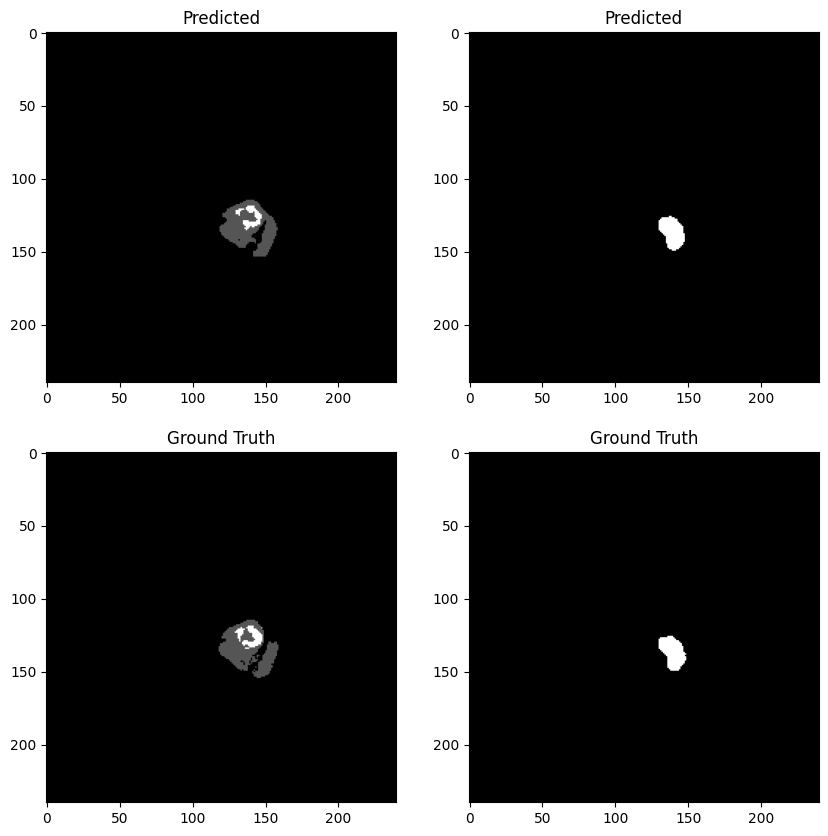

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.008591137046966216

Average Validation DSC: [0.99929073 0.87566899 0.93459627 0.79088099]
Average Validation ASSD: [ 0.13318915 23.32618664 12.35906031 11.944479  ]
Epoch 75/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


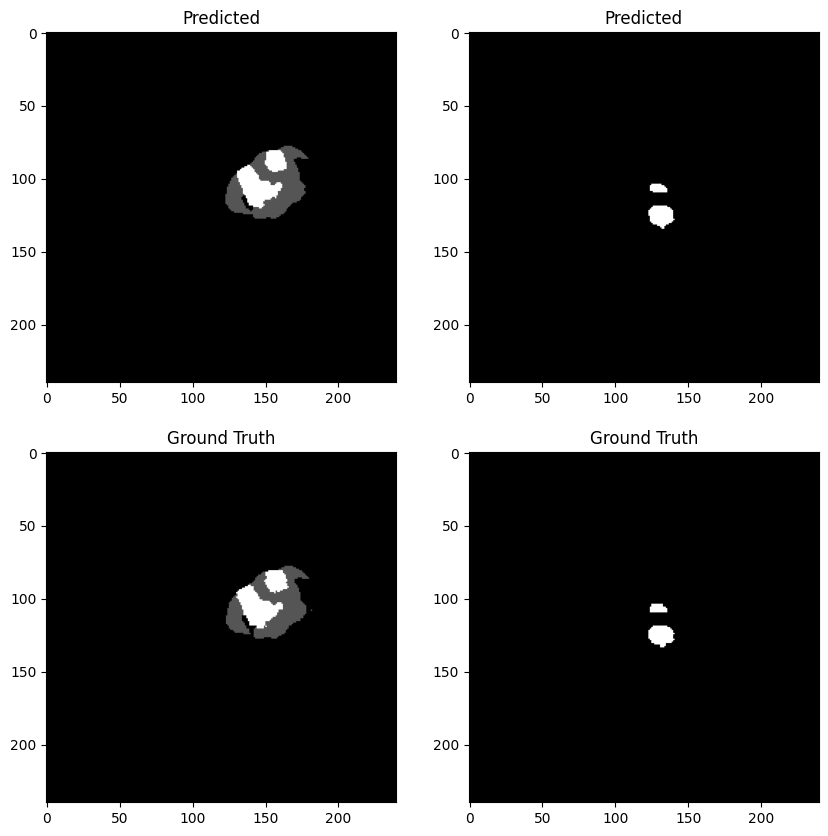

100%|██████████| 181/181 [08:52<00:00,  2.94s/it]



Average Training Loss: 0.0026706761625230066

Average Training DSC: [0.9997088  0.95611536 0.97131455 0.89367282]
Average Training ASSD: [ 0.03807366  3.62266627  3.60052479 11.29807217]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


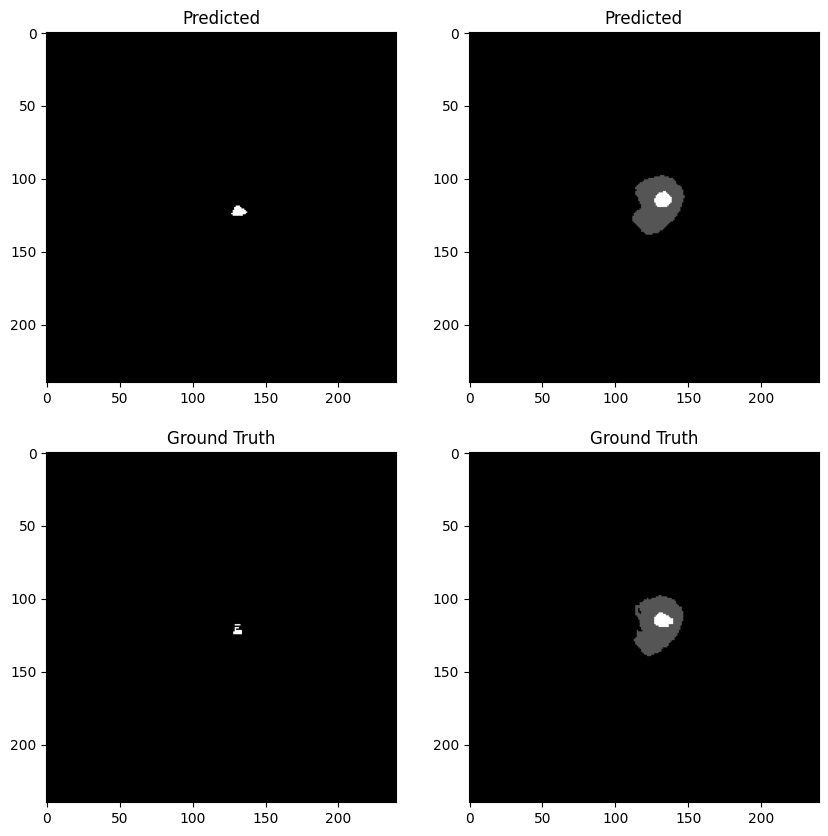

100%|██████████| 46/46 [01:24<00:00,  1.84s/it]


Average Validation Loss: 0.008693198415288783

Average Validation DSC: [0.99935863 0.89865169 0.94248915 0.80719809]
Average Validation ASSD: [ 0.0943597  17.05663054 10.04949247 13.35170139]
Epoch 76/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


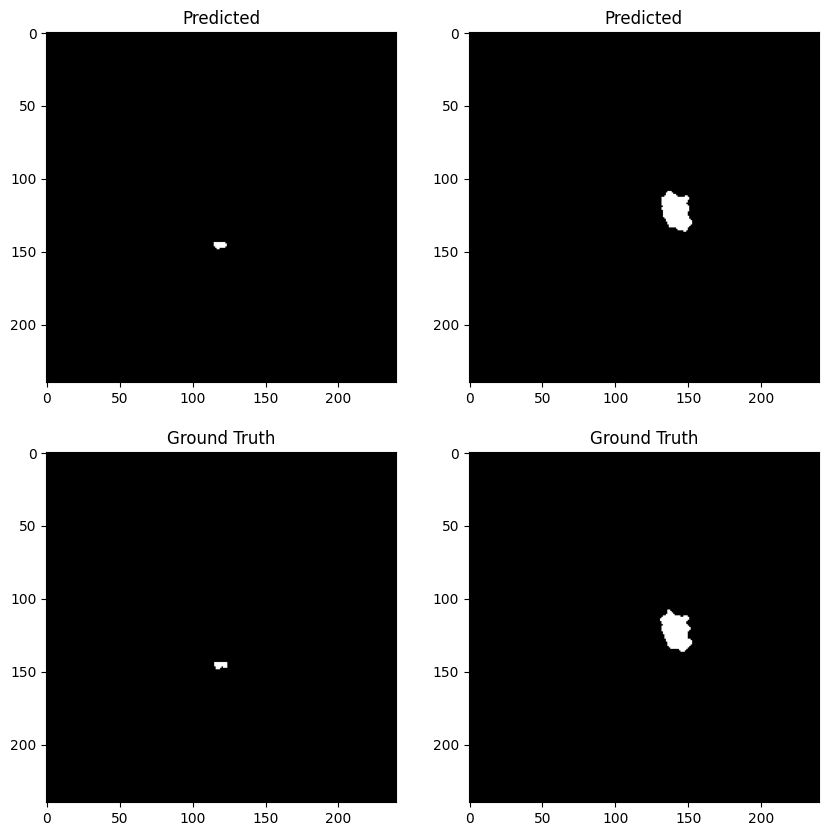

100%|██████████| 181/181 [08:50<00:00,  2.93s/it]



Average Training Loss: 0.002704713719341266

Average Training DSC: [0.99970434 0.95522157 0.96889734 0.89503624]
Average Training ASSD: [0.03842445 4.0380862  4.18483176 9.6694301 ]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


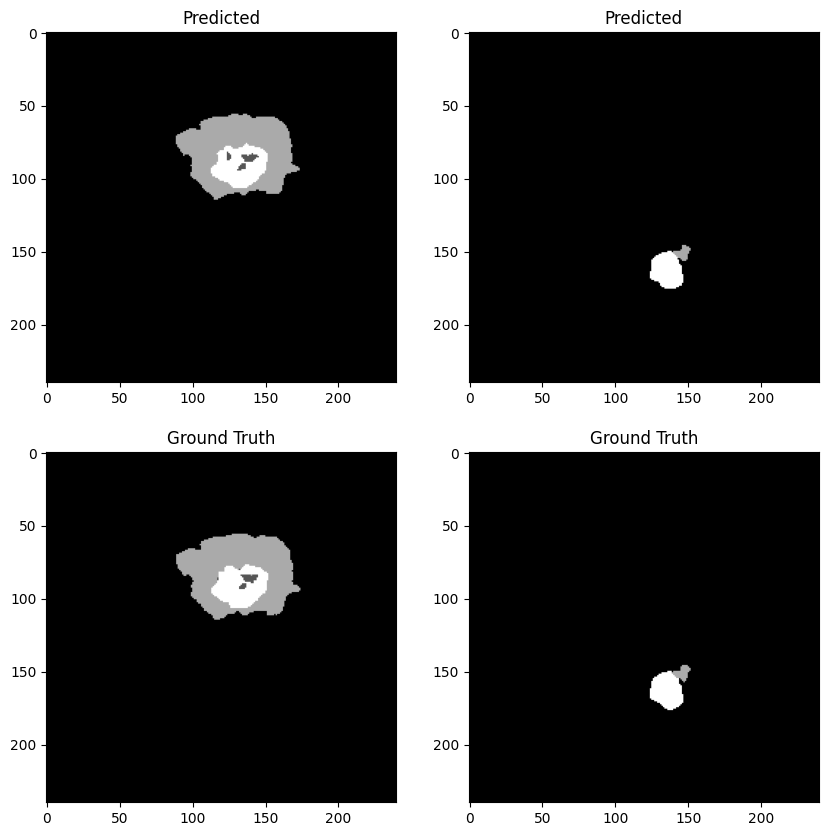

100%|██████████| 46/46 [01:25<00:00,  1.85s/it]


Average Validation Loss: 0.008550364017972479

Average Validation DSC: [0.9993628  0.90501836 0.94890382 0.80980043]
Average Validation ASSD: [ 0.09855    15.07952883  7.41948869 14.63169224]
Epoch 77/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


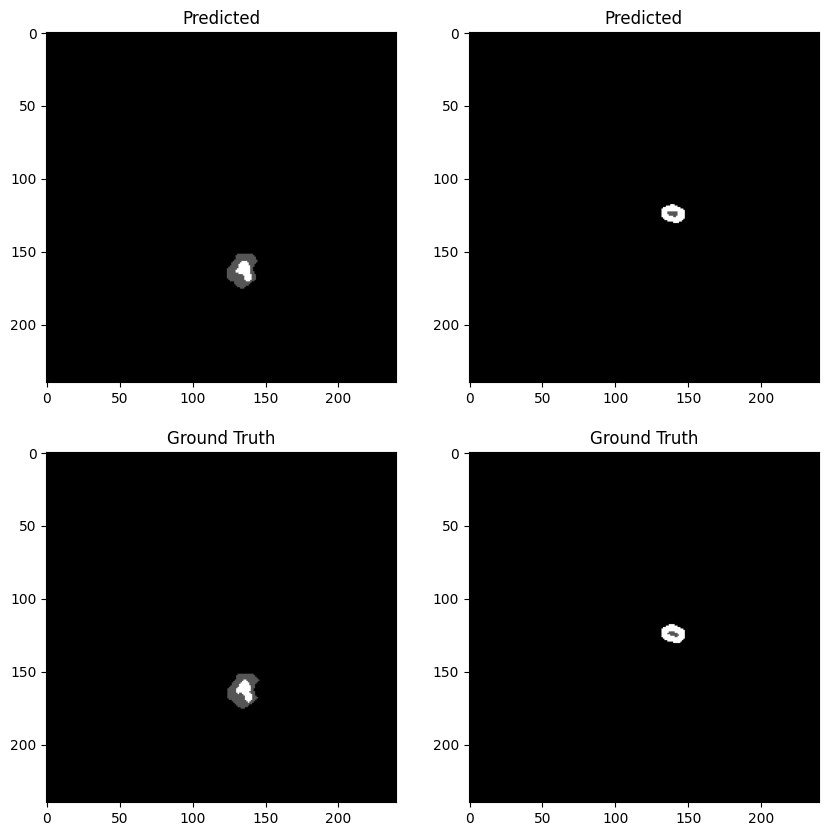

100%|██████████| 181/181 [08:51<00:00,  2.93s/it]



Average Training Loss: 0.0027164191635356424

Average Training DSC: [0.99970279 0.95824447 0.96980558 0.89432634]
Average Training ASSD: [ 0.03888553  2.86749676  3.85651331 10.849713  ]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


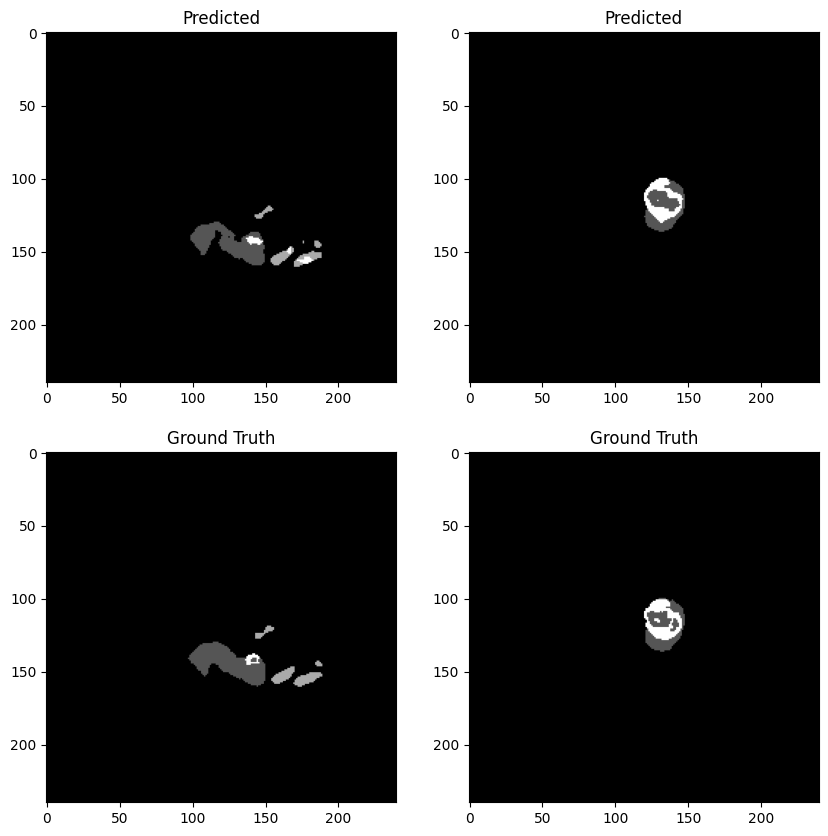

100%|██████████| 46/46 [01:27<00:00,  1.91s/it]


Average Validation Loss: 0.00876096678194185

Average Validation DSC: [0.99932849 0.8916591  0.910538   0.81052211]
Average Validation ASSD: [ 0.11323399 18.39030782 20.29288584  9.67636552]
Epoch 78/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


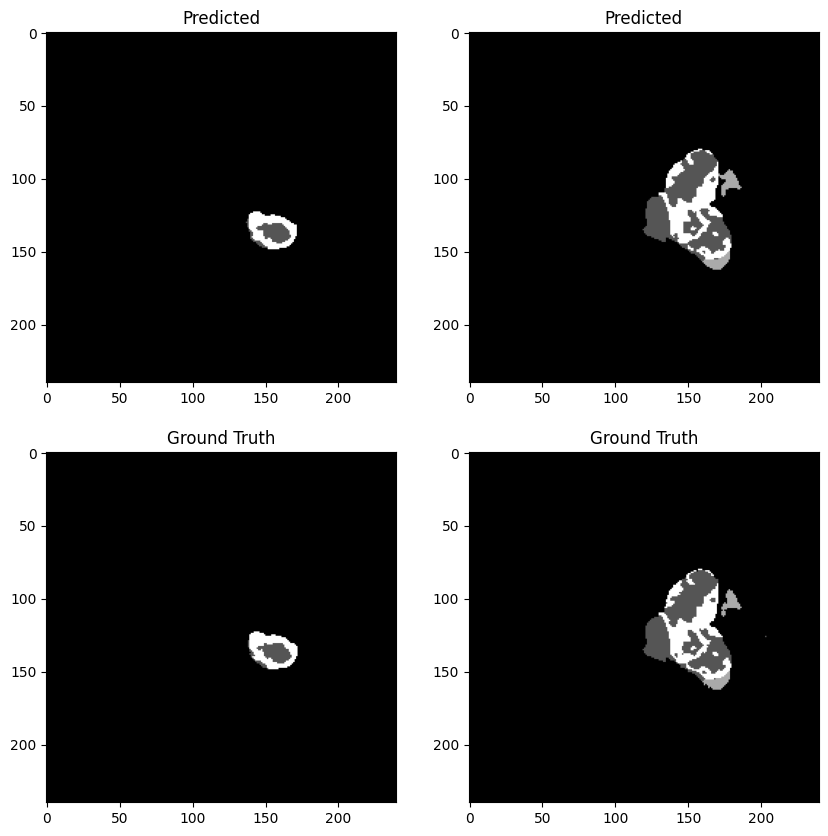

100%|██████████| 181/181 [08:49<00:00,  2.93s/it]



Average Training Loss: 0.00258477281030391

Average Training DSC: [0.99971948 0.96008334 0.97199388 0.89826986]
Average Training ASSD: [ 0.03637885  2.93987068  3.51210352 10.20915351]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


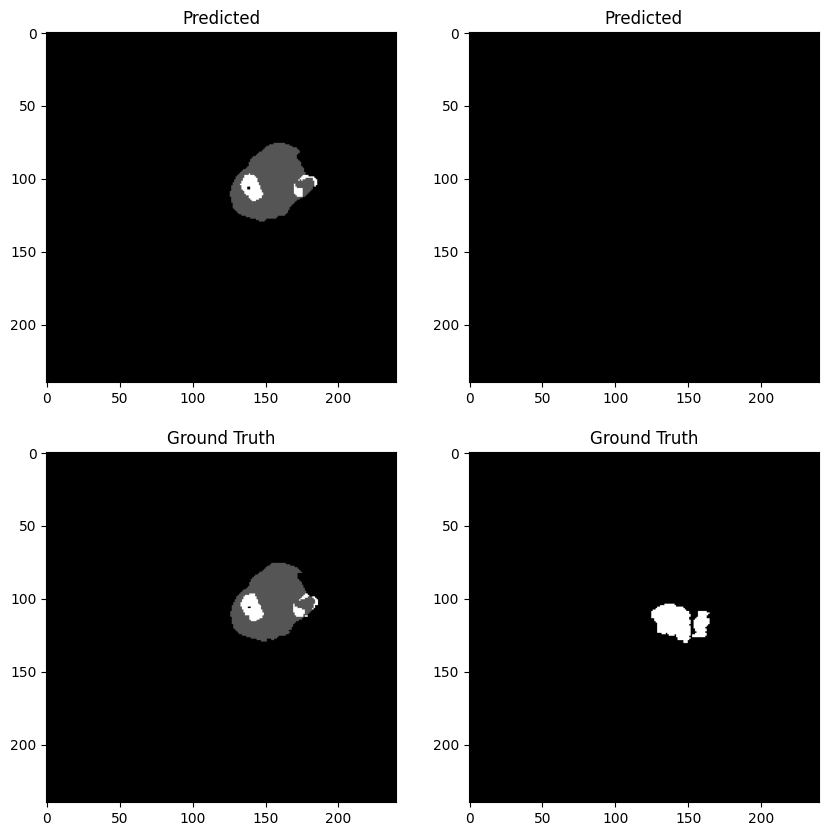

100%|██████████| 46/46 [01:24<00:00,  1.83s/it]


Average Validation Loss: 0.00995639604313866

Average Validation DSC: [0.99928793 0.90184873 0.94736536 0.78544068]
Average Validation ASSD: [ 0.10757748 15.421802    7.08536258 17.22035759]
Epoch 79/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


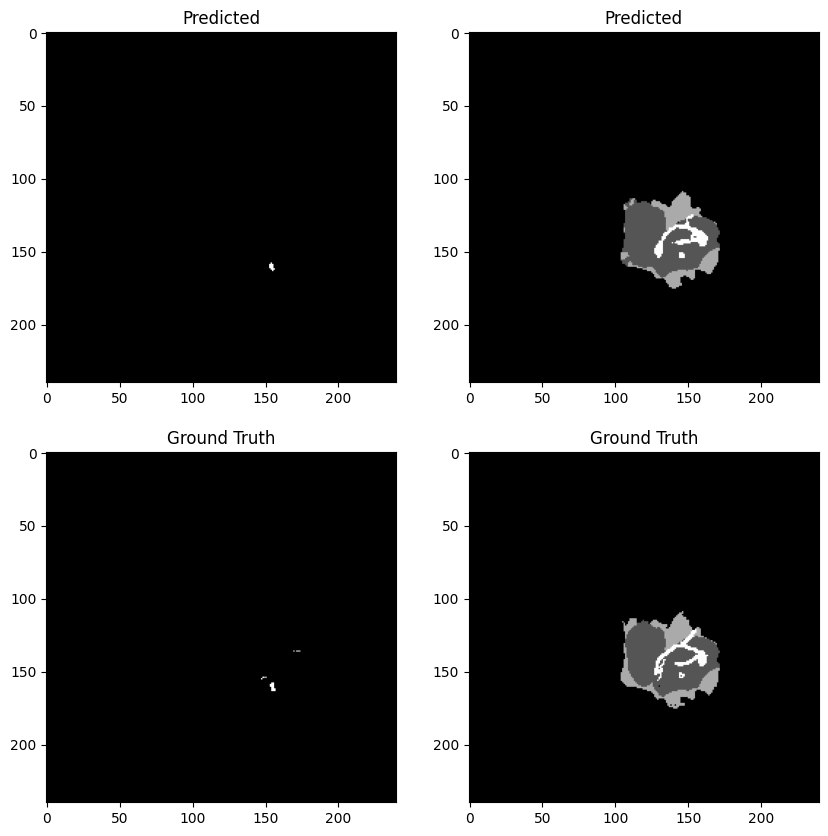

100%|██████████| 181/181 [08:53<00:00,  2.94s/it]



Average Training Loss: 0.0026554607455644406

Average Training DSC: [0.99970815 0.96114097 0.97149133 0.89858492]
Average Training ASSD: [0.03686511 2.44300786 3.5983165  9.88607627]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


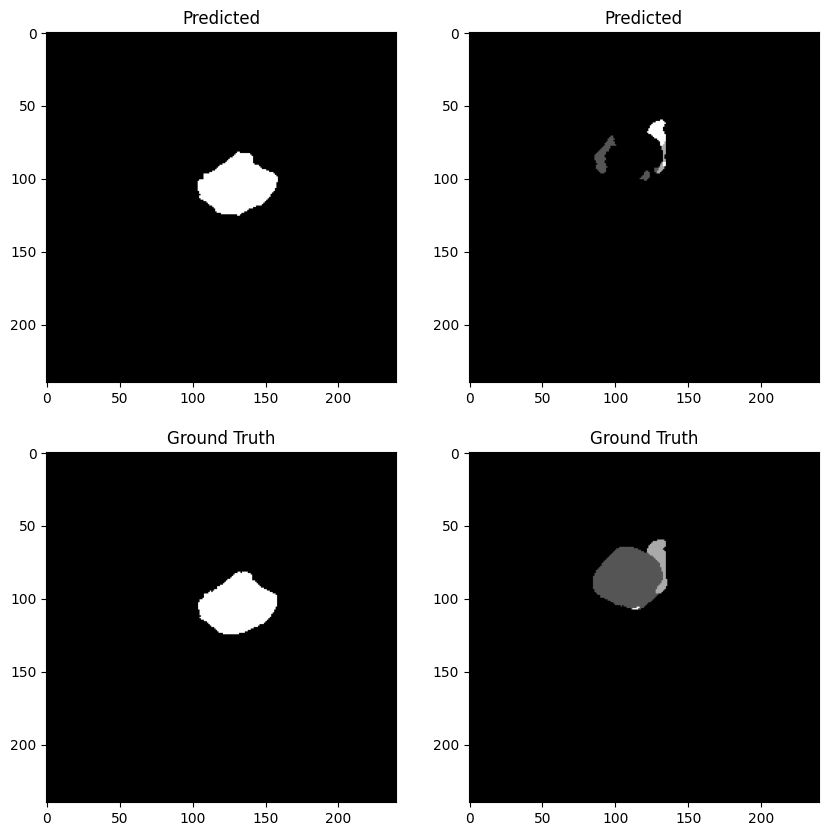

100%|██████████| 46/46 [01:24<00:00,  1.83s/it]


Average Validation Loss: 0.009079659281743934

Average Validation DSC: [0.99935439 0.89981797 0.93718399 0.80657833]
Average Validation ASSD: [ 0.09509096 16.73050516 11.3622398  13.74109107]
Epoch 80/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


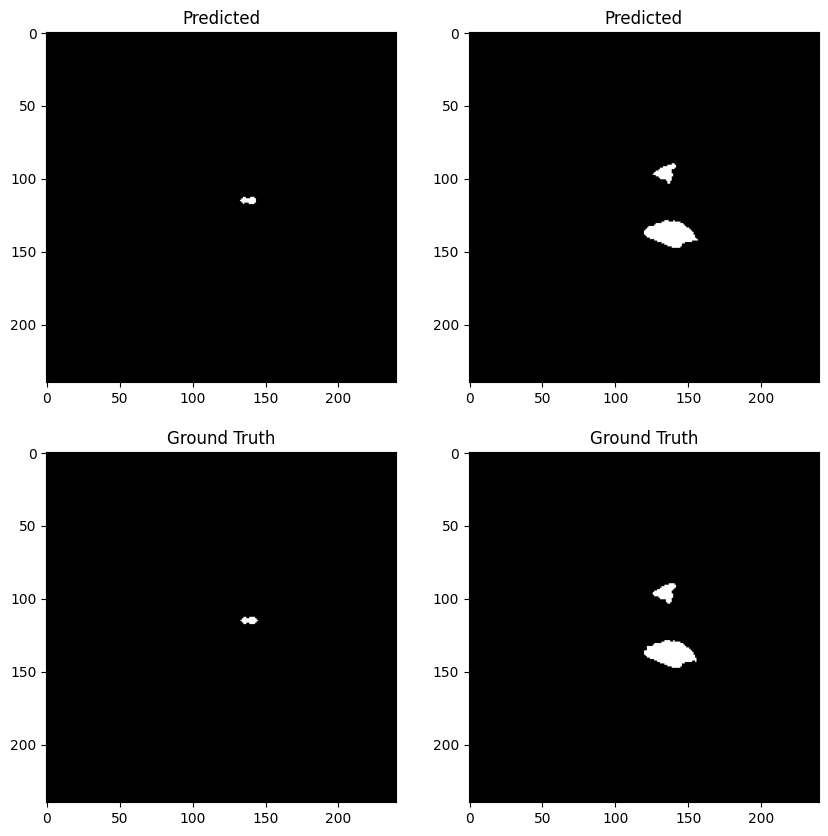

100%|██████████| 181/181 [08:49<00:00,  2.92s/it]



Average Training Loss: 0.0025454434914802568

Average Training DSC: [0.99971652 0.96156822 0.97077766 0.90317778]
Average Training ASSD: [0.03607977 2.52277602 4.33726502 9.12262983]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [01:25<00:00,  1.85s/it]


Average Validation Loss: 0.00903372878573187

Average Validation DSC: [0.9993488  0.90783282 0.95184771 0.79975299]
Average Validation ASSD: [ 0.10539283 13.12892878  6.77798656 15.03391521]
Epoch 81/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


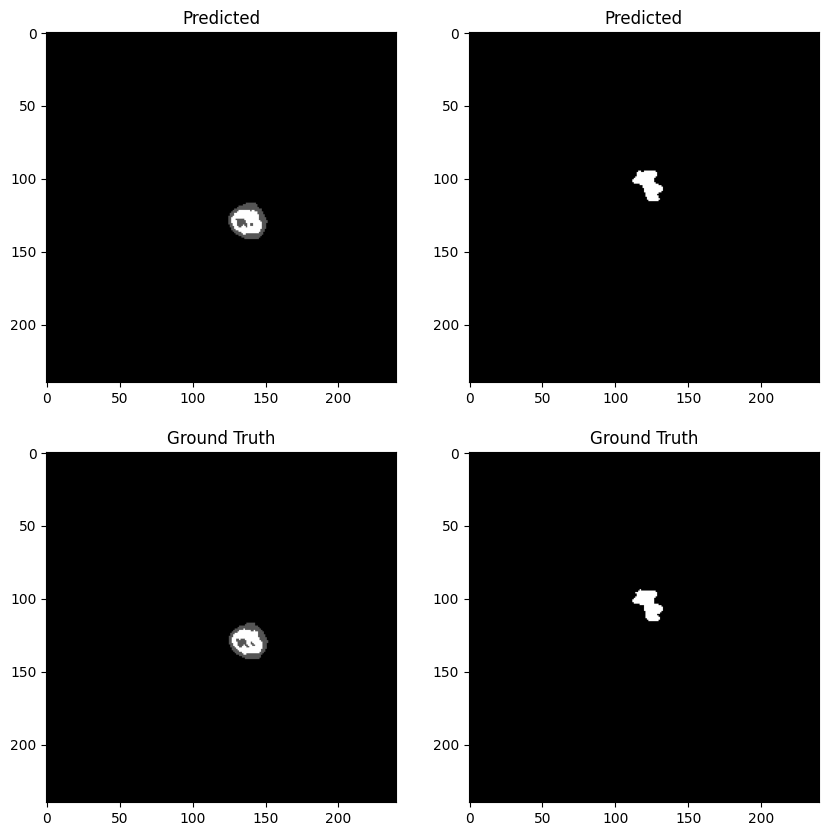

100%|██████████| 181/181 [08:52<00:00,  2.94s/it]



Average Training Loss: 0.0026374234102707543

Average Training DSC: [0.99970644 0.95690745 0.96688501 0.89824004]
Average Training ASSD: [ 0.03845687  3.85816037  4.85030435 10.47530988]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


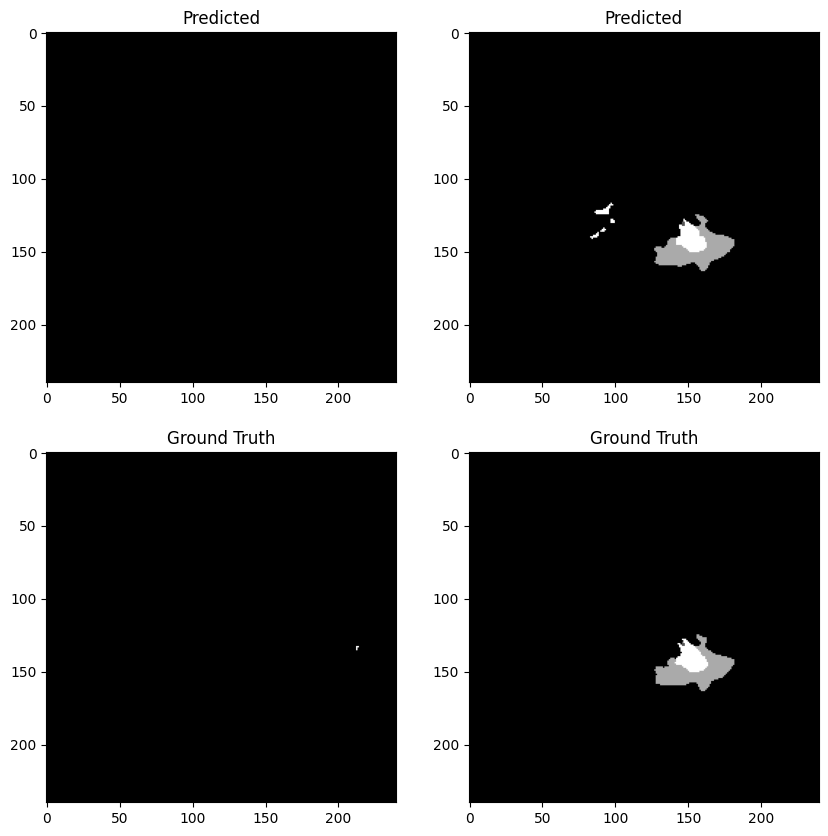

100%|██████████| 46/46 [01:24<00:00,  1.85s/it]


Average Validation Loss: 0.010183484394751165

Average Validation DSC: [0.99915712 0.86563031 0.91414926 0.76820704]
Average Validation ASSD: [ 0.21345625 23.39121667 16.97652656  7.27239444]
Epoch 82/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


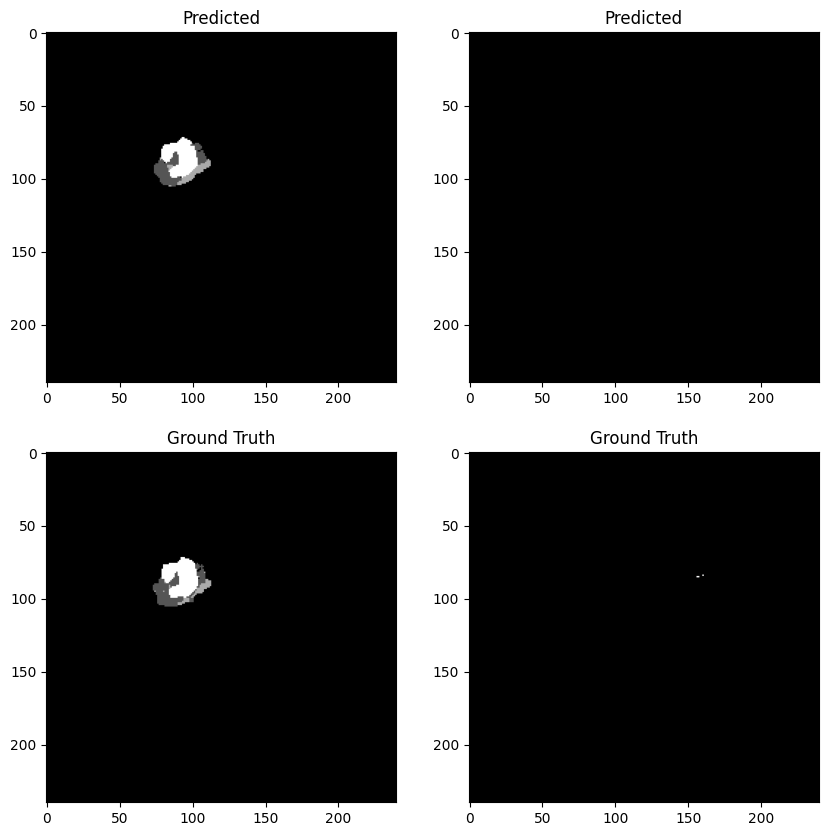

100%|██████████| 181/181 [08:49<00:00,  2.92s/it]



Average Training Loss: 0.005585110272944632

Average Training DSC: [0.99941021 0.89447263 0.90494497 0.82870571]
Average Training ASSD: [ 0.09043201 18.11044963 22.40442355 12.25305865]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


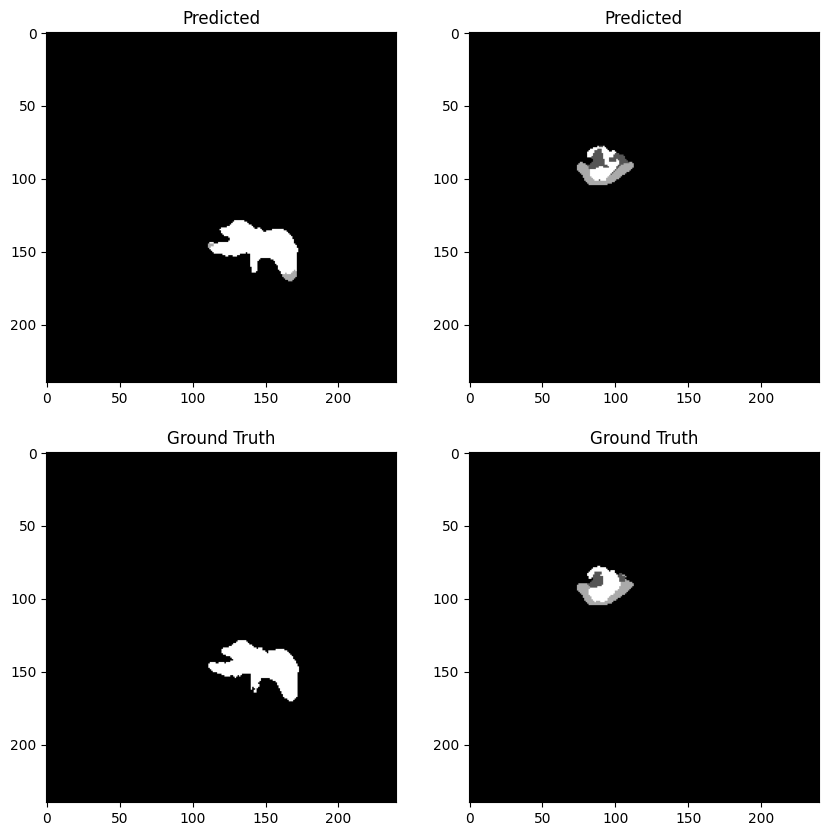

100%|██████████| 46/46 [01:21<00:00,  1.78s/it]


Average Validation Loss: 0.01130194569249516

Average Validation DSC: [0.99915867 0.78822196 0.87017186 0.67677745]
Average Validation ASSD: [ 0.16128293 46.15487801 33.12811433 17.39370272]
Epoch 83/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


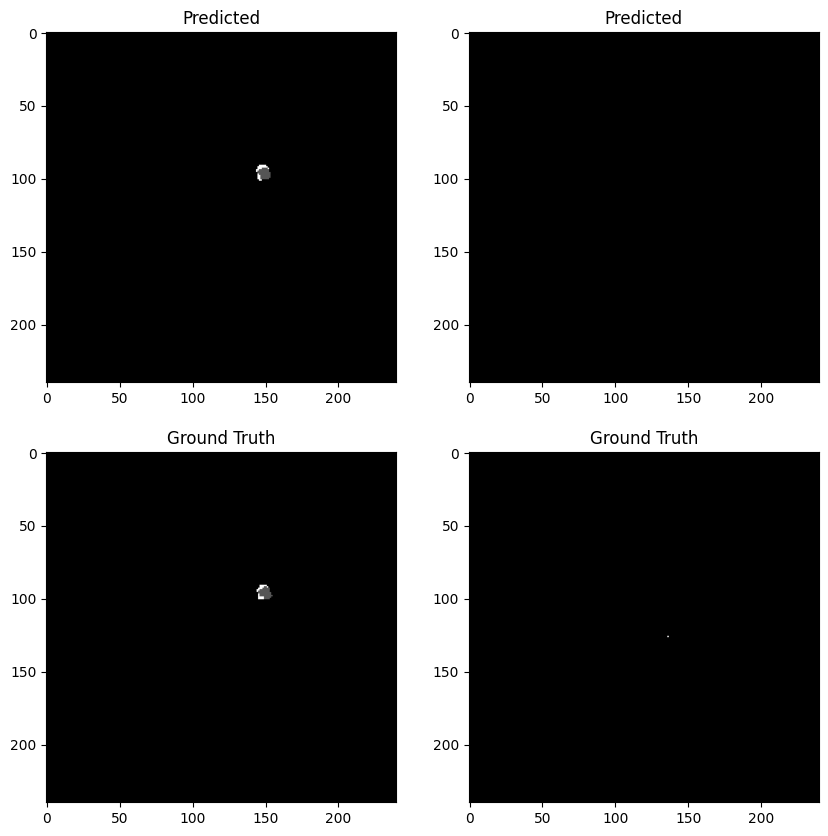

100%|██████████| 181/181 [07:56<00:00,  2.63s/it]



Average Training Loss: 0.004983846987057374

Average Training DSC: [0.99948315 0.90030933 0.94266094 0.83222312]
Average Training ASSD: [ 0.07039462 16.76406582 10.76653966 11.80818475]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


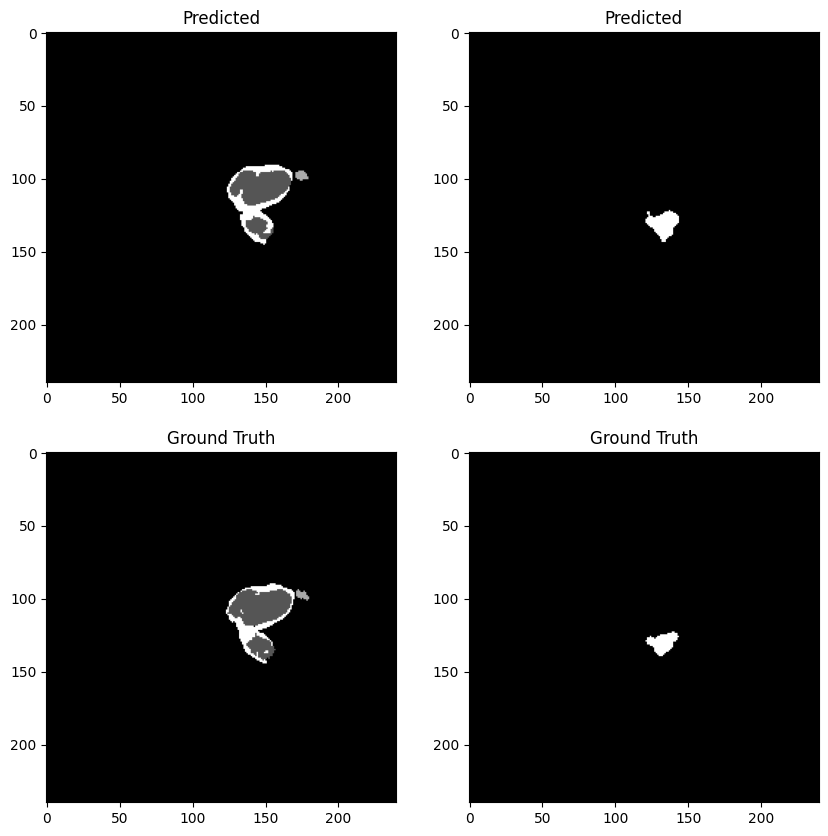

100%|██████████| 46/46 [01:12<00:00,  1.58s/it]


Average Validation Loss: 0.010350709345758609

Average Validation DSC: [0.99907228 0.85523553 0.87792373 0.76601273]
Average Validation ASSD: [ 0.18351277 22.18101989 29.33001459  8.40731187]
Epoch 84/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


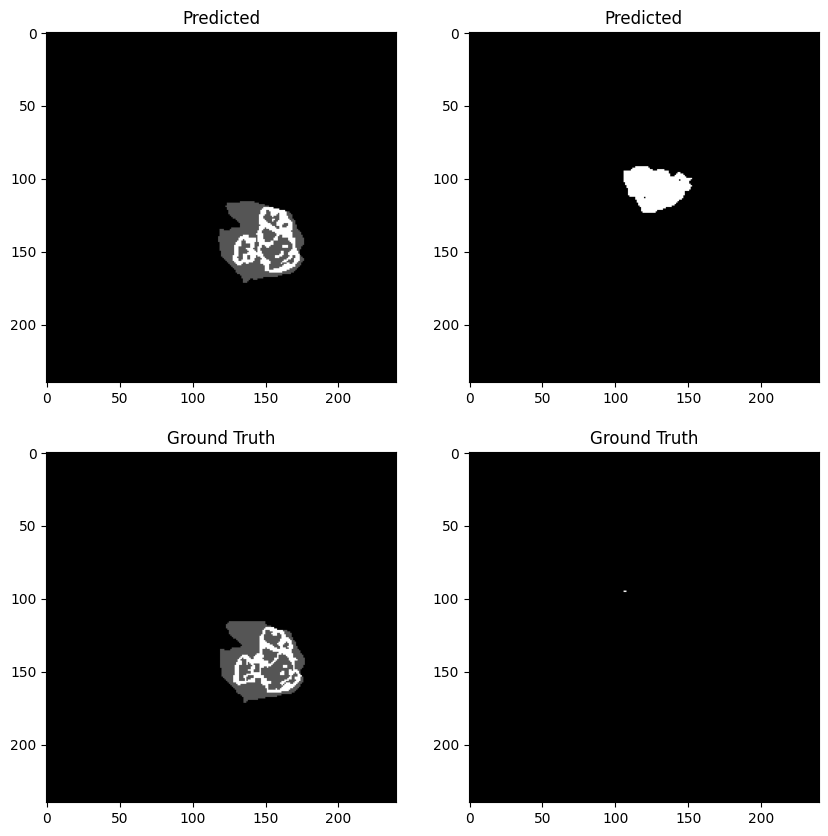

100%|██████████| 181/181 [07:53<00:00,  2.62s/it]



Average Training Loss: 0.0034867415638146562

Average Training DSC: [0.99962014 0.93831554 0.96387984 0.8728751 ]
Average Training ASSD: [ 0.05061989  7.83805883  5.04092812 11.18703149]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [01:13<00:00,  1.59s/it]


Average Validation Loss: 0.008095862283168928

Average Validation DSC: [0.99934946 0.89154544 0.93649841 0.78269562]
Average Validation ASSD: [ 0.11532065 19.06253895 11.40743491 20.91623725]
Epoch 85/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


100%|██████████| 181/181 [07:56<00:00,  2.64s/it]



Average Training Loss: 0.0025937816755877015

Average Training DSC: [0.99970697 0.95920867 0.9713681  0.89742357]
Average Training ASSD: [ 0.03929404  3.44250572  3.84722385 10.12812971]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


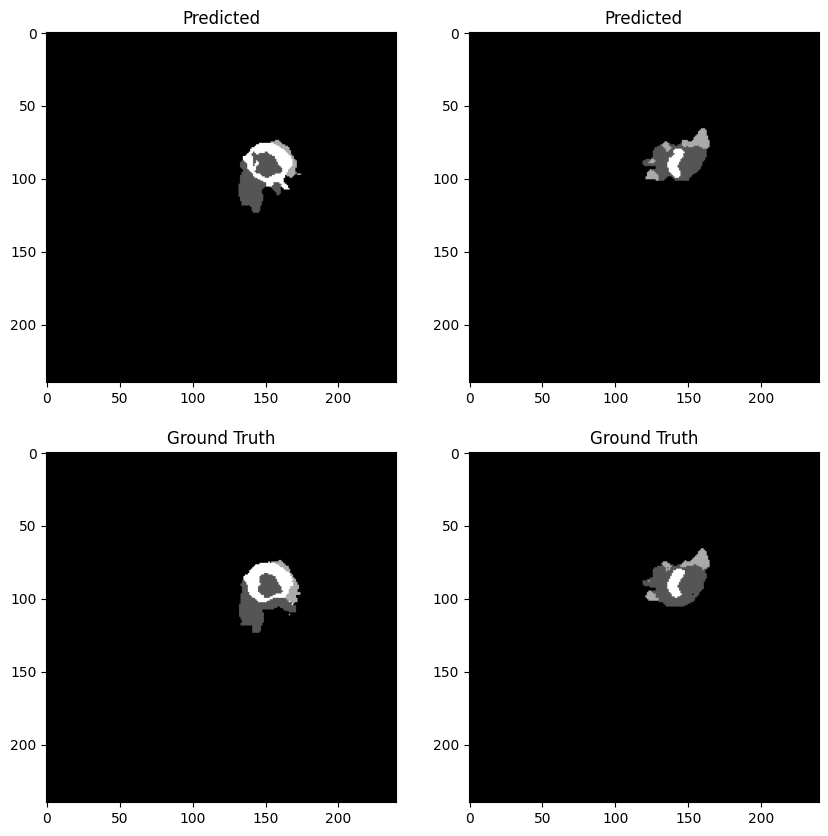

100%|██████████| 46/46 [01:12<00:00,  1.57s/it]


Average Validation Loss: 0.008523602195529511

Average Validation DSC: [0.99933047 0.90868292 0.95004592 0.80080077]
Average Validation ASSD: [ 0.10224018 14.41487479  7.43191193 14.6183122 ]
Epoch 86/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


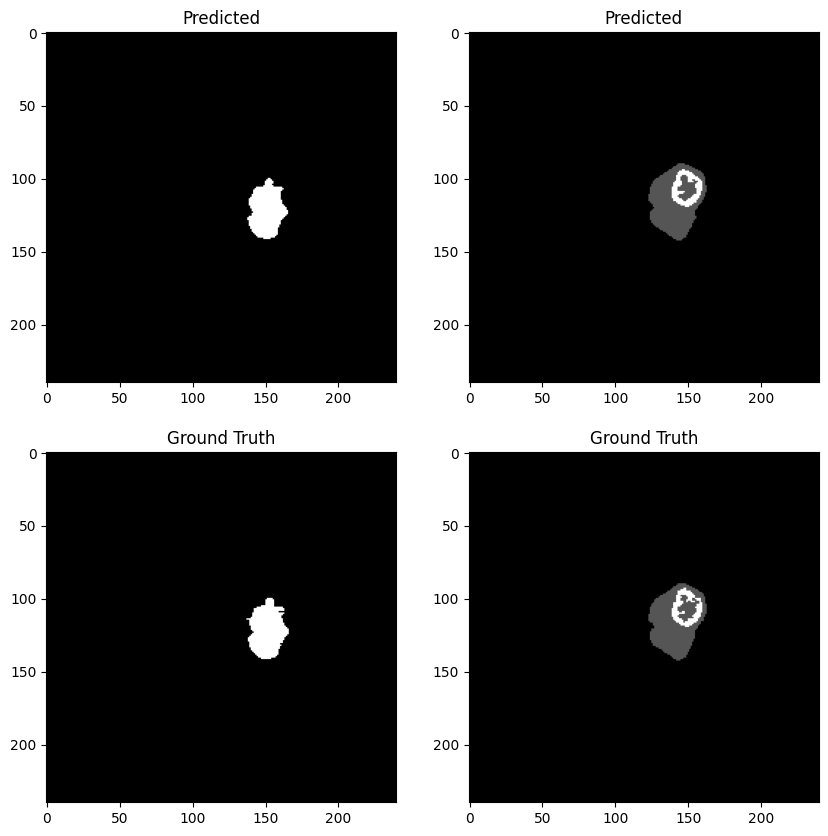

100%|██████████| 181/181 [07:56<00:00,  2.63s/it]



Average Training Loss: 0.002810312828656224

Average Training DSC: [0.99969668 0.94940857 0.97169537 0.89475667]
Average Training ASSD: [0.04049922 6.0383264  3.68072265 9.37717899]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


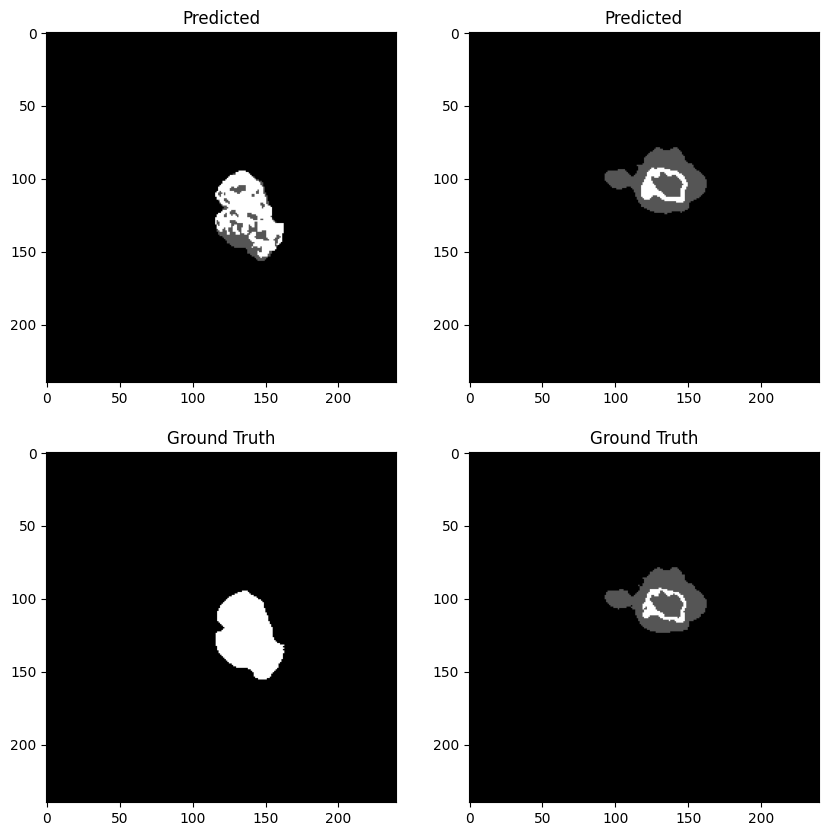

100%|██████████| 46/46 [01:11<00:00,  1.56s/it]


Average Validation Loss: 0.009224055507017867

Average Validation DSC: [0.99928196 0.84878895 0.94576194 0.77456844]
Average Validation ASSD: [ 0.118976   26.07241011  7.13350584 15.77718729]
Epoch 87/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


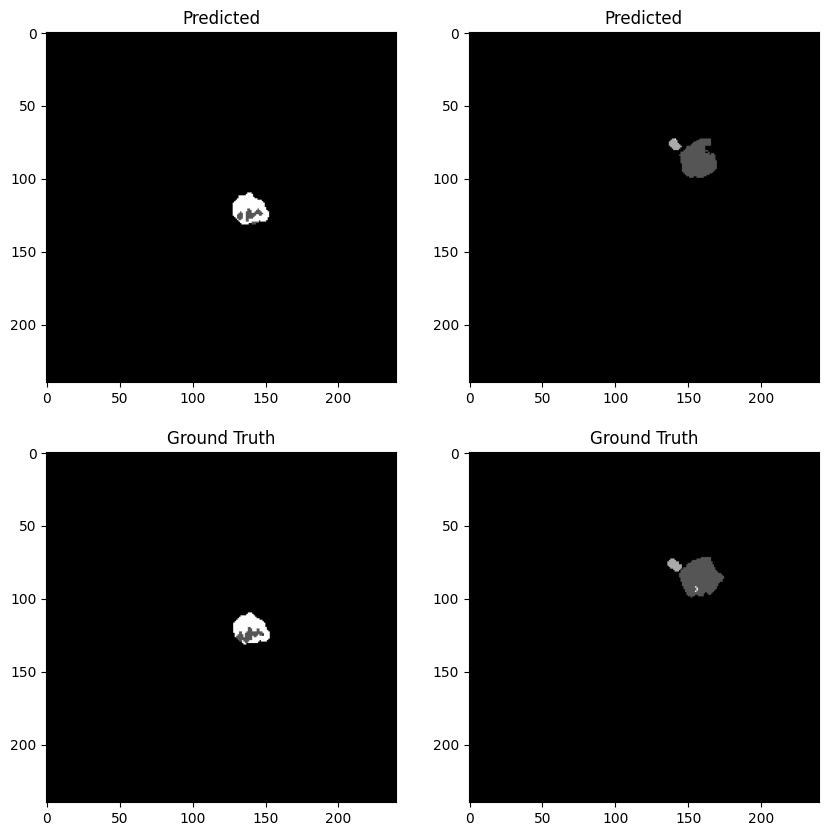

100%|██████████| 181/181 [07:56<00:00,  2.63s/it]



Average Training Loss: 0.002602368096038905

Average Training DSC: [0.99972558 0.95573154 0.97224524 0.90026224]
Average Training ASSD: [0.03562733 4.36554179 3.58897417 9.61837784]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


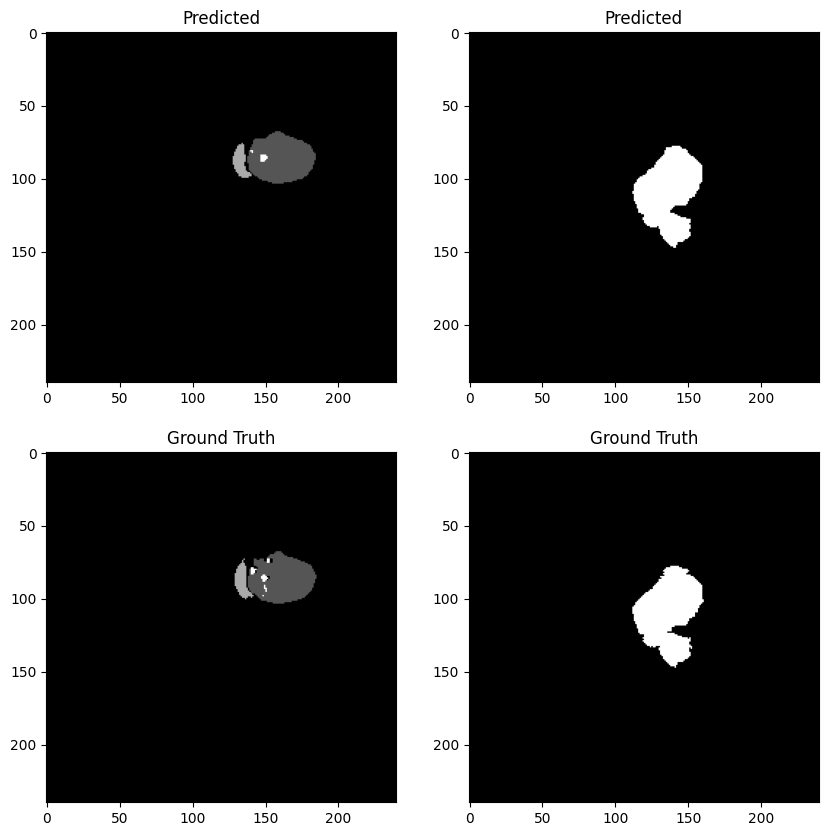

100%|██████████| 46/46 [01:10<00:00,  1.54s/it]


Average Validation Loss: 0.008579224894714096

Average Validation DSC: [0.99938628 0.90543878 0.95117138 0.81902226]
Average Validation ASSD: [ 0.08434348 14.76054522  6.46940936 10.29833671]
Epoch 88/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


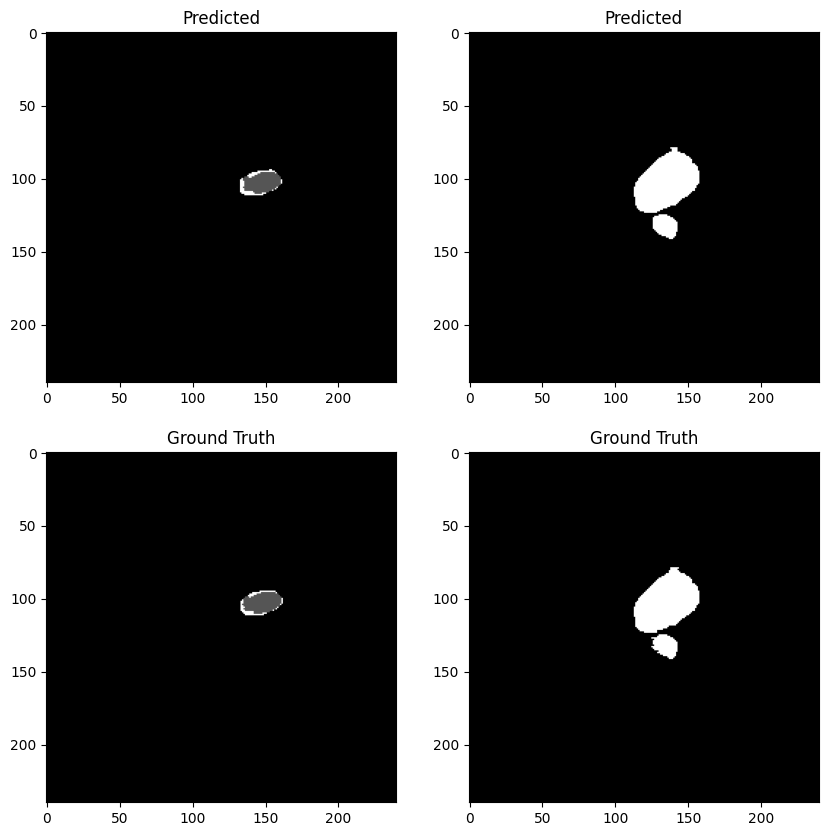

100%|██████████| 181/181 [07:55<00:00,  2.63s/it]



Average Training Loss: 0.002341861442343759

Average Training DSC: [0.99973565 0.96461639 0.97413249 0.90732147]
Average Training ASSD: [ 0.03620249  2.58781639  3.4126995  10.325405  ]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


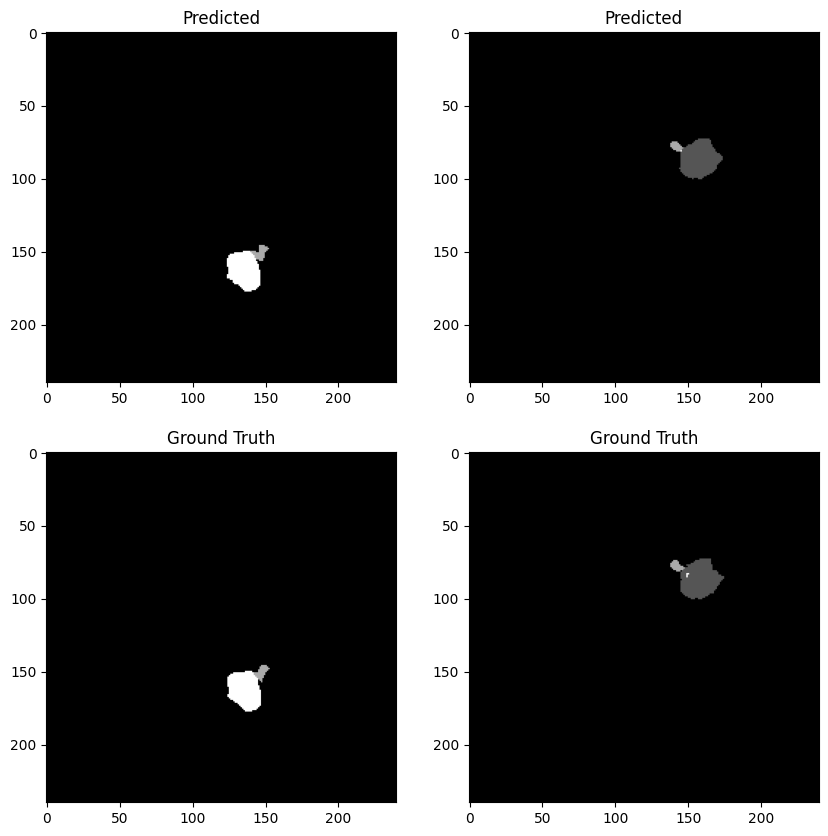

100%|██████████| 46/46 [01:10<00:00,  1.54s/it]


Average Validation Loss: 0.008584897504593044

Average Validation DSC: [0.99939809 0.90239822 0.95555611 0.81576865]
Average Validation ASSD: [ 0.09166495 16.39252032  5.46348604 12.62640231]
Epoch 89/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


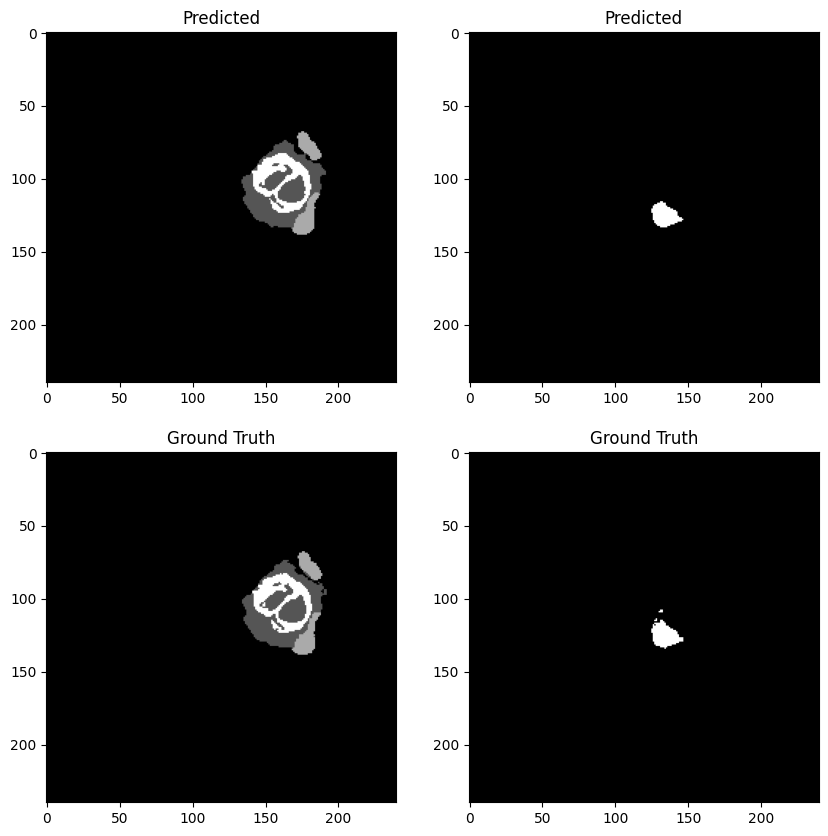

100%|██████████| 181/181 [07:54<00:00,  2.62s/it]



Average Training Loss: 0.002179393576308879

Average Training DSC: [0.99975565 0.96684693 0.97544973 0.91233332]
Average Training ASSD: [0.03356272 2.65729428 3.24315007 9.02339469]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


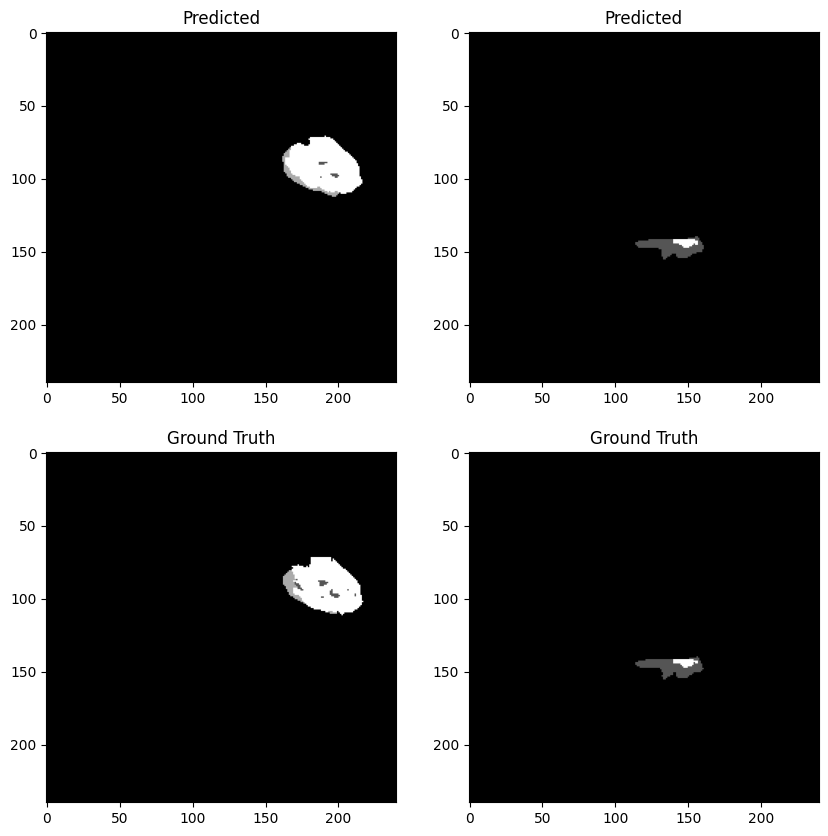

100%|██████████| 46/46 [01:10<00:00,  1.53s/it]


Average Validation Loss: 0.009151378859077458

Average Validation DSC: [0.99941754 0.90788693 0.95190424 0.82774445]
Average Validation ASSD: [ 0.09228519 14.41627914  7.08285787 11.58438649]
Epoch 90/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


100%|██████████| 181/181 [07:55<00:00,  2.63s/it]



Average Training Loss: 0.002083522678952335

Average Training DSC: [0.99977258 0.96806693 0.97513455 0.91737165]
Average Training ASSD: [0.02948876 2.07227266 3.48607775 8.54463633]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


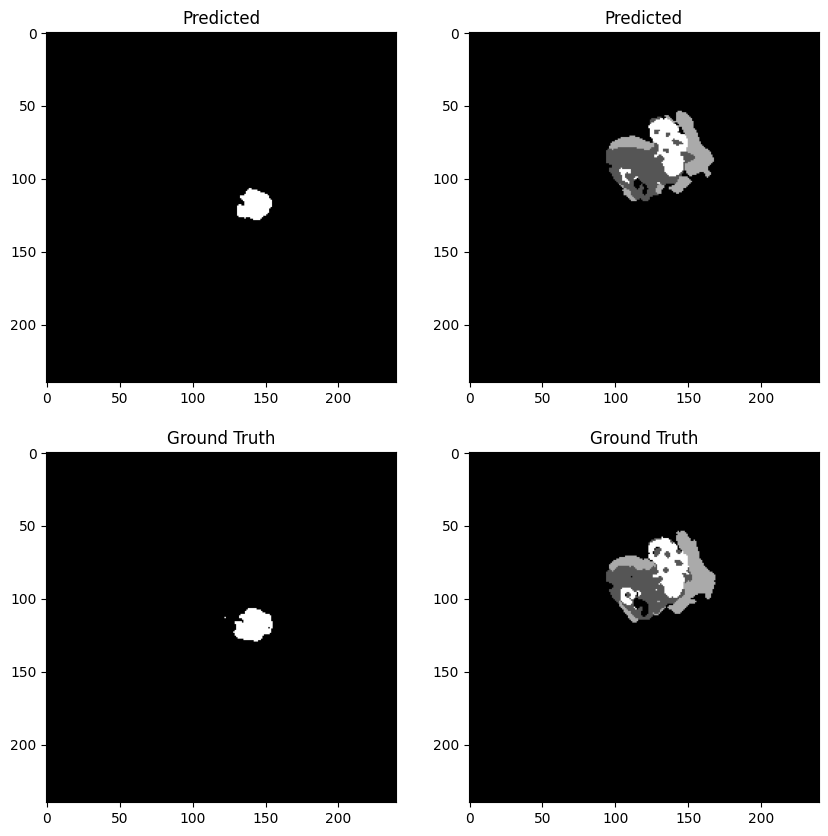

100%|██████████| 46/46 [01:12<00:00,  1.57s/it]


Average Validation Loss: 0.013919576354648756

Average Validation DSC: [0.99897711 0.87251648 0.93450903 0.73834719]
Average Validation ASSD: [ 0.16609086 21.7278107   7.53896834 24.88604535]
Epoch 91/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


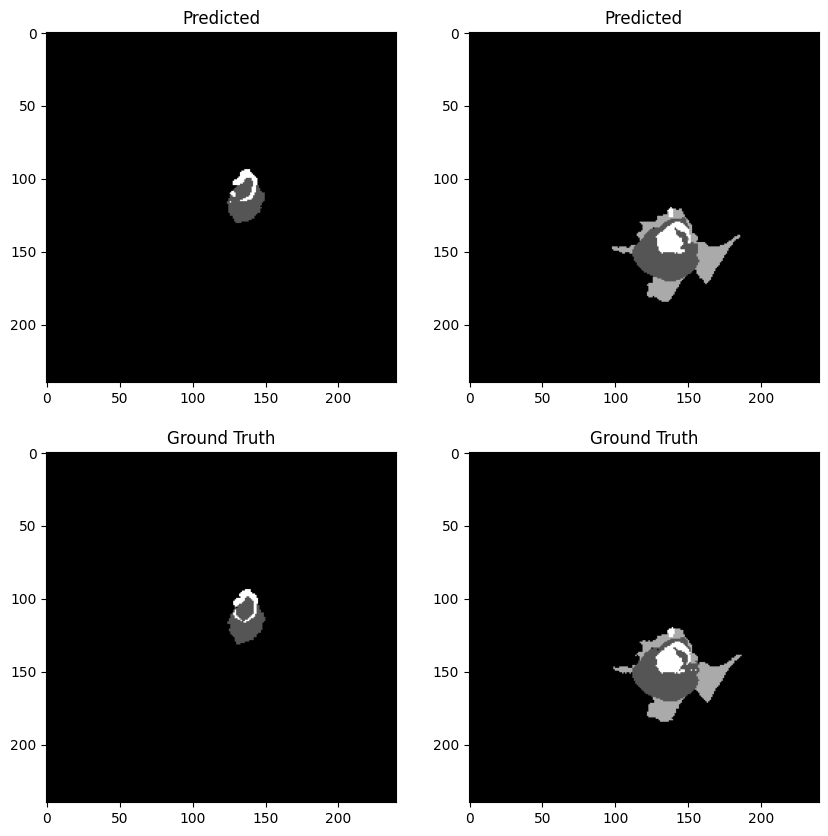

100%|██████████| 181/181 [07:52<00:00,  2.61s/it]



Average Training Loss: 0.002629771773338071

Average Training DSC: [0.99971073 0.95578061 0.97074477 0.90151103]
Average Training ASSD: [0.0377011  4.27882674 4.17367796 9.42571033]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


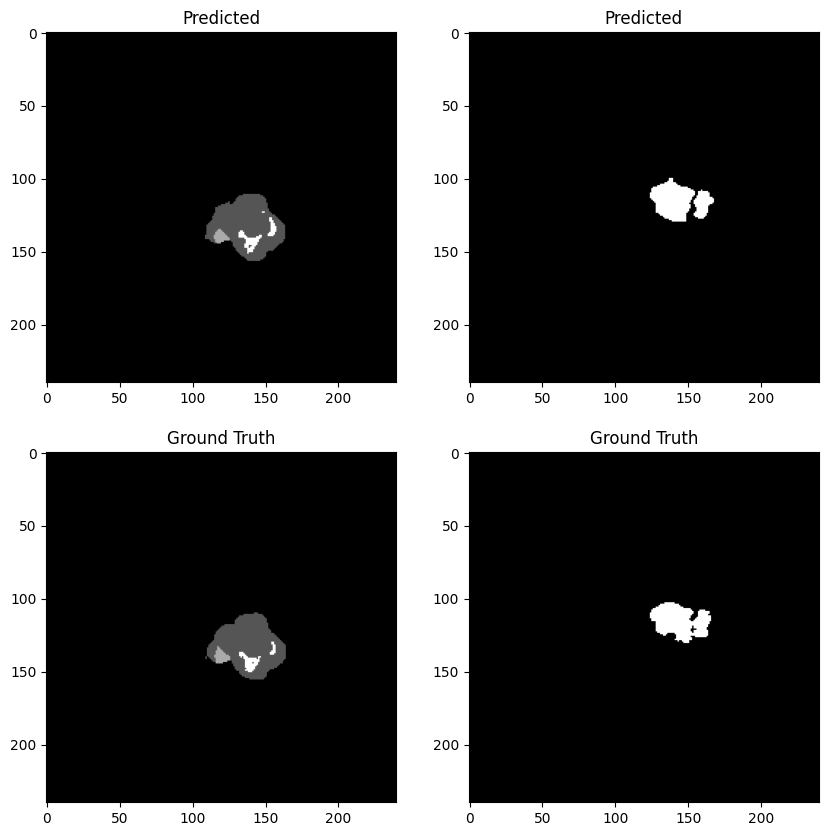

100%|██████████| 46/46 [01:12<00:00,  1.58s/it]


Average Validation Loss: 0.008749673780782716

Average Validation DSC: [0.99936951 0.89453724 0.94857583 0.80363398]
Average Validation ASSD: [ 0.09748259 16.77424909  7.42170764 14.60904455]
Epoch 92/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


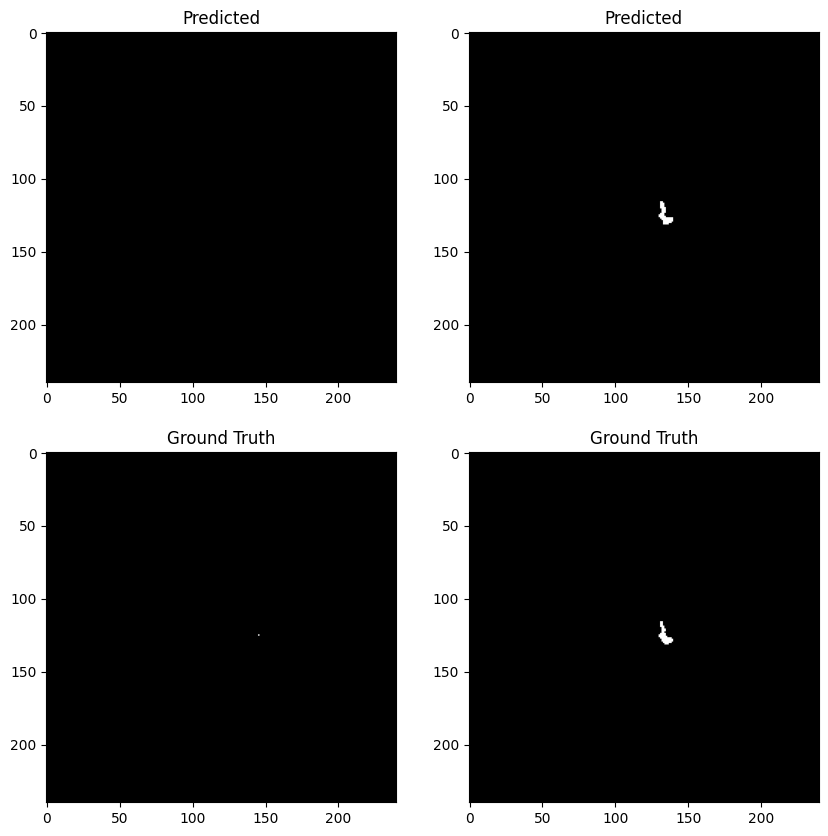

100%|██████████| 181/181 [07:54<00:00,  2.62s/it]



Average Training Loss: 0.0023112936409766583

Average Training DSC: [0.99974844 0.96185661 0.97260284 0.90696686]
Average Training ASSD: [0.03318669 3.25722975 3.83179289 9.37282239]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


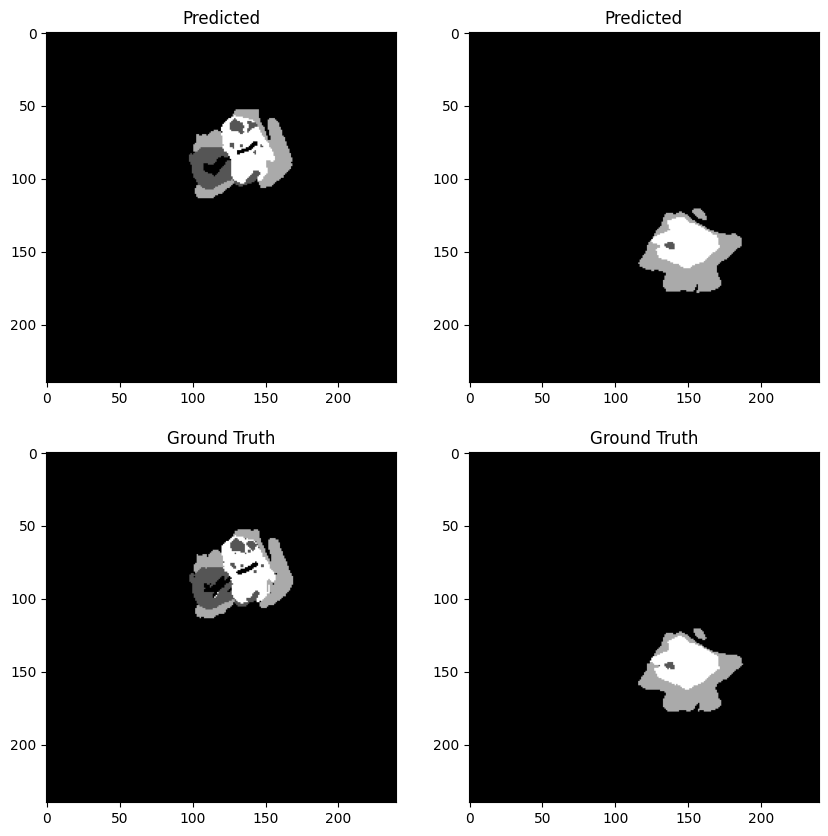

100%|██████████| 46/46 [01:12<00:00,  1.58s/it]


Average Validation Loss: 0.008931933689619536

Average Validation DSC: [0.99939748 0.90988226 0.94803327 0.82697555]
Average Validation ASSD: [ 0.0886287  14.73262951  9.36247976  8.46939593]
Epoch 93/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


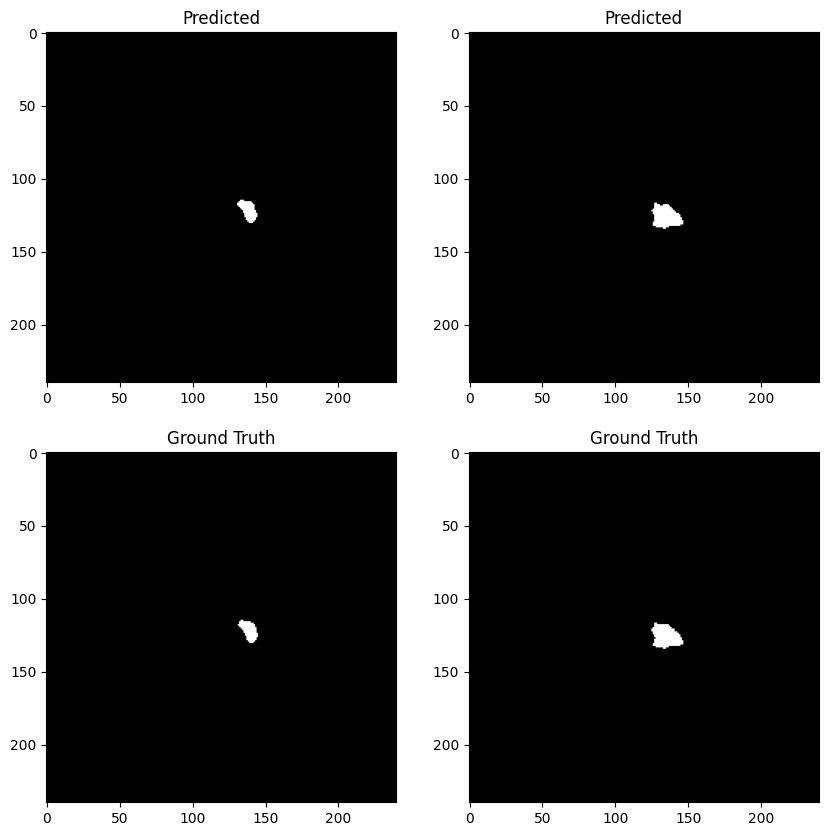

100%|██████████| 181/181 [07:52<00:00,  2.61s/it]



Average Training Loss: 0.002105158234004816

Average Training DSC: [0.99977203 0.96532567 0.97693858 0.91507947]
Average Training ASSD: [0.02896182 2.57808903 2.90489282 7.76853891]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


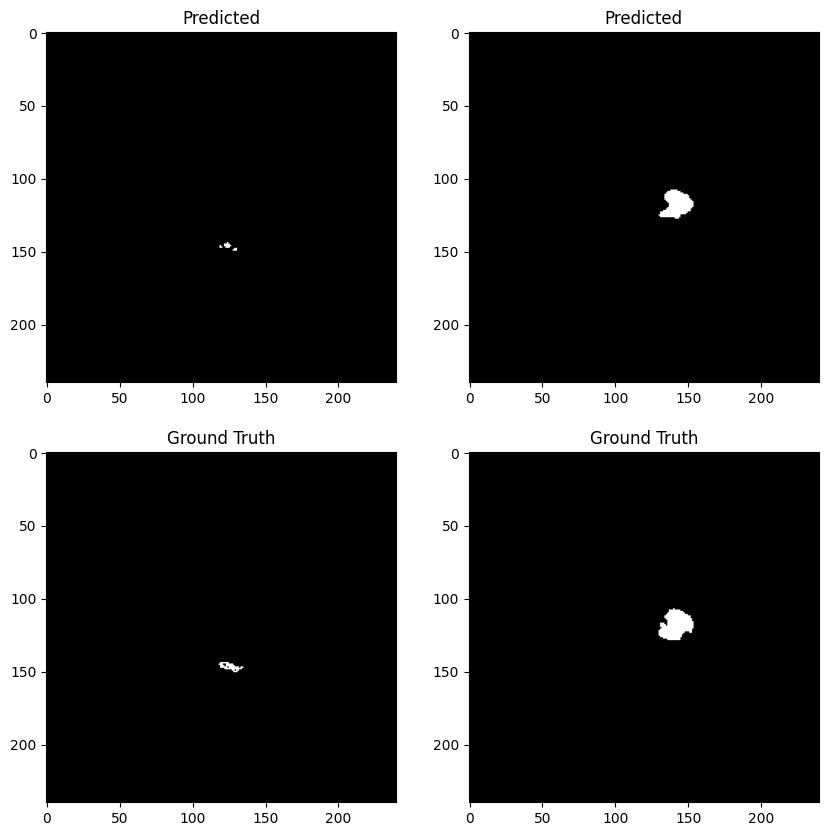

100%|██████████| 46/46 [01:14<00:00,  1.61s/it]


Average Validation Loss: 0.009215435068851904

Average Validation DSC: [0.99939484 0.90436782 0.95479301 0.82426819]
Average Validation ASSD: [ 0.091878   15.09744747  6.71581498 10.7744897 ]
Epoch 94/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


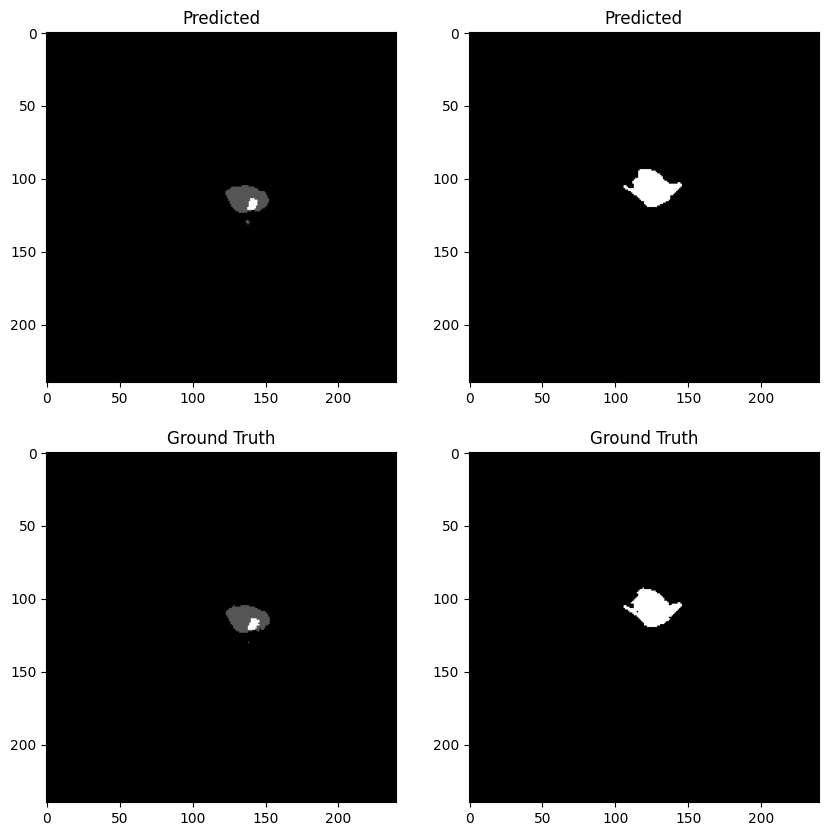

100%|██████████| 181/181 [07:55<00:00,  2.62s/it]



Average Training Loss: 0.002098524133875472

Average Training DSC: [0.99977842 0.96774979 0.97649363 0.91535455]
Average Training ASSD: [0.02798054 1.91046886 2.99090013 8.56491063]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


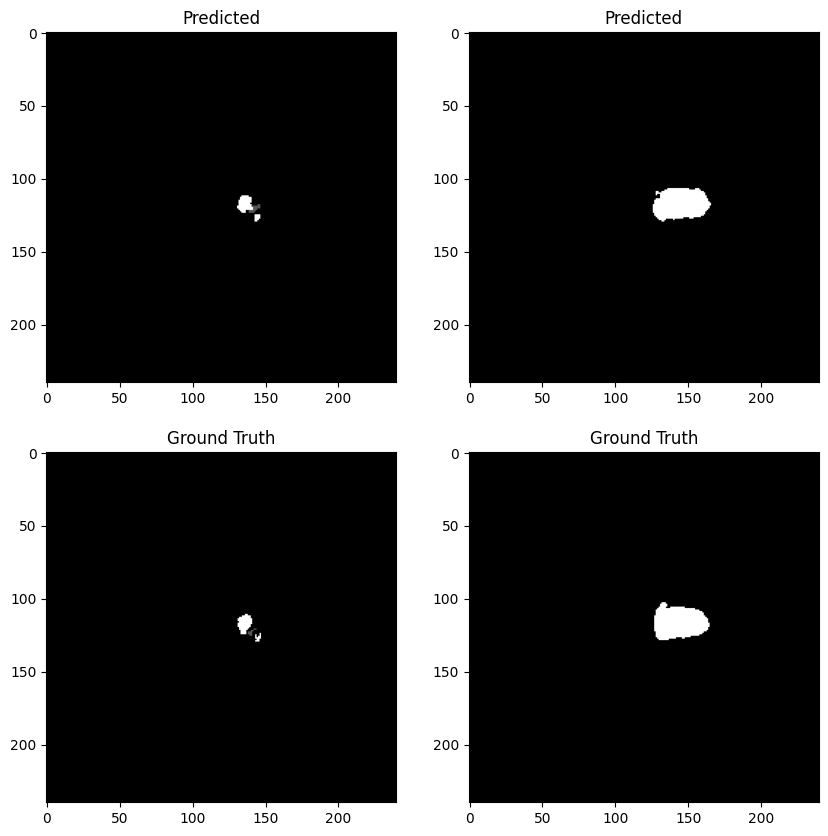

100%|██████████| 46/46 [01:12<00:00,  1.59s/it]


Average Validation Loss: 0.009251512121409178

Average Validation DSC: [0.99938198 0.90469973 0.94905188 0.82588269]
Average Validation ASSD: [ 0.0850756  15.39977092  7.7462726   8.06375274]
Epoch 95/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


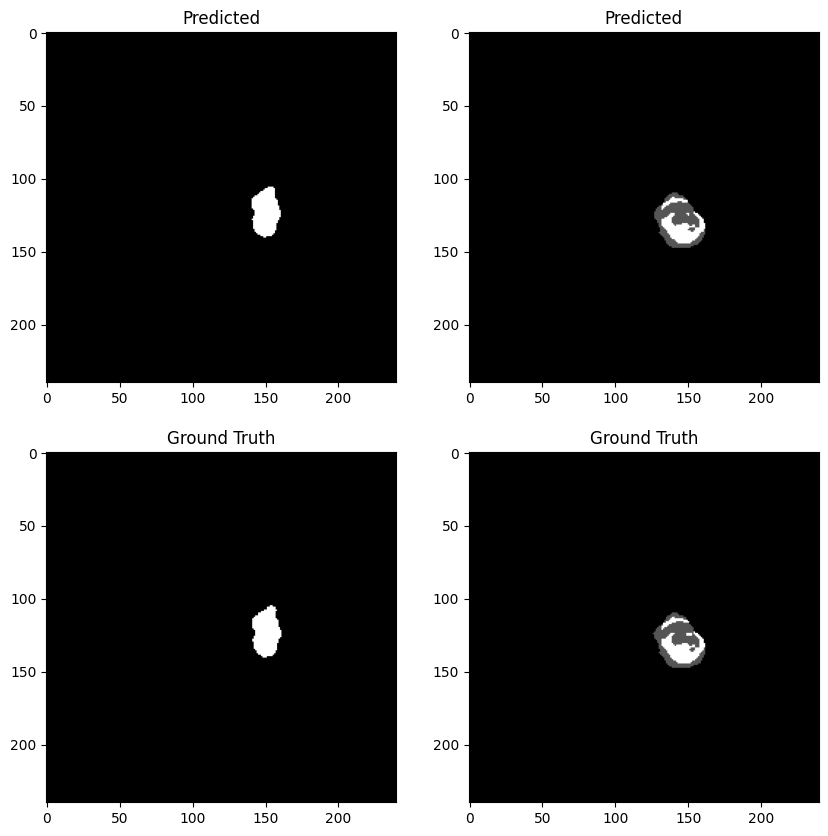

100%|██████████| 181/181 [07:53<00:00,  2.62s/it]



Average Training Loss: 0.0023015103533153953

Average Training DSC: [0.99975892 0.96157432 0.97446851 0.91255467]
Average Training ASSD: [0.03030696 3.58841949 3.33438993 7.55898913]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


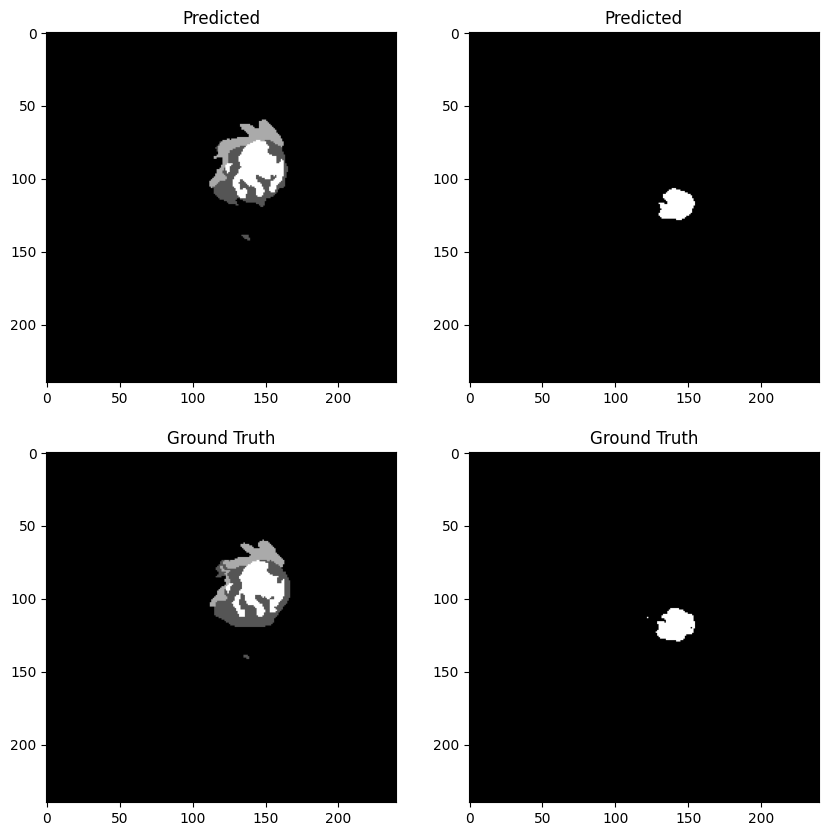

100%|██████████| 46/46 [01:12<00:00,  1.57s/it]


Average Validation Loss: 0.009175158379113545

Average Validation DSC: [0.9993549  0.88708261 0.94078336 0.81311272]
Average Validation ASSD: [ 0.09175964 19.39073371 10.37142241 10.73599695]
Epoch 96/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


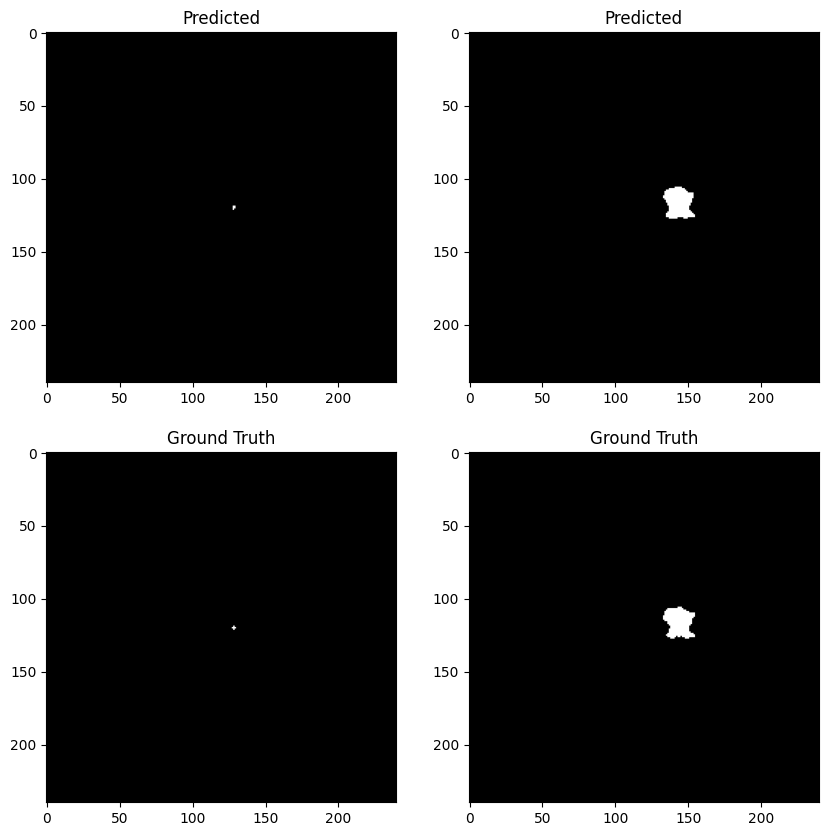

100%|██████████| 181/181 [07:54<00:00,  2.62s/it]



Average Training Loss: 0.00228870552559306

Average Training DSC: [0.99974837 0.96282491 0.97516665 0.9091529 ]
Average Training ASSD: [0.03338269 2.84660299 3.24603035 9.18537993]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


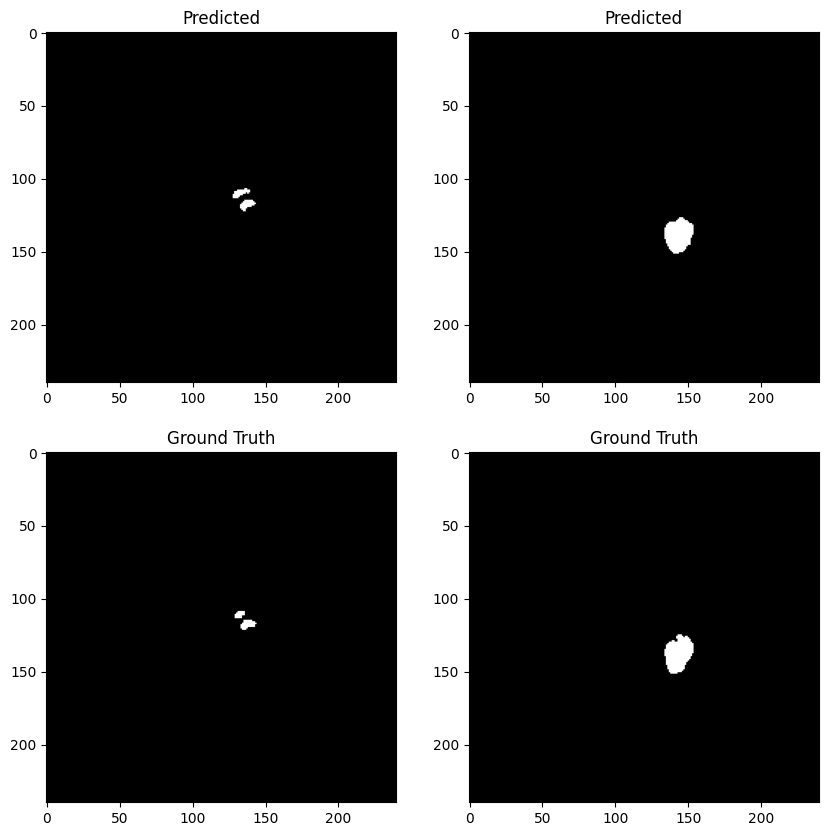

100%|██████████| 46/46 [01:13<00:00,  1.60s/it]


Average Validation Loss: 0.009245482197476795

Average Validation DSC: [0.99938744 0.88728795 0.94925664 0.79311823]
Average Validation ASSD: [ 0.09075371 19.70352146  8.09937286 13.95170605]
Epoch 97/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


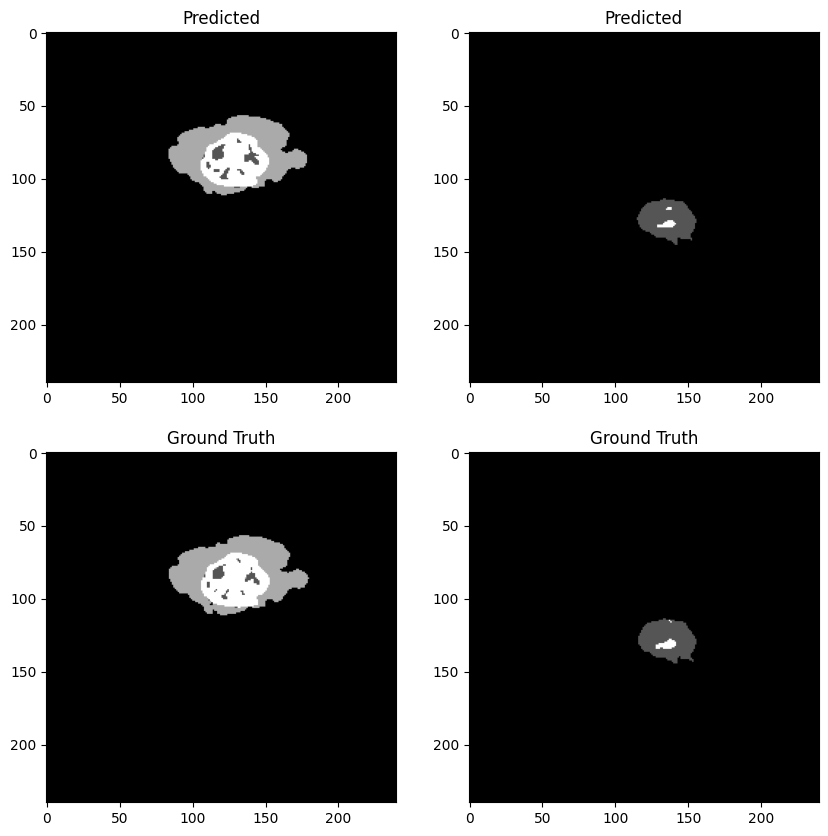

100%|██████████| 181/181 [07:56<00:00,  2.64s/it]



Average Training Loss: 0.003226888235478317

Average Training DSC: [0.99965496 0.93320622 0.9497495  0.88571988]
Average Training ASSD: [ 0.04627786 10.89585086 11.03251846  9.57988122]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [01:12<00:00,  1.59s/it]


Average Validation Loss: 0.01490021491949649

Average Validation DSC: [0.99871777 0.75180499 0.83283977 0.71249166]
Average Validation ASSD: [ 0.23190089 55.40218102 40.86879871 14.10773812]
Epoch 98/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


100%|██████████| 181/181 [07:57<00:00,  2.64s/it]



Average Training Loss: 0.0034457019862116863

Average Training DSC: [0.99963566 0.9317579  0.95650978 0.87900538]
Average Training ASSD: [ 0.04847197 10.652555    8.11168627  9.29944836]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [01:12<00:00,  1.59s/it]


Average Validation Loss: 0.008318681077545752

Average Validation DSC: [0.99925738 0.87862335 0.93328653 0.79325158]
Average Validation ASSD: [ 0.10686243 19.72663276 10.42940215 12.11752104]
Epoch 99/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


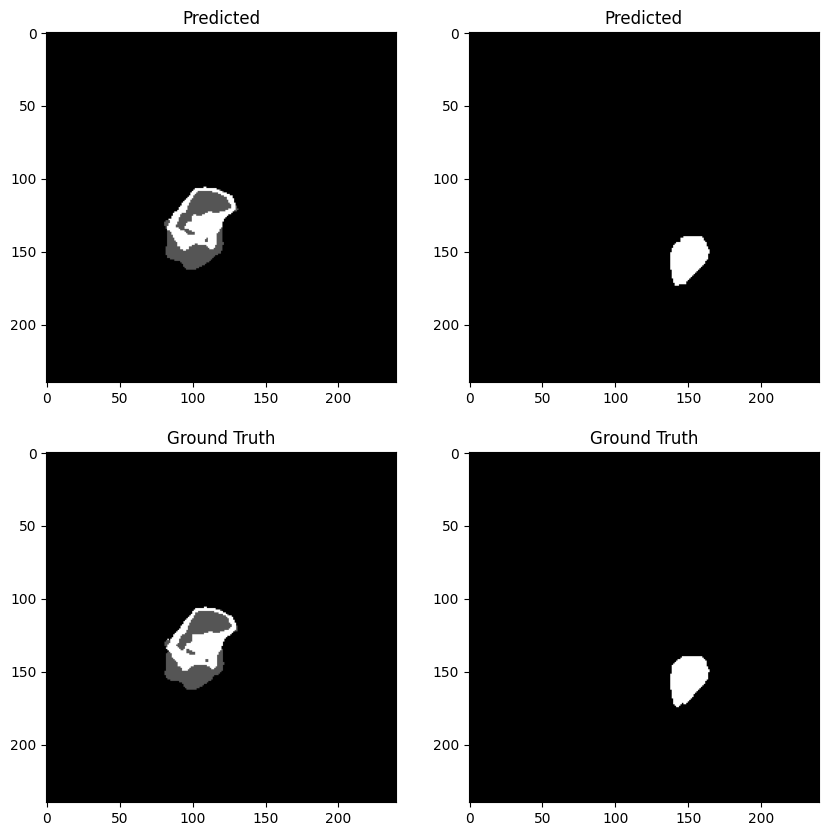

100%|██████████| 181/181 [07:42<00:00,  2.55s/it]



Average Training Loss: 0.003214191054945904

Average Training DSC: [0.99965327 0.93808954 0.96165744 0.88260842]
Average Training ASSD: [ 0.04772442  9.63499215  6.28760386 10.1761933 ]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]


Average Validation Loss: 0.008251839175658382

Average Validation DSC: [0.99928582 0.89797856 0.9466381  0.80658882]
Average Validation ASSD: [ 0.09893662 15.44910292  6.49237505 11.12884049]
Epoch 100/100
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


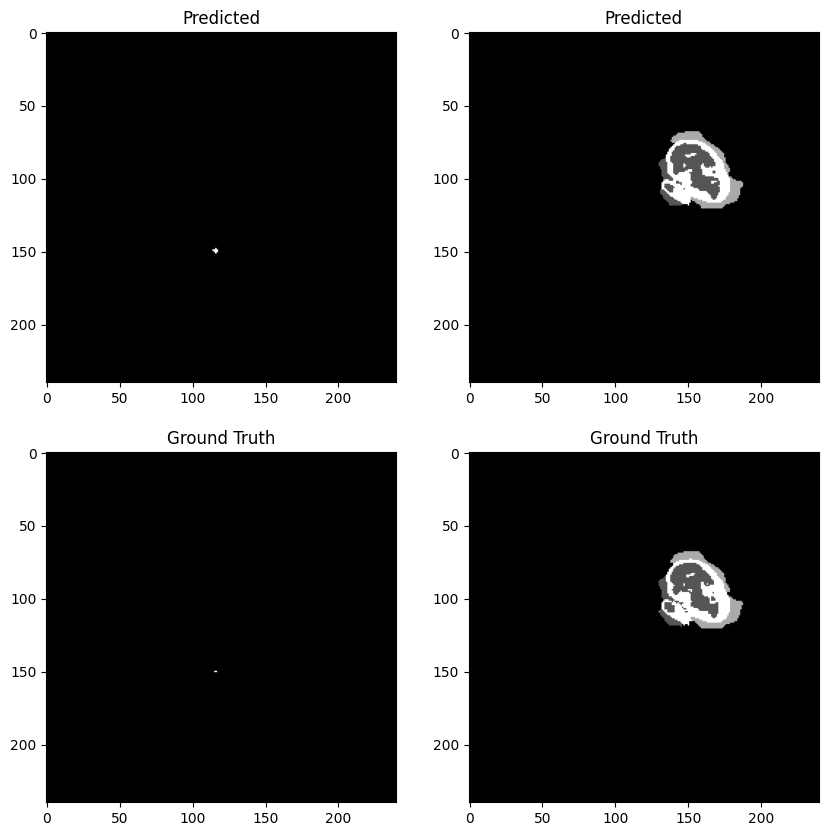

100%|██████████| 181/181 [06:44<00:00,  2.23s/it]



Average Training Loss: 0.002520740185915724

Average Training DSC: [0.99972279 0.95837786 0.9692618  0.90441634]
Average Training ASSD: [0.03810245 4.67675259 5.08296747 8.485907  ]


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


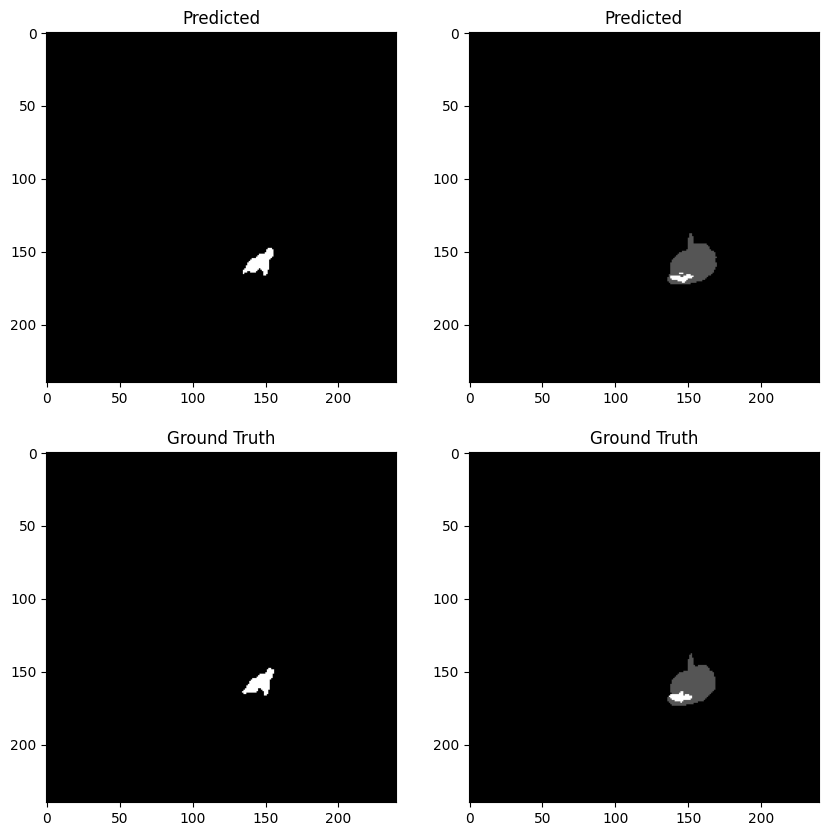

100%|██████████| 46/46 [00:54<00:00,  1.18s/it]


Average Validation Loss: 0.01020588497530021

Average Validation DSC: [0.99919561 0.8665025  0.71536623 0.77004556]
Average Validation ASSD: [ 0.21788932 26.94874063 90.29464361 16.77839482]


In [12]:
model = train_model(num_epochs = 100)